# Run NetConf on Houston IEEE data

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [2]:
# Data files
labelFile = './data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif' # Ground Truth
hsFile = './data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix' # Hyperspectral file
radarFile = './data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif' # LiDAR file
skip = 100 # Downsample by using every nth sample
crs = 'EPSG:6577' # Coordinate system

# A priori class beliefs
nClasses, cn = 2, 'class' # Number of classes (Houston default: 20), name of classes
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Pre-processing 
pca, comp  = False, 4 # Hyperspectral data PCA, component number
cluster = 'mean' # Clustering type if nClasses < nLabels ('all' samples used or 'mean' of label class used)

# Edge creation
adjacent, geoNeighbours, phase, neighbours = False, 2, True, [0,0,2] # geographical edges, n neighbours, data value edges, n neighbours for each data type

In [3]:
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
import numpy as np

import ground_truth


def get_training_array(tif):
    array = tif.read(window=from_bounds(*ground_truth.data.labelled_bounds + (tif.transform,)),
                     out_shape=(tif.count, ground_truth.data.height, ground_truth.data.width),
                     resampling=Resampling.bilinear)
    return normalise(array, tif.nodata)


def normalise(array, nodata):
    """Sets pixels with nodata value to zero then normalises each channel to between 0 and 1"""
    array[array == nodata] = 0
    return (array - array.min(axis=(1, 2))[:, None, None]) / (
        (array.max(axis=(1, 2)) - array.min(axis=(1, 2)))[:, None, None])

def read_tif_channels(tif, channel_index):
    if not isinstance(channel_index, list):
        channel_index = list(channel_index)
    if channel_index[0] == 0: # rasterio indexes channels starting from 1 not 0...
        channel_index = list(np.array(channel_index) + 1)
    profile = tif.profile
    profile.update({'count': len(channel_index)})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(tif.read(channel_index))
    return memory_file


def resample_tif(tif, scale_factor, mode=Resampling.bilinear):
    data = tif.read(
        out_shape=(
            tif.count,
            int(tif.height * scale_factor),
            int(tif.width * scale_factor)
        ),
        resampling=mode
    )
    # scale image transform
    transform = tif.transform * tif.transform.scale(
        (tif.width / data.shape[-1]),
        (tif.height / data.shape[-2])
    )
    profile = tif.profile
    profile.update({'width': int(tif.width * scale_factor),
                    'height': int(tif.height * scale_factor),
                    'transform': transform})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(data)
    return memory_file

import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from glob import glob
import ground_truth

def mosaic(directory):
    file_paths = glob(directory + "/*.tif")
    tif_list = []
    for path in file_paths:
        tif = rasterio.open(path)
        tif_list.append(resample_tif(tif, tif.transform[0] / ground_truth.data.resolution))
    mosaic_tif, mosaic_transform = merge(tif_list)
    profile = tif_list[0].profile
    profile.update({'width': mosaic_tif.shape[-1],
                    'height': mosaic_tif.shape[-2],
                    'transform': mosaic_transform})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(mosaic_tif)
    return memory_file


def training_array():
    file_directory = "./data/2018IEEE_Contest/Phase2/Final RGB HR Imagery"
    return get_training_array(mosaic(file_directory))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


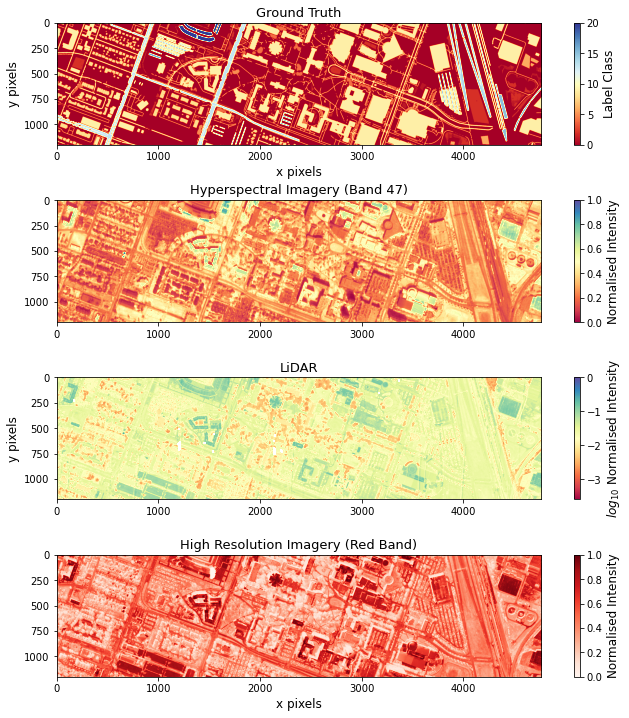

In [4]:
# Import ground truth
labels, larr = ip.raster_to_df(labelFile)

# Import aerial data
hs, hsarr = ip.raster_to_df(hsFile, value='amp', multidims=True, crop=True)
radar, radararr = ip.raster_to_df(radarFile, value='phase', crop=True)
processed = False

# High Res import
a = training_array()
highresarr = a.copy()
import pandas as pd
highres = pd.DataFrame(highresarr.reshape(-1,len(highresarr)),columns=['R','G','B'])
highres['x'], highres['y'] = np.tile(np.arange(highresarr.shape[2]),highresarr.shape[1]), np.repeat(range(highresarr.shape[1]),highresarr.shape[2])
highres = highres.set_index(['y','x'])

import numpy as np
# Plot rasters for each data type
fig, axs = pl.create_subplots(4,1,[10,10])
a = axs[0].imshow(larr[0],cmap='RdYlBu')
axs[0].set_title('Ground Truth',fontsize=13)
axs[0].set_xlabel('x pixels',fontsize=12)
axs[0].set_ylabel('y pixels',fontsize=12)
ac = fig.colorbar(a,ax=axs[0])
ac.set_label('Label Class',fontsize=12)
b = axs[1].imshow(hsarr[47],cmap='Spectral')
axs[1].set_title('Hyperspectral Imagery (Band 47)',size=13)
bc = fig.colorbar(b,ax=axs[1])
bc.set_label('Normalised Intensity',fontsize=12)
c = axs[2].imshow(np.log10(radararr[0]),cmap='Spectral')
axs[2].set_title('LiDAR',size=13)
axs[2].set_ylabel('y pixels',fontsize=12)
cc = fig.colorbar(c,ax=axs[2])
cc.set_label('$log_{10}$ Normalised Intensity',fontsize=12)
d = axs[3].imshow(highresarr[0],cmap='Reds')
axs[3].set_title('High Resolution Imagery (Red Band)',size=13)
axs[3].set_xlabel('x pixels',fontsize=12)
dd = fig.colorbar(d,ax=axs[3])
dd.set_label('Normalised Intensity',fontsize=12)
fig.tight_layout()

In [28]:
fig.savefig('results/houstonDataSources')

In [5]:
# Pre-process data
rm = labels[cn] != 0 # Remove unclassified data
labelsp, hsp, radarp, highresp = labels[rm][::skip], hs[rm][::skip], radar[rm][::skip], highres[rm][::skip] # Downsample data to run BP

# K-Means Clustering if nClasses < nLabels
if nClasses < len(labels[cn].unique()):
    # Run PCA on hyperspectral data
    X = hf.run_PCA(hsp.values.transpose(), comp).components_.transpose() if pca else radarp
    # Clustering
    kmeans, clusterClasses,_ = hf.run_cluster(X, labelsp, cluster, nClasses)
    print(clusterClasses)
else: clusterClasses = hf.default_classes(labelsp[cn])

[0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]


In [6]:
# Filter values for hyperspectral classes
takeClasses = False
if takeClasses: 
    classesUsed, labelsCl, hsCl, radarCl, highresCl = [], labelsp, hsp, radarp, highresp
    for j in range(nClasses): classesUsed.append([i+1 for i, x in enumerate(list(clusterClasses)) if x==j])
else:
    classesUsed = [[3,20],[6,15]]
#    classesUsed = [[1,2,3,4,5,6,7],[8,9,10,11,12,13,14,15,16,17,18,19,20]]
#    classesUsed = [[1,2,3,4,5,6,8,10,12,14,15,16,18],[11,20],[7,9,13,17,19]]
    used = [i in [3,20,6,15] for i in labelsp.values]
#    used = [i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] for i in labelsp.values]
    labelsCl, hsCl, radarCl, highresCl = labelsp[used], hsp[used], radarp[used], highresp[used]

# Get geodatabase of every pixel and assign beliefs
initial = hf.init_beliefs(hf.concat_dfs([hsCl,radarCl, highresCl]), classes=nClasses, crs=crs)
#initial = hf.init_beliefs(radarCl, classes=nClasses, crs=crs)

# Assign labels for each pixel
geoLabels = hf.df_to_gdf(labelsCl, columns=[cn], crs=crs, reIndex=True)
geoLabels[cn] = hf.group_classes(geoLabels[cn], classesUsed)
labelSummary = geoLabels.groupby('class').size()
equivUse = False
if equivUse:
    equiv = gpd.GeoDataFrame()
    for i in labelSummary.index.values:
        equiv = equiv.append(geoLabels[geoLabels['class'] == i][0:min(labelSummary)])
    
    # Split pixels in to train and test sets    
    X_train, X_test, y_train, y_test = hf.train_test_split(equiv, column = cn)
else: X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = cn)

# Create nodes for belief propagation from pixels, assigning priors to train set
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses-1:-1], beliefs=confidence)

classes =  np.array(range(nClasses))
d = dict(enumerate(classes))     

In [60]:
import sklearn as skl
import numpy as np
# Edge creation
measures = [0,0,0,0,0,0,0,0]
from tqdm import tqdm
adjacent, phase = True, True
scores = []
num = 11
for geoNeighbours in tqdm(range(num)):
    for ed1 in tqdm(range(num)):
        for ed2 in tqdm(range(num)):
            for ed3 in tqdm(range(num)):
                neighbours = [ed1,ed2,ed3]
                if all(values is 0 for values in neighbours) and (geoNeighbours is 0):
                    edges, beliefs = [], priors
                else:                    
                    edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbours=geoNeighbours, values=[nodes.columns[:50], ['phase'], ['R','G','B']] if phase else False, neighbours=neighbours)
                    beliefs, _ = nc.netconf(edges,priors,verbose=False,limit=1e-3)
                
                # Get y_true vs y_pred for test set
                y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)
                yp_clf = np.argmax(y_pred, axis=1)                
                pred_clf = [d.get(i) for i in yp_clf]
                f1 = skl.metrics.f1_score(y_true, pred_clf,average='weighted',zero_division=0)
                a = skl.metrics.accuracy_score(y_true, pred_clf)
                r = skl.metrics.recall_score(y_true, pred_clf,average='weighted',zero_division=0)
                log_loss = skl.metrics.log_loss(y_true, y_pred, labels=[0,1])
                measures = np.vstack((measures, [geoNeighbours, ed1, ed2, ed3, f1,a,r,log_loss]))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.2383501712575195 0.4099099099099099 0.4099099099099099 0.6931471805599454
13  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.74it/s]

0.5308907580881047 0.527027027027027 0.527027027027027 0.6968155477527417
9  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.14it/s]

0.5700347081036473 0.5720720720720721 0.5720720720720721 0.6856555913161654





 36%|███▋      | 4/11 [00:01<00:02,  2.56it/s]

9  iterations
0.5343854803708817 0.5405405405405406 0.5405405405405406 0.6903207122683832
9  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.54it/s]

0.5393084722353015 0.5495495495495496 0.5495495495495496 0.686394053088192
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.18it/s]

0.5408036969968147 0.5495495495495496 0.5495495495495496 0.682703132645564





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

10  iterations
0.5154513070370109 0.527027027027027 0.527027027027027 0.6820021332363314
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.99it/s]

0.5323448448448448 0.5495495495495496 0.5495495495495496 0.6795823701348247
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  2.00it/s]

0.528236780399722 0.5495495495495496 0.5495495495495496 0.6794006544271093
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.78it/s]

0.5307985193983171 0.5585585585585585 0.5585585585585585 0.6769540132240933
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


  9%|▉         | 1/11 [00:05<00:52,  5.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5296135175102301 0.5540540540540541 0.5540540540540541 0.6757980142667572
16  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.8249640222631756 0.8243243243243243 0.8243243243243243 0.5595194412565975
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.18it/s]

0.7203247909488858 0.7252252252252253 0.7252252252252253 0.6219023933842597
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.32it/s]

0.6897130653468033 0.6981981981981982 0.6981981981981982 0.6390666188474573
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.40it/s]

0.6358982222056607 0.6531531531531531 0.6531531531531531 0.6546464468365649
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.45it/s]

0.5970900997786848 0.6081081081081081 0.6081081081081081 0.658484175454402
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.46it/s]

0.6273905134664628 0.6396396396396397 0.6396396396396397 0.6604407567447897
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.69it/s]

0.6016547857155068 0.6171171171171171 0.6171171171171171 0.6628159106569272
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.85it/s]

0.5980694660711838 0.6171171171171171 0.6171171171171171 0.6630126882010737
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.72it/s]

0.5860335335335336 0.6126126126126126 0.6126126126126126 0.6644765104588528
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.66it/s]

0.5679357469962063 0.5990990990990991 0.5990990990990991 0.66364150505093
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.62it/s]


 18%|█▊        | 2/11 [00:09<00:41,  4.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5631535583559572 0.5900900900900901 0.5900900900900901 0.6638157959017997
9  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.54it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.5498402472826454





 18%|█▊        | 2/11 [00:00<00:04,  2.16it/s]

9  iterations
0.8200247711851755 0.8243243243243243 0.8243243243243243 0.595543257658141
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.10it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6169830755152154
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.6940482022349821 0.7072072072072072 0.7072072072072072 0.6354774847276368
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.09it/s]

0.6672645857153057 0.6801801801801802 0.6801801801801802 0.6425780148053344
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.40it/s]

0.6737269783401375 0.6891891891891891 0.6891891891891891 0.6471896637926363
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.42it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.651309852814831
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.66it/s]

0.6816576330624788 0.6981981981981982 0.6981981981981982 0.6528970382685056
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.40it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6555623283353055
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.43it/s]

0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6557749555873851
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


 27%|██▋       | 3/11 [00:14<00:36,  4.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6019529836786548 0.6351351351351351 0.6351351351351351 0.6567365868463194
9  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.67it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5324185946752859
9  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.53it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.5716674659242182
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.86it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.5960078380936207
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.04it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.616400830841288
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.625892031589972
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.80it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6324636816774004
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6382228544097862
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6411409375660814
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6450144416359731
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.646152202274746
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 36%|███▋      | 4/11 [00:19<00:35,  5.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6478573479552174
9  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5266298349052639
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.560076965622895
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.21it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.5836243391751359
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.31it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6048459540905675
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.38it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6155307310592676
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6230943731588134
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.42it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6295040027787846
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.47it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6332545352904729
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.48it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6376964310664046
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.71it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6396313675122955
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


 45%|████▌     | 5/11 [00:24<00:29,  4.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6418194515137143
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5249477292214751
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.5522712540782726
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.16it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5744838457513803
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.80it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.5956611884989322
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.71it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6068209881518338
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.61it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6148970780240792
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.60it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6220271309864318
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.54it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.626319060750049
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.56it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6311668080625634
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.35it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6336396794408047





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 55%|█████▍    | 6/11 [00:28<00:23,  4.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6362134196530257
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5199340966803885
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5449049795113715
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.47it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5666750961858382
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.77it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.5873320263627458
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.43it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.5988283619449548
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.26it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6072899714479641





 64%|██████▎   | 7/11 [00:03<00:01,  2.16it/s]

10  iterations
0.812937937937938 0.8198198198198198 0.8198198198198198 0.614911250843483
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.10it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6197373127568888





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

10  iterations
0.78618796250465 0.7972972972972973 0.7972972972972973 0.6249427751488049
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.02it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6278558066956033
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


 64%|██████▎   | 7/11 [00:33<00:19,  4.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6307962073886237
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5164615500789017
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.538740533695169
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.44it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5598742557476954
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.76it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5802364905080883
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.98it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5917850279190499
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.52it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6005198294888383





 64%|██████▎   | 7/11 [00:02<00:01,  2.31it/s]

10  iterations
0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6083527882965151
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.20it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6135179634608597
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.619082795202956
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.81it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6223636792789541
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


 73%|███████▎  | 8/11 [00:39<00:14,  4.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6255918910069855
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5216459129443644
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5387806935855751
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5566279403555232
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.12it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5759685473279407
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.21it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.587289424491321
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.5960683610467186
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.14it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6040604626213537
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.42it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6094165546131465
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.45it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.615256874461918
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.46it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6187769965125205
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


 82%|████████▏ | 9/11 [00:43<00:09,  4.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6220974030629798
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.521675696571802
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.48it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.53679376865137
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.84it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5525888469636671
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.71it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5709820057606159
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.39it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5820971261052051
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.24it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5909408111431476
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.32it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.5990677524480538
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.35it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6046071611168443
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.42it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6106662755166118
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.43it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6144247040676901
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 91%|█████████ | 10/11 [00:48<00:04,  4.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6179281404470455
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.61it/s]

0.888217154039939 0.8918918918918919 0.8918918918918919 0.5211412587276752
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.41it/s]

0.893083550283153 0.8963963963963963 0.8963963963963963 0.5343498530481716
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.91it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5488004231954619
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.07it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5665965511094772
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.17it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5774686776099428
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.27it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.586318830118115
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.24it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5944231278501786
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.29it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6000734951762693
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  2.99it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6061623291487876
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.82it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6100711673215593
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


100%|██████████| 11/11 [00:52<00:00,  4.73s/it]

  9%|▉         | 1/11 [00:52<08:40, 52.04s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6137183513908915
15  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.51it/s]

0.716447934650309 0.7162162162162162 0.7162162162162162 0.6310945738145654
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.19it/s]

0.6314467777882412 0.6396396396396397 0.6396396396396397 0.6500744000139319
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.33it/s]

0.6418268836575155 0.6486486486486487 0.6486486486486487 0.657175911787911
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.66it/s]

0.5862798250087228 0.5990990990990991 0.5990990990990991 0.6671334540181678
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.37it/s]

0.5939749865491671 0.6081081081081081 0.6081081081081081 0.6673692989474607
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.40it/s]

0.5679177610212093 0.5855855855855856 0.5855855855855856 0.6672300177537358
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.44it/s]

0.5810813845986676 0.5990990990990991 0.5990990990990991 0.6688870187938696
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.28it/s]

0.571667483128975 0.5900900900900901 0.5900900900900901 0.6686070968863578
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.17it/s]

0.5595251406596446 0.5855855855855856 0.5855855855855856 0.6694999394331267
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.13it/s]

0.5667792792792792 0.5945945945945946 0.5945945945945946 0.6684656765820364
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


  9%|▉         | 1/11 [00:05<00:50,  5.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5535525376604836 0.581081081081081 0.581081081081081 0.6682953636865504
12  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8148130633004671 0.8153153153153153 0.8153153153153153 0.5772421850340274
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6136926299464527
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6288673169653192
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.6832819364464935 0.6936936936936937 0.6936936936936937 0.6432139151744635
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.6752203992955964 0.6891891891891891 0.6891891891891891 0.6476144520595838
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.11it/s]

0.6816576330624788 0.6981981981981982 0.6981981981981982 0.6506110833023482
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.08it/s]

0.6548126002728991 0.6711711711711712 0.6711711711711712 0.654133132049322
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.05it/s]

0.6534234234234234 0.6756756756756757 0.6756756756756757 0.6554011914383151
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.04it/s]

0.6261916013337965 0.6531531531531531 0.6531531531531531 0.6574611614013118
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.02it/s]

0.6224308442385115 0.6486486486486487 0.6486486486486487 0.6575492930753749
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


 18%|█▊        | 2/11 [00:10<00:47,  5.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6030683234302299 0.6306306306306306 0.6306306306306306 0.6582759265865822
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.5620763275965808
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.26it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.5976473775168374
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.39it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6142134402965134
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.73it/s]

0.7156094870380584 0.7297297297297297 0.7297297297297297 0.6296963043704235
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.85it/s]

0.7276003276003277 0.7387387387387387 0.7387387387387387 0.6359919748783441
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.01it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.640557840874425
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.13it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6450707195672538
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.18it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6471984665438959
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.23it/s]

0.6553195285025915 0.6801801801801802 0.6801801801801802 0.6500912339511585
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.94it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6509114903238765
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


 27%|██▋       | 3/11 [00:14<00:37,  4.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6412662692412567 0.6711711711711712 0.6711711711711712 0.6522324714996575
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.42it/s]

0.8634206196620697 0.8648648648648649 0.8648648648648649 0.5445892585042434
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.82it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.5795044399084908
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.34it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.5980933663917021
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.42it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.614718826353829
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.25it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6226612900788456
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.16it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6285706804176164
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.10it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.634154730359217
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.07it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6372000864495484
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.05it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6409995483700823
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.03it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6425025303094353





100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


 36%|███▋      | 4/11 [00:19<00:33,  4.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6443905091191972
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5361002486422048
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5694527775496959
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.587863854647883
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6050881217914854
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6139298724969325
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6205935900052794
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6266283602647393
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6302976412546478
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6345257520742925
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6366662880354775





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:25<00:30,  5.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6389399309196788
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5310810793232745
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.28it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5620615796966101
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.16it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5799032104879733
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.27it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5972328148995081
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.35it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6064673825569975
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.39it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6135423548453504
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.42it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6201336941830258
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.45it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6241941763813182
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.31it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6287313732816803
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.35it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6312925191419319
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


 55%|█████▍    | 6/11 [00:30<00:25,  5.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6338715289157809
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.39it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5260730439474656
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.82it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5551042762002798
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.05it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.572817766180767
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.16it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5899363908813912
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.21it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5994693095281469
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  2.90it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6068619331727017
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.613839731052263
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.34it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.618335338196369
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.23it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6231732847065095
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.14it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6260722297549463
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


 64%|██████▎   | 7/11 [00:34<00:19,  4.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6289479261481333
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5217132451620362





 18%|█▊        | 2/11 [00:00<00:03,  2.25it/s]

10  iterations
0.9126129061612932 0.9144144144144144 0.9144144144144144 0.5488327394476004





 27%|██▋       | 3/11 [00:01<00:03,  2.36it/s]

10  iterations
0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5664653993948087
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.43it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5834852853375676
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.26it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5931426691279387
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.16it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6007841041580387
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.11it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6079314995662826





 73%|███████▎  | 8/11 [00:03<00:01,  1.94it/s]

10  iterations
0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6127016853980772
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.10it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6178434672659526
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.37it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6210429440350522
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


 73%|███████▎  | 8/11 [00:39<00:14,  4.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6241601334376937
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.523370488192975
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5464005924117102
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5630555541767072
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5795600049215212
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5891177766706368
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.5968203736748631
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6040884436037253
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6090155856752829
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.02it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6143890398062318
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.617779417137108
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 82%|████████▏ | 9/11 [00:45<00:10,  5.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6209690892110038
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5222877494512517
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5427641165699874
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5588243014014365
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.574884001258369
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5843717873328589
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5921572790136742
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5995402722373695
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6046221597029299
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6101809636721817
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.613768497123463
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 91%|█████████ | 10/11 [00:51<00:05,  5.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6171139294596778
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.893083550283153 0.8963963963963963 0.8963963963963963 0.5212686455990299
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.539773367628295
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5550699376213023
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5707745418605766
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5801232153580778
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5879298617976472
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.83it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5952997598489544
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6004636251886095
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.05it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6060477125177073
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6097552732648859
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


100%|██████████| 11/11 [00:57<00:00,  5.22s/it]

 18%|█▊        | 2/11 [01:49<08:16, 55.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6132188000827269
9  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.58it/s]

0.7751325740456175 0.7747747747747747 0.7747747747747747 0.6137370676584563
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  1.95it/s]

0.7450518233691968 0.7477477477477478 0.7477477477477478 0.6323562422240023
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.18it/s]

0.7000412853086257 0.7072072072072072 0.7072072072072072 0.6434635417773499
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.50it/s]

0.6469786948865179 0.6621621621621622 0.6621621621621622 0.6547475273782554
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.76it/s]

0.6548126002728991 0.6711711711711712 0.6711711711711712 0.6573082036525997
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.93it/s]

0.6265539236027422 0.6486486486486487 0.6486486486486487 0.6588271075859918
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.06it/s]

0.6131976131976132 0.6351351351351351 0.6351351351351351 0.6614806993671905
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.12it/s]

0.632298965632299 0.6531531531531531 0.6531531531531531 0.6621881784774142
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.20it/s]

0.6283260004190236 0.6531531531531531 0.6531531531531531 0.6638409140247316
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.24it/s]

0.6111586618333245 0.6351351351351351 0.6351351351351351 0.6634474598814211
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


  9%|▉         | 1/11 [00:03<00:37,  3.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5956606606606607 0.6216216216216216 0.6216216216216216 0.6637858454119849
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.34it/s]

0.8278272336108157 0.8288288288288288 0.8288288288288288 0.5822382939098206
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.36it/s]

0.7766268292584081 0.7792792792792793 0.7792792792792793 0.6092614999246511
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.90it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6233987999515211
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.47it/s]

0.7007007007007007 0.7117117117117117 0.7117117117117117 0.6367223263442628
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.10it/s]

0.699421051145189 0.7117117117117117 0.7117117117117117 0.6416684285633081
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.20it/s]

0.6744316257049547 0.6936936936936937 0.6936936936936937 0.6452446817850284
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.32it/s]

0.6886362750638165 0.7027027027027027 0.7027027027027027 0.6491840022953521
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.36it/s]

0.6705016705016705 0.6891891891891891 0.6891891891891891 0.6509302659798223
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.09it/s]

0.6456102194463265 0.6711711711711712 0.6711711711711712 0.653406732466995
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.93it/s]

0.6494310099573256 0.6756756756756757 0.6756756756756757 0.6538626505460654
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


 18%|█▊        | 2/11 [00:08<00:39,  4.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6239540401351935 0.6531531531531531 0.6531531531531531 0.6548865628542989
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.40it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.5715027911390042
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.36it/s]

0.8590468548022459 0.8603603603603603 0.8603603603603603 0.5981940668525045
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.93it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6125979933371263
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.47it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6263624113250745
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.70it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6324171110522594
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.90it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6369994792858692
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.04it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6415602725756867
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.08it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6439180795455084
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.20it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6469944797509286
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.19it/s]

0.6825586053089298 0.7072072072072072 0.7072072072072072 0.648018031707061
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.06it/s]


 27%|██▋       | 3/11 [00:12<00:32,  4.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6495192940902101
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.43it/s]

0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5575815354881264
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.37it/s]

0.8819256037646843 0.8828828828828829 0.8828828828828829 0.5839069699205105
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.5994422946210219
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.37it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6138509677588811
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.35it/s]

0.8008606240285454 0.8063063063063063 0.8063063063063063 0.621024412126909
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.626594206386182
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.81it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6319339570083177
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.96it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6349917705943553
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.08it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6387776604774805
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.15it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6403574451020966
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


 36%|███▋      | 4/11 [00:15<00:26,  3.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6423288274916844
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.46it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5503603970007102
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.43it/s]

0.9003210299852089 0.9009009009009009 0.9009009009009009 0.5758227566563857
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.22it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.5911736694261882





 36%|███▋      | 4/11 [00:01<00:03,  2.30it/s]

10  iterations
0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6058947177272187
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.61it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6136672005843883
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.82it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6197588206184997
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.50it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6253965192902119
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.50it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6289165080974656
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.50it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.633010390326051
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.49it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.635127001299592
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


 45%|████▌     | 5/11 [00:19<00:23,  3.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6374059920060012
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.42it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5446000080697678
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5691501369999217
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.89it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.584116724873919
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.72it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.5989694109068315
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6070329237492498
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.06it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6134544388176754
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.11it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6195371619267148
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.19it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6233698702007612
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.25it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6277021331827332
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.72it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6301753328679396
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


 55%|█████▍    | 6/11 [00:23<00:19,  3.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6327065479337026
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.44it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5394120596515176
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.35it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5627995127867582
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.34it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5777066167669634
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.35it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5924528383692292
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.29it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6007519319381244
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6074067062186485
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.79it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6138054263196681
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.69it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6179999111192158
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.87it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6225865622808027
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.78it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6253455329094157
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


 64%|██████▎   | 7/11 [00:27<00:15,  3.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6281280651851355
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.50it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5345043797620416
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.95it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5568642982846476
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  3.09it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5717814547124688
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.20it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.58652396002265
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.23it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5949528552740787
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.28it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.601845526858457
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.31it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.608390781601325
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.31it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.612822474054651
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.30it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6176699477016981
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.00it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6206887778042953
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


 73%|███████▎  | 8/11 [00:31<00:11,  3.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6236816119068112
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.55it/s]

0.9220577286250993 0.9234234234234234 0.9234234234234234 0.5332181258896909
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.48it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5539493665293403
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5683135815313306
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.98it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5827481602660841
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.12it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.591149944144837
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.96it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5981171079274696
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6047749066705589
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.98it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6093457048806642
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.10it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6144044733655616
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.08it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.617594585487193
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


 82%|████████▏ | 9/11 [00:36<00:08,  4.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.620655736103377
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.9173446654594266 0.918918918918919 0.918918918918919 0.5304389680482351
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.54it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5501331400344537
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.25it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5642281907553336
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.15it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5783671853143815
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.24it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5867214854277933





 55%|█████▍    | 6/11 [00:02<00:02,  2.16it/s]

10  iterations
0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5937653072828871
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.27it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6005219832481689
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.21it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6052322318361595
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.27it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6104536643590052





 91%|█████████ | 10/11 [00:04<00:00,  2.32it/s]

10  iterations
0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6138199147709428
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


 91%|█████████ | 10/11 [00:41<00:04,  4.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.617016945239005
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.9123197603209829 0.9144144144144144 0.9144144144144144 0.5285234004882555
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5470029043931196
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.46it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5606006587869378
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.74it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.574502889597614
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.582771608784507
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.53it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.589846414043293
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.34it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5966004408118984
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.21it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6013786309347995
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.01it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6066197207124199
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.90it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6100885125490659
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


100%|██████████| 11/11 [00:46<00:00,  4.23s/it]

 27%|██▋       | 3/11 [02:35<06:49, 51.23s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6133832313538625
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.66it/s]

0.7797906014122231 0.7792792792792793 0.7792792792792793 0.6079630013259726
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.02it/s]

0.7468100862542021 0.7477477477477478 0.7477477477477478 0.6218719549543895
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.20it/s]

0.7428500703182163 0.7477477477477478 0.7477477477477478 0.6329732535267651
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.85it/s]

0.690811786395045 0.6981981981981982 0.6981981981981982 0.6448933144402141
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.01it/s]

0.6885477334335328 0.6981981981981982 0.6981981981981982 0.6488481454694731
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.12it/s]

0.6682110682110682 0.6846846846846847 0.6846846846846847 0.6511960391423353
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.15it/s]

0.6776907519764662 0.6936936936936937 0.6936936936936937 0.6545780068308104
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.23it/s]

0.6721548758404634 0.6891891891891891 0.6891891891891891 0.6559387797561612
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  2.96it/s]

0.6457050044436272 0.6666666666666666 0.6666666666666666 0.6582313396387081
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.58it/s]

0.6417933650467929 0.6666666666666666 0.6666666666666666 0.6585781101070738
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


  9%|▉         | 1/11 [00:03<00:38,  3.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6239540401351935 0.6531531531531531 0.6531531531531531 0.6593204141263997
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.35it/s]

0.8144360319184163 0.8153153153153153 0.8153153153153153 0.5840431108841827
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.31it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.6050563295912293
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6178417163500126
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.34it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6307207818124535
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.36it/s]

0.7401757391194012 0.7477477477477478 0.7477477477477478 0.6361639849477903
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.33it/s]

0.72876001001001 0.7387387387387387 0.7387387387387387 0.6399309096920185
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.36it/s]

0.6980715394558221 0.7117117117117117 0.7117117117117117 0.6441656840352505
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.75it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6462404854081851
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  2.91it/s]

0.6630237502510176 0.6891891891891891 0.6891891891891891 0.6491043484253387
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.03it/s]

0.6862492211329421 0.7072072072072072 0.7072072072072072 0.6500823273603261
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


 18%|█▊        | 2/11 [00:07<00:32,  3.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6630237502510176 0.6891891891891891 0.6891891891891891 0.6513536064483498
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.35it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.5758394915000822
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.37it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.5968772065980447
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6095411844382125
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.33it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6224033681052014
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.00it/s]

0.7688586932085751 0.7747747747747747 0.7747747747747747 0.6285095775305283
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  2.80it/s]

0.7516200428579042 0.7612612612612613 0.7612612612612613 0.632988501710513
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.68it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6376314284173671
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.87it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6401389185838104
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.98it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6434468438811847
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.09it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6448418657031689
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


 27%|██▋       | 3/11 [00:10<00:29,  3.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6747381466151215 0.6981981981981982 0.6981981981981982 0.6465050562071685
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  3.32it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5651263927773287
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.43it/s]

0.8914900369660866 0.8918918918918919 0.8918918918918919 0.5857954186446528
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.42it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5989778198436386
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.34it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6120923959340294
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.34it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6188969046170198





 55%|█████▍    | 6/11 [00:01<00:01,  2.92it/s]

10  iterations
0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6240793854300999
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.39it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6292649748132907
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.25it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6322847878388773
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.03it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6361389007828577
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.90it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6379586286643633
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


 36%|███▋      | 4/11 [00:15<00:28,  4.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6399903759538615
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8959031398566726 0.8963963963963963 0.8963963963963963 0.558779127076716
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.07it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5789601431192304
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.52it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5919680509537988
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.80it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6052348011974662
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.00it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6124625413137332
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.08it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6180449399178533
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.17it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6234401629748839
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.22it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.626819953225353
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.67it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6309006854710791
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.23it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.633166376689238
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


 45%|████▌     | 5/11 [00:20<00:25,  4.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6354521063725226
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.58it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5531566144317913
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5729652907404558
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.14it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5857042283149823
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.84it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5990639693414506
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.26it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6065240069576158
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.16it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6123668510463225
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.45it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.618126553555258
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.67it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6217564995362473
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.85it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6260222095782885
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.97it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6285793545921653
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


 55%|█████▍    | 6/11 [00:24<00:20,  4.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6310766165473882
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9365679281724058 0.9369369369369369 0.9369369369369369 0.5482444214493659
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9365679281724058 0.9369369369369369 0.9369369369369369 0.5673710458179658
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.17it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5800927358363271
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.31it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5933402258121158
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.18it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6009626111694225
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.12it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.606981705776494
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.07it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6129874282318036
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6169065019519786
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.04it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6213708750062041
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.03it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6241529862391407
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


 64%|██████▎   | 7/11 [00:29<00:18,  4.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6268636945406523





  9%|▉         | 1/11 [00:00<00:04,  2.48it/s]

10  iterations
0.9316204579362475 0.9324324324324325 0.9324324324324325 0.5435730428153196
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.53it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5620340395270413
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.49it/s]

0.9271576638197706 0.9279279279279279 0.9279279279279279 0.574795308745695
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.78it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.588023671413502
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.96it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5957311906448128
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.09it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6019515059820025
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.89it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6080621843529876
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.71it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6121646812432412
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.46it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6168472526520586
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.14it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6198371447146335
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 73%|███████▎  | 8/11 [00:34<00:13,  4.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6227267158651364
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.65it/s]

0.9269624282934716 0.9279279279279279 0.9279279279279279 0.5418241916732842
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.49it/s]

0.9407377302114144 0.9414414414414415 0.9414414414414415 0.5592444299688744
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

0.9316204579362475 0.9324324324324325 0.9324324324324325 0.571616968500996





 36%|███▋      | 4/11 [00:01<00:03,  2.33it/s]

10  iterations
0.9175969447708578 0.918918918918919 0.918918918918919 0.5845952016220483
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.20it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5922720796518383
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.14it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5985589329120499
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.09it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6047596053199239
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.94it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6089766408416053
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6138307827139813
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.90it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6169622889653101
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


 82%|████████▏ | 9/11 [00:39<00:09,  4.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6199073523642228
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5387175040510725
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.53it/s]

0.9314307314307314 0.9324324324324325 0.9324324324324325 0.5556108359233489
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.48it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.56783690609439
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.53it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5805670502143977
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.51it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5882068515048017
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.74it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5945606659723643
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.90it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6008408921818575
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.79it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6051743535333053
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.13it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6101646679042922
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.96it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6134452664590383
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


 91%|█████████ | 10/11 [00:44<00:04,  4.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6165080572076594
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9220577286250993 0.9234234234234234 0.9234234234234234 0.5365150078320763
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.926752839796318 0.9279279279279279 0.9279279279279279 0.5526290915301526
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5645103101801251
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5770447513273729
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5846157039299542
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5909987858238013
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.13it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5972745267867712
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.07it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6016577577359725
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.21it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6066486870033504
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.14it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6100062040285914
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


100%|██████████| 11/11 [00:50<00:00,  4.59s/it]

 36%|███▋      | 4/11 [03:26<05:56, 50.94s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6131472502877748
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.7934145698586808 0.7927927927927928 0.7927927927927928 0.6037724555454921
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.56it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6148505237179592





 27%|██▋       | 3/11 [00:01<00:03,  2.50it/s]

10  iterations
0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6256139680154785
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.52it/s]

0.7257360637698275 0.7342342342342343 0.7342342342342343 0.6377299933712681
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.31it/s]

0.7369592809629488 0.7432432432432432 0.7432432432432432 0.6421542294707169
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.19it/s]

0.7100538038038038 0.7207207207207207 0.7207207207207207 0.6452689554609096
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.704755900000905 0.7162162162162162 0.7162162162162162 0.6491193166832392
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.99it/s]

0.6911603902844945 0.7072072072072072 0.7072072072072072 0.6510944532552276
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.12it/s]

0.6726776776776775 0.6936936936936937 0.6936936936936937 0.6535792243636986
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.96it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6544189341028502
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


  9%|▉         | 1/11 [00:05<00:52,  5.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6351858925388337 0.6666666666666666 0.6666666666666666 0.6554695398445877
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8061394798155086 0.8063063063063063 0.8063063063063063 0.5847290684709948
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8006420599704182 0.8018018018018018 0.8018018018018018 0.601562324981649
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6134218000662645
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.10it/s]

0.7730737343581099 0.7792792792792793 0.7792792792792793 0.6259589178280944
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.46it/s]

0.7461887798765295 0.7522522522522522 0.7522522522522522 0.6314264015142638
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.70it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6355256373418822
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.88it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6400024212309238
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.75it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6424969780250441
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.66it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6454264746858552
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.60it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6467539442632769
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


 18%|█▊        | 2/11 [00:09<00:42,  4.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6482279635629227
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.58it/s]

0.8512233217188787 0.8513513513513513 0.8513513513513513 0.5780960552148648
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

0.836512374443409 0.8378378378378378 0.8378378378378378 0.5953191623598312
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.36it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6068989116095781
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.38it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6191741525083004
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.35it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6250547102610867
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6296317730934622
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.36it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.634359331500105
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.40it/s]

0.7516200428579042 0.7612612612612613 0.7612612612612613 0.6371589887827979
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.28it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.640433180966917





 91%|█████████ | 10/11 [00:03<00:00,  2.04it/s]

10  iterations
0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6420724714392452
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


 27%|██▋       | 3/11 [00:13<00:36,  4.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6438693319238291
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.44it/s]

0.8465761215761216 0.8468468468468469 0.8468468468468469 0.5693101193750609
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.81it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5863333897641114
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.37it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.5981744956582841
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.39it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6104607819353559
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.69it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6168404648183575
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.88it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6218867940834069
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.02it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6269976339439548
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.11it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.630170396853999
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.18it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6338779927924314
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.22it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6358454565066085
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


 36%|███▋      | 4/11 [00:17<00:30,  4.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6379350752629656
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.42it/s]

0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5641881140386673
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.91it/s]

0.8914900369660866 0.8918918918918919 0.8918918918918919 0.5808331274184
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  3.10it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5924094246188729
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.83it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.604670970577677
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.95it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6113337796284124
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6166420420062382
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.07it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6218636436163016
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.81it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6253035614850236
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6291844428916351
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.93it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6315227572197296
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


 45%|████▌     | 5/11 [00:22<00:27,  4.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6338101305290809
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.46it/s]

0.9184444790788074 0.918918918918919 0.918918918918919 0.5593182397399248
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  1.94it/s]

0.9093827545320082 0.9099099099099099 0.9099099099099099 0.5757612536449125
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.96it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.587072424034776
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.98it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5993491144695015
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6061895880223045
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.611662882188946
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.30it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6171760682427195
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.55it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6207903661515751
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.75it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6248209070386024
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.91it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6273488554632664
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 55%|█████▍    | 6/11 [00:27<00:22,  4.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.629807684004845
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.44it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5549423202808939
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.40it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5709070109310631
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.77it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.582152368621198
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.99it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5942771997560112
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.07it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6012239357816386
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.16it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6068076204700815
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.22it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6125058034365138
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.23it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6163516601947368
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  2.99it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6205510797706134
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.59it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6232599339835021
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


 64%|██████▎   | 7/11 [00:31<00:17,  4.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.625895031682981
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.65it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5505570097500838
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.54it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5660950268264296
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

0.9271576638197706 0.9279279279279279 0.9279279279279279 0.5773750295988826
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.33it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5894630417148305
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.63it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5964779392764532
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.85it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6022309390891906
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.98it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6080036532954636
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.08it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6119866608280896
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.16it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6163732015544716
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.19it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6192588418471714
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


 73%|███████▎  | 8/11 [00:35<00:12,  4.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6220510027883073
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.49it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5486331374838967
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.15it/s]

0.940890616529974 0.9414414414414415 0.9414414414414415 0.5634501331900018
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.27it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5744301603150505
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.60it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5863152577025189
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.83it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5933078482790413
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.71it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5991058192203228
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.62it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6049467852613444
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.22it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6090277029489625
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.00it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6135694272094159
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.00it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6165751992029206
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


 82%|████████▏ | 9/11 [00:40<00:08,  4.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6194112844559827
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.51it/s]

0.9271576638197706 0.9279279279279279 0.9279279279279279 0.5454928044324305
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.940890616529974 0.9414414414414415 0.9414414414414415 0.5600400640499493
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  3.09it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5709475623522364
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.18it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5826235613951098
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.22it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5895828444526163
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  2.97it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5954390102154332
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.77it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6013401100211646
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.47it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6055192860222484
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.14it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6101801101488589
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.25it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.613313881051948
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 91%|█████████ | 10/11 [00:44<00:04,  4.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6162487522593457
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5432578508553657
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.9269624282934716 0.9279279279279279 0.9279279279279279 0.5572289468598141
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5678594179370889
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.07it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5793648339315468
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5862639653629076
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.10it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5921403329198538
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5980332439635794
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.07it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6022404383399167
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.19it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6069005537581729
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.28it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6100948257780682
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.11it/s]


100%|██████████| 11/11 [00:49<00:00,  4.54s/it]

 45%|████▌     | 5/11 [04:16<05:03, 50.57s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6130945227921819
11  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.71it/s]

0.7841272710837929 0.7837837837837838 0.7837837837837838 0.6021032158766416
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.23it/s]

0.7696455177639956 0.7702702702702703 0.7702702702702703 0.6116732459273031
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.32it/s]

0.7829800739321733 0.7837837837837838 0.7837837837837838 0.6214002026659196
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.7492750124329072 0.7522522522522522 0.7522522522522522 0.632710913010294
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7577219177219178 0.7612612612612613 0.7612612612612613 0.637126888922626
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7286400770271738 0.7342342342342343 0.7342342342342343 0.6405799484857738
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.7267622515740507 0.7342342342342343 0.7342342342342343 0.6446491357640637
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

0.72876001001001 0.7387387387387387 0.7387387387387387 0.6468410485979099
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6495550039907586
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.09it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6507339993618417
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


  9%|▉         | 1/11 [00:05<00:53,  5.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6520605663452104
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.44it/s]

0.8108108108108109 0.8108108108108109 0.8108108108108109 0.5861609460033854
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

0.8195013195013195 0.8198198198198198 0.8198198198198198 0.600387161352407
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.98it/s]

0.8082763742703633 0.8108108108108109 0.8108108108108109 0.6110681466680737
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.48it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6226461598443112
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.48it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6278548917643552
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.73it/s]

0.7738772766172718 0.7792792792792793 0.7792792792792793 0.6320291446737797
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.89it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6365495663383899
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.02it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6391465688279179
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.10it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6421934809990013
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.20it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6437553203674997
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


 18%|█▊        | 2/11 [00:09<00:40,  4.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6454211355438482





  9%|▉         | 1/11 [00:00<00:04,  2.47it/s]

11  iterations
0.8380954533128446 0.8378378378378378 0.8378378378378378 0.5801114466566201
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.93it/s]

0.8331897849575306 0.8333333333333334 0.8333333333333334 0.5950569688718206
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.71it/s]

0.845595020307664 0.8468468468468469 0.8468468468468469 0.6055080536274626
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.38it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6168122089144794
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.40it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6223285980076528
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.28it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6268475835686443
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.34it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6315462189205215
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.39it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6343695140800052
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6376922245302574
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.57it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6395056631750008
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


 27%|██▋       | 3/11 [00:13<00:36,  4.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6414487334504246
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.63it/s]

0.84709015035102 0.8468468468468469 0.8468468468468469 0.5724174111972617
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.49it/s]

0.8506436354465302 0.8513513513513513 0.8513513513513513 0.5872573072684437
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.81it/s]

0.8684564118021367 0.8693693693693694 0.8693693693693694 0.59788702607979
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.00it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.609131265849054
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.12it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6150592717773512
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.20it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.619930508463355
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.90it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6249183323286518
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.57it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6280331974967784
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.74it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6317053048799093
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.91it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6337782834651116
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


 36%|███▋      | 4/11 [00:17<00:29,  4.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6359532642781525
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.36it/s]

0.8740742414655458 0.8738738738738738 0.8738738738738738 0.5677941260812518
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5823814982618267
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.90it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5927712841015881
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.43it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6039709763609306





 45%|████▌     | 5/11 [00:02<00:02,  2.24it/s]

10  iterations
0.8400050400050401 0.8423423423423423 0.8423423423423423 0.6101247782743966
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.78it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6151882026849628
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.620247494593628
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.81it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6235822787392618
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6273880302130643
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.83it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6297812439384775
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:23<00:28,  4.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.63211660495898
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.47it/s]

0.90514815437341 0.9054054054054054 0.9054054054054054 0.5635609443108982
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.97it/s]

0.9141816634807042 0.9144144144144144 0.9144144144144144 0.5779740831072809
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.13it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.588102725395984
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.16it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.599282916346199
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.90it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6055661374998845
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.04it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.610746186063208
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.13it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6160320464461111





 73%|███████▎  | 8/11 [00:02<00:01,  2.64it/s]

10  iterations
0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6195008662399561
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.60it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.623421595607436
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.79it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6259648215559868
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


 55%|█████▍    | 6/11 [00:27<00:22,  4.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6284363578215653
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.9186175277245648 0.918918918918919 0.918918918918919 0.5595778996409141
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.9232151725879986 0.9234234234234234 0.9234234234234234 0.5735935071490217
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.12it/s]

0.9138162698013998 0.9144144144144144 0.9144144144144144 0.583653274827628
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.19it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5946884876070743
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.62it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6010566050971063
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.58it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6063035802561688
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.78it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.611739641788121
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.92it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6154035259952226
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.82it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6194598446268168
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6221510142456476
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


 64%|██████▎   | 7/11 [00:31<00:17,  4.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6247706817441024
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.46it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5555406310168391
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.42it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5692399986358854
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.39it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5793293170763245
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.33it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5903308592969332
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.33it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5967503247403144
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.602133065787731
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.35it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.607618336690391
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.25it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6113968425211228
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.16it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6156047736764358
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.11it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.618444196805226
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


 73%|███████▎  | 8/11 [00:35<00:13,  4.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6211935964698359
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5537067416978101
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.25it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5668179305693989
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.16it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5766419556204864
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.09it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5874687993523476
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.05it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5938593942961026
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5992686171491577
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.06it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6048042496504819
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.18it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6086602095178306
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.27it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6129980387665918
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.37it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6159361222891295
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


 82%|████████▏ | 9/11 [00:41<00:09,  4.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6187147132036753
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5506553209543704
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.563593142360429
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.61it/s]

0.9271576638197706 0.9279279279279279 0.9279279279279279 0.5733721945253941
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.68it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5840235439962047
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.59it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.590383101199292
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.57it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5958456801285495
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.33it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6014299012881924
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.07it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6053694662814753
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6098130394185003
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.77it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6128632432065041
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


 91%|█████████ | 10/11 [00:46<00:04,  4.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6157276121671429
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5484568799183676
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9316204579362475 0.9324324324324325 0.9324324324324325 0.560942702593451
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.9269624282934716 0.9279279279279279 0.9279279279279279 0.5704918457658869
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5809966801640677
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5873149108093557
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5927925738163292
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5983675106459285
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6023253963573525
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6067673871142018
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6098623759924408
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


100%|██████████| 11/11 [00:52<00:00,  4.78s/it]

 55%|█████▍    | 6/11 [05:08<04:16, 51.25s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6127768085385034
11  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.8154661162009946 0.8153153153153153 0.8153153153153153 0.6022895012741765
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.50it/s]

0.8018018018018018 0.8018018018018018 0.8018018018018018 0.6103687837760523
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.8006420599704182 0.8018018018018018 0.8018018018018018 0.6191502445173301
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6297886494518495
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7729338533936235 0.7747747747747747 0.7747747747747747 0.6341750011939309
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.05it/s]

0.7738772766172718 0.7792792792792793 0.7792792792792793 0.637782140831285
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.20it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6418513706153439
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.27it/s]

0.72876001001001 0.7387387387387387 0.7387387387387387 0.6441774272686651
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.35it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6470415706542844
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.58it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6483277714228123
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


  9%|▉         | 1/11 [00:04<00:46,  4.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6497627920601121
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.44it/s]

0.8154661162009946 0.8153153153153153 0.8153153153153153 0.5889764462432255
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.40it/s]

0.8201060592364939 0.8198198198198198 0.8198198198198198 0.6008138387747465
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.77it/s]

0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6103164697000361
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.65it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6210928337083017
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.37it/s]

0.8269994515719551 0.8288288288288288 0.8288288288288288 0.6260621059215385
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.23it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.630195330121744
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.35it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.634606441641272
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.35it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6372354643953548
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.35it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6403438427164707
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.48it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6419361577342166
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 18%|█▊        | 2/11 [00:09<00:41,  4.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6436479727262994
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.45it/s]

0.8473064211998946 0.8468468468468469 0.8468468468468469 0.5839828333787368
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.42it/s]

0.8378378378378378 0.8378378378378378 0.8378378378378378 0.5964602593706532
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.94it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6057357089972962
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.04it/s]

0.8313304629094104 0.8333333333333334 0.8333333333333334 0.6161860036433211
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.17it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6213371004069814
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.23it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.625700967653135
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.27it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6302290161305828
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.27it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6330011890919991
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.27it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6363130357065405
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6381023079990663
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


 27%|██▋       | 3/11 [00:12<00:33,  4.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6400475473094522
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8516957111551706 0.8513513513513513 0.8513513513513513 0.5768821917216722
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.8514727276739713 0.8513513513513513 0.8513513513513513 0.5894237434812987
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8506436354465302 0.8513513513513513 0.8513513513513513 0.5988668965041015
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.00it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6092394547975588
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8265357671969952 0.8288288288288288 0.8288288288288288 0.614734585188884
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.00it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6193698880777554
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6241295709249455
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6271361511157477
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.01it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6307292362512031
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.12it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6327329663588502
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


 36%|███▋      | 4/11 [00:18<00:32,  4.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6348752960471162
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8516957111551706 0.8513513513513513 0.8513513513513513 0.5725510426590097
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.27it/s]

0.8556010556010556 0.8558558558558559 0.8558558558558559 0.5849995756226376
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.67it/s]

0.8681406061053267 0.8693693693693694 0.8693693693693694 0.5942644121697211
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.88it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6045704113229041
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.01it/s]

0.8447951601236273 0.8468468468468469 0.8468468468468469 0.610251653470722
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.12it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6150314686325213
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.21it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6198380132632522
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.24it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6230220775298025
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.25it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6267216469817801
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.27it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6290127007404792
10  iterations





100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


 45%|████▌     | 5/11 [00:21<00:25,  4.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6312894080290805
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.49it/s]

0.8784776862787039 0.8783783783783784 0.8783783783783784 0.5686138885011487
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.41it/s]

0.8824475400465939 0.8828828828828829 0.8828828828828829 0.5809873502117053
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.82it/s]

0.89125930543841 0.8918918918918919 0.8918918918918919 0.5900387103151041
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.82it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6003143545679475
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.45it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.6061042196531142
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.45it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6109668972005678
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.67it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6159603517025971
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.63it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6192482057055556
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.39it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6230379325733162
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.25it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6254531537908364
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


 55%|█████▍    | 6/11 [00:26<00:21,  4.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6278434632323106
10  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.51it/s]

0.8826758576758578 0.8828828828828829 0.8828828828828829 0.5650365540350528
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.38it/s]

0.8959031398566726 0.8963963963963963 0.8963963963963963 0.5771103613331263
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.38it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5861042171791631
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.596234687490819
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.35it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6020853402722702
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.04it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6069714684908224
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.81it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6120855259968568
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.94it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6155263114556825
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.72it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6194228446812285
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.74it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6219598389378487
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


 64%|██████▎   | 7/11 [00:30<00:16,  4.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6244667466225927
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9138162698013998 0.9144144144144144 0.9144144144144144 0.561120871032761
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9095750308050722 0.9099099099099099 0.9099099099099099 0.5730007133394519
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5820389661078227
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5921418543746553
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5980399182758055
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6030530459602709
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6082109515670644
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6117512380407775
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6157803573974479
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6184486787883755
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 73%|███████▎  | 8/11 [00:36<00:14,  4.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6210713361863074
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.61it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5593064230956023
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.01it/s]

0.923058842502758 0.9234234234234234 0.9234234234234234 0.5707328270016212
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.49it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5795512444914878
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.71it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5894944229688802
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.90it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5953668625118046
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.08it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6003960852816098
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.14it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6055955194787525
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.17it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6091978999832692
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.45it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6133422886851957
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.15it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6160932042214811
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


 82%|████████▏ | 9/11 [00:40<00:09,  4.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6187355457065623
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5564066490393501
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.95it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5677196384843736
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  3.09it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5765036226135957
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.87it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.586289089602423
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.46it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.592136228382021
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.26it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5972041150225603
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.04it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6024460897527862
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.03it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6061157038002145
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.02it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6103501999804729
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.01it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6131994545523933
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


 91%|█████████ | 10/11 [00:45<00:04,  4.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6159138152791522
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5542653600366287
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5652208496121244
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5738210804871856
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5834731535221602
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5892797553546568
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.594360160135306
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5995879512132423
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6032724926099539
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6075016275715447
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6103910425153172
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


100%|██████████| 11/11 [00:51<00:00,  4.68s/it]

 64%|██████▎   | 7/11 [06:00<03:25, 51.34s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6131440629565957
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7974628104645064 0.7972972972972973 0.7972972972972973 0.6036480703743617
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.26it/s]

0.7884611575962621 0.7882882882882883 0.7882882882882883 0.6107096281026284
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.16it/s]

0.8057795541931729 0.8063063063063063 0.8063063063063063 0.6183307844276865
11  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.26it/s]

0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6280961213322573





 45%|████▌     | 5/11 [00:02<00:02,  2.34it/s]

10  iterations
0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6322806705361124
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.39it/s]

0.7696542361176506 0.7747747747747747 0.7747747747747747 0.6358142441551609
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.43it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6397729233120582
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.29it/s]

0.7267622515740507 0.7342342342342343 0.7342342342342343 0.642085623969014
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6450055649338307
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.09it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6464450898439699
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


  9%|▉         | 1/11 [00:04<00:48,  4.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6479535320125255
11  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.51it/s]

0.8154661162009946 0.8153153153153153 0.8153153153153153 0.5918042397727505
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.97it/s]

0.8241730165768567 0.8243243243243243 0.8243243243243243 0.6019599958884083
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.14it/s]

0.8328800815150558 0.8333333333333334 0.8333333333333334 0.6103706430832812
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.21it/s]

0.8226718495899223 0.8243243243243243 0.8243243243243243 0.6202663536571501
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.23it/s]

0.8092644368506438 0.8108108108108109 0.8108108108108109 0.6249333278300288
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.28it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6289030968496129
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.30it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6331381974043866
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.32it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6356889111037078
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.33it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6387991580594801
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.30it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6404884708147701
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


 18%|█▊        | 2/11 [00:08<00:38,  4.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6422261753097018
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.78it/s]

0.8291007562746693 0.8288288288288288 0.8288288288288288 0.5869791706572638
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.14it/s]

0.8331897849575306 0.8333333333333334 0.8333333333333334 0.5978642393647761
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.29it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6061857388023294
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.35it/s]

0.8361047435944837 0.8378378378378378 0.8378378378378378 0.6158106968606808
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.26it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6206166179881318
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.29it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6247790195150491
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.22it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6291071869451041
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.27it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6317664504931924
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.19it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6350439073544927
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.12it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.636890897068931
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


 27%|██▋       | 3/11 [00:13<00:37,  4.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.638833228663928
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8473064211998946 0.8468468468468469 0.8468468468468469 0.5806224351983612
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.92it/s]

0.8514727276739713 0.8513513513513513 0.8513513513513513 0.5916106464843679
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.40it/s]

0.8412404970025789 0.8423423423423423 0.8423423423423423 0.6000858060194375
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8313304629094104 0.8333333333333334 0.8333333333333334 0.6096273641027943
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8313304629094104 0.8333333333333334 0.8333333333333334 0.6147097190523184
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6190789426259755
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6235910568896919





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

10  iterations
0.8008606240285454 0.8063063063063063 0.8063063063063063 0.6264289030062422
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6299344533532907
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.01it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6319483998956761
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 36%|███▋      | 4/11 [00:19<00:36,  5.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6340483147966625
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8560848473891952 0.8558558558558559 0.8558558558558559 0.5765182603949884
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8512233217188787 0.8513513513513513 0.8513513513513513 0.5874919721157976
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8728429579004291 0.8738738738738738 0.8738738738738738 0.5958266544251749
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6053051081485635





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

10  iterations
0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6105382824217276
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6150304878706613
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6195772475178447
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6225671280410168
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6261568986710466
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6284250425636126
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:25<00:32,  5.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.630641352062397
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8828828828828829 0.8828828828828829 0.8828828828828829 0.572860628643983
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.26it/s]

0.8824475400465939 0.8828828828828829 0.8828828828828829 0.5837996652329652
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.38it/s]

0.8775283834019894 0.8783783783783784 0.8783783783783784 0.5919571608700386
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.41it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6014040142523093
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.27it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6067279246925261
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6112816857558387
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.36it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6159879514270735
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.25it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6190565684745919
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.622716109570474
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.03it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6250898843768915
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


 55%|█████▍    | 6/11 [00:30<00:26,  5.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6274009863771037
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5694307604879659
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.26it/s]

0.8866003550018421 0.8873873873873874 0.8873873873873874 0.5801590278509812
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.66it/s]

0.8863281087114887 0.8873873873873874 0.8873873873873874 0.5882757781517939
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.89it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.59760237462617
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.05it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.602975475161423
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.13it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6075452513190077
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.65it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6123642088102734
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.83it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.615570239992703
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.73it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6193162549099163
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.26it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6217915419790477
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


 64%|██████▎   | 7/11 [00:35<00:20,  5.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6241991646153778
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.53it/s]

0.8914900369660866 0.8918918918918919 0.8918918918918919 0.5657333099368933
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.20it/s]

0.9049550407387008 0.9054054054054054 0.9054054054054054 0.5763081090373628
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.9047442982015472 0.9054054054054054 0.9054054054054054 0.5844651453519736
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5937664206516848
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.5991797975341122
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.603862040903493
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6087161328445931
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6120060451953
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6158652848706829
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6184544749014489
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 73%|███████▎  | 8/11 [00:41<00:15,  5.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6209659043339507
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5639808386094401
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.9095750308050722 0.9099099099099099 0.9099099099099099 0.574192231494432
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5821740019014581
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5913367203539235
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5967241831772022
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.601416741547624
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6063048220517626
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6096443334741837
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6136038710811077
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6162626534534871
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [00:47<00:11,  5.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.618782214615741
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5611725550835411
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5713180287894327
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5792828604402526
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.588310775792783
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5936767452614743
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.598403632216046
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6033267397709637
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6067234985838122
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.610768574641933
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.613515872679683
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 91%|█████████ | 10/11 [00:53<00:05,  5.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6160991318835727
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5590635771536792
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.9365679281724058 0.9369369369369369 0.9369369369369369 0.5689253932106471
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5767448315740328
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5856525078107429
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5909839792908451
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5957224485605448
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.600628654293372
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6040330706777055
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6080695861433192
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6108478032729561
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


100%|██████████| 11/11 [00:59<00:00,  5.45s/it]

 73%|███████▎  | 8/11 [07:00<02:42, 54.09s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6134631877743478
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.95it/s]

0.7884611575962621 0.7882882882882883 0.7882882882882883 0.6028060754791844
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.27it/s]

0.7794595047280181 0.7792792792792793 0.7792792792792793 0.6091579727673757
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.13it/s]

0.7924265174265176 0.7927927927927928 0.7927927927927928 0.6161370752655029
11  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.09it/s]

0.7829800739321733 0.7837837837837838 0.7837837837837838 0.6253423148304954
11  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.19it/s]

0.7691765275082738 0.7702702702702703 0.7702702702702703 0.6293931640626199
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.50it/s]

0.780887284880415 0.7837837837837838 0.7837837837837838 0.6329083290766112
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.51it/s]

0.7753428648605805 0.7792792792792793 0.7792792792792793 0.6368103918163005
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.32it/s]

0.7428500703182163 0.7477477477477478 0.7477477477477478 0.6392601282232266
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.37it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6422707891687333
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.25it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6438466246983883
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


  9%|▉         | 1/11 [00:04<00:48,  4.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6455042441004891
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

0.8159878182766716 0.8153153153153153 0.8153153153153153 0.592269178847457
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.8201060592364939 0.8198198198198198 0.8198198198198198 0.6012347252070162
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.28it/s]

0.8104763854763856 0.8108108108108109 0.8108108108108109 0.6089872823266101
11  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.60it/s]

0.8183470827148989 0.8198198198198198 0.8198198198198198 0.6183161452332402
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.82it/s]

0.8144360319184163 0.8153153153153153 0.8153153153153153 0.6227726044102802
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.97it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6266564944421312





 64%|██████▎   | 7/11 [00:02<00:01,  2.34it/s]

10  iterations
0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6307781773211987
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.42it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.633412503431155
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.63it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6365645865089664
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.36it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.638343641784739
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 18%|█▊        | 2/11 [00:09<00:41,  4.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6401939232282963
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8244677690692389 0.8243243243243243 0.8243243243243243 0.5878796960232562
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.32it/s]

0.8288288288288288 0.8288288288288288 0.8288288288288288 0.5976531817924995
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.65it/s]

0.8101075646906518 0.8108108108108109 0.8108108108108109 0.6053513909426241
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.90it/s]

0.8183470827148989 0.8198198198198198 0.8198198198198198 0.6144239157804188
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.06it/s]

0.8092644368506438 0.8108108108108109 0.8108108108108109 0.6189963815609162
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.13it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6230239431870064
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.91it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.627202573604861
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.53it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6299045456855901
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.53it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6331837343417737
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.17it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.635081182346865
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


 27%|██▋       | 3/11 [00:13<00:35,  4.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6370974635908757
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.38it/s]

0.8380954533128446 0.8378378378378378 0.8378378378378378 0.5820706879079398
11  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.38it/s]

0.8424710748057271 0.8423423423423423 0.8423423423423423 0.5920087390205124
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.35it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.5998285612180808
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.35it/s]

0.8222131906342433 0.8243243243243243 0.8243243243243243 0.6088137965511864
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.33it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6136190485317651
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.33it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6178123348446712
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.32it/s]

0.8114278501375277 0.8153153153153153 0.8153153153153153 0.6221364592477931
10  iterations





 73%|███████▎  | 8/11 [00:02<00:00,  3.34it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6249724748042271
10  iterations





 82%|████████▏ | 9/11 [00:02<00:00,  3.05it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6284313387301619
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.41it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6304612933764796
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


 36%|███▋      | 4/11 [00:17<00:29,  4.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6326063069572037
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.43it/s]

0.8604743805422155 0.8603603603603603 0.8603603603603603 0.5783452559568715
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.37it/s]

0.8514727276739713 0.8513513513513513 0.8513513513513513 0.5882890434195509
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

0.8550124072512131 0.8558558558558559 0.8558558558558559 0.5959909475056092
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.40it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.6048986806596424
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.25it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.6098236641420881
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.6141097590843423
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8351938895417155 0.8378378378378378 0.8378378378378378 0.6184479698406739
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.92it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.621404893221012
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6249264199716154
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.78it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6271747210226648
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 45%|████▌     | 5/11 [00:22<00:28,  4.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6294128152505406
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.8650795444273707 0.8648648648648649 0.8648648648648649 0.5749672461631797
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.50it/s]

0.8736509236509237 0.8738738738738738 0.8738738738738738 0.5848965813270756
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.50it/s]

0.8819256037646843 0.8828828828828829 0.8828828828828829 0.5924450479321587
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.54it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.6013117021118811
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.52it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6063122151918157
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.15it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6106472010304739
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.26it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6151252598017668
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.33it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6181421363814857
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.37it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.621716221411882
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.40it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6240534918539506
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


 55%|█████▍    | 6/11 [00:27<00:23,  4.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6263690486466548
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.8690141179442328 0.8693693693693694 0.8693693693693694 0.5718026389534203
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.94it/s]

0.8684564118021367 0.8693693693693694 0.8693693693693694 0.5815639932547061
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.11it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5890717692860485
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.17it/s]

0.8725259116845984 0.8738738738738738 0.8738738738738738 0.59781968746579
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.64it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6028561489714679
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.37it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6071938202898343
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.41it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6117619518146863
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.64it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6148913776253511
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.81it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6185353794170348
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.17it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6209577405869016
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


 64%|██████▎   | 7/11 [00:32<00:18,  4.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6233521604199401





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

10  iterations
0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5683275789569936
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5779868634159766
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8863281087114887 0.8873873873873874 0.8873873873873874 0.5855276208771186
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.31it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5942439288190818
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.60it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5993181874195056
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.80it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6037564334707973
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.95it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.608350355445985
10  iterations





 73%|███████▎  | 8/11 [00:03<00:00,  3.07it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6115471739184158
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.63it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6152870359586822
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.81it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6178063373722474
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.56it/s]


 73%|███████▎  | 8/11 [00:36<00:13,  4.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6202909814641391
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8917007917007916 0.8918918918918919 0.8918918918918919 0.5666322710929572
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9093827545320082 0.9099099099099099 0.9099099099099099 0.57598159159537
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.9003210299852089 0.9009009009009009 0.9009009009009009 0.5833709623146435
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.98it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5919686981405107
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5970202778323259
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.6014681479181537
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6060905437402241
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6093261587447923
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6131555592338728
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.05it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6157346034542253
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 82%|████████▏ | 9/11 [00:42<00:09,  4.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6182216956072305
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.49it/s]

0.9095750308050722 0.9099099099099099 0.9099099099099099 0.5639987818288493
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.50it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5733014102680404
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.50it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.58067812349074
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.50it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5891544436391434
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.52it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5941834393172981
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.31it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5986564231710717
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6033057013378262
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.85it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6065876162688493
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6104882556601317
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.83it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6131431439039099
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


 91%|█████████ | 10/11 [00:47<00:05,  5.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6156833391435084
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9186175277245648 0.918918918918919 0.918918918918919 0.5619684077098819
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.9321107433847864 0.9324324324324325 0.9324324324324325 0.571033073787623
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.15it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5782872260722658
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.30it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.586654664314481
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.17it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5916543743105291
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.45it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5961363280416018
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.69it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6007691547658874
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.45it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6040524261367105
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.27it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.607942157230285
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.51it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6106195045133784
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


100%|██████████| 11/11 [00:52<00:00,  4.73s/it]

 82%|████████▏ | 9/11 [07:52<01:46, 53.44s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6131840679427133
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.49it/s]

0.7931219681219681 0.7927927927927928 0.7927927927927928 0.6013132140592761
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.82it/s]

0.7794595047280181 0.7792792792792793 0.7792792792792793 0.6074484609319497
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.65it/s]

0.7734568863300206 0.7747747747747747 0.7747747747747747 0.6140404969952893
11  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.87it/s]

0.7686647242037578 0.7702702702702703 0.7702702702702703 0.6226740732400762
11  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.51it/s]

0.7734568863300206 0.7747747747747747 0.7747747747747747 0.6266935140664559
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.49it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6302492066546058
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.71it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6340473952081407
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.90it/s]

0.7545491412444861 0.7612612612612613 0.7612612612612613 0.6365383533306229
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  3.03it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6395238210150492
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  3.11it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6412605100586001
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


  9%|▉         | 1/11 [00:03<00:37,  3.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6430470974433501
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.40it/s]

0.7977668788479597 0.7972972972972973 0.7972972972972973 0.5921014624856564
11  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.38it/s]

0.8067550175658285 0.8063063063063063 0.8063063063063063 0.6003902975019596
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.58it/s]

0.8108108108108109 0.8108108108108109 0.8108108108108109 0.6076117492651588
11  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.53it/s]

0.7872803292723307 0.7882882882882883 0.7882882882882883 0.6163398280383664
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.78it/s]

0.8006420599704182 0.8018018018018018 0.8018018018018018 0.6206889586231218
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.69it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6245440626231562
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.60it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.6285222166068634





 73%|███████▎  | 8/11 [00:03<00:01,  2.36it/s]

10  iterations
0.7873499977518891 0.7927927927927928 0.7927927927927928 0.631161822539771
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.25it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6342602652611807





 91%|█████████ | 10/11 [00:04<00:00,  2.15it/s]

10  iterations
0.7806531536529983 0.7882882882882883 0.7882882882882883 0.636161132469828
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


 18%|█▊        | 2/11 [00:08<00:38,  4.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6381069831046959
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.95it/s]

0.8021166651601433 0.8018018018018018 0.8018018018018018 0.5882971386122559
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.833469421937483 0.8333333333333334 0.8333333333333334 0.5972143858800983
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.8195013195013195 0.8198198198198198 0.8198198198198198 0.604387212080194
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8144360319184163 0.8153153153153153 0.8153153153153153 0.6128882151384063
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8230965538028735 0.8243243243243243 0.8243243243243243 0.6173124808979169
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8130959183590762 0.8153153153153153 0.8153153153153153 0.6212665802758093
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8120215808017102 0.8153153153153153 0.8153153153153153 0.6252773181120785
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6279663928682947
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6311717285106562
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.63316290611955
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 27%|██▋       | 3/11 [00:14<00:39,  4.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6352480149978027
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.50it/s]

0.8380954533128446 0.8378378378378378 0.8378378378378378 0.583019680905166
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.38it/s]

0.8424710748057271 0.8423423423423423 0.8423423423423423 0.5920878174053182
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.62it/s]

0.8509470997296442 0.8513513513513513 0.8513513513513513 0.5993653900937607
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.53it/s]

0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6077851937107163
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.49it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6124109405792267
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  2.72it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6164969729517495
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.67it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6206274358056733
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.23it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6234272713004128
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.01it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6267864277728663
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.79it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.628886081027925
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


 36%|███▋      | 4/11 [00:19<00:35,  5.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.631074966707914
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.96it/s]

0.8514727276739713 0.8513513513513513 0.8513513513513513 0.579754207681807
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8560848473891952 0.8558558558558559 0.8558558558558559 0.5888022210491392
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.46it/s]

0.8734050431271009 0.8738738738738738 0.8738738738738738 0.5959605533545835
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.74it/s]

0.8499531034991649 0.8513513513513513 0.8513513513513513 0.6042950384022931
10  iterations





 45%|████▌     | 5/11 [00:01<00:02,  2.93it/s]

0.8593844402022841 0.8603603603603603 0.8603603603603603 0.6089995340730346
10  iterations





 55%|█████▍    | 6/11 [00:02<00:01,  3.04it/s]

0.8404477351845774 0.8423423423423423 0.8423423423423423 0.6131455075173577
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.14it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6172759303731488
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.43it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6201733223437359
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.15it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6235789352281527
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.09it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6258697479903711
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


 45%|████▌     | 5/11 [00:23<00:29,  4.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.62813253609091
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8648648648648649 0.8648648648648649 0.8648648648648649 0.5765971274309493
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.26it/s]

0.8736509236509237 0.8738738738738738 0.8738738738738738 0.5856448284783038
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.15it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5926668161919652





 36%|███▋      | 4/11 [00:01<00:03,  2.07it/s]

10  iterations
0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6009679125451669
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.06it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.6057318237982366
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.609914343786843





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

10  iterations
0.8443497845671759 0.8468468468468469 0.8468468468468469 0.6141663743127989
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6171134360138057





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

10  iterations
0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6205625863117246
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.09it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6229283797761542
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


 55%|█████▍    | 6/11 [00:29<00:25,  5.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.625255850390481
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.42it/s]

0.8734050431271009 0.8738738738738738 0.8738738738738738 0.5736197226756703
10  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.36it/s]

0.8734050431271009 0.8738738738738738 0.8738738738738738 0.5825398595097134
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.56it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5895240022286377
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.56it/s]

0.8634206196620697 0.8648648648648649 0.8648648648648649 0.5977218746962284
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.14it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.6025066923688245
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.09it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6066830998055366
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.06it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6110169510025214
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.04it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6140648080482615
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6175724819033499





 91%|█████████ | 10/11 [00:04<00:00,  2.04it/s]

10  iterations
0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6200051171286339
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


 64%|██████▎   | 7/11 [00:34<00:20,  5.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6223994861372121
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5703214522674833
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5791646728908294
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5861827550413417
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5943593161680116
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.599175393982666
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.04it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6034404015515199
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.17it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6077935478743268
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.13it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6108987000310997
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.08it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6144914124939002
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.06it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6170077351696076
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


 73%|███████▎  | 8/11 [00:40<00:15,  5.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6194799712473337
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5687574885681149
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5773337689752895
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5842168092683282
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5922911088647524
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8863281087114887 0.8873873873873874 0.8873873873873874 0.5970830180298328
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6013456198223154
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.605719377000583
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6088564043699745
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6125299519355145
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6150928930141351
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 82%|████████▏ | 9/11 [00:45<00:10,  5.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.617560695549012
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9005325338855794 0.9009009009009009 0.9009009009009009 0.5662979938467761
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5748531297208174
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5817247240506094
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.59it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5896909599826946
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.58it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5944588488075163
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.34it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.598737391361582
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.22it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6031337529443631
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6063072769623761
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.13it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6100447810091133
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.08it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6126675046970516
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


 91%|█████████ | 10/11 [00:50<00:05,  5.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6151784055491479
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.9186175277245648 0.918918918918919 0.918918918918919 0.564340053438092
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.28it/s]

0.9184444790788074 0.918918918918919 0.918918918918919 0.5726906485770706
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.13it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5794540620203164
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.29it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5873175070484707
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.34it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5920563774063164
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.5963396157644939
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.42it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6007168216135425





 73%|███████▎  | 8/11 [00:03<00:01,  2.45it/s]

10  iterations
0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6038886314509454
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.48it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6076123656378312
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.31it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6102504596299648
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


100%|██████████| 11/11 [00:55<00:00,  5.06s/it]

 91%|█████████ | 10/11 [08:48<00:54, 54.14s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6127798933120087
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.46it/s]

0.7841272710837929 0.7837837837837838 0.7837837837837838 0.5993340410201926
11  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

0.7794595047280181 0.7792792792792793 0.7792792792792793 0.6049580074912771
11  iterations





 27%|██▋       | 3/11 [00:00<00:02,  2.95it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6111433377479513
11  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.22it/s]

0.7648950800931876 0.7657657657657657 0.7657657657657657 0.6194223654518302
11  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.15it/s]

0.7782284283903023 0.7792792792792793 0.7792792792792793 0.6233498179943711
11  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.10it/s]

0.7820164992578785 0.7837837837837838 0.7837837837837838 0.6269714428973207
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.07it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6308877993315797
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.19it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6334152063670515
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6364094118979089
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.99it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6383193007574111
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


  9%|▉         | 1/11 [00:05<00:50,  5.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6402146903360281
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8067550175658285 0.8063063063063063 0.8063063063063063 0.5911275096465806
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]

0.7977668788479597 0.7972972972972973 0.7972972972972973 0.5986121177123102
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.08it/s]

0.8010650677711588 0.8018018018018018 0.8018018018018018 0.6053722615977525
11  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.22it/s]

0.7862968443775985 0.7882882882882883 0.7882882882882883 0.613729157804217
11  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.33it/s]

0.7963322301543593 0.7972972972972973 0.7972972972972973 0.6179430136562531
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.37it/s]

0.8082763742703633 0.8108108108108109 0.8108108108108109 0.6217917449846598
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  2.61it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6258493238741861
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.59it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6284946187781427
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.55it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.631575595315919
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.55it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6336045585690429
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


 18%|█▊        | 2/11 [00:09<00:42,  4.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6356307613372074
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8203604955292878 0.8198198198198198 0.8198198198198198 0.5876769356734786
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.06it/s]

0.8198198198198198 0.8198198198198198 0.8198198198198198 0.5957970949541264
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.23it/s]

0.8148130633004671 0.8153153153153153 0.8153153153153153 0.6025280528566019
11  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.15it/s]

0.8092644368506438 0.8108108108108109 0.8108108108108109 0.61068113823818
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8087888675268976 0.8108108108108109 0.8108108108108109 0.6149434707061426
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.11it/s]

0.7991466778070471 0.8018018018018018 0.8018018018018018 0.6188672366099023
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.40it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6229311019625517
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.63it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6256091017024722
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.82it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6287742850695648
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.52it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6308656433628059
10  iterations





100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


 27%|██▋       | 3/11 [00:14<00:37,  4.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6330068759262615
11  iterations





  9%|▉         | 1/11 [00:00<00:02,  3.46it/s]

0.8201060592364939 0.8198198198198198 0.8198198198198198 0.5828778601529995
11  iterations





 18%|█▊        | 2/11 [00:00<00:02,  3.37it/s]

0.833469421937483 0.8333333333333334 0.8333333333333334 0.5911770750890872
10  iterations





 27%|██▋       | 3/11 [00:00<00:02,  3.35it/s]

0.8375511875511874 0.8378378378378378 0.8378378378378378 0.5979977255901616
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  3.35it/s]

0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6060529322364628
10  iterations





 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6104999098770414
10  iterations





 55%|█████▍    | 6/11 [00:01<00:01,  3.00it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6145243441282611
10  iterations





 64%|██████▎   | 7/11 [00:02<00:01,  3.08it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6186712770385897
10  iterations





 73%|███████▎  | 8/11 [00:02<00:01,  2.67it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6214364016134893
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.58it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.624731329631554
10  iterations





 91%|█████████ | 10/11 [00:03<00:00,  2.57it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6269068159334888
10  iterations





100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


 36%|███▋      | 4/11 [00:18<00:31,  4.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6291301106566713
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.50it/s]

0.84709015035102 0.8468468468468469 0.8468468468468469 0.579901009609756
11  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.91it/s]

0.8468468468468469 0.8468468468468469 0.8468468468468469 0.5882121007535339
10  iterations





 27%|██▋       | 3/11 [00:01<00:02,  2.73it/s]

0.8459506827044141 0.8468468468468469 0.8468468468468469 0.5949115285465008
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.38it/s]

0.8499531034991649 0.8513513513513513 0.8513513513513513 0.6028717973617026
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.19it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.6073779559619634
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.15it/s]

0.8495650074597443 0.8513513513513513 0.8513513513513513 0.6114407656391759
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.09it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.6155713564535673
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.23it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6184163751208338
10  iterations





 82%|████████▏ | 9/11 [00:03<00:00,  2.15it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6217467494899517
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.98it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6240925912341362
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


 45%|████▌     | 5/11 [00:23<00:27,  4.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6263745184765765
11  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.50it/s]

0.8650795444273707 0.8648648648648649 0.8648648648648649 0.5769141354249776
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.21it/s]

0.8734050431271009 0.8738738738738738 0.8738738738738738 0.585240557364181
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.38it/s]

0.8728429579004291 0.8738738738738738 0.8738738738738738 0.5918351805771143
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.38it/s]

0.8634206196620697 0.8648648648648649 0.8648648648648649 0.5997664258081612
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.22it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6043259042017735
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.15it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6084171559940779
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.10it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6126552473958492
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.07it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6155410261632979
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6189082686439753
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.95it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6213139361146208
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


 55%|█████▍    | 6/11 [00:28<00:24,  4.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6236497041628549
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8694760334104596 0.8693693693693694 0.8693693693693694 0.5742405892021553
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.25it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5824643687196478
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.16it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5890204386684965
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.07it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.5968418799671095
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6014112061238185
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6054815428037953
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.609742393504958
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.612716399682446
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6161350504179679
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6185897414708897
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 64%|██████▎   | 7/11 [00:34<00:21,  5.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6209803232939886
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8824475400465939 0.8828828828828829 0.8828828828828829 0.5712762627157958
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8863281087114887 0.8873873873873874 0.8873873873873874 0.5794242122638709
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5859944241146091
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.5937849573055024
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.5983740524446145
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6025208469745003
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6067894210615833





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

10  iterations
0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6098057722173129
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6132982605444663





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

10  iterations
0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6158189630030044
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:41<00:16,  5.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6182756861067156
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.8870811361588214 0.8873873873873874 0.8873873873873874 0.5697690597861905
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.32it/s]

0.9047442982015472 0.9054054054054054 0.9054054054054054 0.577706610547017
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.14it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5841599967462614
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.28it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5918619304957721
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.16it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5964270544386782
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.28it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6005601905418481
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6048403058994879
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.91it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6078856415122561
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6114507504696891
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.97it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6140093296983163
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


 82%|████████▏ | 9/11 [00:46<00:11,  5.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6164577638814182
10  iterations





  9%|▉         | 1/11 [00:00<00:03,  2.52it/s]

0.8961146452661156 0.8963963963963963 0.8963963963963963 0.5674850732166032
10  iterations





 18%|█▊        | 2/11 [00:00<00:03,  2.54it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.5754112506283129
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

0.9138162698013998 0.9144144144144144 0.9144144144144144 0.5818517748542474
10  iterations





 36%|███▋      | 4/11 [00:01<00:02,  2.35it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5894493940316122
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.21it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5939887044135583
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.13it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5981294568813753
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6024221492611056
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6054966029745273
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.24it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6091175082783677
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  2.34it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6117265461400542
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


 91%|█████████ | 10/11 [00:51<00:05,  5.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6142091462187199
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.63it/s]

0.9140069416207294 0.9144144144144144 0.9144144144144144 0.5656618656976233
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.923058842502758 0.9234234234234234 0.9234234234234234 0.5734093379936611
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.5797521687184346
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5872480794634516
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5917553933821617
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.5958964929354056
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.60016424966656
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6032312089642643
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.606835473625756
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6094528046925487
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


100%|██████████| 11/11 [00:57<00:00,  5.24s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6119464646818148
15  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.48597418808479464 0.481981981981982 0.481981981981982 0.7116276882873283
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.532793462607589 0.536036036036036 0.536036036036036 0.696621435035328
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.5316197709367511 0.5405405405405406 0.5405405405405406 0.6851376071731626
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.5360281055703592 0.5495495495495496 0.5495495495495496 0.688689133700099





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

10  iterations
0.5453075434589519 0.5585585585585585 0.5585585585585585 0.6853039609748584
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.5604041541541542 0.5765765765765766 0.5765765765765766 0.6827129521849439
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.5566393531284008 0.5720720720720721 0.5720720720720721 0.6820909284683461
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.5528396801895892 0.5720720720720721 0.5720720720720721 0.6800247905982697
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.5296135175102301 0.5540540540540541 0.5540540540540541 0.6799332246561798
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.5282707707707708 0.5585585585585585 0.5585585585585585 0.6778844100430027
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


  9%|▉         | 1/11 [00:07<01:14,  7.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5236790844898954 0.5495495495495496 0.5495495495495496 0.6768632245641002
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.7028665028665029 0.7072072072072072 0.7072072072072072 0.6227978858434304
9  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.6538937907407221 0.6621621621621622 0.6621621621621622 0.6443529442387446
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.48it/s]

0.6844991117878442 0.6936936936936937 0.6936936936936937 0.650218726768219
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.6148832217797735 0.6306306306306306 0.6306306306306306 0.6606536198805305
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.596132818064339 0.6171171171171171 0.6171171171171171 0.66263885398199
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.5998904309715121 0.6216216216216216 0.6216216216216216 0.663922361684962
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.5828939143224857 0.6036036036036037 0.6036036036036037 0.6657945735810694
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.5998904309715121 0.6216216216216216 0.6216216216216216 0.6656627432224919
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.5704027797051053 0.5990990990990991 0.5990990990990991 0.6668883822141931
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.5822963408973537 0.6171171171171171 0.6171171171171171 0.6661268888167109
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 18%|█▊        | 2/11 [00:14<01:03,  7.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5776450560524714 0.6081081081081081 0.6081081081081081 0.6661441574416098
9  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.5961507768312371
9  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6223575180963823
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.6324998606071196
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.685628195763331 0.7027027027027027 0.7027027027027027 0.6450043566196916
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.6800523467190134 0.6981981981981982 0.6981981981981982 0.6494276101215942
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.6591637653106919 0.6801801801801802 0.6801801801801802 0.652615851903353
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.6687647860061653 0.6891891891891891 0.6891891891891891 0.6557344664503406
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.6532563227220617 0.6801801801801802 0.6801801801801802 0.6566786493065204


10  iterations
0.6412662692412567 0.6711711711711712 0.6711711711711712 0.6588494812204477


 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]


 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

10  iterations
0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6589276102650499
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6596080091445277
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.5731198142504003
9  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6003767922605909
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6139654368364131
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6281870656018874
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6346560840588401
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6393962247176624
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6438439007505791
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6459076506422076
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.649072024405698
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6499101306519798
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:27<00:48,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.654905574023221 0.6846846846846847 0.6846846846846847 0.6512422864707414
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5612266305928596
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.5881718363168684
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6025285804903825
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6177083559974857
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6252690780926522
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6308956045744701
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6359008071741702
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6386729604621099
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6423098150354962
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6438265035653591
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:34<00:40,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6455846353469912
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5531588572563423
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5788506730131726
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5934457844059039
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6090086534829603
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6171618954206495





 55%|█████▍    | 6/11 [00:04<00:03,  1.58it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6232825926273382
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6289370994542024
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.69it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6321900805620854
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6361820078866309
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6381733193137341
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 55%|█████▍    | 6/11 [00:41<00:34,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6402791917453091
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5460351225821989
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5706167611005375
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.585579532886646
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6010965714970433
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.609675613016325
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6161945564885274
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.78it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6223077362119088
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6260680652850561
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6303794642354598
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6327516079616152
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6351907772246128
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5398696691073859
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.563241690096072
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.578504118451165
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5941300616583339
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.59it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6029144241535391





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

10  iterations
0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6097553229893781
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6161008028384681
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6201884964285534
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6248283399283664
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6275280566425386
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 73%|███████▎  | 8/11 [00:54<00:19,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6302337108028718
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5405936355039483
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5598781660039686
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5744804883603204
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5897306400207338
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.598510162314345
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6054659030776182
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.611997405359545
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6162812785908012
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6211892866631312
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.624108580719011
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 82%|████████▏ | 9/11 [00:59<00:12,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.626906390658335
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5382980621948283
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5554926103792325





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

10  iterations
0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5696859872993463
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5845778530915721
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.5933597733971033
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6004476647336042
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6071487786320947
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6116322750717423
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6167600357973317
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6198934244388046
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6228687414018201
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5361575832347744
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5516177963431212
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5652314470341279
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5799038789556004
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5886237750448188
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5958110284033552





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

10  iterations
0.869586679713262 0.8738738738738738 0.8738738738738738 0.6025583546512295
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6071835342255126
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6123710076589187
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.615654347314074
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


100%|██████████| 11/11 [01:12<00:00,  6.63s/it]

  9%|▉         | 1/11 [01:12<12:08, 72.90s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6187763043777689
12  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.6274550210034082 0.6351351351351351 0.6351351351351351 0.6547939215890849
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.582909128572707 0.5990990990990991 0.5990990990990991 0.662679745812186
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.6071696696696695 0.6216216216216216 0.6216216216216216 0.6641423898887785
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.582909128572707 0.5990990990990991 0.5990990990990991 0.6708843020670121
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.5846410781939756 0.5990990990990991 0.5990990990990991 0.6704282751252542
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.6037188955357665 0.6216216216216216 0.6216216216216216 0.6700595015742881
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.5771273036203078 0.5990990990990991 0.5990990990990991 0.6712478121983616
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.5886122770375646 0.6081081081081081 0.6081081081081081 0.6706971937002162
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.68it/s]

0.5522583394205015 0.5765765765765766 0.5765765765765766 0.6714883684252678
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.5626396981160527 0.5990990990990991 0.5990990990990991 0.6705502125934905
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5617887624466572 0.5945945945945946 0.5945945945945946 0.6702515012251848
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.7443684990271507 0.7477477477477478 0.7477477477477478 0.6150648603475063





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

9  iterations
0.7360245481308625 0.7432432432432432 0.7432432432432432 0.6329465759210571
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.7082376584604269 0.7162162162162162 0.7162162162162162 0.6405327852554039
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.6361294640231847 0.6576576576576577 0.6576576576576577 0.6505222072744986
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.6456102194463265 0.6711711711711712 0.6711711711711712 0.6531968245656019
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.6417933650467929 0.6666666666666666 0.6666666666666666 0.6552377380074306
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6265539236027422 0.6486486486486487 0.6486486486486487 0.6579763605953729
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.69it/s]

0.6361294640231847 0.6576576576576577 0.6576576576576577 0.6587160325923299
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.595746529570059 0.6306306306306306 0.6306306306306306 0.660427297978929
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.6604161720082472
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6609031168468655
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.5985091893427319
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6181902397808073
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6276307924315692
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6387005813834226
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6429509098586107
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6462553905688819
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.6726776776776775 0.6936936936936937 0.6936936936936937 0.6497701650722506
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6512267661928142
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6536186643626221
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.6426967169384117 0.6756756756756757 0.6756756756756757 0.6542185355834139
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.648830707730384 0.6801801801801802 0.6801801801801802 0.6552329916825509
9  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.5806845935133328
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6014031758246439
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6129413341100296
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6251092813755285
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6308169272111577
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6352380891703715
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6396686313361881
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.641928110060013
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6450857147049994





 91%|█████████ | 10/11 [00:05<00:00,  2.00it/s]

10  iterations
0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6462610459987197
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6477840325931075
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5704219457047353
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5913649401650726
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6033846261031076
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6162261848726646
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6227557940172394
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6278656618440709
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.62it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6327026534374862
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6355099912627695
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.639034468844721
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6407647909691769
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6426346808506143
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5625241305778357
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5833998122656816
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5955712265292369
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6087511102938884
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6157397448158802
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6212494921561762
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6265984054386726
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6297632198582672
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.633561555096413
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.635669367020066
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6378172409058319
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.555630263073326
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5760413646792198
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5885528722038671
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6017945681691306
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6091324149191284
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6149677867094759
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6206836293105951
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6242693165041275
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6283395413540618
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6307453290544119
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6331673807144229
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.24it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5496029957437093
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5693660363057526
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.582157863911363
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5955343354696268
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6030732026227298
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6091814046796664
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.75it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6150780045343922
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6189268994106121
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.623274426814898
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6259498691866403
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6285968235776405
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.547528450173167
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5659174925887084
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5783981010181072
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5915720505437928
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5991329511370532
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6053470266912901
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6113862078699822
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6153967045871342
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.619971479778451
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6228253034619585
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6255462640872932
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5437335544684575
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5614524714518279
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5738708223987322





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

10  iterations
0.8793673074482935 0.8828828828828829 0.8828828828828829 0.586843290394243
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5944437280145006
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6007808993535919
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6069597431730501
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6111366031652653
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.615897994608801
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.618930100456561
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6218032120586339
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5408348706410862
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5575716902963475
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5696990853537157
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5825463026322909
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5901236318050306
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.596548457949478
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6027658354412568
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6070503921268031
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6118604550793288
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.615013563845108
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


100%|██████████| 11/11 [01:09<00:00,  6.35s/it]

 18%|█▊        | 2/11 [02:22<10:40, 71.13s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6180081307980172
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.6928157539930384 0.6981981981981982 0.6981981981981982 0.6351402520370648
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.6897130653468033 0.6981981981981982 0.6981981981981982 0.6472657541821903
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.6646514621198165 0.6756756756756757 0.6756756756756757 0.6526290385895254
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.6131976131976132 0.6351351351351351 0.6351351351351351 0.6604675679774202
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.6284696859021183 0.6486486486486487 0.6486486486486487 0.6617402410098061
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.6207596825287979 0.6441441441441441 0.6441441441441441 0.6626048332763286
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.83it/s]

0.6056355752863544 0.6261261261261262 0.6261261261261262 0.6645744616104119
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.622748289414956 0.6441441441441441 0.6441441441441441 0.6648498755847919
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.91it/s]

0.6261916013337965 0.6531531531531531 0.6531531531531531 0.6662392067138247
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6658063033313283
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6044191850772815 0.6351351351351351 0.6351351351351351 0.6659606544244944
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7777366958036103 0.7792792792792793 0.7792792792792793 0.6103668257581543
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.7753428648605805 0.7792792792792793 0.7792792792792793 0.6264228143396477
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6347059886624002
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.695154614073533 0.7117117117117117 0.7117117117117117 0.644340821432434
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.6744316257049547 0.6936936936936937 0.6936936936936937 0.6476125840451207
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.6611558858550745 0.6846846846846847 0.6846846846846847 0.6501737491930779
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.6532744857419239
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.6630505505505505 0.6846846846846847 0.6846846846846847 0.6544620303007752





 82%|████████▏ | 9/11 [00:06<00:01,  1.50it/s]

10  iterations
0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6565238387442986
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6568110135914308
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.6575816074893819
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.599045191812875
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6155873842149935
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6246919533743647
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.634905787694234
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.639197395341081
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6426262326297649
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6462489596855915





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

10  iterations
0.6825586053089298 0.7072072072072072 0.7072072072072072 0.6479657115581217
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6505334100978841
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6513067828470197
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.654905574023221 0.6846846846846847 0.6846846846846847 0.652508777529652
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.5848913615399193
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6019865144388028
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6123806996380974
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6232954520363195
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6286403297140776
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6329225187599957
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6372364984723272
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6395822095608114
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6427628623746202
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6440145720097664
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6456424351052708
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.57669351461709
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5938540293236423
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6044916886241395
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6158152416646111
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6217358871247931
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6265190685887403
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6311193374260279
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.633880789168593





 82%|████████▏ | 9/11 [00:04<00:00,  2.09it/s]

10  iterations
0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6373321977244859
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.08it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6390589127394906
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.640967315933531
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5696172150499809
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5868311774453123
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5975469755008364
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6091594917274143
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6154298716036383
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6205420164756497
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.74it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6255631217194346
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6286171114906768
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6322861838281317
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6343391432155882
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6364805242948548
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.563386267802434
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5802994774902119
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5912479429401836
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6029292642591505
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6094725709545121
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6148297316216378
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6201533405709275
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6235604426995629
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6274609459926849
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6297696351835927
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6321446977224735
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5576693703712446
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5741957534480345
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5853697021050177
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5972019474795682
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6039223151472757
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6095288554137612
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6150052592696368
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6186379753941853
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6227780984958691
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6253218684864271





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6278932468052524
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5550525568336454
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5707627311255908
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5817365016350536
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.593457211275133
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.600224503211384
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6059329688615429
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6115348263040689
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6153083502008893
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6196543435590391
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6223584600253925


10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6249978944450808


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5510855906961014
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5664982583971043
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5774765895877213
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.589059482552204
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5958571651882828
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6016716185527059
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6073922742993669
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6113133508288837
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6158233734942854
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6186880149311103
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6214603869716768
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5479764623600721
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5627894859617368
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5735659429814596
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5850688579591239
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5918622122855187
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.5977562399200842
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6035141915600669
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6075244801381273
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.612073991622941
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6150423408853591
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


100%|██████████| 11/11 [01:11<00:00,  6.48s/it]

 27%|██▋       | 3/11 [03:34<09:29, 71.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6179160223523386
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7281482635960248 0.7297297297297297 0.7297297297297297 0.6240312614779241
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.6928157539930384 0.6981981981981982 0.6981981981981982 0.63588217094904
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.7153157951666573 0.7252252252252253 0.7252252252252253 0.6425582341490174
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.6712417746900506 0.6846846846846847 0.6846846846846847 0.6512779371483395
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.6570489408327248 0.6756756756756757 0.6756756756756757 0.6539116889495257
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.6514746254509336 0.6756756756756757 0.6756756756756757 0.6554821018448628
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.63it/s]

0.6630505505505505 0.6846846846846847 0.6846846846846847 0.6581121427757296
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.6476337406569965 0.6711711711711712 0.6711711711711712 0.6589943023918031
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6609398773073463
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6611301731793691
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.661664009350222
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6063386256320549
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6203374881585061
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.628596065907753
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6382792086998836





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

10  iterations
0.7141287285723049 0.7252252252252253 0.7252252252252253 0.6422138993273712





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

10  iterations
0.695154614073533 0.7117117117117117 0.7117117117117117 0.6450090273284395
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.6896030229363563 0.7072072072072072 0.7072072072072072 0.648422004611674
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.00it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.649948905341669
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6523712210636592
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.653107904473963
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6541240160594382
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.5979102866575549
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6120707163560565
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6206536827249348
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.630529634732802





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

10  iterations
0.7526514285874236 0.7612612612612613 0.7612612612612613 0.6351137708983092
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6385519234832554
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.642322240287588
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6442340085297229
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.6825586053089298 0.7072072072072072 0.7072072072072072 0.6470413911239963





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

10  iterations
0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6481446628575602
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.6495218221074487
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

0.8866003550018421 0.8873873873873874 0.8873873873873874 0.5868474294754451
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6012262809499218





 27%|██▋       | 3/11 [00:01<00:03,  2.20it/s]

10  iterations
0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6105419116965969
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.14it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6207843161056464
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6260650143485498
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.93it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6301314031982662
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6344008676169874
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6367856290656634
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6400743625455734
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6415507611781118
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6432663633407044
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9003210299852089 0.9009009009009009 0.9009009009009009 0.5799157263827026
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5943304849293566
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6037688037776004
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6142621569478357
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6199602646152751
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6244214980934957
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6289017424613785
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6316164279946803
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6351096428876166
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6369880241825754
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.638937354096172
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5735867876246827
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5881362667111399
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5976079923007893
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6083107366497492
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6142811799608661
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6190066373827382
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6238357043746008
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.50it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6267870985472008
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6304518875684406
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6326011763633624
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.634746596915941
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5680795403185017
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5824407850710163
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5920889957873785
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6028137372641494





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

10  iterations
0.87540176466666 0.8783783783783784 0.8783783783783784 0.6089784932830205
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6138932011630264
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6189623071633894
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6222003863669021
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6260483159060728
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.50it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.628402441672242
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6307466075752306
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5628832134042173
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5769820471662719
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5868195383614483





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

10  iterations
0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5976502813667808
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.603939781750523
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6090674473653773
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6142519379772079
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6176670780711077
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6217178181632709
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.624263387535752
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6267751520655686
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5603351630134458
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5738449167552688
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5835299109573033
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5942601017423903
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6005740852270537
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.99it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.605789374470392
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6110745338152062
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6146054962916625
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6188251626586198
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6215050464890255
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6240722131342916





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

10  iterations
0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5565689436049304





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

10  iterations
0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5699223695737474
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.579631634792378
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5902313152370823
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.596564414246179





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

10  iterations
0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6018693319565828
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6072500100369427
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6109036934566114
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6152610325269647
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6180778087865794
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6207600676474025
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5536078770860398
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.25it/s]

0.9220577286250993 0.9234234234234234 0.9234234234234234 0.5665392775856369
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.33it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5760989104581593
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5866191806044248
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.32it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.592943448318968
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5983146663557959
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6037221417990517
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.73it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6074426331282518
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6118182409160009
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.87it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6147145885203814
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


100%|██████████| 11/11 [01:11<00:00,  6.46s/it]

 36%|███▋      | 4/11 [04:45<08:18, 71.17s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6174783529087569
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7558525831736949 0.7567567567567568 0.7567567567567568 0.6177832623315014
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7323768378043471 0.7342342342342343 0.7342342342342343 0.6283585133019078
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7369592809629488 0.7432432432432432 0.7432432432432432 0.6355389915387428
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.6752203992955964 0.6891891891891891 0.6891891891891891 0.6446890316257242
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.6766374142867054 0.6891891891891891 0.6891891891891891 0.6478122280514376
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.6783658067016388 0.6981981981981982 0.6981981981981982 0.65004424578484
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.80it/s]

0.6800523467190134 0.6981981981981982 0.6981981981981982 0.6530771881260844
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.6669414808949694 0.6891891891891891 0.6891891891891891 0.6545091942012561
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.6514746254509336 0.6756756756756757 0.6756756756756757 0.6566101786454052
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6572369810603553
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6580429844785095
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7963322301543593 0.7972972972972973 0.7972972972972973 0.6037401092155155





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

10  iterations
0.7953905956806795 0.7972972972972973 0.7972972972972973 0.6158790048814676
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6240179481075858
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.633669928226026
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.724649703521849 0.7342342342342343 0.7342342342342343 0.6377397234648687
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.640859996534037
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6444939198934393
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6464116640364391





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

10  iterations
0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6488934872065282
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6499497872573167
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6511495928133192
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.827429728579154 0.8288288288288288 0.8288288288288288 0.5971496450559056
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8265357671969952 0.8288288288288288 0.8288288288288288 0.6093541551174592
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.6175629879241158
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6271847625588328
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6316975963740443
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.635276758910075
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6391497398263333
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6413512807583639
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6441413083117469
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6454777061317598
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6469819729689545
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8728429579004291 0.8738738738738738 0.8738738738738738 0.5879948643890024
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6003224179971126
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6089968831913627
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6187802978463234
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6238217274418854
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6278463327587893
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6320926113568573
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6346523145417385
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6378338400568492
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6394643962646449
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6412436233940848
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5823073264761925
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.5946157343834356
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6032854476078684
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.613164568605781





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

10  iterations
0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6185059201040628
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.02it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6228101340940146
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.02it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6271867475682223





 73%|███████▎  | 8/11 [00:04<00:01,  2.13it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6300001485730786
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6333435574597713
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6353139380704703
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:32<00:37,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6372798542949034
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5768900725072124
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5893217482885545
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5979640962714117
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.607966543298116
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6135256011874914
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6180126714717724
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6226765733144418
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6256626382795297
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6291487157535702
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6312947658599342





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.6334231769553684
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5720315904301863
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5843254377664087
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5930648867998102
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6030379726801255
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6087389990726435





 55%|█████▍    | 6/11 [00:03<00:02,  2.03it/s]

10  iterations
0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6133577358866962
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6182116356956391
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6214343563541592
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6250795383222586
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6273939302076652
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6296891308707602
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5672981373099647
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5794287362572453
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5883125991053156
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5983525942373948
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6041540903522916
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6089525438963671





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

10  iterations
0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6138931906574836
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6172512143648778
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6210710528594242
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6235494017800398
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6259910198769529
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5648332185698073
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5765291428140819
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5852843666478116
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5952370248996053
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6010593195514997
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6059218702897882
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6109415920009927
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.34it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6143996666300534
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6183728339529316
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6209664343065132
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6234527111055513
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.561250837983834
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.57289746052958
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5816979561338846
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.45it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5915336774781639
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5973686867436819
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6023087490799502
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6074046494608832
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6109673903532994
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6150620806708542
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.617773963029633
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6203583499190857
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5584295180338182
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5697525436277793
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5784255781021035
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5881861097738926
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5940109085583676
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5990038724569323
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6041199815763938
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6077278045472745
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6118375590469907





 91%|█████████ | 10/11 [00:06<00:00,  1.79it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6146139544845891
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


100%|██████████| 11/11 [01:11<00:00,  6.54s/it]

 45%|████▌     | 5/11 [05:57<07:08, 71.46s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6172674092083422
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.7643951617832215 0.7657657657657657 0.7657657657657657 0.613851662625218
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.7414488094041995 0.7432432432432432 0.7432432432432432 0.6237502726510621
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.7675095569832412 0.7702702702702703 0.7702702702702703 0.6308070877758831
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.7082376584604269 0.7162162162162162 0.7162162162162162 0.6396359884061714
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7112276479365087 0.7207207207207207 0.7207207207207207 0.6428719961565309
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7034621037046751 0.7162162162162162 0.7162162162162162 0.6454618174152122
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.6487340733580113
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.6896030229363563 0.7072072072072072 0.7072072072072072 0.6503978011879136
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.6553195285025915 0.6801801801801802 0.6801801801801802 0.652710405491807
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.6536402518153115
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6547099228662321
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7881059430541606 0.7882882882882883 0.7882882882882883 0.6020835216668031
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.7782284283903023 0.7792792792792793 0.7792792792792793 0.6132183168189778
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7930305672241157 0.7972972972972973 0.7972972972972973 0.6209389757877612
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6300809569834511
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6340542373750659
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6373177023795124
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6410422434247153
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6430926418997096
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6456974601177475
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.646970538178963
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6483607800564675
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.5964932404546848
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6076781024547006
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6153829996890748
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6244326606268071
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.6287487914027668
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6323569313282388
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6362599372120248
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6385274888412454
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6413846045753664
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.32it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6428875402591246
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


 27%|██▋       | 3/11 [00:20<00:55,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6445426542234949
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8640741317980124 0.8648648648648649 0.8648648648648649 0.5885463373471639
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8506436354465302 0.8513513513513513 0.8513513513513513 0.5997801715529852
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8634206196620697 0.8648648648648649 0.8648648648648649 0.6078203543825611
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6169446575621133
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.621706431343583
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.00it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6256601419060195





 64%|██████▎   | 7/11 [00:03<00:01,  2.12it/s]

10  iterations
0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6298560271114599
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6324107049971225
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6355891071018858
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6373296595492067
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6392065756838611
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5835394484261544
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8775283834019894 0.8783783783783784 0.8783783783783784 0.5947306839531932
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6027271036045865
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6119046515146602
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6169106954201093
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6210778405734514
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6253667924872449
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6281329099996863
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6314389076588832
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.633476089743495
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6355065557146157
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5788679599069314
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5901095105692544
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5980334571355534
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6072849287859567
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6124592252585384
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6167652102409528
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6212840653362428
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6241862583239925
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6276049154033817
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.00it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6297839036596402
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6319456326021997
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9228882414012526 0.9234234234234234 0.9234234234234234 0.5745147966062448
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.585606698230624
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.87it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5935897080971376
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6027975004521591
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6080889931077369
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6124845346824785
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6171615671225471
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6202658694321581
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6238146066881621
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6261332368604293
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6284366393515979
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5702288754332093
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5811878629724208
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.589283419272293
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5985421662436924
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6039134689385786
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6084558618947183
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6131951472938628
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6164136729103512
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6201058984022118
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6225635461927863
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6249897508359683
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5679822640177091
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5785590823023089
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5865243101624217
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5957017812144433
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6010819845679598
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6056690949676541
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6104696515115104
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6137687024159344
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6175906885258472
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6201444444562892
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6226013081254894
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5646119022995064
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5751660011970965
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.583174104780499
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5922482791671292
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5976352444895932
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6022911414099001
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6071544971821897
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6105431216987532
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.614473089824114
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.74it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6171308678114523
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6196731998139358
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5619600604568048
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5722446453600677
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5801385782110309
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5891429082383696
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5945283747622023
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5992280112540578
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6041064595977106
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6075287733638398
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6114707710143767
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.614178155899267
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


100%|██████████| 11/11 [01:10<00:00,  6.42s/it]

 55%|█████▍    | 6/11 [07:07<05:55, 71.17s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6167753480314294
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7924265174265176 0.7927927927927928 0.7927927927927928 0.6121327720328219
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.7648950800931876 0.7657657657657657 0.7657657657657657 0.6209451595278894
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6277026586185894
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7461887798765295 0.7522522522522522 0.7522522522522522 0.6362824688920939
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6396525290352358
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.735033146353901 0.7432432432432432 0.7432432432432432 0.6424578092024976
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6458086139926213
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6476364858784474
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6500985321773777
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6511475291406587
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6825586053089298 0.7072072072072072 0.7072072072072072 0.6523342237853135
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.7963322301543593 0.7972972972972973 0.7972972972972973 0.6022086908021839
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8101075646906518 0.8108108108108109 0.8108108108108109 0.6120184610736209
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8313304629094104 0.8333333333333334 0.8333333333333334 0.6192252979630484
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8114278501375277 0.8153153153153153 0.8153153153153153 0.6279625170983626
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6318782933532004
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6351881215734602
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6388891531405035
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6410122930519153
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6436934952932416
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6450184269795092
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6464696884982494
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8288288288288288 0.8288288288288288 0.8288288288288288 0.5976791015315569
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8278272336108157 0.8288288288288288 0.8288288288288288 0.6074935359667779
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8447951601236273 0.8468468468468469 0.8468468468468469 0.6146039232282285
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6231633365210949
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6272992085590999
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6308516706566056
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.74it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.634675389320165
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6369429200950778
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6398147733564667
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6413214404294004
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6429988969470946





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

10  iterations
0.8516957111551706 0.8513513513513513 0.8513513513513513 0.5906090050400798
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.6004834578692284
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.95it/s]

0.8634206196620697 0.8648648648648649 0.8648648648648649 0.6078504903390428
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8447951601236273 0.8468468468468469 0.8468468468468469 0.6164257393104994
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.8443497845671759 0.8468468468468469 0.8468468468468469 0.620926300631045
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.624750039858553
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6288067836358991
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6313046006336754
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6344393341808567
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6361406419614608
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6380051087434147
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8599806088369385 0.8603603603603603 0.8603603603603603 0.5860738182436792
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.5959408871312183
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6032634281768718
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.611851022831344
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.6165523270031058
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6205415005165263
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6246652236531511
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6273362635356274
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6305745870063982
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6325431724300482
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6345378994134948
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5818429034873234
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8819256037646843 0.8828828828828829 0.8828828828828829 0.5917636246444989
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8910082496289392 0.8918918918918919 0.8918918918918919 0.5990102526750152
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.607642669452291
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6124834419709514
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6165774390655664
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6208935059296498
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6236728049093454
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6270015031752423
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6290888473115018
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6311943894376926
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9003210299852089 0.9009009009009009 0.9009009009009009 0.57801294953817
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5877977570052729
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5950787489658917
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6036478495314421
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6085767359072912
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6127174566277447
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6171624706071092
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6201034750797595
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6235362124485594
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.625739156204255
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6279576717917245
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5739682836037332
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.9140069416207294 0.9144144144144144 0.9144144144144144 0.5836729097204552
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5910552317507111
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.5996633517188438
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6046601471655857
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6089354348070436
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.39it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6134343406674808
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6164740861934725
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6200322199680642
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6223583321382997
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6246859009172916
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5718615121831501
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5812533214094342
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5885182328477849
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.98it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5970432612896344
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6020440943703396
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6063515447220665
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6109008491943214
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6140059273616584





 82%|████████▏ | 9/11 [00:05<00:01,  1.34it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.617679668601614
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6200866076812109
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6224355061336989
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5687260113642972
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5781092886957626
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5854067760578895
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5938325797852487
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5988381598355157
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6031980950725645
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6078017874417895
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6109801308801975
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6147467506533082
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6172447759019096
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6196659914800142





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

10  iterations
0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5662279089915164
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5753875186950898
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5825913433568866
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5909471590232676
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.595945647847867
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6003426456281378
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6049533458690869
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6081602878914603
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6119338445629127
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6144763997176259
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


100%|██████████| 11/11 [01:13<00:00,  6.68s/it]

 64%|██████▎   | 7/11 [08:21<04:47, 71.93s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6169413170200961
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7881059430541606 0.7882882882882883 0.7882882882882883 0.6121213445559587
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6199392584025576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6261340742652677
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.7661731858752979 0.7702702702702703 0.7702702702702703 0.6341919554532324
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6375123737315678
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6403300884459286
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6436392356280914
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6454861999632139
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6480154302323259
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6492104659648209
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6504769385739056
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8101075646906518 0.8108108108108109 0.8108108108108109 0.6030358435859011
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8053841310363877 0.8063063063063063 0.8063063063063063 0.6118540246989759
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8265357671969952 0.8288288288288288 0.8288288288288288 0.6184874074690139
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6266644310566374
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.63042698781189
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6336644229108189
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6372611286072397
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6393452098371333
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6420501686476581
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6434738976068054
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6449629620767612
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8281925585296372 0.8288288288288288 0.8288288288288288 0.5988185856775444
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6076992389333447
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6142757249785957
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.622287549638968
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

0.7979536266785984 0.8018018018018018 0.8018018018018018 0.6262199722669478





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

10  iterations
0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6296609955560412
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.633357330156297
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6355548670076455
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6384193043799615
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6399913350563765
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 27%|██▋       | 3/11 [00:19<00:50,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.641680891670269
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8556010556010556 0.8558558558558559 0.8558558558558559 0.5925406233672392
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6014605108867509
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8590468548022459 0.8603603603603603 0.8603603603603603 0.6082419874258561
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8447951601236273 0.8468468468468469 0.8468468468468469 0.61624568525258
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6204761658285661
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.624129876030027
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6280150513854486
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6303936401206278
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6334748811954433
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6352016285273978
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.637043161543453
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8599806088369385 0.8603603603603603 0.8603603603603603 0.5883357996618351
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8684564118021367 0.8693693693693694 0.8693693693693694 0.5972584472589274
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6039942402636913





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

10  iterations
0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6119987120604223
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.55it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6163929817906112
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6201878939352966
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6241263477699925
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.626654905996049
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6298204130125914
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6317856865663745
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.633740885651127
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5844691168297743
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5934341741922945
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.6000951744993176
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6081297430689113
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6126398214869333
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6165167490130786
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6206210596912654
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6232346342719715
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6264720836041466
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6285396438338072
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6305884595366512
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5808679162150046
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5897328740756668
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5964215381293191
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.03it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6044005194260004
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6089826434767074
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.612895717889795
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6171197244068243
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  1.99it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6198792456583482
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6232024837482554
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6253678731750246
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6275114296037416
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.577089542169508
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5858832209921818
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5926547635243712
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6006638666778943
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6053028560351393
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.33it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6093346187881667
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.36it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6136026505526688
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6164460698729372
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6198768002101847
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6221499468474051
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6243912791616544
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5751264644469413
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5836552346252443
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5903283184451883
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5982610534231124
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.76it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6028981554177443
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6069537674909296
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.75it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6112633511980048
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6141598264985889
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6176916971459782
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6200336361336927
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6222854010579528
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5721442437522553
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5806821908472007
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5873889999978736
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5952339933483004
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5998740585088096
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6039758914959418
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6083309660250676





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

10  iterations
0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6112901635272425
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6149098270748433
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6173339568535912
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.619649956484168
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5697491767168422
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.9273388330859595 0.9279279279279279 0.9279279279279279 0.5781047933398911
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.584736793306241
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5925145360525362
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5971476545987218
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6012819504552218
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6056390225901211
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.608618573543737





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6122409905779803
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6147006662443267
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


100%|██████████| 11/11 [01:09<00:00,  6.34s/it]

 73%|███████▎  | 8/11 [09:31<03:33, 71.25s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6170537761010656
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7837837837837838 0.7837837837837838 0.7837837837837838 0.610555924267218
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  1.99it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6176612002362168
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7675095569832412 0.7702702702702703 0.7702702702702703 0.6235639001613555
11  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.762627891953783 0.7657657657657657 0.7657657657657657 0.6313028323847569
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.762627891953783 0.7657657657657657 0.7657657657657657 0.6345845558261342
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7612179224383437 0.7657657657657657 0.7657657657657657 0.6374336690773519
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6407312323323414
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.642724880219914
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6453520881797375
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6466671477559275
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6480797862094917
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8108108108108109 0.8108108108108109 0.8108108108108109 0.6022905584664081
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7967460450858784 0.7972972972972973 0.7972972972972973 0.6103996187378486
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.616672303917445
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8082763742703633 0.8108108108108109 0.8108108108108109 0.6244982280797443
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8130959183590762 0.8153153153153153 0.8153153153153153 0.6281613701631613
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.7746332843107037 0.7792792792792793 0.7792792792792793 0.6313636936018032
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.6348939653521274
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.637076279374205
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6398374038055412
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6413420433263053
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.642944481080683
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8281925585296372 0.8288288288288288 0.8288288288288288 0.598555330871985
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8191500616101444 0.8198198198198198 0.8198198198198198 0.6067602085422452
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6129725128205213





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

10  iterations
0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6206312178283585
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.624429072222561
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.627791891168363
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6313908443252003
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.633651444710934
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6365377595163554
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6381585468945914
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6399275900321753





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

11  iterations
0.8512233217188787 0.8513513513513513 0.8513513513513513 0.5928757706292213
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8325398336824732 0.8333333333333334 0.8333333333333334 0.6011236132115526
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.607496446306159
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.61512085723203
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6191703029219441
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6227072114802765
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6264591941591409
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8008606240285454 0.8063063063063063 0.8063063063063063 0.628860215647449





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

10  iterations
0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6319201898645351


10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6336660743983044
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6355610172759717
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8648648648648649 0.8648648648648649 0.8648648648648649 0.5890872097447202
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8553200492881156 0.8558558558558559 0.8558558558558559 0.5973349268697604
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.6036508194425327
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8495650074597443 0.8513513513513513 0.8513513513513513 0.6112524191668566
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6154331750947616
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6190814649410014
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6228662184265535
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6253892308569934
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6285139643485433
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6304673571741254
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6324548897982624
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8599806088369385 0.8603603603603603 0.8603603603603603 0.5855438065567438
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8777993380926156 0.8783783783783784 0.8783783783783784 0.5938314407245628
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.6000727493758277
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6076857067449694
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6119623735381369
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6156781975572791
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6196085190563404
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6221986303462247
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6253791473626993
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6274200843615027
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6294854195331935
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8640741317980124 0.8648648648648649 0.8648648648648649 0.5822267316625992
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.98it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5904283769740887
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5966865269516785
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.60423755654691
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6085716228614011
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6123108149453317
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6163400301525
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6190531687925741
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6223049979773813
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6244299803331201
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6265741405755294
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5787086947097766
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5868540620469909
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5931800306626789
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6007473944801502
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.605132582543062
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6089784903908749
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6130416808692603
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6158232446475156
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6191668497521813
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.621384817022863
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6236141391400969
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.576845031828099





 18%|█▊        | 2/11 [00:01<00:07,  1.24it/s]

10  iterations
0.8907364957296557 0.8918918918918919 0.8918918918918919 0.584754579064133
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.51it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.590991612715893
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5984927213897298
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.79it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.6028754220353358
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6067429629005877
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.61084148339591
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6136659408120434
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6171004522029371
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.619378430685576
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6216130173917029
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5740615650205838
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5819822808274807
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5882488676329856
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5956687121401983
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6000502320851232
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6039546256361935
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6080900307518887
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6109666299660118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6144752270448659
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6168244957671445
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.61911339146979
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5717902217695203
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.579552731631368
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5857552720035871
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5931111743249262
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5974866511015559
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6014186896202385
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6055544187235402
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6084443405391822
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6119523266382472
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6143289717854565
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:09<00:00,  6.35s/it]

 82%|████████▏ | 9/11 [10:40<02:21, 70.80s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6166473530473009
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7747747747747747 0.7747747747747747 0.7747747747747747 0.6089410070350373
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6156369644515195
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.7681093417714366 0.7702702702702703 0.7702702702702703 0.6212585961224947
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6286057069358254
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.780887284880415 0.7837837837837838 0.7837837837837838 0.6319007438035399
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.771102624363494 0.7747747747747747 0.7747747747747747 0.6348192309483213
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7696542361176506 0.7747747747747747 0.7747747747747747 0.6380458022777711
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6401034188766681
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6427127434661635
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6441745583483602
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6457123079387908
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7927927927927928 0.7927927927927928 0.7927927927927928 0.60157765907748
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.7834015834015834 0.7837837837837838 0.7837837837837838 0.6090812455186004
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.7953905956806795 0.7972972972972973 0.7972972972972973 0.6150238427571882





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

10  iterations
0.790016981343731 0.7927927927927928 0.7927927927927928 0.6224255275623997
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8082763742703633 0.8108108108108109 0.8108108108108109 0.626037303253599
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.7851496251496252 0.7882882882882883 0.7882882882882883 0.6292469262292557
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6326689596849886
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6348813004020589
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6376008418156485
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6392191323182644
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6409163521425114
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8241730165768567 0.8243243243243243 0.8243243243243243 0.5982466862048521
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8104763854763856 0.8108108108108109 0.8108108108108109 0.6058279793970253
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8265357671969952 0.8288288288288288 0.8288288288288288 0.6117065397901607
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6189622777329251
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.56it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6226694012138944
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.6259975747786426
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.6294665981538173
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6317399119346646
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6345673023971996
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6362776277846887
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6381172994170322
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8328800815150558 0.8333333333333334 0.8333333333333334 0.5930703695335177
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8328800815150558 0.8333333333333334 0.8333333333333334 0.6006960282421165
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.6067078688293903
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6139234065540612
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.59it/s]

0.8356654636603111 0.8378378378378378 0.8378378378378378 0.6178503466953477
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.40it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6213208870304534
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6249184661881159
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.627309941133473
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6302884007529079
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6321030684035447





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.40s/it]

10  iterations
0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6340463059199924





  0%|          | 0/11 [00:00<?, ?it/s]

11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8509470997296442 0.8513513513513513 0.8513513513513513 0.5897229652021037
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  1.99it/s]

0.8465761215761216 0.8468468468468469 0.8468468468468469 0.5973252796722704
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8593844402022841 0.8603603603603603 0.8603603603603603 0.6032678577659322
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8447951601236273 0.8468468468468469 0.8468468468468469 0.610446092083581
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6144666266423389
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6180174397713356
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.64it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6216335794184601
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6241255673845892





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

10  iterations
0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6271548889202451
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.629153448082987
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6311720596365155
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.94it/s]

0.8692568584802268 0.8693693693693694 0.8693693693693694 0.5864269879470112
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5940688409391008
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5999387095260813
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6071264130039362
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6112250000775683
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6148299081774103
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6185740542103684
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6211228260803624
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6241995934811516
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6262733290589856
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 55%|█████▍    | 6/11 [00:37<00:31,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6283579419697097
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8687474372105871 0.8693693693693694 0.8693693693693694 0.5833212882851418
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5908977486657556
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5967772252927963
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.603908922102406
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6080492338474184
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6116677096488228
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6155025555187449
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6181622375633462
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6213002669894044
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6234418376730638
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6255942826870541
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5799863277429721
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5875198730705203
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5934621136852307
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.29it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6006131701894241
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6047979012422576
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.56it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6085121076823761
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6123749266697763
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.78it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6150936161182207
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6183141398408438
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6205372420210854
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6227645076638821
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.75it/s]

0.8863281087114887 0.8873873873873874 0.8873873873873874 0.5782687201289605





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

10  iterations
0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5855945183416227
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5914548994301178
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5985484178119799
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.6027278739106192
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.40it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6064525260897116





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

10  iterations
0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6103435077235496
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6130984287905858
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6164019198504888
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6186737579658245
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6209001100642798
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5756721973846296
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5830217407256201
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5889066643702753
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5959259675617923
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6001011427467658
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6038535697068891
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6077769610408741
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6105744454799433
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6139452459614028
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6162743093662468
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6185457746411992
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5734967780082141
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5807075085997794
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5865341082208663
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5934902580067795
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5976579822268128
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6014326295952248





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

10  iterations
0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6053530221780297
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6081600927900517
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6115271775007692
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6138774073025188
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


100%|██████████| 11/11 [01:10<00:00,  6.41s/it]

 91%|█████████ | 10/11 [11:51<01:10, 70.71s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6161727244166081
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.77867902687129 0.7792792792792793 0.7792792792792793 0.6064807576716159
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7653517153517153 0.7657657657657657 0.7657657657657657 0.612650401317513
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.7632624074142541 0.7657657657657657 0.7657657657657657 0.6180706949190076
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.771757588417099 0.7747747747747747 0.7747747747747747 0.6252270687306782
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.776007056007056 0.7792792792792793 0.7792792792792793 0.6285090254924612
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6315322893061505
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.7831067755308525 0.7882882882882883 0.7882882882882883 0.6349042429252685
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.637018146452003
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6396498883241167
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.641284320387355
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6429311998651617
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.7971227114348347 0.7972972972972973 0.7972972972972973 0.5998426616417503
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

0.792022570851666 0.7927927927927928 0.7927927927927928 0.6067784819345864
11  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6124683740275544
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6196505627629914
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.73it/s]

0.8178941595494262 0.8198198198198198 0.8198198198198198 0.6231967190342032
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6264538075563715
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.88it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6299771381531256
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6322159690751764
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.93it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6349344054212203
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6366847412952408
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6384647293666411
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8288288288288288 0.8288288288288288 0.8288288288288288 0.5968749519594256
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8101075646906518 0.8108108108108109 0.8108108108108109 0.6039230199194522
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8317656008930031 0.8333333333333334 0.8333333333333334 0.6095353257967427
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6165690307752392
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8222131906342433 0.8243243243243243 0.8243243243243243 0.6201933846900163
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6235356213925077
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6270809372884754
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6293641941092899
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.632169897934008
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6339861109641026
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6358861189697576
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8288288288288288 0.8288288288288288 0.8288288288288288 0.5922001571457132
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8281925585296372 0.8288288288288288 0.8288288288288288 0.5992911672960671
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8590468548022459 0.8603603603603603 0.8603603603603603 0.6050150868224897
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8351938895417155 0.8378378378378378 0.8378378378378378 0.6119904968496904
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6158059226483091
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6192596390528465
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6228989958310573
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6252775378913027
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.56it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.628212056245466
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6301103856788114
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 36%|███▋      | 4/11 [00:26<00:48,  6.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6320938222666259
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8465761215761216 0.8468468468468469 0.8468468468468469 0.5891610244716154
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8462775523686227 0.8468468468468469 0.8468468468468469 0.5962349264178176
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8495650074597443 0.8513513513513513 0.8513513513513513 0.6018845162333674
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6088063245227375
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8400050400050401 0.8423423423423423 0.8423423423423423 0.612694474155995
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.616205930114778
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6198478140609829
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.622310311273271
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.89it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6252854222515737
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6273490589031827
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6293938563895912
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.63it/s]

0.8602400900995527 0.8603603603603603 0.8603603603603603 0.5860657656792218
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8684564118021367 0.8693693693693694 0.8693693693693694 0.5931875450442065
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.5987711024922738
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6056997161489494
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6096567090845998
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6132127692811478
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.616968847822158
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6194794020245279
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6224956012939233
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6246204773865071
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6267211500599233
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.5832758698844737
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.5903414632914721
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5959249880135826
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6027857418749683
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6067712906096505
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.610325716706562
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6141176703347636
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6167258164734258
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6197966597470286
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6219731199861197
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6241305646480099
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5802578278001558
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5872839816517339
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5929071109954617
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5997741197808599
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6037921807047493
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6074310092715655
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6112399976954386
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.61389357407181
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6170374067696034
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6192794083661667
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6215010433458414
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8910082496289392 0.8918918918918919 0.8918918918918919 0.5786352997763654
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5854822356966357
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5910315230237245
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5978481188747227
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.6018586896579299
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6054965953893118
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.609324909023236
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6120118094508719
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6152309104780502
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6175135336276878
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6197306304758419
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5762289288283075
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5830993853498785
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5886656223111655
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5954074333125955
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5994097389893148
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6030665516527578
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6069173831430029





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

10  iterations
0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6096395520937108
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6129181811728949
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6152494673567711
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6175032913393025
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.5742108645011099
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5809561661535981
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.58646679934886
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5931420278804523
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5971318760117189
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6008052644155504
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.604646439519565
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6073721397204684
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6106435561030682
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6129890217992546
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


100%|██████████| 11/11 [01:10<00:00,  6.43s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6152594532961388
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.45540000147122806 0.45495495495495497 0.45495495495495497 0.7140990482468236
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.505577547808031 0.509009009009009 0.509009009009009 0.7013165447767541





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

10  iterations
0.4925874125874125 0.5 0.5 0.6917312400948362
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.4933089991679863 0.509009009009009 0.509009009009009 0.6936290960845511





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

10  iterations
0.5379715364180176 0.5540540540540541 0.5540540540540541 0.6897468936272679
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.5379715364180176 0.5540540540540541 0.5540540540540541 0.6865529931404156
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.5151840743108178 0.536036036036036 0.536036036036036 0.6856389514270692
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.5165361279646994 0.5405405405405406 0.5405405405405406 0.683240515956765
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.49594641348764285 0.527027027027027 0.527027027027027 0.6829145446894623
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.5055474341831163 0.536036036036036 0.536036036036036 0.6808151219472479
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5062557193888226 0.5405405405405406 0.5405405405405406 0.679623824469243
9  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.6357883190988526 0.6396396396396397 0.6396396396396397 0.6526545324208609
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6180752763031246 0.6306306306306306 0.6306306306306306 0.6604013025128648
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.644582082082082 0.6576576576576577 0.6576576576576577 0.6621652107491579
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.5735363000013073 0.5900900900900901 0.5900900900900901 0.6691577589787197
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.5884634634634635 0.6036036036036037 0.6036036036036037 0.6695757278020343
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.6056355752863544 0.6261261261261262 0.6261261261261262 0.6695992795862062





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

10  iterations
0.5845455845455845 0.6081081081081081 0.6081081081081081 0.6707295826789965
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.5607489095861189 0.5900900900900901 0.5900900900900901 0.6700032137494133
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.5607489095861189 0.5900900900900901 0.5900900900900901 0.6708084229659868
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.5464473258590906 0.5855855855855856 0.5855855855855856 0.6698177700470664
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5365874851168969 0.5765765765765766 0.5765765765765766 0.6695448495968414
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7436349392871132 0.7477477477477478 0.7477477477477478 0.6275781877216342
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7194069069069068 0.7297297297297297 0.7297297297297297 0.6407041819894999
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7034621037046751 0.7162162162162162 0.7162162162162162 0.6459366959135129
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.6514746254509336 0.6756756756756757 0.6756756756756757 0.6547501506477739
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.6705016705016705 0.6891891891891891 0.6891891891891891 0.6572835309618293
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.6726776776776775 0.6936936936936937 0.6936936936936937 0.6590179053582904
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

0.6534234234234234 0.6756756756756757 0.6756756756756757 0.6612183759053069
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6614598265930751
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6631014778404821
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.6628563028537845
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:18<00:51,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6019529836786548 0.6351351351351351 0.6351351351351351 0.6632195025395863
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8303609387722749 0.8333333333333334 0.8333333333333334 0.6053206844397789
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6208906420730188
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.629131729117578
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6394692224125827
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.57it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6437554921960951
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6468446883873881
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6501840456651605
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6514194191125814
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.6609229120225577 0.6891891891891891 0.6891891891891891 0.6539187743197054
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6543381876604943
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.6552812087240548
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.5918774874305176
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.97it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.608797229922696
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6181171021126779
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6294678870271904
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.63it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6348009375686102
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6387487557783879





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

10  iterations
0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6426163986288945
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6445191753086272
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6474590258153763
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6484971290927235
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6498377262188731
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5814033063701277
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5989989298863306
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6089872025382012
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6209235610110188
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6269312238650822
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.631407891220399
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6358921635109229
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.63826688698619
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6415463792156036
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6430340656527164
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6447001183076755
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5727580528719475
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.590428170421743
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6010902626997385
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6132039073881352
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6196929356594864
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6245888702422776
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.629519349167026
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.632389739780487
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.635972571288829
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6378089809609311
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.639786243793378
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5647111370899395
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.58225328440747





 27%|██▋       | 3/11 [00:01<00:04,  1.97it/s]

10  iterations
0.889052172740116 0.8918918918918919 0.8918918918918919 0.5935540704321967
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.606024315975268
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6128423103916677
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6181474541602836
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.63it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6233462484340943
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6265645406905921
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6304862668951475
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6326478820631818
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6348935120560103
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5615420296362971
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5778174641170408
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5890353635765093
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6014215130820999
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6083618608988368
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6138470607579569
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.619264364677694
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6227137867893189
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.62691249936304
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6292951198940527
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6316503462433137
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5568679085160434
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5725844664701962
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.20it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5838696524945911
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.35it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.5961239861958199
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6031749132488732
10  iterations





 55%|█████▍    | 6/11 [00:04<00:02,  1.67it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6088537858891334
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6144645490494715
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.65it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.618131961155311
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6225510992693946
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.76it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6251451914562316
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6276775910180677
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.553068405461671
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5679618760922576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.579081100368864
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5912875713455295
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.59838579094547
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6042277125331906
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6099217388549046
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6137492386972516
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.618246870809182





 91%|█████████ | 10/11 [00:05<00:00,  1.55it/s]

10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6209922805025105
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


100%|██████████| 11/11 [01:12<00:00,  6.61s/it]

  9%|▉         | 1/11 [01:12<12:06, 72.70s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.62367092660542
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.5474428274428275 0.5540540540540541 0.5540540540540541 0.6696884488375318
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.5735363000013073 0.5900900900900901 0.5900900900900901 0.6719382713506842
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.5884634634634635 0.6036036036036037 0.6036036036036037 0.6717096946978939
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.546342879676213 0.5720720720720721 0.5720720720720721 0.6766569024044523
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.5676245463982923 0.5900900900900901 0.5900900900900901 0.6754723042524735
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.5654442321108989 0.5900900900900901 0.5900900900900901 0.6744312146715952
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.5499496002392021 0.5765765765765766 0.5765765765765766 0.6751268104999659
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.5617847577307037 0.5855855855855856 0.5855855855855856 0.67412667886196
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.5317872992291597 0.5630630630630631 0.5630630630630631 0.6746345326879672
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.5528113767254023 0.5900900900900901 0.5900900900900901 0.6735543109920554
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5458146199035455 0.581081081081081 0.581081081081081 0.6730627787526774
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.7030579875650299 0.7117117117117117 0.7117117117117117 0.6367966761917085
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.659312345035508 0.6711711711711712 0.6711711711711712 0.6464779111516511
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.673966699283155 0.6846846846846847 0.6846846846846847 0.6508915921091478
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.6379961042123202 0.6576576576576577 0.6576576576576577 0.6583556808719025
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.6246410897303856 0.6441441441441441 0.6441441441441441 0.6597707701762776
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.6164822922775314 0.6441441441441441 0.6441441441441441 0.6607862113163341
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.6261916013337965 0.6531531531531531 0.6531531531531531 0.6627985410778975
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.5970636741650013 0.6261261261261262 0.6261261261261262 0.662945695239842
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.5598018730704815 0.5990990990990991 0.5990990990990991 0.6642568779001444
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.5672117977850462 0.6126126126126126 0.6126126126126126 0.663987686570844
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5637511032482132 0.6081081081081081 0.6081081081081081 0.6642005812289822
9  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7753428648605805 0.7792792792792793 0.7792792792792793 0.6208878201940775
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6327966281102394
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6388289720189171
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6472631032367372
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6500727955561973
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.6522402129261368
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6549430799175041
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.655753873751193
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6110808482901506 0.6531531531531531 0.6531531531531531 0.6576757243072168
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.73it/s]

0.6175360073449244 0.6576576576576577 0.6576576576576577 0.657955892870817
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6290465222504057 0.6621621621621622 0.6621621621621622 0.6586790650546789
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6041538566131395
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6174407076461178





 27%|██▋       | 3/11 [00:01<00:03,  2.19it/s]

10  iterations
0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6253233188026954
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.13it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6347368732589587
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6388162322175962





 55%|█████▍    | 6/11 [00:02<00:02,  2.19it/s]

10  iterations
0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6419668938955065
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.14it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6454728011747625
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.10it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.647013550774838
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6496064538697719
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.85it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6503963973426464
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6515757817658118
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5935708064920998
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6076592214108256
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6161644397927942
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.626260059134048
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6311189006375874





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

10  iterations
0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6349228021650676
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6388149175151548
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6408750955007106
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6438108687493276
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6451086717818334
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6466126004188157
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5847961401218569
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5994761480626507
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6083844711851746
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6189218789384201
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.61it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6242942336543753
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6285151871388107
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6328966135994202
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.635313710114677
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6385144670262052
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6401733196099446
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.641938423849301
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5772854130035451





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

10  iterations
0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5920808428347829
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.6014737172216937
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6121796198212656
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6179260775354494
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6224761673647984
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6272104013790529
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6300376125516958
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6334938788543727
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6354263405199413
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6374465136114762
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.9078616944470603 0.9099099099099099 0.9099099099099099 0.570157442847637
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5849296523185272
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5947982948484419
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6057902224643097
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6118131157597999
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6166942706515363
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6216356777631692
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6247425652369332
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6284842523444781
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6306855250831467
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6329317230657231
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5667944872189545
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5809194257876958
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5907452579446825
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6017055302169864
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6078297083415499
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6128587561965646
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6179672476292207
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6212632706053142
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6252385425829108





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6276200355995488
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.68it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6299547891272892
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.95it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5620444105589668
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5760751241230329
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5860260432963492
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5969096341710779
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6031376629244124
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6083294834238276
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6135932294753269
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6170690976977522
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6212294484663263
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6237868868609763
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.626272575670791
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5582309061739776
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5717806247192585
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5816520579048607
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5925166664079992
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.5987936737451024
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6041178672927376
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.58it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6094470710403074
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6130462784750649
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6172696750603983
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6199494739252369
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


100%|██████████| 11/11 [01:09<00:00,  6.34s/it]

 18%|█▊        | 2/11 [02:22<10:38, 70.99s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6225562716064366
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.6653067170371911 0.6711711711711712 0.6711711711711712 0.6509858582180241
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.6033088949043587 0.6171171171171171 0.6171171171171171 0.6577132793797675
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.6513594030972382 0.6621621621621622 0.6621621621621622 0.6606844907414331
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.5998904309715121 0.6216216216216216 0.6216216216216216 0.6666478836252439
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.5956606606606607 0.6216216216216216 0.6216216216216216 0.6670980581222886
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.5993643900620645 0.6261261261261262 0.6261261261261262 0.6672198813845275
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.5946517575483256 0.6261261261261262 0.6261261261261262 0.668633661413049
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.5910028449502134 0.6216216216216216 0.6216216216216216 0.6684312978092692
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.5848843300193695 0.6171171171171171 0.6171171171171171 0.6694920111351413
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6688833997845075
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5751169024904135 0.6081081081081081 0.6081081081081081 0.6688214682031364
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7344790442616529 0.7387387387387387 0.7387387387387387 0.6286969233097256
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.732798913896475 0.7387387387387387 0.7387387387387387 0.6388489936247507
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6443336324077428
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.7006631475065102 0.7162162162162162 0.7162162162162162 0.6518098161824839
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.6514746254509336 0.6756756756756757 0.6756756756756757 0.6539771588578672
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.6494310099573256 0.6756756756756757 0.6756756756756757 0.6555954577257939
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.6239540401351935 0.6531531531531531 0.6531531531531531 0.6580000100272306
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.6534234234234234 0.6756756756756757 0.6756756756756757 0.6586314023871017
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.6602945873410195
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6603261149282195
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6056063703122526 0.6396396396396397 0.6396396396396397 0.6608257796834617
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6172873979149762
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6283951327256124
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.634737854770502
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6427902884124378
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6458892897952219
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.648326588845579
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.6747381466151215 0.6981981981981982 0.6981981981981982 0.6512154291906402
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6523450413009008
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.654470645367696
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.6526218081345669 0.6846846846846847 0.6846846846846847 0.6549452018261326
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6558669675045801
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6037427504727967
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6156637675178757
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6232223221209834
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6319431425776829
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6359818005680972
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6391874238336576
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6426956461403738
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6444071753552856
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6470797994672954
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6479826815413741
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.649290688345476
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.5953199752180298
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6076580357284601
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6155803330339313
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6247438657580648
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6293370736068112
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6330276327635056
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6368148145587872
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.638926005123086
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6418559527772824
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6431965459286813
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:30<00:37,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.644769692418865
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.587755492519254
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6005097940139333
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6086889778991766
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6182065691374073
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6231883131964057
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6272196360250527
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6314124303478609
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6338167137799903
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6369596577042977
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.638613369809495
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 55%|█████▍    | 6/11 [00:36<00:30,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6404071324788257
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5811886136293539
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5939896935684983
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6025043386723704
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6121619776988528
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6174315966074135
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6217129511652958
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6261982248868697
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6289477354767539
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6323086287786143
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6341984315447217
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6362105918130053
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.574797516663974
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5875814140375052
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.96it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5964472774672233
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6063549307137306
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6118497830419187
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6164214711579664
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6210795185147727
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6240668460165893
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6276737470418776
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6297976124251474
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 73%|███████▎  | 8/11 [00:49<00:18,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6320069201708505
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5714627750887868
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.98it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5838007138668141
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5926371386435445
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6025467391393897
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.6081387942303376
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6128398066995719
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6176405699406722
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6207907226459538
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6246075719214035
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6268924660887087
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 82%|████████▏ | 9/11 [00:55<00:12,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6291817102770515
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5669423441006354
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5792849927903506
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5882431183298796
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5981044528433294
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.6037741978918609
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6086127210023032
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6135451258729696
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6168532198112839
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.620832823149724
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6232759249877792
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 91%|█████████ | 10/11 [01:01<00:06,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6256975402355756
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9030902614074022 0.9054054054054054 0.9054054054054054 0.5632704348251478
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5752977513453043
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5841983797913908
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5940535579158521
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.5997689733576925
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6047206939851333
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6097106491447289
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6131207293361163
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6171517813868254
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6196996007442052
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


100%|██████████| 11/11 [01:07<00:00,  6.16s/it]

 27%|██▋       | 3/11 [03:30<09:16, 69.53s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.622222716430223
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7184379782080933 0.7207207207207207 0.7207207207207207 0.6383195211281877
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.69184551120035 0.6981981981981982 0.6981981981981982 0.6461925620426763
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.704755900000905 0.7162162162162162 0.7162162162162162 0.650663250642585
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.6697657462798055 0.6846846846846847 0.6846846846846847 0.6575785991110902
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.6475225225225225 0.6666666666666666 0.6666666666666666 0.659324731111401
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6601827170722064
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.6456102194463265 0.6711711711711712 0.6711711711711712 0.6622238870880666
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6626219018888428
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.6019529836786548 0.6351351351351351 0.6351351351351351 0.664215434311195
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.6056063703122526 0.6396396396396397 0.6396396396396397 0.6641931015480629
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6645079815073753
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6219502440572279
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6316827526222524
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.637618908799417
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.27it/s]

0.719668661950541 0.7342342342342343 0.7342342342342343 0.6454090594756873
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.26it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6483132726396399
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.31it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6502745142899167
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.49it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6530242805184271
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.6540257102978351





 82%|████████▏ | 9/11 [00:06<00:01,  1.80it/s]

10  iterations
0.6290465222504057 0.6621621621621622 0.6621621621621622 0.6560557881362431
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6565246073075208
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6572832924793939
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6133237267452185
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6235070816325109
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8008606240285454 0.8063063063063063 0.8063063063063063 0.6298610449462315
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6378976100822108
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.641418042327705
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6439961892954174
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6470894163992761
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6484614470598711
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6508492944195559
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.651657028014502
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6527708448642229
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.602545883294273
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6131511853477857
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6202538925192029





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

10  iterations
0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6286760561767288
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6328400311125806
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6359948072628003
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6395463717183788
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6413648839244105
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6441885438922756
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.81it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6453341758225649
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:27<00:47,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6467578532594799
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5954709672331073
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6063359663884976
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.86it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6136535225748254
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6223649364246129
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.626937659677741
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6304763735904073
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6342382129388889
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6363770238698246
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6393985809038671
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6409175475109593
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6425633344425811
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5888800502774003
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6000818167775692
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6075568448622506
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6165246384028382
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6213978643691194
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6252086212772348
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.629308363301161
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6316854811601372
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6348758285512184
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6366555485362353
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.638486914427575
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.583189851743406
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5944197133680963
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.602139124107047
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6111827240287785
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.616264373441251
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6202678715603824
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6246016900688114
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6272609209400964
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6306247849786377
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6325941337982719
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6346114145459889
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5775196184488546
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5887318474464919
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5967285486297366





 36%|███▋      | 4/11 [00:02<00:03,  2.07it/s]

10  iterations
0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6059549546607169
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.611200813011653
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6154490976187585
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6199163318497795
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6227641982984548
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6263367687563063
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6284981168031057
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6306836040871566
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5744672452319067
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5853316036647813
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.593298624595469
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6025140751120699
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.63it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6078254838346748
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6121828135572567
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6167656917938108
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.619748586173284
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6234948119514441
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6257921105606811
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6280437364670475
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5703275580889622
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.29it/s]

0.9269624282934716 0.9279279279279279 0.9279279279279279 0.5812273087230949





 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

10  iterations
0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5892969646742205
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.31it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5984520084496157
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6038197310418436
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6082916585089032
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.46it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6129811212184221
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.61609617170748
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6199796174365252
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6224122119548081
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6247784208943751
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9173446654594266 0.918918918918919 0.918918918918919 0.5669775312685664
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5776407797528965
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5856625985638321
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5947948620028014
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.6001930618754935
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6047577589354346
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6094907716934854
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6126839973959326
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6165968866419166
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6191110471586734
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


100%|██████████| 11/11 [01:12<00:00,  6.57s/it]

 36%|███▋      | 4/11 [04:42<08:14, 70.63s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6215591089184721
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7520388695314645 0.7522522522522522 0.7522522522522522 0.6311371877060202
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.7401577401577403 0.7432432432432432 0.7432432432432432 0.6387245189438243
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.7360245481308625 0.7432432432432432 0.7432432432432432 0.6438927490194873
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.6980715394558221 0.7117117117117117 0.7117117117117117 0.6513057873675938
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.7020985454409951 0.7162162162162162 0.7162162162162162 0.653525404315733
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6550064916582304
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.6879668273971122 0.7072072072072072 0.7072072072072072 0.657429852367477
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.6650288375588566 0.6891891891891891 0.6891891891891891 0.6583623978428373
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.6351858925388337 0.6666666666666666 0.6666666666666666 0.660107711623585
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6239233648691493 0.6621621621621622 0.6621621621621622 0.660489198466664
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6610636481670988
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6179623588597191
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7851496251496252 0.7882882882882883 0.7882882882882883 0.6267828398695795
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7730737343581099 0.7792792792792793 0.7792792792792793 0.6328955223651361
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6408147834468022
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6439094884720393
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6462198373710567
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6492022186470612
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6506010135500355
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.652702106867748
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6534763350232232
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6544181355052976
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8120215808017102 0.8153153153153153 0.8153153153153153 0.6110593346079625
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.620143452635987
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6264425707526277
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6344201521949392
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6379590260640721
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6407271901788837
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6439516685048012
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6456306974840764
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6480237703284688
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6490626583209803
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6503070520042795
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6019906787190691
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6113569818935285
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6181726599297631
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6263617122026489
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.31it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.630406033188523
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6335981899258074
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6371751074965744
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6391999003175167
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6419535833221551
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6432631749900088
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6447626813248735
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5960935657680736
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6056164936812378
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6125225094277994





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

10  iterations
0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6208621387619412
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6252134608634067





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

10  iterations
0.821531249117456 0.8288288288288288 0.8288288288288288 0.6286887112398374
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6324051107654809
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6346807902850289
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6375945534312959
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6392229025725865
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6409025016174682
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.590463747681819
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6002435135705182
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6072222623802966
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6157288010561135
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6203249570606648
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6239960672796742
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6279944365674559
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6304485471222046





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.633504272594517
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.57it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6353016193146527
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:39<00:34,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6371366056386054
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5854532149557675
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5952497018271644
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6023853382173215
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6109123484123535
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6156673503050347
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6194777588283796
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6236646129765647
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6263540517215334
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6295614823981392
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6315164405731768
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6335084475220459
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5803541744103915
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5901594680467118
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5975078924946746
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6061655595136844
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6110542990425168
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6150713879538598
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6193618364875041
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6221983786475517
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6255860164267549
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6277061915433484
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6298455237035986
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5775032485686573
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5870419264955964
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5943564046342437
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6029984814101775





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

10  iterations
0.879806520468459 0.8828828828828829 0.8828828828828829 0.607942127616051
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6120429899178362
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6164267518925545
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6193807366445735
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6229262285631215
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6251642211772025
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6273585649542404
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5736422563245018
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5832595271192513
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5906752166815195





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

10  iterations
0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5992569659406478
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.604244391906718
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6084441351779869
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6129149599186479
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6159829512564623
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6196500395129729
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6220060853396434





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.6242988396574868
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5705058921822665
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5799367094254952
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5873052415264478
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5958595986583622
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6008707662443087
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6051470184141191
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6096533665405859
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6127781926623698
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6164707785662782
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6188943799359842
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


100%|██████████| 11/11 [01:09<00:00,  6.35s/it]

 45%|████▌     | 5/11 [05:52<07:01, 70.33s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6212572917627271
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7747747747747747 0.7747747747747747 0.7747747747747747 0.6260086624890105
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7534981954904669 0.7567567567567568 0.7567567567567568 0.6335980216327475
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6388981581400284
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6461839658948754
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.739173359426524 0.7477477477477478 0.7477477477477478 0.6485907985429651
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6504541842876423
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.6531262528015557
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.6879668273971122 0.7072072072072072 0.7072072072072072 0.6543133763631737
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.6434888951931056 0.6711711711711712 0.6711711711711712 0.6562761327702201
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.6426967169384117 0.6756756756756757 0.6756756756756757 0.6569387503159397
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6577645610762108
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7829800739321733 0.7837837837837838 0.7837837837837838 0.6149345268886763
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7857441015335751 0.7882882882882883 0.7882882882882883 0.623385435637226
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6293567083783096
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6369815500573097
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6400844478884214
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6425935564222044
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6456990797443835
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6472636718547321
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.76it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6495051266459566
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6504875252277936
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6516170376621168
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6090768794526512
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6176817269354652
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6237420869912368
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6313564995675616
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.6348109231130903
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6376739815627582
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6409678678350864





 73%|███████▎  | 8/11 [00:05<00:01,  1.66it/s]

10  iterations
0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6427519738274992
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.645236068406427





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

10  iterations
0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6464399841315881
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6478354373709092
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8593844402022841 0.8603603603603603 0.8603603603603603 0.6011419147287629
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8590468548022459 0.8603603603603603 0.8603603603603603 0.6099257526890962
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6163770265571147
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6241190428023746
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6280058863756218
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6312060371786449
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6347829999090918
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6368487279291843
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6396324363497611
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6410580805192508
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6426622361362753
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8772343574084077 0.8783783783783784 0.8783783783783784 0.5959377438555944
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6048142243907931
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6113061764862068
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6191522258532342
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6232922223967086
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.67it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6267145671634123
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6303971021991537
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6326738263845281
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6355861092375859
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6372928100730756
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6390473891465435
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5910623424345556
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6000985742694811
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6066051821717022
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6145652119313072
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.618899341520888
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.622473965158461
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6263860930854451
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6288059556804575
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6318322461937331
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6336773848860244
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.635559121225298
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5865610956964388
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5955769237839751
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6021951039755745
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6101558831450187
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6146233353425904
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6182981837583764
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6223702319427389
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6249931073600508
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6281447309591172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6301226113284832
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6321391894458882
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5819766619114309
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.59098936932402
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5977748450092777
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6058389466635489
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6104140962722178
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6142600790992037
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6184105861653103
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6211579879142435
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6244593543287679
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6265788604443946
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6287201067771426
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5794141650264835
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5881743726316576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5949080570648297
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6029494462217394
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6075630468216348
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6114713374226534
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6156963305586495
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6185401542302031
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6219756221082748





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6241947948303691
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.62637713865091
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5758304181768149
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5846631595119735
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5914822873136827
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.599465610706385
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6041111273444003
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6081056784050608
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6124027172340502
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6153441795885134
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6188873744890225
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.621210918888313
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.623479374503743
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5729309980048447
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5815989756423152
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5883680818154895
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5963203442304624
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6009910877497813
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6050490338395565
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6093741100422684
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6123597792395616
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.615923623976995
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6183004794145167
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


100%|██████████| 11/11 [01:08<00:00,  6.26s/it]

 55%|█████▍    | 6/11 [07:01<05:49, 69.84s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6206255003928289
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7834015834015834 0.7837837837837838 0.7837837837837838 0.6231572711178348
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.7510727257442169 0.7522522522522522 0.7522522522522522 0.6302546666897546
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6355023631147092
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7443302289379747 0.7522522522522522 0.7522522522522522 0.6426932528371178
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6452823169373613
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.647398193731333
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6501886020207978





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

10  iterations
0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6515577161554172
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6536794199666532
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.6544631658987455
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


  9%|▉         | 1/11 [00:06<01:09,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6554098000492382
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8151562481961826 0.8153153153153153 0.8153153153153153 0.6137783209637833
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8053841310363877 0.8063063063063063 0.8063063063063063 0.6215016361476117
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6272156471287383
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.634603811027508
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.637722480801486
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6403351534967554
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6434673234820758





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

10  iterations
0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6451319253844409
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6474665039959632
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6485110712277329
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6497109666901552
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8191500616101444 0.8198198198198198 0.8198198198198198 0.6089749095432084





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

10  iterations
0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6167521466853573





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

10  iterations
0.8491476091476092 0.8513513513513513 0.8513513513513513 0.622466720671747
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6297624330683081
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6331240964574412
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.635997392647966
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6392660271807309
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6410842194470809
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.643606505698464
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6448297450808048





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6462590356518427
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8556010556010556 0.8558558558558559 0.8558558558558559 0.6019188681836763
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.6098319088995299
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6158502441437779
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6232118244387699
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.626931978743196
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6300751135038969





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

10  iterations
0.7933519726623174 0.8018018018018018 0.8018018018018018 0.633572086551056
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6356198240907198
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6383899803482304
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.78it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6397970801046554
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:27<00:46,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.641403876877654
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.5972151613461117
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6052104452623165
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6112535562256229
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6186758908093823
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6226078062452812
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6259284720991698
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6295064102407468
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6317296251152579
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6346061187548707





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

10  iterations
0.7808923788653519 0.7927927927927928 0.7927927927927928 0.636267650158036
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6380034907240907
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.5928150309514069
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8860340965604123 0.8873873873873874 0.8873873873873874 0.6009406089435548
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.87it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.606978707746596
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6144819094531471
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.618576926690326
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6220165114576699
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6257884874446152
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6281282021283942
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6310976115458541
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6328762902381633
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 55%|█████▍    | 6/11 [00:39<00:31,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6347206056690005
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5888422058177916
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5969324028272118
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6030494843251287
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6105306351852816
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6147309370273066
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.618230595282253
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6221350735327101
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6246404101970195
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6277116020442977
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.629602112413363
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 64%|██████▎   | 7/11 [00:46<00:25,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6315555910930676
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.584566248801853
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5926689866361261
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5989303328110278
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6064945369930883
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6107862821151248
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6144406484960727
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6184123271083976
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6210257154497132
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6242276984368353
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6262441301653492
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6283084544809492
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5821956897359739
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5900818459584682
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.596290206944547
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.03it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6038222294560781
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6081438809739068





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

10  iterations
0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6118462455167902
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6158802323979531
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6185739461611259
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6218964400306096
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6239976786196462
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6260932611457496
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5788824154016791
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9319602130011051 0.9324324324324325 0.9324324324324325 0.5868332853384367
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5931094191279777
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6005808722593887
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6049287401710476
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6086993315713753
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6127957332569782
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6155707032191801
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6189860550921403
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6211793917998831
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.623348444403226
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.9317968652268932 0.9324324324324325 0.9324324324324325 0.5761848687194885
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5839917316569815





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

10  iterations
0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5902256304771664
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5976602221032786
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6020241365313388
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6058485773191274
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6099632157421229





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6127760638525793
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6162058996607918
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6184468653772632
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


100%|██████████| 11/11 [01:12<00:00,  6.55s/it]

 64%|██████▎   | 7/11 [08:13<04:42, 70.55s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6206616433145383
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7877125359785843 0.7882882882882883 0.7882882882882883 0.6221233668885291
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.7686647242037578 0.7702702702702703 0.7702702702702703 0.6286915155396079
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6336427865377988
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7730737343581099 0.7792792792792793 0.7792792792792793 0.6404908941511857
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.54it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6431018286308804
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6452720219403334
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6480568502605932
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6494693042397833
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6516571231185676
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6525821314340039
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6536066149697107
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8097037845172175 0.8108108108108109 0.8108108108108109 0.6136177913689221
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8097037845172175 0.8108108108108109 0.8108108108108109 0.6207567847641268
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6261214220034985
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6331192092951473
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.6361641954194573
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6387537807808503
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.641823758576867
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6434780686553985
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6458420979596322
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6469868929949907
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6482274779348176
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8230965538028735 0.8243243243243243 0.8243243243243243 0.609190327630863
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8361047435944837 0.8378378378378378 0.8378378378378378 0.6163858781285086
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8303609387722749 0.8333333333333334 0.8333333333333334 0.6217619535811771
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6286671155879472
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6319058716724236
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6347189616399397
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6379035137209994
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6396831536957595
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6422077368899644
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6435025573136964
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6449486522328667
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8640741317980124 0.8648648648648649 0.8648648648648649 0.6028993320112828
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.854315327639541 0.8558558558558559 0.8558558558558559 0.6101849155175734
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8725259116845984 0.8738738738738738 0.8738738738738738 0.6158071016683738
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6227488383504809
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.626285242460877
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6293160102653736
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6326893222547761
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6346536409537742
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6373863940795125
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6388301507373775
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6404230986392314
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5985523363786487





 18%|█▊        | 2/11 [00:01<00:07,  1.22it/s]

10  iterations
0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6059041438133943
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6115374635021041
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6185218359972517
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.77it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6222343146559218
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6254190385265992
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.89it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6288592181940497
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6309768525742233
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.94it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6337986098120351
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6354708125147381
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6371776186810973
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5945367882489869
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6019875998844393
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6076052256302399
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.614650869421547
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6185007182574598
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6217820649406093
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6253909821735898
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6276023938688629
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6305003958420179
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6322743891853914
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6340741891353714
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5908226829136138
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.598248202336109
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6039294342739081
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6109530639547767
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6148900203171507
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.618219782050437
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6219516179347583
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.62431315295327
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6272963697809569
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6291660714329917
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6310583113464888
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.586844661370296
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5942735719726275
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.600073603060235
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6071643581249883
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6111789162035203
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.67it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6146457451373402
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6184337504933018
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6208881152362147
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6239847964865028
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6259656539411251
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6279576975078695
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.9182561872217044 0.918918918918919 0.918918918918919 0.5846559281885757
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5918943324806971
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5976471698575646
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6047048373472578
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6087402768461393
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6122455742007427
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6160859275126231
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6186076398211202





 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

10  iterations
0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6218108811849204
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6238651140028425
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6258776038706027
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9136093626207313 0.9144144144144144 0.9144144144144144 0.581522300464199
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.588827368452804
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.594642891436213
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.6016457031215503
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.60570300978723
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6092688198335361
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6131622343430656
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6157542282523404
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6190456560253709
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6211836072358476
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.623261809376234
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5789551314743404
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5861407089266369
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5919238167670688
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.598888363589914
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6029590699371983
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6065727085884797
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6104784529216974
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6130998817261388
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6164016524039719
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.618578707715783
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


100%|██████████| 11/11 [01:09<00:00,  6.29s/it]

 73%|███████▎  | 8/11 [09:22<03:30, 70.12s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6206964156910508
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.792022570851666 0.7927927927927928 0.7927927927927928 0.6195732874335974
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7825186108768198 0.7837837837837838 0.7837837837837838 0.6258225481364889
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7704018484984074 0.7747747747747747 0.7747747747747747 0.6306956723678009
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7612179224383437 0.7657657657657657 0.7657657657657657 0.6373712304623519
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.7746332843107037 0.7792792792792793 0.7792792792792793 0.6400267973343959
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6422814333641081
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6450961173579232
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6466762994018217
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6489799434090957
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6500319492859685
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6512056758027324
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8148130633004671 0.8153153153153153 0.8153153153153153 0.6119615827710632
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8144360319184163 0.8153153153153153 0.8153153153153153 0.618720052083891
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8130959183590762 0.8153153153153153 0.8153153153153153 0.6239176694100994
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.6307019646028327
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6337221285806633
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6363302154029378
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6393770359391181
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6411517856462241
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.02it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6435917013783676
10  iterations





 91%|█████████ | 10/11 [00:04<00:00,  1.99it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6448271199710699
10  iterations





100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


 18%|█▊        | 2/11 [00:11<00:50,  5.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.646186150014741
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.62it/s]

0.8234879328004447 0.8243243243243243 0.8243243243243243 0.6080824293584156
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8187655090640165 0.8198198198198198 0.8198198198198198 0.6148889951387367
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6200649724974596
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6267409704683606
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6299164437770804
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6327048135164013
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6358360072212386
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6377025805644365
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6402711433865753


10  iterations
0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6416270154581111


 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 27%|██▋       | 3/11 [00:17<00:46,  5.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6431595201794746
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.836512374443409 0.8378378378378378 0.8378378378378378 0.6023869514665454
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8361047435944837 0.8378378378378378 0.8378378378378378 0.6092711482250461
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8495650074597443 0.8513513513513513 0.8513513513513513 0.6146391803730311
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6213202652548663
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6247483661286232
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6277177736437666
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.84it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6310036041795284
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6330165321136232
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6357542270643093
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6372322774634807
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 36%|███▋      | 4/11 [00:23<00:41,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6388879000099991
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8646259896259897 0.8648648648648649 0.8648648648648649 0.5984730526666853
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.6054012949359799
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.6107593961767772
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6174551858294565
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6210269643634143
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6241208853055
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6274533136351236
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6295928329130871
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6324006136784946
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6340789395722364
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:30<00:38,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6358286168736228
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8777993380926156 0.8783783783783784 0.8783783783783784 0.5948132444120935
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6018116446820566
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6071432914666508
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6138779442430405
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.61756456399955
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6207395841998714
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.47it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6242204162651714
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6264358372040739
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.49it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6293041928594019
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6310703701900672
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 55%|█████▍    | 6/11 [00:38<00:33,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6328983256632214
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8821975808916108 0.8828828828828829 0.8828828828828829 0.5914013260354417
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5983712809718608
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6037492217277667
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6104513946061288
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6142088220099229
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6174185873998638
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6210018750948121
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6233452671156359
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6262849065145625
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6281340497748245
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6300395572732961
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.9000908954931944 0.9009009009009009 0.9009009009009009 0.5877165417371467
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5946868451443846
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.6001620230454076
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6069118933298463
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6107375855686409
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.614070258412694





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

10  iterations
0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6176982435233203
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6201185848275961
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6231557721149433
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6251014342460903
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6270944482085553
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5856666223280452
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5924586951310847
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5978869152550758
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6046067248818695
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6084489687174847
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6118156576484735
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6154882935620604
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.61796483634829
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6210978180696204
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.33it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6231077713923695
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6251156015717668
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5827499742918519
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.589599181827181
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5950810045908865
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6017476531759851
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6056053967196743
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6090221768923268





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

10  iterations
0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6127387757967423
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6152748039491661
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6184827208652551
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6205659740227707
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6226299430410512
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5803310658021559
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5870728400472605





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

10  iterations
0.9180523717972418 0.918918918918919 0.918918918918919 0.5925255823491581
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.5991530611591482
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6030220364284201
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6064803058041801
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6102064340721571
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.61276437827049
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6159786734559352
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6180930235092813
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


100%|██████████| 11/11 [01:10<00:00,  6.40s/it]

 82%|████████▏ | 9/11 [10:32<02:20, 70.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6201892207522364
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.77867902687129 0.7792792792792793 0.7792792792792793 0.6174728014471184
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7681093417714366 0.7702702702702703 0.7702702702702703 0.623379083614157
11  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.771757588417099 0.7747747747747747 0.7747747747747747 0.6280868553621611
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.7746332843107037 0.7792792792792793 0.7792792792792793 0.6344842641148104
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.637199935914268
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6395632036408243
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6423412239603247
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6440104744595506
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6463181360574618
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6475227949122735
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6488231327386945
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8198198198198198 0.8198198198198198 0.8198198198198198 0.6106181102962637
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.7963322301543593 0.7972972972972973 0.7972972972972973 0.6169537208068007
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8034347634347635 0.8063063063063063 0.8063063063063063 0.6219290053159294
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7979536266785984 0.8018018018018018 0.8018018018018018 0.6284083598629667
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6314276541000816
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6340842418514641
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6370591347845742
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6388896261702669
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.641310523302308
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6426679241590503
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6441254265492565
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8238465724077614 0.8243243243243243 0.8243243243243243 0.6071352683629653
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.8230965538028735 0.8243243243243243 0.8243243243243243 0.6135038563415642
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6184611966784932
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.624836660253845
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6279729746757851
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.58it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6307687267196185
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6338067375090933
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.65it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6357114810648334
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6382444982716007
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.74it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.639699765854176
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6413076108484012
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8278272336108157 0.8288288288288288 0.8288288288288288 0.6019396927566488
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.836512374443409 0.8378378378378378 0.8378378378378378 0.608378215229534
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6134957060183477
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6198653623646069
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8303609387722749 0.8333333333333334 0.8333333333333334 0.6232234850056924
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6261691031585039
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6293380304272753
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6313669277297032
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6340479918606906
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6356060085877726





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

10  iterations
0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6373164908927041





 36%|███▋      | 4/11 [00:26<00:45,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8459506827044141 0.8468468468468469 0.8468468468468469 0.5984631141151008
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.604916930804164
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6100071424671291
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6163734752321551
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6198392613019138
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6228792867333806
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6260804630615576
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.628215109792503
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6309526087958081
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6326891940853763
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6344776146119655
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8826758576758578 0.8828828828828829 0.8828828828828829 0.5950590581407958
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.6015755129790604
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6066347430396867
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6130346697299885
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.616596327804779
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6197035378186971
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6230364410243603
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6252363897368617
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6280262681415032
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.629839130884176





100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6316948450983494





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

10  iterations
0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5918678866359088
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.07it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5983647997213722
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6034595189346639
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.609828755963325
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6134452550765924
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6165769166257523
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6200042086158348
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6223199869199022
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6251715083339993
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6270522582634097
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6289754311736754
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5883858470289784
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5948865786676865
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6000689504907852
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6064843054856387
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6101606311781766
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6134027171883025
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6168679946738225
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6192506517249591
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6221899820465866
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6241559756608308
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6261567110016579
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5865054046331604
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5928454451129139
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5979814589159879
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6043704010783625
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6080581353532807
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.611322172685947
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6148242174252248
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6172552231007685
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6202819277216861
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6223010675276798
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6243101833113811
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5837903481017157
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.590192039884583
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5953736740639852
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6017127021369921
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.74it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6054110873324124
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6087151525668657
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.88it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.612255932915732
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6147366082565038
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6178313858498172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6199101547768439
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6219665001566209
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.5814833433458918
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5877893028224468
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5929430840360674
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.5992412687923091
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6029477507668194





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

10  iterations
0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6062865850611452
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6098329146370445
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6123311975712771
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.615428775183567
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6175324219924139
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


100%|██████████| 11/11 [01:10<00:00,  6.38s/it]

 91%|█████████ | 10/11 [11:43<01:10, 70.20s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6196156120149853
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6143970059428566
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.7734568863300206 0.7747747747747747 0.7747747747747747 0.6199862451843093
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7668644868644868 0.7702702702702703 0.7702702702702703 0.6246277518338298
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.771102624363494 0.7747747747747747 0.7747747747747747 0.6309354305058995
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6336806524996225
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6361876730483652
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.639133973096941
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6408820619178861
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6432284552599657
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.6446124895736902
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6460287734780064
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8061394798155086 0.8063063063063063 0.8063063063063063 0.6082522062067541





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

11  iterations
0.8010650677711588 0.8018018018018018 0.8018018018018018 0.6142317710897338
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6190792693494042
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6254283535032288
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6284317366494443
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.631176217223455
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.63427727793379
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6361574763010618
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6385946209108444
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6400935335931933
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6416421869595546
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8198198198198198 0.8198198198198198 0.8198198198198198 0.6051727418554175
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8101075646906518 0.8108108108108109 0.8108108108108109 0.6111858625657466
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8269994515719551 0.8288288288288288 0.8288288288288288 0.6159976185216514
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6222322034129767





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

10  iterations
0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6253323698604596
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6281815019704158
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6313207152337823
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.633258166841533
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6357878123329093
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6373599036793374
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.639036762180927
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8415917345645018 0.8423423423423423 0.8423423423423423 0.6004858478239371
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.845595020307664 0.8468468468468469 0.8468468468468469 0.6065586840512316
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8539248565869432 0.8558558558558559 0.8558558558558559 0.6114940517190522
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8443497845671759 0.8468468468468469 0.8468468468468469 0.6177010209778742
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6209943439265981
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6239627846856483
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6271997792285451
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6292391315599366
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6318959788915972
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6335500194868857
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6353105075977404
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8596955363285586 0.8603603603603603 0.8603603603603603 0.5973288980212079
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8499531034991649 0.8513513513513513 0.8513513513513513 0.6034113287591208
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6083076533124034
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6144923475550038
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6178722003373496
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6209122039401942
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6241654758046902
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6262943814045288
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6289975305807521





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

10  iterations
0.782988918983872 0.7927927927927928 0.7927927927927928 0.6308127349375807
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6326378289778207
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8643625462076083 0.8648648648648649 0.8648648648648649 0.5941472325764933
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6002900963808689
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.605153691019222
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6113657373295831
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6148299735423695
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6179262414264021
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6212971672924651
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6234820449049594
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6262309253042149
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6281089491934189
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6299915707377651
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8731358563448117 0.8738738738738738 0.8738738738738738 0.5912872349483552
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.5974086440419473
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6022931450909433
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6084599676082683
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6119647181974973
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6150693750286126
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6184801097584379
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6207672014696284
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6235710582592454
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6255012708964267
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6274405853920497
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8910082496289392 0.8918918918918919 0.8918918918918919 0.588133047733725
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5942530119203219
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5991994358706941
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6053968646662538
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6089485276565216
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6121508884768727
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6155884673556851





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

10  iterations
0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6179288173725869
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6208109502701405
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6228108732066042
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.624817308137218
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9045156113176505 0.9054054054054054 0.9054054054054054 0.5863664649125742
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5923439611335303
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5972459207626725
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6034200844606016
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6069793530792781
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6101918986918059
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6136572473923658
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6160420495555339
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6190038914910889





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

10  iterations
0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6210490256642035
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6230598484667751
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9091735413574493 0.9099099099099099 0.9099099099099099 0.5838550828315615
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5898868456802144
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5948234178718401
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6009442244426592
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6045086547022076
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.67it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6077512922814123
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6112451896005421
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6136719678546907
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6166941633821846
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6187903529617604
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6208401948546227
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5817158645959668





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

10  iterations
0.9045156113176505 0.9054054054054054 0.9054054054054054 0.587658585610283
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5925660958161719
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.5986407855202319
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6022071484405347
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6054779615940709
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6089704769787297
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6114085558211617
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6144298178048149
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6165439961771735
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


100%|██████████| 11/11 [01:13<00:00,  6.66s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6186136909796256
9  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.4635022813498959 0.46396396396396394 0.46396396396396394 0.7073575953608476
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.5284717341454931 0.5405405405405406 0.5405405405405406 0.698441696730586
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.20it/s]

0.519226081873836 0.5315315315315315 0.5315315315315315 0.6913914884611084
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.27it/s]

0.5115592081109323 0.5315315315315315 0.5315315315315315 0.693027798325009
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.27it/s]

0.5151840743108178 0.536036036036036 0.536036036036036 0.6898302278806463
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.25it/s]

0.5229917417417418 0.5405405405405406 0.5405405405405406 0.6872736240017232
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.37it/s]

0.4999309872237053 0.5225225225225225 0.5225225225225225 0.6863050177162404
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.4950998295592891 0.5225225225225225 0.5225225225225225 0.6841674249162164
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.65it/s]

0.4936225699383594 0.5315315315315315 0.5315315315315315 0.6838177811403795
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.74it/s]

0.5028256888722005 0.536036036036036 0.536036036036036 0.6818909371956468
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


  9%|▉         | 1/11 [00:07<01:12,  7.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5199214559828369 0.5585585585585585 0.5585585585585585 0.6806440649593306
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.6439418379306744 0.6486486486486487 0.6486486486486487 0.661349720096493
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.6326429575974518 0.6396396396396397 0.6396396396396397 0.6647162327201221
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.6320246887117831 0.6486486486486487 0.6486486486486487 0.665722551018518
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.5771273036203078 0.5990990990990991 0.5990990990990991 0.6713900548792111
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.5764064064064065 0.6036036036036037 0.6036036036036037 0.6715757860559808





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

10  iterations
0.5897105199430781 0.6171171171171171 0.6171171171171171 0.6716466241658199
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.5970636741650013 0.6261261261261262 0.6261261261261262 0.6724227106699455
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.5555820474325015 0.5900900900900901 0.5900900900900901 0.6717183196644485
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.5485171288836761 0.581081081081081 0.581081081081081 0.6723777850567152
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.5199214559828369 0.5585585585585585 0.5585585585585585 0.6714165320106262
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5365874851168969 0.5765765765765766 0.5765765765765766 0.671007873616811
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.6925971736098319 0.7027027027027027 0.7027027027027027 0.6397934756442955
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.6752203992955964 0.6891891891891891 0.6891891891891891 0.6478021703604291
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.6761017774531287 0.6936936936936937 0.6936936936936937 0.6513637275932518
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.6630505505505505 0.6846846846846847 0.6846846846846847 0.6585049139916959
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6603743194700631
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6618393000337852
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.6434888951931056 0.6711711711711712 0.6711711711711712 0.6635442987758725
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.6154662110544462 0.6486486486486487 0.6486486486486487 0.6636794540506935
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.5831461697614804 0.6216216216216216 0.6216216216216216 0.6650862447155017
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.5807754598452274 0.6261261261261262 0.6261261261261262 0.6647724730957821
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5706736636969194 0.6171171171171171 0.6171171171171171 0.6649504311867177
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6196570605688523
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6301608931474926
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6362215470516187
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6446368968419905
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.7046810323837353 0.7207207207207207 0.7207207207207207 0.6479727735240025
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6505608126327055
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.6862492211329421 0.7072072072072072 0.7072072072072072 0.6532436106145388
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6542418544136959
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.6510945906319072 0.6801801801801802 0.6801801801801802 0.6564106541824762





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

10  iterations
0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6566830789763779
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6573879645902692
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6070834628155034
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6190570695710974
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6260823931582683
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.635377875247864
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6396120876974396
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.642936593349346
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6461070005807272
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6476841094532682
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.86it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6502515808024745
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.651081824155048





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6521550916492391
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.5966587403172882
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6096586396745589
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.617387614311099
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6272969450793988
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6321551273686462
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6359513936355572
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6396868971560635
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6416956216555423
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6445746415911487





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

10  iterations
0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6458134429557227
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6471962110106788
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.5878359392901799
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6013039122091347
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6097491019968957





 36%|███▋      | 4/11 [00:01<00:03,  2.11it/s]

10  iterations
0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6199145382227473
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6252301141760225
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.05it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6294140480684812
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6335752522896992
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6360462586118674
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.639210784580721
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6407734191572444
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6424519834300487
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.579293126342012
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5930403521360385
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6021975589675032
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6128063823635632
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6184853911473824
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6230628258828965
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6275013512562642
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6303057969494524
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6338073123434935
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.635684431698414
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6376319955744308
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5752246286235133
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5884357774088004
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5976750019021565
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6083070911159292
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6141577651783006
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6189122251228613
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6235725266478365
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6266001534079143





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

10  iterations
0.8146962341706967 0.8243243243243243 0.8243243243243243 0.63037412114872





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

10  iterations
0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6324539476973033





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6345106950078504
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5697055932186075
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5829566269912403
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5924242946140229
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6030438963622042
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6090518770877499
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6140062071569607
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6188700543389167
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6221032253375731
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6261008131701616
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6283850813511186
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6306153849547117
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5652420356924038
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.77it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5781453483373207
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.5876142281789941
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5982724274462645
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6043774407957093
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6095079194383959
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6144638089199858
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6178483560200626
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6219283411718587
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.38it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6243549064954389
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


100%|██████████| 11/11 [01:12<00:00,  6.56s/it]

  9%|▉         | 1/11 [01:12<12:01, 72.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6267264838317683
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.5507786169946256 0.5630630630630631 0.5630630630630631 0.6754489644057139
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.5659778379677441 0.5855855855855856 0.5855855855855856 0.6753846577131434
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.5791550880039454 0.5990990990990991 0.5990990990990991 0.6748252226844319
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.5367922034588701 0.5630630630630631 0.5630630630630631 0.6787623739014618
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.546342879676213 0.5720720720720721 0.5720720720720721 0.6774961864515292
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.53it/s]

0.5571521521521521 0.5855855855855856 0.5855855855855856 0.6765275258589364
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.5439515169650102 0.5720720720720721 0.5720720720720721 0.6768553704861002
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.5414411693481461 0.5720720720720721 0.5720720720720721 0.6758627260691928
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.532574679943101 0.5675675675675675 0.5675675675675675 0.6762331618741022
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.5301255948505139 0.5720720720720721 0.5720720720720721 0.6751695558034663
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


  9%|▉         | 1/11 [00:07<01:10,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5331547339441013 0.5720720720720721 0.5720720720720721 0.6745471783660533
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.6697657462798055 0.6846846846846847 0.6846846846846847 0.6464806154879222
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.637564793416825 0.6531531531531531 0.6531531531531531 0.6525137935580129
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.6414599531037889 0.6576576576576577 0.6576576576576577 0.6557576924466698
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.5978273023414148 0.6216216216216216 0.6216216216216216 0.6618984763829872
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.5910028449502134 0.6216216216216216 0.6216216216216216 0.6628378754659446
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.5983016264346188 0.6306306306306306 0.6306306306306306 0.6636508346394017
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.5910028449502134 0.6216216216216216 0.6216216216216216 0.6651646586537675
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.5787065838216733 0.6126126126126126 0.6126126126126126 0.6651887809345849





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

10  iterations
0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6662976276616281
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.5602910602910603 0.6036036036036037 0.6036036036036037 0.6659601421834466
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6659945126792381
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6320733052055965
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.6401645439668988
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7046810323837353 0.7207207207207207 0.7207207207207207 0.644671859612288
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.6630237502510176 0.6891891891891891 0.6891891891891891 0.6516601094731164
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.64it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6537711872010665
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.6239540401351935 0.6531531531531531 0.6531531531531531 0.6555664077144064
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.6510945906319072 0.6801801801801802 0.6801801801801802 0.6577123347486653
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.6351858925388337 0.6666666666666666 0.6666666666666666 0.6583315587713094
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.659997537432474
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6601493594926643
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6165842606864776 0.6531531531531531 0.6531531531531531 0.6606611016718502
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6165204657428053
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6260667504798715
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6321768852185158
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6400302893585182
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6432516103188552
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6458941058005923
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6487569639486823
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6500257243596919
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6522988367939077
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6529096360655476





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6526218081345669 0.6846846846846847 0.6846846846846847 0.6538437747392828
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6064202824372881
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6168761065672019
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6235745928425017
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6320416025739123
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6359575214786382
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6391793603590884
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.29it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6424106399188165
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.33it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6441396495007331
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.36it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.646728411991368





 91%|█████████ | 10/11 [00:07<00:00,  1.37it/s]

10  iterations
0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6478041039920158
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 45%|████▌     | 5/11 [00:34<00:42,  7.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6490437184008144
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.5977483115003798
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6089505019432171





 27%|██▋       | 3/11 [00:01<00:03,  2.10it/s]

10  iterations
0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6160853892197967
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.05it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6250172889617346





 45%|████▌     | 5/11 [00:02<00:02,  2.19it/s]

10  iterations
0.805193476948681 0.8153153153153153 0.8153153153153153 0.629420642245147
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.633024860710861
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.63671460546462
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6387766687364473
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.76it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.641612009234538
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6430204711190892
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 55%|█████▍    | 6/11 [00:40<00:34,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.644511452638619
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5901869452362807
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6017299049472227
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6093728701371623
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6185180231914844
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6232816534871564
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6271959049355381
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6312271950268977
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6336760099608049
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6367541624512622
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6384201560413285
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6401559172600126
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5827190074701083
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5944938755006369
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6026663474857195
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6121581399934471
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6172257586686495
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6214637283765371
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6257148695866314
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6284349112648242
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6317987104884609
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.633727852350468
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 73%|███████▎  | 8/11 [00:53<00:19,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6356914690945414
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5789416653390057
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5903807700496774
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5986061889574638





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

10  iterations
0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6081375563683327
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6133459530976116
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6177321620378864
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6221580444309629





 73%|███████▎  | 8/11 [00:04<00:01,  2.06it/s]

10  iterations
0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6250641901104235
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6286594970344234
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6307562066284261
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 82%|████████▏ | 9/11 [01:00<00:12,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6328105025525473
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5737980848315032
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5853819850869602
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5938171840152427
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6033519440536521
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6086986946913175
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6132550138789803
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6178484064177907
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6209264745589956
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6247112291768226
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6269800277583497
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6291836982272272
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5695949254453634
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5809560154237103
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5894182038169692
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5989957765995824
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6044309699137377
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.02it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6091344153009213
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6138028930680623





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6170009998956493
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6208535199624039
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6232394925283713
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


100%|██████████| 11/11 [01:11<00:00,  6.55s/it]

 18%|█▊        | 2/11 [02:24<10:48, 72.08s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6255619640966915
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.6205833805833806 0.6261261261261262 0.6261261261261262 0.6589739138050971
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.60487399017687 0.6171171171171171 0.6171171171171171 0.6628015989312916
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.6071696696696695 0.6216216216216216 0.6216216216216216 0.6647973068524767
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.5998904309715121 0.6216216216216216 0.6216216216216216 0.6696372884060643
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.5704027797051053 0.5990990990990991 0.5990990990990991 0.6697399163890136
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.5679357469962063 0.5990990990990991 0.5990990990990991 0.6697252159257042
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.5679357469962063 0.5990990990990991 0.5990990990990991 0.6707032368736382
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.559111541208728 0.5945945945945946 0.5945945945945946 0.6704107473073986
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.5533708961730145 0.5945945945945946 0.5945945945945946 0.6712802890227773
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.5902712152712154 0.6306306306306306 0.6306306306306306 0.67064433266362
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5858866888278653 0.6216216216216216 0.6216216216216216 0.670434723497693
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7360245481308625 0.7432432432432432 0.7432432432432432 0.6382309656131675
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6452213280890388
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.7339836118770404 0.7432432432432432 0.7432432432432432 0.6494503773749378
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.6823048048048048 0.7027027027027027 0.7027027027027027 0.655694534124097
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6573162868270261
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6586362874873201
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.65it/s]

0.6104788999525842 0.6396396396396397 0.6396396396396397 0.660529020818828
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.6141866126062376 0.6441441441441441 0.6441441441441441 0.6609903199861152
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.5807754598452274 0.6261261261261262 0.6261261261261262 0.6624230546569817
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6623659557964455
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6080991477410915 0.6396396396396397 0.6396396396396397 0.6626847358977777
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6274030690954631
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6354631784547328
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6404201563488391
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.647208234937117
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6496434624025212
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6516867179005068
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.6630237502510176 0.6891891891891891 0.6891891891891891 0.6540383565703353
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6549564163068221





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

10  iterations
0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6568180926462988
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.6426967169384117 0.6756756756756757 0.6756756756756757 0.6571590627289946





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.648830707730384 0.6801801801801802 0.6801801801801802 0.6578754051823325
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6146040899773776
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6235719394493172
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6296268815300818
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6370293705943448
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6403040261954314
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.64302085623842
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6459352381156962
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6473780340312649
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6497404154618788
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6504694916116007
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.651545097354635





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

10  iterations
0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6064397450470018
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6159397733856307
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6223611010485441
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6301754648957715
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.56it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.633955834651648





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

10  iterations
0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6371130246543626
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.640300624528216
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6421009122471694
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6447033931202808
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6458349635103806
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.647161477182061
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5989558271968455
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6089849355706002
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.615699008273479
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6238853963422335
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6280403453132267
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6315136047163279
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6350841256052286
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6371604335135511
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6399631847843529
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.01it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6413844888017388
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6429240890963301
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5923305493344293
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  1.99it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6025799529962713





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

10  iterations
0.889052172740116 0.8918918918918919 0.8918918918918919 0.6096571891315091
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6180200019557537
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6224577955355588
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6261733561372185
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6300306390124086
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6324361046869615
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6354482556762996
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.63709332798076
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6388436419044917
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5856909626908774
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5961045057118087
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.6035763045643754
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6122345755701051
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.616919222786248
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6209193117791469
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6249605953010383
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6275972750810233
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6308567641964498
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6327314774142367
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 73%|███████▎  | 8/11 [00:49<00:17,  5.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6346806401806867
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9030902614074022 0.9054054054054054 0.9054054054054054 0.582128763069977
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5922835133534698
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5997894170435321
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6084974460426289
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6133069904396801





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

10  iterations
0.8597034534534534 0.8648648648648649 0.8648648648648649 0.617435830576928
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6216257239825608
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6244230740772208
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6278903206887668
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.629915030301907
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 82%|████████▏ | 9/11 [00:56<00:11,  5.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6319454952686232
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9078616944470603 0.9099099099099099 0.9099099099099099 0.5773582416747405
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5876623131898598
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5953485369566887
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.604067108038302
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6089821515014185





 55%|█████▍    | 6/11 [00:02<00:02,  1.99it/s]

10  iterations
0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6132553266196986
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6175873458174795
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6205361285341184
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6241701101893449
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6263495752065199
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 91%|█████████ | 10/11 [01:02<00:05,  6.00s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.62851117818621
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.9078616944470603 0.9099099099099099 0.9099099099099099 0.57343087740384
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.9030902614074022 0.9054054054054054 0.9054054054054054 0.583588059476989
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5912948766917041
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.6000542273062733
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6050448822398995
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6094442574394916
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6138418485752092
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.70it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6168904174274025
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6205807669301405
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.85it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.622860660396
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


100%|██████████| 11/11 [01:08<00:00,  6.25s/it]

 27%|██▋       | 3/11 [03:32<09:24, 70.58s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6251222457748672
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7010441526570559 0.7072072072072072 0.7072072072072072 0.6471208614481464
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.6856478227636619 0.6936936936936937 0.6936936936936937 0.6523081725580943
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.6900279589934761 0.7027027027027027 0.7027027027027027 0.6555950506272784
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.6612933824554724
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.6261916013337965 0.6531531531531531 0.6531531531531531 0.6624943189537662
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.6154662110544462 0.6486486486486487 0.6486486486486487 0.6630806587482696
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.6178966690475642 0.6486486486486487 0.6486486486486487 0.6646204452879619
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6648576360569513
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.5873414816089977 0.6306306306306306 0.6306306306306306 0.6662113101637269
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6661032698698853
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:07,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.596666559942918 0.6351351351351351 0.6351351351351351 0.666249300159719
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.631345328396287
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6383877017057888
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6430705597456334
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6496441889860471
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6519172219982188
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6535188337558862
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.6557364741350651
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6565318067417015
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6583036298707288
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.658646007831286
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6265431110582574 0.6621621621621622 0.6621621621621622 0.6592155135082118
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.622825616558871
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6304966743815553
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.635588644654399
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6424459073529631
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6452855260505896
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6474496227541924
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6500069187940907
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6511510074043467
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6532615830744776
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.653913919090907
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.654820870440215
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6124097339863512





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6206290782236752
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6264398320701283
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6336794009100806
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6371151628845625
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6397971608699807
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6427818912779065
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6443347739971259
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6468499550598019
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.70it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6478120874645122
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 36%|███▋      | 4/11 [00:27<00:47,  6.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6490104006734609
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6054539304287492
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6140377590800619
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6200864104407598
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6276101153742503
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6314306663062486
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6344695742832782
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6376666576798361
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6395098022095816
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6422131993447912
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6435215334323217
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6449315992841653
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5989133685478176
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.6079127402024792
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6141548216155102
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6219566718993194
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6260723059687006





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6293681497269978
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6328877125902238
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6349581990766991
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6378221610936774
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6393733490179866
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.640963817175398
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5931433873152304
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.6023023973613324
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6088180732453002
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6167336769136512
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6210626740477472
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6245502408297904
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.628304151062404
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.630646891849861
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6336805077000951
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6354137474481583
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6371846964866844
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5872395174859152
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5965241906573066
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6033558579516193
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6114977867248707
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6160153839048729
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6197465129995192
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6236477317707415
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6261765954887965
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6294217402998713
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6313457456420806
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:53<00:19,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6332875342126493
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.9173446654594266 0.918918918918919 0.918918918918919 0.5840042303181058
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5930799307128027
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5999320664674285
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.608106429713051
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6127155708207066
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6165576843644542





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

10  iterations
0.8602714425499236 0.8648648648648649 0.8648648648648649 0.620581485540672
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.62324557568457
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6266651308310329
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6287167291633801
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 82%|████████▏ | 9/11 [00:59<00:12,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6307266908473966
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.9220577286250993 0.9234234234234234 0.9234234234234234 0.5796754843791927
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5888861883881912
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5958849863414788
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6040479910145837
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6087375577910465
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6127011062972433
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6168416793444823
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6196330984441396
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6231944093393761
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.625379014154888
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6275030288383153
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9220577286250993 0.9234234234234234 0.9234234234234234 0.5761249634620592
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5852212599228716
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.592232643379488
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.6004131061960581
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6051596355835255
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6092289773842161
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.613421278060214
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.616290466761085
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6198877154309353
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6221516502957525
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


100%|██████████| 11/11 [01:10<00:00,  6.45s/it]

 36%|███▋      | 4/11 [04:43<08:14, 70.71s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6243572113370018
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7377675893347094 0.7387387387387387 0.7387387387387387 0.6398386250772897
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7378387184838798 0.7432432432432432 0.7432432432432432 0.645182717983081
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7174999550172388 0.7252252252252253 0.7252252252252253 0.6491570038272874
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7020985454409951 0.7162162162162162 0.7162162162162162 0.6553569014760134
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.695154614073533 0.7117117117117117 0.7117117117117117 0.6570133238004906
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.6650288375588566 0.6891891891891891 0.6891891891891891 0.6581476544398779
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.6611558858550745 0.6846846846846847 0.6846846846846847 0.6600556089732887
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6607655119872387
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6622788353986597
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.55it/s]

0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6625346963506807
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6146955895769187 0.6576576576576577 0.6576576576576577 0.6629224530187632
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6269157033565197
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7753428648605805 0.7792792792792793 0.7792792792792793 0.6335186783591309
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6384486071670782
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6452018514700256
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6476865784337017
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6496019038236749
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6520546190670083
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6532056014762928
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.6640382059497733 0.6981981981981982 0.6981981981981982 0.6550624489158814
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.6640382059497733 0.6981981981981982 0.6981981981981982 0.6556842545479487
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6564273643424801
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6199530837511295
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6269706241954776
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6321199132559915





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

10  iterations
0.778773315462218 0.7882882882882883 0.7882882882882883 0.6389934914252051
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6418993354208691
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6442433576920135
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6469465171013796
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6483679903112033
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6505044736231316
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6513727529118537
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.652406693981229
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6110472359085285
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6184619590025214
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6241365376196286
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6312473588983522
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6346329139663316
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6373694492426168
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6404095446508083
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.642154994451903
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6446293549451886
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6457493969779147
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6470266813968186
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6051657484576638
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.612829317828264
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6186316394447824
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.625907369673131
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6295883828568276
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6325949142460812
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.635783792332939
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6377610223872692
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6403892117581661
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6418077259939362
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6432593743526489
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5995277444403921
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6075130903812141
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6134292516823726
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6209000301182647
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.61it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6248248064985993
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6280233351184955





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6314854951666191
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6336370864281358
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6364009906906737
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.637978468357687
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6395831940925534
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5944194532948645
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6025265979782315
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6086329346193773
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6161632587455529
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6202556759322798
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6235970935126901
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6272524023165551
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6296345973122521
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.632547458862845
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6342778947269292
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6360364869551592
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.589119178297069
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5973418726738096
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6036949942003402
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6113986648089418
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6156454164835519
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6191933594089359





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6229658722959815
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6254960221699883
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6285919591582209
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6304872718080811
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6323963893430748





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

10  iterations
0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5861271785501013
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.06it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5941856167569238
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6005456236257322
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6082703996619373
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6125940433025441
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6162294564165766
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6201026851014878
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6227517141498224
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6260060073625356
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6280127727973691
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6299795407382431
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5821130573236462
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5903197917300286
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5968147060122302
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6045209547375335
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.608910296691403
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6126516930819575
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6166221932067251
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.619382656032436
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6227627962887397
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6248864277061618
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6269521965388627
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5788003092616305
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.60it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5869176160517409
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5934172265010159
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6011316618126253
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6055686579961361
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6093996978114503
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.613414059105343





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

10  iterations
0.869586679713262 0.8738738738738738 0.8738738738738738 0.6162336030145612
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6196451735587108
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6218354719343511
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


100%|██████████| 11/11 [01:11<00:00,  6.54s/it]

 45%|████▌     | 5/11 [05:55<07:06, 71.14s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6239722138670045
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7601246266262455 0.7612612612612613 0.7612612612612613 0.63420618314464
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.7478338279047331 0.7522522522522522 0.7522522522522522 0.6398868321461203
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.95it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6441105726782725
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6503050362212417
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.724649703521849 0.7342342342342343 0.7342342342342343 0.6521837256821343
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.653678258273147
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6558399189221955
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6567986621750704
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6585266588222767
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6590467276989892
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.659681139209301
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.786808667403463 0.7882882882882883 0.7882882882882883 0.6232787408610752
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6298290772039105
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.7738772766172718 0.7792792792792793 0.7792792792792793 0.6347474617053861
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.641329077097701
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6438756511768106
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6459889766210885
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6485826705405897
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6499025169433522
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6519037735383884
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6527242942686612
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6536551856474335
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8044843469837604 0.8063063063063063 0.8063063063063063 0.6173504910222605
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.624167470575201
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6292132179050098
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6358403997514854
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6387233003311564
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.641172768508037
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6439653667988559
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6455000120639522
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6477357724250645
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.648763914200185
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6499512008781781
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6095132882081996
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6166079689118342
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6220592800035198
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.00it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6288437789529222
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6321393526517745
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6349061676383926
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6379744232256005
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6397755429020825
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6422944910375105
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6435310741842657
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6449190887053298
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8725259116845984 0.8738738738738738 0.8738738738738738 0.604306005597078
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6115723096867582
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6170995655950666
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6240030193870658





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

10  iterations
0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6275443198943046
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.42it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6305258179613452





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

10  iterations
0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6337098051502115
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6357066380767105
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6383500649069662
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6398508219120953
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6413854115127345
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5993652682193173
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.07it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.606858989466048
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6124451983002777
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6194925801796285
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6232325724271479
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6263681580342948
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6297793599748709





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6319187259800239
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6346731901877646
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6363058218466894
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6379674997204664
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5947574993768581
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.6023237110481526
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6080535060388935
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6151375990631391
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6190197699298847
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6222626365607069
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6258399183947024





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6281802053643321
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6310590976909715
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.632821909616974
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6346167857532187
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5899877430545075
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5976391364096434
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6035663765301889
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6107915133069478
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6148002546113442
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6182162034160518
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218858646607984
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6243525252439194
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.627385161110871
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6292905127988988
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6312137875120477
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5872993257772041
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5947834855214118
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6006954740715753
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.607930172810525
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6119970388916612
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6154798604855659
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6192316565566324
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6217970545169844





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

10  iterations
0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6249651957882935
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.626965358270791
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6289330265583041
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5835913977869629
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.591202731177825





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

10  iterations
0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5972269178731177
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6044384076806045
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6085560444282745
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6121312846906696
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6159645697480575
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6186256062284266
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6219054026791789
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6240090913140338
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6260636671339097
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.9222881622881622 0.9234234234234234 0.9234234234234234 0.5805360685813685
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5880623276849014
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5940807320352545
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6012928110103763
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6054559171664707
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.609107368032558
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6129771361636056
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6156853871824145
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6189917023703746
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6211490051744882
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


100%|██████████| 11/11 [01:11<00:00,  6.48s/it]

 55%|█████▍    | 6/11 [07:07<05:55, 71.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6232616800128706
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7829800739321733 0.7837837837837838 0.7837837837837838 0.630855276551378
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.7686647242037578 0.7702702702702703 0.7702702702702703 0.6363772067294993
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.7612179224383437 0.7657657657657657 0.7657657657657657 0.6406560605511563
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6468379038750713
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7526514285874236 0.7612612612612613 0.7612612612612613 0.6489207725491605
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6506583367741375
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6529649846913914
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6540871589187355
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6559727217952306
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6566042238172067
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6573552688565495
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8108108108108109 0.8108108108108109 0.8108108108108109 0.6215192363710026
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8039786460839093 0.8063063063063063 0.8063063063063063 0.6276670254723721
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6324477773059182
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6388825822087169
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6414851998635058
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6437098574619365
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6463632021340145
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.647774084244345
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6498730534195144
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6507526586356445
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6517537924822625
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8053841310363877 0.8063063063063063 0.8063063063063063 0.6165960935583786
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6228864492782117
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6277120273124152
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6341144143158886
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6369567124753818
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6394361299120257
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6422394300195337
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6438066715948353
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.64609082185607
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6471400803016585
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.648364646839375
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8234879328004447 0.8243243243243243 0.8243243243243243 0.6095898584147837
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.61609175995006
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6212402530777299
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6277424583648978
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6309307306464674
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6336689270015506
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6366978520801772
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.638486294778883
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6410073706371102





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

10  iterations
0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6422320130787769
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.64362913626339
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8777993380926156 0.8783783783783784 0.8783783783783784 0.6048759832766468
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6115195965643763
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6167240143718277
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6233045955607751
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6267000072401969
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6296126049601348
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6327327769834304
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6346858574343204
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6373105585898915
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6387759867663063
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6402998667535673
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.40it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6004001283399449
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6072286701001913
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6124676390943158
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6191584046286186
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6227228495856172
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6257595471885066
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6290738583721963
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6311458046780261
10  iterations
0.790418797175554 0.8018018018018018 0.8018018018018018 0.633862400833123





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6354407449747222
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6370745635726538
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.5963164849749366
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6031860488623352
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6085333277958435
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6152356433352597
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6189148137717677
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.622021539952153
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6254751391787565
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6277138834413549
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6305330202975754
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6322224344935898
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6339657126116571
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.591886292793789
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5988358650829643
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.53it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6043523440235992
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6111708424834863
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6149578135098678
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6182206462776866
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6217534604553487
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6241028365902456
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6270569306652
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.628873633309867
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.630731562015036
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5894116162287487
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5962119702648165
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6017058485414136
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6085215562780651
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6123551929856749
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6156708318664594
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6192728655137589
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6217058074470803
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6247820038860066





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

10  iterations
0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6266799209378124
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6285726310346269
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5859854566883451
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9227031139238122 0.9234234234234234 0.9234234234234234 0.5928949448951245
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5984797607510958
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6052656489762549
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.609142072367202
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6125326696798421
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6162057490401606
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6187193559579759
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6218926432682569
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6238825223226454





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6258502718071601
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.9271576638197706 0.9279279279279279 0.9279279279279279 0.5831554836923054
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5899857612308923
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5955654092875676
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6023424910235162
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.63it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6062528635311663
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6097091173311013
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6134081840032914
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.615963131095281
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6191561462441663
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6211941399534379
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


100%|██████████| 11/11 [01:12<00:00,  6.58s/it]

 64%|██████▎   | 7/11 [08:19<04:46, 71.59s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6232096643647026
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7782284283903023 0.7792792792792793 0.7792792792792793 0.6293128422618287
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7632624074142541 0.7657657657657657 0.7657657657657657 0.6345809320295727
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6386910630314654
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6446285130043878
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6467658145641583
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6485699619490235
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6508948320295418
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6520594434246162
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6540109178188546
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6547726075771744
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6555988913305623
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8057795541931729 0.8063063063063063 0.8063063063063063 0.6208777857876422
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.791580335423619 0.7927927927927928 0.7927927927927928 0.6266718401137598
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6312131084766457
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.637347507143948
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6399143371332074
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6421327349779677
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6447507737381092
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6461551021800002
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6482861067452491
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.53it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6492594134989257
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6503011563595874





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

10  iterations
0.8234879328004447 0.8243243243243243 0.8243243243243243 0.6163515700715986
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8135780982868414 0.8153153153153153 0.8153153153153153 0.6222602980537082
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6268453226496392
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6329404399521171
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6357021188584326
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6381406731916578
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.640887159462262
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6424221614645872


10  iterations
0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6447135651522001


 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6458314933402752
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 27%|██▋       | 3/11 [00:18<00:47,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6470741193421222
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8412404970025789 0.8423423423423423 0.8423423423423423 0.6100632597214818
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.854315327639541 0.8558558558558559 0.8558558558558559 0.6161263241568044
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.620978061757057
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.627142952992772
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.56it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6301966720182326
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6328484932787192
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6357849885399515
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6375012763792615
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6399945381285463
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6412572797950553
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 36%|███▋      | 4/11 [00:24<00:42,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6426448357894325
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8546776661719191 0.8558558558558559 0.8558558558558559 0.6056954038299456
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6118732383155172
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.616764964299313
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6229904603473007
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6262182594465383
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6290230512320951
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6320367568546068
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.633898672732028
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6364801306750643
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6379605553830302
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6394610567632283
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8910082496289392 0.8918918918918919 0.8918918918918919 0.6015993193961475
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6079221318874163
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6128329135267728
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6191472827277367
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6225192090256493
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.625427046350062
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6286112652297136
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6305710465701356





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

10  iterations
0.790418797175554 0.8018018018018018 0.8018018018018018 0.6332292832116562
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6348088376413996
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6364048150582224
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.597774879760636
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.604135674834926
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6091372079131525
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6154600642138424
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6189289378591215





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

10  iterations
0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218956911294914
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.625209790011088
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.627322158869865
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.630067718487633
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6317437620723594
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 64%|██████▎   | 7/11 [00:42<00:23,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6334340303959534
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.9180523717972418 0.918918918918919 0.918918918918919 0.5936571476784802
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.6000780268886817
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6052207366349452
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6116406144135093
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6152013881685887
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.618307056146643
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6216885080153537
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6238966536526901





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6267602269138569
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6285492647855753
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:49<00:18,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6303431479314319
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5913768202581956
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5976621532498279
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6027835096272265
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6091965733147776
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6127932168272466
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6159423958862847
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6193830026592068
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6216625462592629
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6246349733850812





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

10  iterations
0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6264947593980501





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6283131323199009
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5881357809126196
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.5945247403098398
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.599729279932952
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6061149072731058





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

10  iterations
0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6097485769153
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6129651744774388
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6164676394795842
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6188180421232042
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6218827317174904
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6238267755360665
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6257130146579181
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5854497607922932
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.9225031856610805 0.9234234234234234 0.9234234234234234 0.5917737592583593
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5969776008912627
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6033501807989445
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6070135165904785





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

10  iterations
0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6102890337382126
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6138114334168059
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6161952836602542
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6192756119266903
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6212598971461493
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:09<00:00,  6.35s/it]

 73%|███████▎  | 8/11 [09:29<03:33, 71.02s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.623188035079013
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7829800739321733 0.7837837837837838 0.7837837837837838 0.6261680558776261
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7541571153917256 0.7567567567567568 0.7567567567567568 0.6313579157055147
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.7696542361176506 0.7747747747747747 0.7747747747747747 0.6354876959929264





 36%|███▋      | 4/11 [00:02<00:03,  1.97it/s]

10  iterations
0.7494551770079939 0.7567567567567568 0.7567567567567568 0.641355843098912
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6435855683657384
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.02it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.645499506505579
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.647881731554873
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.01it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.649219788376047
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6512959454739401
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6521896620081173
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.653171262199804
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8144360319184163 0.8153153153153153 0.8153153153153153 0.6186555003327155
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.6242747060447044
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6287447890921851
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6347539813454377
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6373442462029291
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.6396090102206393
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6422327071689768
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6437653848157964
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6459826100854208
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6470536220265656
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6482209557534783
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8234879328004447 0.8243243243243243 0.8243243243243243 0.6146915926175147
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8140245822030209 0.8153153153153153 0.8153153153153153 0.6203983917068464
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6248729078747747
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6308195797130753
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6335656352454341
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6360093047477382
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6387311267091847
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6403627456655536
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.642710091799603
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6438983328871086
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6452361969852549
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.845595020307664 0.8468468468468469 0.8468468468468469 0.6090035456084977
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.840859352196084 0.8423423423423423 0.8423423423423423 0.614827398224423
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8443497845671759 0.8468468468468469 0.8468468468468469 0.6195129274879089
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6254949835065291
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6284897011230238
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6311119124639649
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6339914136680848
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6357686126758053
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6382814777555603
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6395896525686506
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.64104985312659
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8593844402022841 0.8603603603603603 0.8603603603603603 0.6050652415680272
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.6109714532442935
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.47it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6156729795599618
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6216873407472043
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6248249861834615
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6275721797883597
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.630508835460011
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6324072987460846





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

10  iterations
0.78618796250465 0.7972972972972973 0.7972972972972973 0.6349905402976669
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6364904653884608
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6380447863070857
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8819256037646843 0.8828828828828829 0.8828828828828829 0.6013358756848489
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6073496679755315
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6120538311274701
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6181317642334244
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6213900856983967
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6242243809653009
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6273112868851632
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6292898906110328
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6319347482846723
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6335204417030944
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6351558410547634
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.5978242196897017
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6038620427837741
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6086365060614234
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6147091914793889
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6180472366858213
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6209261533203042
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6241226670453549
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.626232462954841
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.91it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6289511511161484





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6306209229055038
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6323362119567717
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5940183545660873
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.6001024547307362
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6049936048431309
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6111405052721456
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6145587880372209
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6175619050511034
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6208135253682701
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6230034896662557
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6258242318842163
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6275924641427424
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6293988899933953
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.84it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5918915707738024
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5978432498426065
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6027094846222508
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6088490816735428
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6122967917494705
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6153382774808198
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6186408122364508
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6208912328338185
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6238101488119012
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6256405990642507
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6274658754418895
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.76it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5888822925028943
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5949211908833012





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

10  iterations
0.894548691669252 0.8963963963963963 0.8963963963963963 0.5998582012627353
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6059681628083691
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6094445076026483
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6125422648341374
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.615896940638207
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6182077334921224
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.621205569875527





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6231099836108125
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6249935628720796
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5863622759703772
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5923396557568319





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

10  iterations
0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5972746344998335





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

10  iterations
0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6033675130595529
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6068691671395205
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6100184811540087
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6133896969551595
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6157263812275127
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6187354859538404
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6206722570650953
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


100%|██████████| 11/11 [01:11<00:00,  6.51s/it]

 82%|████████▏ | 9/11 [10:40<02:22, 71.20s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6225905067571446





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

11  iterations
0.7691765275082738 0.7702702702702703 0.7702702702702703 0.623659777179109
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.7595927526039051 0.7612612612612613 0.7612612612612613 0.6286558502673133
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.776007056007056 0.7792792792792793 0.7792792792792793 0.6327042852865865
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.7795857745584711 0.7837837837837838 0.7837837837837838 0.6383839517933193
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6406991887892148
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7443302289379747 0.7522522522522522 0.7522522522522522 0.642732130762041
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7526514285874236 0.7612612612612613 0.7612612612612613 0.645110111184356
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.646544369577744
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6486364396720848
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6496826638439541
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6507948697614716





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

11  iterations
0.8006420599704182 0.8018018018018018 0.8018018018018018 0.6168850449797643
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.791580335423619 0.7927927927927928 0.7927927927927928 0.622230439076988
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6265650868769018
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.632351002441532
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.634968719725161
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.51it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6372955632123823
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6398791578757355
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6414763890201044
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6436869915488834
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6448821122144952
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 18%|█▊        | 2/11 [00:14<01:04,  7.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6461530952748642
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8187655090640165 0.8198198198198198 0.8198198198198198 0.6133210309323905





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.8087888675268976 0.8108108108108109 0.8108108108108109 0.6187362193605309
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6230667194992691
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6287878036064589
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6315258721796574
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6339939528060718
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.636654275840589
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6383333554517812
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6406580441952042
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6419497111297918
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6433693910910196
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6081379994662237
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8269994515719551 0.8288288288288288 0.8288288288288288 0.6136488562790052
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6181541134989075
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6238949702436705
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6268516288093694
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6294685923894491
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6322625944606167
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6340660104308921
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.636536244819063
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.637929312969853
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6394516963502203
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8321685254027262 0.8333333333333334 0.8333333333333334 0.6046297305851422
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8499531034991649 0.8513513513513513 0.8513513513513513 0.6101885484919911
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6146900661448383
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6204437508764882
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6235094291207343
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6262231478943512
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6290593748422515
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6309649479258398
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6334926821576127
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6350572413090235
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6366581491125105
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8590468548022459 0.8603603603603603 0.8603603603603603 0.6011643386063993
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.6068155318329896
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6113113503335236
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6171195146737425
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6202869360563359
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6230740146273569
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6260438775937538
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6280190533546427
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6306005907510357
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6322400129091572
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6339111470262931
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8725259116845984 0.8738738738738738 0.8738738738738738 0.5978825255175582
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6035573195047785
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6081101235226039
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6139109610557916
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6171424417367131
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6199637152937825
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6230342255014867
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6251284500541987
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6277744836075676
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.629483696164791
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6312250147790008
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5942987092691038
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6000143415558982
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6046707886267919
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6105398657792406
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6138417057506956
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.616774456545263
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.619892168188161
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6220564023265016
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6247943901235429
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6265908645780283
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 73%|███████▎  | 8/11 [00:54<00:21,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.628413120856985
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5923463090904036
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.5979396212013238
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6025691423702687
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6084318292371236
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6117568235008607
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6147166408932911
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6178770070426395
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6200940809239007





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6229220336961642
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6247703983182606
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6266051361917695
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5895459088962296
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.595225198228698
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5999153107811608
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6057486513739168
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6090961809189196
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6121022297196717
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6153087352226048





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6175770126436375
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6204768585526509
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.57it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6223860556190149
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6242703499643147
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5871472866084231





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

10  iterations
0.9136093626207313 0.9144144144144144 0.9144144144144144 0.5927702529391352
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5974563358526181
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.603269085542575
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6066378353454109
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6096883226216385
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6129068627898964
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6151967318380918
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6181041939272265
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6200398213168824
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


100%|██████████| 11/11 [01:14<00:00,  6.74s/it]

 91%|█████████ | 10/11 [11:54<01:12, 72.10s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6219535430849253
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7739375770126806 0.7747747747747747 0.7747747747747747 0.6203734938467186
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.7681093417714366 0.7702702702702703 0.7702702702702703 0.6251945756799857
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.762627891953783 0.7657657657657657 0.7657657657657657 0.6292403081129843
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.7753428648605805 0.7792792792792793 0.7792792792792793 0.6348799013313189
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.7795857745584711 0.7837837837837838 0.7837837837837838 0.6372489929821608
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6394299146891205
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6419855364694036
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6435057344405399
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6456457385186658
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6468623836913721
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6480908410877252
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.7971227114348347 0.7972972972972973 0.7972972972972973 0.6142973454295046
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8006420599704182 0.8018018018018018 0.8018018018018018 0.6194174452472653
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6236846334252526
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6293926301863875
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6320150734166953
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6344369835822459
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6371576409700771
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6388128560090288
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.641049589144448
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6423806852383748
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6437442882614709
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8104763854763856 0.8108108108108109 0.8108108108108109 0.6111453593911466
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8053841310363877 0.8063063063063063 0.8063063063063063 0.6163138447726416
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.98it/s]

0.8222131906342433 0.8243243243243243 0.8243243243243243 0.6205560220479751
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.626185282565735
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.628908559704042
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6314394972627972
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6342126952623882
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.635933139193994
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6382650936225471
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6396703417551909
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6411621120118445
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8278272336108157 0.8288288288288288 0.8288288288288288 0.6064456763360689
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8317656008930031 0.8333333333333334 0.8333333333333334 0.6116995052914206
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6160795635186158
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6217055400627233
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8443497845671759 0.8468468468468469 0.8468468468468469 0.6246204168231404
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6272721170690998
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6301479610008403
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6319718452401274
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.40it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6344297897467437
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6359173199653693
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6374940196084056
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8459506827044141 0.8468468468468469 0.8468468468468469 0.6032498506535242
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6085390241120596
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6129015962154013
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6185214334059725
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6215254691175558
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6242522508534594
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6271547740253622
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6290657880873423
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6315716705041723
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6332149149133186
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6348575495388287
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8637603120361742 0.8648648648648649 0.8648648648648649 0.6000103133665101
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6053826438826794
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6097338853339571
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6153994869499201
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6184939126302001
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6212832411787607
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6243056466690773
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6262769413863598
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.628829907117449





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

10  iterations
0.821531249117456 0.8288288288288288 0.8288288288288288 0.630535747554739





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6322391506975544
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8681406061053267 0.8693693693693694 0.8693693693693694 0.5970598702887121
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6024469194927305
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.606838174586927
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6124805221374753
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6156248157230515
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6184324019693791
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6215015727390345
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6235784749527366
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6261892258726305





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

10  iterations
0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6279502115428174
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.629713452857457
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5938065553859331
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5992233892192583
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6036915751595758
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6093845969570956
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6125857390801869





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

10  iterations
0.861315215925145 0.8648648648648649 0.8648648648648649 0.6154922247950232





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

10  iterations
0.861315215925145 0.8648648648648649 0.8648648648648649 0.6185972419181787
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6207309605341353
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.623423822320341
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6252570135688554
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6270908535233838
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.5919785067710707
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.5972839225173392
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6017242066605919
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6074114007221311
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6106307361038573
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6135530650850195
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6166917067654272
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6188738484255737
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.621648883911079
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6235265557999069





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6253687224562011
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5893820995820388
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.594762746148363
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5992514407152526
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6049041348766221
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6081398988484203
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6110987772668707
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6142735141052305
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6164994987118716
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6193388218132239
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6212691882126541
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6231530280865888
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5871505064310708
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.592476792146978
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5969581450677247
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6025837419784602
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6058343160375494
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6088311291966322





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

10  iterations
0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6120111516990147
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6142526677813652
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6170956877968112
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6190462166338803
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


100%|██████████| 11/11 [01:13<00:00,  6.65s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6209528917486915
9  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.4901036467383937 0.4954954954954955 0.4954954954954955 0.7012630827769714
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.5026060817520599 0.5180180180180181 0.5180180180180181 0.6949681381893985
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.5165361279646994 0.5405405405405406 0.5405405405405406 0.6902142212178142
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.5260158117300976 0.5495495495495496 0.5495495495495496 0.6920885501633185
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.5256182401971041 0.5585585585585585 0.5585585585585585 0.6893841153119772
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.5228366524419156 0.5585585585585585 0.5585585585585585 0.6869939124052478
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.5282707707707708 0.5585585585585585 0.5585585585585585 0.6862388501619323
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

0.5343504962695368 0.5630630630630631 0.5630630630630631 0.684256191407845
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.5130986249407301 0.5495495495495496 0.5495495495495496 0.6840428108687029
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.5028256888722005 0.536036036036036 0.536036036036036 0.6822424103705385
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5199214559828369 0.5585585585585585 0.5585585585585585 0.6810785249390907
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.619458322110779 0.6261261261261262 0.6261261261261262 0.6657415288047964





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

10  iterations
0.6087600391397858 0.6216216216216216 0.6216216216216216 0.6671523767412718
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.5903640126613099 0.6126126126126126 0.6126126126126126 0.6679349374276724
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.5727545790514307 0.5990990990990991 0.5990990990990991 0.6728847237597793
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.5776450560524714 0.6081081081081081 0.6081081081081081 0.6728734897964802
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.5873543651087363 0.6171171171171171 0.6171171171171171 0.6726695775661942
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.5776450560524714 0.6081081081081081 0.6081081081081081 0.673366858828284
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.5679357469962063 0.5990990990990991 0.5990990990990991 0.6726256682350977
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

0.5626396981160527 0.5990990990990991 0.5990990990990991 0.6732846633613817
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.5403042903042903 0.5855855855855856 0.5855855855855856 0.6723318972442369
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6719118167373471
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.6897130653468033 0.6981981981981982 0.6981981981981982 0.6475379201342233
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.6658064978259035 0.6801801801801802 0.6801801801801802 0.652743582454703
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.6495627446152183 0.6711711711711712 0.6711711711711712 0.6554251267477408
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.6007408724513987 0.6306306306306306 0.6306306306306306 0.6614809165881294
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.5983016264346188 0.6306306306306306 0.6306306306306306 0.6628179261883529
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.6178966690475642 0.6486486486486487 0.6486486486486487 0.6637793268957137
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.74it/s]

0.6104788999525842 0.6396396396396397 0.6396396396396397 0.6652375698604348
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.665223701655702
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6665035213628138
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.5838085237885252 0.6261261261261262 0.6261261261261262 0.6661119454632336
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6662185192007498
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6292288916303813
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6367251195166093
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.641480961285562





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

10  iterations
0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6486369077737605
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6512707178871169
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6532297431884999
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.6555430789666156





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

10  iterations
0.648830707730384 0.6801801801801802 0.6801801801801802 0.6562912977873219





 82%|████████▏ | 9/11 [00:04<00:00,  2.11it/s]

10  iterations
0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6582517047232614
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.07it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6583840472475392
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 36%|███▋      | 4/11 [00:24<00:42,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6589655073385383
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6177554660810066
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6265903467977235
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6321627319968217
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6400563559325143
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6434720973680051
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6460915066074233
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.648823215705286
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6500913400566855
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.652401783791811
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.653044720560426
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6539589085355068
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6078345620032418
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6177614894151926
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.623988666888065
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6324509142592878
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6364428145967744
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6394951331891967
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6427519293258415
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6444192516584668
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6470047250332924
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6480247481973606
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 55%|█████▍    | 6/11 [00:37<00:31,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6492186958611676
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.5993499204942228
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6098568698990525
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6167264529422004
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6254576331376509
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6298851747035857
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6332997661135515
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6369412938058582
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6390372661971181
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6418822725500132
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6431982197850501
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6446618948516599
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.591010766324896
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6019305118961562
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6094731301868921
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6186405924289508
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6234216290918486
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6272231559066305





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

10  iterations
0.7999452154857561 0.8108108108108109 0.8108108108108109 0.631122916157369
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6335261792837755
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6366809167622934
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6382882585399533
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 73%|███████▎  | 8/11 [00:49<00:18,  6.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6400026580999455
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5865508920598843
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5972536380998287
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.36it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6049498720725739
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.26it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6142043478252119
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6191799029854984
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6231747450837155
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6272850080730394
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.629906027481994
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.60it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6333225328773632
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6351235071637412
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.636945433183071
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.5807797128073765
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.5917449542231377
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5997293642093047
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6090353739026227
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6141953837441416
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.61840778257075
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6227197190300254
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6255406317675425
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6291725088339465
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6311673955516065





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6331551506614481
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.5759585296664225
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.5868214170232818
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5948940440014858





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6042896763730301
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6095789977414521
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6139848513888059





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.618399948165215
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6213761824171126





 82%|████████▏ | 9/11 [00:05<00:01,  1.93it/s]

10  iterations
0.829365692222835 0.8378378378378378 0.8378378378378378 0.6250934013591812
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6272302493999591
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


100%|██████████| 11/11 [01:09<00:00,  6.31s/it]

  9%|▉         | 1/11 [01:09<11:33, 69.39s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6293531940838305
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.5791103603603603 0.5945945945945946 0.5945945945945946 0.6767472313147153
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.5565425735757387 0.5765765765765766 0.5765765765765766 0.676091658156534
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.586703945324635 0.6036036036036037 0.6036036036036037 0.6757537107328252
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.5403740598187596 0.5675675675675675 0.5675675675675675 0.6793570008185063
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.5485171288836761 0.581081081081081 0.581081081081081 0.6782273997376833
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.5528113767254023 0.5900900900900901 0.5900900900900901 0.6771772253217296
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.5423127074442864 0.5765765765765766 0.5765765765765766 0.6774944751784935
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.5423127074442864 0.5765765765765766 0.5765765765765766 0.6764881716952112





 82%|████████▏ | 9/11 [00:04<00:00,  2.11it/s]

10  iterations
0.5493140199022551 0.5855855855855856 0.5855855855855856 0.6768820399209738
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.5502976752976753 0.5945945945945946 0.5945945945945946 0.6758417342344697
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


  9%|▉         | 1/11 [00:05<00:55,  5.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5502976752976753 0.5945945945945946 0.5945945945945946 0.6752375863240668
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.6682110682110682 0.6846846846846847 0.6846846846846847 0.6518107707777947
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.6397720169148741 0.6576576576576577 0.6576576576576577 0.6559804790499804
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.6265539236027422 0.6486486486486487 0.6486486486486487 0.6585961533279779
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.595746529570059 0.6306306306306306 0.6306306306306306 0.6640007938702858
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.573221078565325 0.6126126126126126 0.6126126126126126 0.6646876891798815
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6651757516643863
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.5894781512904491 0.6261261261261262 0.6261261261261262 0.6665110772928403





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

10  iterations
0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6664104589032626
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.5672117977850462 0.6126126126126126 0.6126126126126126 0.6674573255030061
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.5672117977850462 0.6126126126126126 0.6126126126126126 0.6670657995446765
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 18%|█▊        | 2/11 [00:11<00:54,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5838085237885252 0.6261261261261262 0.6261261261261262 0.6670525816289866
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7164389811857538 0.7252252252252253 0.7252252252252253 0.6392572428828563
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.6726776776776775 0.6936936936936937 0.6936936936936937 0.6451488548426713
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.6514746254509336 0.6756756756756757 0.6756756756756757 0.6487437189529484
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.6547937098250819





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

10  iterations
0.6178966690475642 0.6486486486486487 0.6486486486486487 0.6564350350630456
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.657760141597175
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.6351858925388337 0.6666666666666666 0.6666666666666666 0.6596246762369166
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6600499787174325
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.5838085237885252 0.6261261261261262 0.6261261261261262 0.6615642756758489
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6616025960737687
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:17<00:47,  5.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.6620222784382024
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6248938586228495
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6321424803132297
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6371090838825038
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.643914192899398
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6465470010805391
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6486350187344279
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6511378880640246
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6521460651135763
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.654207951032096
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6546609757077473
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.6554644980907748
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6154859542881117
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6235995811290409
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.86it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6290933233737076
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6364298516450589
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6396775821472116
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6422929571587229
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.645118642985372
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6465470111057978
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6488900292932613
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6497733137049428
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6508549703663297
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6071928910450426
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6160820962418131
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6220021158353766
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.629773640633799





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

10  iterations
0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6334750126787647
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6364445191540747
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6397019751117372
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6414443732956846
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6440079163493606
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.53it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6452019065312047
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 55%|█████▍    | 6/11 [00:36<00:31,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6465121484776881
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.5999058160946735
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6092067730261262
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6155920019881027





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

10  iterations
0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6235811057491177
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.57it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.627626201695956
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6308870741220373





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

10  iterations
0.7999452154857561 0.8108108108108109 0.8108108108108109 0.634457340913736





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

10  iterations
0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6365626361862927
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6393493857424709





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

10  iterations
0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6407815136470202
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:43<00:25,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6423162482188848
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5926385495229753
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6022472960715274
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6091352789517417
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6174648727238351
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218023816458884
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6253818812689179
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6291581594029527
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6315161943452271
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.38it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6345669292735918
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6362444592189216
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:50<00:20,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6379925030132603
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5886409140353966
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5980900497207426
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6050784787431772
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.92it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6134911727678212
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.617985422331172
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6217251757160849
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6256695831206761
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6282109977445239
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6314859799744237
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6333252671028267
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6351635436310156
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.583406243536228
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5931111679760095
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6003396296771488
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6087966488647962
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6134456223851924
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6173675899026582





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6214781553640447
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6241870765542918
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6276447549034172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6296480175436978
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6316291750254521
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.61it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.5789728595846373
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.588614803744326
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5959271079896761
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.37it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6044626841679417
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6092227969676722
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6133059784300218
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.36it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6175012217297546
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6203353229877759
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.28it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6238641819179245
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.27it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6259853357032564
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


100%|██████████| 11/11 [01:11<00:00,  6.52s/it]

 18%|█▊        | 2/11 [02:21<10:36, 70.76s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6280809240648583
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.6077462961728184 0.6171171171171171 0.6171171171171171 0.663252414863374
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.59it/s]

0.6087600391397858 0.6216216216216216 0.6216216216216216 0.6655675331025931
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.5940962607629275 0.6171171171171171 0.6171171171171171 0.667075974469653
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.5776450560524714 0.6081081081081081 0.6081081081081081 0.6713220770576719





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

10  iterations
0.5626396981160527 0.5990990990990991 0.5990990990990991 0.6712876580604566
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.03it/s]

0.5653494749614575 0.5990990990990991 0.5990990990990991 0.6710466600291753
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.5724680195067033 0.6081081081081081 0.6081081081081081 0.6718854869509275
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.5751169024904135 0.6081081081081081 0.6081081081081081 0.6714797600191996
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.5795860585504599 0.6171171171171171 0.6171171171171171 0.6722826636825509
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6716165435429967
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5831461697614804 0.6216216216216216 0.6216216216216216 0.6713720748286717
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.679201010671811 0.6936936936936937 0.6936936936936937 0.6444761002028974
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6495335161288207
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.6669414808949694 0.6891891891891891 0.6891891891891891 0.6529049708227606
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.6583672386611007
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6596314408681757
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6605752189184622
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.612921443349946 0.6486486486486487 0.6486486486486487 0.6622203849289386
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6625039455224084
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.6038659443288373 0.6441441441441441 0.6441441441441441 0.6638170932427779
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.663676128290909
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6639140052032915
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7339836118770404 0.7432432432432432 0.7432432432432432 0.6346566576140176
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6407163868174934
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6447000874487052
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6505989258248093
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.652547140174205
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.6327716257422564 0.6666666666666666 0.6666666666666666 0.6541224344646168
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6561633292375773
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.648830707730384 0.6801801801801802 0.6801801801801802 0.6568595525383436
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.6585388375094132
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6587512682080613
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6165842606864776 0.6531531531531531 0.6531531531531531 0.6593541691181071
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6225477849240788
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6295289637000636





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

10  iterations
0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6345027231182337





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

10  iterations
0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6409620297320556
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6436809316169673
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6458738555266674
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6484283213902498
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.49it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6496036887798277
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6517414031813022
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6523086782748266
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 36%|███▋      | 4/11 [00:25<00:46,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6532417558707536
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6147832576124982





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6223170982856069
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.627643080510795
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6344726241311994
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6376497832963511
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6402518490803929
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6430517921287866
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6445580852708437
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.86it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6469124301255756
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6478549504314313
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6490187390043965
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6075567176423005
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6156593117906443
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.621288767909051
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6284720426002545





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

10  iterations
0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6320036030874728
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6349011606226529
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6380664254679524
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6398362112293643
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6423725134963598
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6435880886217992
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6449472715293786
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6011084337047726
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6095046461919033
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.615480553332874
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6228462901129151
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6266525819589531
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6297816249892602
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6332133413018954
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.72it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6352956516114355
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6380269853268026
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6394508520667495
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6410048376545388
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5945905047960335
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.6032202374385857
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.609584465514945
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6172464504834726
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6212947925437899
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6247056942739948
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6283133314275559
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6306140545328035
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6335771617795962
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.635216989339985
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6369589736353166
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5908691418690327
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.5993641985430335





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

10  iterations
0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6058022847667348
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6135475803947574
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.617732765257577
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6212823189415809
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6250344213396939
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6274947983758082
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6306604726235829
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6324456059187982
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6342689358123685
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5860296315729854
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.5947551314305777
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6013985591836937
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6091871369954114
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6134939219783083
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6171992585062952
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6210943632813433
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.623703033028206
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6270311358980013
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6289645069672668
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6309142375159806
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5819302456145087
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.893483589596664 0.8963963963963963 0.8963963963963963 0.5906239228287381
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.597332675795097
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6051905165184158
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6095910693757797
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6134343940834399
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6174031061537468





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

10  iterations
0.8547211571433024 0.8603603603603603 0.8603603603603603 0.620117412303534
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6235057542259013
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6255409682230265
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


100%|██████████| 11/11 [01:09<00:00,  6.33s/it]

 27%|██▋       | 3/11 [03:30<09:22, 70.27s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6275880252282338
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.6566607981220657 0.6666666666666666 0.6666666666666666 0.6522305410200369
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.06it/s]

0.6819944944944945 0.6936936936936937 0.6936936936936937 0.6558971057667952
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.6737269783401375 0.6891891891891891 0.6891891891891891 0.6584789116871699
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.6283260004190236 0.6531531531531531 0.6531531531531531 0.6634594257179668
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.6104788999525842 0.6396396396396397 0.6396396396396397 0.664399150428392
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.6056063703122526 0.6396396396396397 0.6396396396396397 0.6647237117525198
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.5983016264346188 0.6306306306306306 0.6306306306306306 0.6660686623670029
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6661425091936081
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.5902712152712154 0.6306306306306306 0.6306306306306306 0.6673819425392221
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.6671932766668942
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6672830615058113
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7545491412444861 0.7612612612612613 0.7612612612612613 0.6374935991648076
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.6428697488181416
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6466876195096006
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6524684126879814
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.6510945906319072 0.6801801801801802 0.6801801801801802 0.654348766473502
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6555931836734744
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6575499861169721
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.6502315252315253 0.6846846846846847 0.6846846846846847 0.6581471479329835
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6597739429605477
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.660000354598713
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6604813758260802
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6295878728834758
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6355904641134548
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6397771299681275
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.645797412624901
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6481653708171454
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6499058034728594
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6521613786767544
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6530797135153131
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6549990666050509
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.655504570184108
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6562979377120967
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6195820284569064
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6261773563434617
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6310421650205488
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.27it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.637427972721088
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.27it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6403541931527931
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.21it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6425757106878999
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.27it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.645227193012695
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.37it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6465238379189676
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.46it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6488176579563184





 91%|█████████ | 10/11 [00:07<00:00,  1.51it/s]

10  iterations
0.681793421328305 0.7162162162162162 0.7162162162162162 0.649609529484552
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 36%|███▋      | 4/11 [00:26<00:48,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6506722128058016
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6128969972728299
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6198857424180544
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6249946764886035
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.63164498378059
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6349246544673175
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6374801871587297
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6403247386504852
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6418931945693526
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6443587625816262
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6454759594395547
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6467339978255268
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6065677437326018
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6139983456250862
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6193172670494673
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6262370158086047
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6297959285135082
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6325921354821777
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6357460652936369
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6375336932532936
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6401460765820102
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6414941384823145
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 55%|█████▍    | 6/11 [00:39<00:34,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6429173888020004
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6009162285490685
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6085679668264138
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6141549913145221
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.621199301452382
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.624969938963818
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6279509281057346
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6313245033723598
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6333736770151958
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6361459875086474
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6376656422537367
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6392563602676183
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.59510181328383
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6029330375192802
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6088344500138864
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6161110284061023
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6200690135519707
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6232915611841763
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6268076855781838
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6290350207481701
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6320072838995225
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6337080568301409
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6354610831310114
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5917279094932584
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5994442066786178
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6054002545647277
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6127400873630148
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6168021419126545
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6201435505416542
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6237801651016383
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6261436806394811
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.629287990544573
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6311137004485328
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6329355202147942
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5873458336043941
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5952577202792686
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6013809270817078
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6087384253008751
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6128950393821317
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6163676203138717
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6201225634067065
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6226118142644065
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.68it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6258952375469721
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6278491832445446
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6297812866209789
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.5836517719460008
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5915369287789363
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5977085443429357
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.9030902614074022 0.9054054054054054 0.9054054054054054 0.6051086351627285
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6093379588293897
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6129267077367164
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6167406255444575
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6193139984322787
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6226383322557478
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6246744698264795
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


100%|██████████| 11/11 [01:10<00:00,  6.44s/it]

 36%|███▋      | 4/11 [04:41<08:13, 70.48s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.62668660074624
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7261091061005187 0.7297297297297297 0.7297297297297297 0.6452166775391935
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7174999550172388 0.7252252252252253 0.7252252252252253 0.6492021801231742
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7019124107731705 0.7117117117117117 0.7117117117117117 0.6524187214758379





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

10  iterations
0.685628195763331 0.7027027027027027 0.7027027027027027 0.6578551325933772
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.659187160337772
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.6494310099573256 0.6756756756756757 0.6756756756756757 0.6600161212559071
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.6532563227220617 0.6801801801801802 0.6801801801801802 0.6616917714837346
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6622033990116787
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.6009790521418429 0.6441441441441441 0.6441441441441441 0.6635881287806271
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6637387643627524
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


  9%|▉         | 1/11 [00:07<01:11,  7.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6640505084842732
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6329210476750579
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.638110417045234
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6422090207796654
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6481789863152663
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6502549229352904
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.651804784497293
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6539794822815358
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6549110515189419
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.656617822845585
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.657109163561026
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6577520178044524





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

10  iterations
0.81508695456686 0.8198198198198198 0.8198198198198198 0.6263325569852863
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6319583843427975
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6362748716904435





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

10  iterations
0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6423579407076975
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6448071486866883
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6467417172568338
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6491427422611764
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6503280222881405
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6522793725864822
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6529954853829223
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6539101031964866
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6176873046183181





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

10  iterations
0.8273226954289561 0.8333333333333334 0.8333333333333334 0.623754737536949
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6285842782647416
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6349091120115528
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6378152654699224
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6401212283267917
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.642839224827734
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6443289062813305
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6465957932482513
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6475468877188277
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6486882610067373
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.38it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6119597816729667
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.618310023768177
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6232880171210812
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6297767433343906
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6329615182629192
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6355256737587293
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.638382816914457
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.640092363802086
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6425011750167406
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6437349531465255
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6450387821683752
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6064727212866302
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6131677106987938
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6182799166099342
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6249633619720752
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6283818806809262
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.631128570228903





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

10  iterations
0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6342505093287204
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6361306844322233
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6386643616222739
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6400501377811822
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6414950599074521
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6014351216816398
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6083028472489228
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6136094089397675
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6203681713718255
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.623957776355084
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6268451758861537
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6301511079937474
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.632255345598859
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.69it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6349306612964816
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6364619207757034
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6380507207011825
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5962034502680706
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6032270423539641
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6087818049809739
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6157223487037331





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.61946684308284
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6225599609886653





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

10  iterations
0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6259810583983673
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6282291363175451
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6310783387213078
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6327669807639456
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6344996329896936
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.5930953284903702
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6000256098817401
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6056169343102609
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.612605084841865
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6164381587748597
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6196268483358072
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6231481662508188
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6255166462269007
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6285225863015668
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.63032087356104
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6321123010310896
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5890508552620514
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5961712098094214
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6019114973232679
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6089058016720045
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6128171139453594
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6161200471352137
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6197405298494439
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6222192474560073
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6253487956873746
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.627259807907541
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6291471886159815
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.9128880496398167 0.9144144144144144 0.9144144144144144 0.585622464731534
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5927208703380147


10  iterations
0.9034142647045873 0.9054054054054054 0.9054054054054054 0.5984951622082071


 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.6055190935014886
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6094922496488847
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6128938891352477
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.616564913093645
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6191095650791754
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6222748968752918
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6242556001535364
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


100%|██████████| 11/11 [01:12<00:00,  6.59s/it]

 45%|████▌     | 5/11 [05:54<07:07, 71.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6262129507680649
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7485793485793485 0.7522522522522522 0.7522522522522522 0.6395891461392472
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.644063839296626
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7401757391194012 0.7477477477477478 0.7477477477477478 0.6475427853665708
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6530079770780292
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7128760051743678 0.7252252252252253 0.7252252252252253 0.6545609609475549
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.6783658067016388 0.6981981981981982 0.6981981981981982 0.6557312559745959
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.6705016705016705 0.6891891891891891 0.6891891891891891 0.6576358738187104
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.6583877432222857
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6426967169384117 0.6756756756756757 0.6756756756756757 0.659970242915438
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6603682744684727
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6609078507964316
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6290902058686464
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.7746332843107037 0.7792792792792793 0.7792792792792793 0.6344019825951197
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.88it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6385395448525824
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6443909076813691
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6465501012582516
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6483011344892092
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6506083348025821
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6517075077609151
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.653549506354594
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6542295973818872
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6550479306139225
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6234106880363419





 18%|█▊        | 2/11 [00:00<00:04,  1.99it/s]

10  iterations
0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6290164532876698
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6332956349673733
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6391988103984128
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6416615040517251
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6437194267427848
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6462108870971485
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6475145414833521
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6495639758498926
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.650435673742297
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 27%|██▋       | 3/11 [00:17<00:47,  5.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6514957812539864
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6157455437933348
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6216704310959468
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6263578783131211
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.632432085370612
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6352915195503874
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6376539761191503
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6404094895435888
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6419667404399155
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6442833393382921
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6453517167125563
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 36%|███▋      | 4/11 [00:24<00:42,  6.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6466008122435908
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6106427557440921
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6167706663477573
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6215575734242313
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6277546846834579
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6308480327953234
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6334191205171515
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6362853964086537
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6380296665173577
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6404624372791434
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6417825194635597
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.643169256670382
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6058098446112195
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6121872041976009
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6170564572149971
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.623400699640619
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6266859889373672
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.62940497459081
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6324943289514688
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.63437952299747
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.36it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6369152689167314
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.38it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6383625636759056
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 55%|█████▍    | 6/11 [00:38<00:33,  6.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6398671289672567
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.6012478518704256
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6077429596376835
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6127638847730185
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6191607335392657
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6225921789534795
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.625419180201193
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.36it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6286685060001956
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6307501433464898
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6334051606902451
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6349772757228289
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 64%|██████▎   | 7/11 [00:46<00:28,  7.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6366071800007437
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5965184324350777
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6031338805514643
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6083567083894107
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6149046117305659
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6184644817647393
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6214655909533588
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6248078868027734
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6270136435924569
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6298162176625492
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.631525280593775





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 73%|███████▎  | 8/11 [00:54<00:21,  7.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6332790555020359
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5937225188782003
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.6002292235339618
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.87it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6054643770393221
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6120456054122393
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6156744515860786
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6187504289650282
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6221755343379619
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.624482225322488
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6274197014893428
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6292227703706109
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6310228539418782





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

10  iterations
0.904003024003024 0.9054054054054054 0.9054054054054054 0.5899851792912452
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.596653150590305
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6020133712438461
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.608593173155038
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6122845085426561
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6154604565050645
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.64it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6189698781574609
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6213718131156794





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

10  iterations
0.829365692222835 0.8378378378378378 0.8378378378378378 0.6244194918939497





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

10  iterations
0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6263229457825372
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6282077424167508
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5868250932755369
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.5934639110367536
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.9175969447708578 0.918918918918919 0.918918918918919 0.5988443108324434
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6054439760687041
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.76it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.609192748842381
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6124534368673334
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.616005899688854
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6184617276887531
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.621539955606015
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6235005405633722
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


100%|██████████| 11/11 [01:12<00:00,  6.62s/it]

 55%|█████▍    | 6/11 [07:06<05:58, 71.75s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6254434119354773
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7675095569832412 0.7702702702702703 0.7702702702702703 0.636241555260203
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7378387184838798 0.7432432432432432 0.7432432432432432 0.6407052612231575
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7484885965898624 0.7567567567567568 0.7567567567567568 0.6442811711942656
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6497553259103811
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7128760051743678 0.7252252252252253 0.7252252252252253 0.6515053878030317
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6529071317347103
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.7046810323837353 0.7207207207207207 0.7207207207207207 0.6549475708982067
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.6901996670674965 0.7117117117117117 0.7117117117117117 0.655856297930636
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6575760338934377
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6580742989821378
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6587163596535713
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.6271825032263212
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.6322530363862168
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6363168444854121
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6420584493937995
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6442878316802686
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7386741763945722 0.7522522522522522 0.7522522522522522 0.6461552363223352
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6485238438050036
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6497139685875292
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6516401466124322
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6523739684079246
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6532534032866232
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6224130653965434
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.6276578877064766
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6317895220609292
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6375177327721642
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.639967826615226
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6420717922923793
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6445822289329963
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6459237266184212
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6480155389815278
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6489071482101081
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6499984870063069
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8351938895417155 0.8378378378378378 0.8378378378378378 0.6155088576340949
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6210034474368795
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6254681457825039
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6313165189117852
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.634103230745986
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6364596766081335
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6391898199727305
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6407446841444656
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.64306317811729
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6441224683052402
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 36%|███▋      | 4/11 [00:24<00:42,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6453782679297577
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6108708919842312
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6165329308073448
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6210746310159861
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6270093751363149
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6299954844053959
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6325237853434942
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6353431691500898
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.637056664446119
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.639473081561831
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6407630748351171
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6421390230364928
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.6064730994996016
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6123393365678984
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6169380809865014
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6229893460820427
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6261399757460098
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6287892964104251
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6318016638687817
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6336340072053351
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6361369546499216
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6375369793374246
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 55%|█████▍    | 6/11 [00:36<00:31,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6390157060941893
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8998417877521845 0.9009009009009009 0.9009009009009009 0.6023939626997417





 18%|█▊        | 2/11 [00:00<00:04,  2.23it/s]

10  iterations
0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6083427464659285
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.95it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6130607633776316
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.98it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6191417742776715
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6224127321853897
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6251372353646975
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6282863012894137
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6302843131467573
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6328874965043074
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6343956031970743
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 64%|██████▎   | 7/11 [00:42<00:24,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6359788884220955
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5979920447531462
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.6040489626283657
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.6089416195679601
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6151504130248477
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6185317460609995
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6214138115732908
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6246436236755669
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.626750971622553
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6294848981597635
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6311158940815811
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 73%|███████▎  | 8/11 [00:49<00:19,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6328104086948303
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5954110562734184
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.6013672535142042
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6062624503566568
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6124924006428424
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6159305846171529
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6188735220815907
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6221741221558471
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6243680563786168
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.60it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6272246378935931
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6289371488675427
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6306691101849414
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5919508508330644
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5980455864350795
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6030445836156964
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.609264764999105
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.612756337416997
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6157820616952194
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6191568622236544
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6214320541589271





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

10  iterations
0.829365692222835 0.8378378378378378 0.8378378378378378 0.6243854588411797
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6261877524047036
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6279935399098939





  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

10  iterations
0.9178327318301557 0.918918918918919 0.918918918918919 0.5890294099843217
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.595091142807868
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.41it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6001066912627674
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6063354058794439
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6098716733031104
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6129707230958626
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.38it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6163775537376015
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6187003606113372
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.621677569335708





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6235314100939984
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


100%|██████████| 11/11 [01:10<00:00,  6.45s/it]

 64%|██████▎   | 7/11 [08:17<04:46, 71.50s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.625385492413346
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.762627891953783 0.7657657657657657 0.7657657657657657 0.634376525088023
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7336661442581527 0.7387387387387387 0.7387387387387387 0.6387434950843838
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7452868446876744 0.7522522522522522 0.7522522522522522 0.6422342585253163
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.6475220767019997
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6493454874299418
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.65082961639781
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6528982949711865
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6538532987953402
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.6556351546972284
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6562586480904554
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6569737552704633
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.6261772982471787
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.7894144144144144 0.7927927927927928 0.7927927927927928 0.6310383538031746
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6349456814885247
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6404470866395792
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6426697643379912
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6445534108596936
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6469021962657782
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6480935883105929
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6500512340077129
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6508773761990148
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.05s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.651798323770377
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8039786460839093 0.8063063063063063 0.8063063063063063 0.6217810445321377
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.6267801442446579
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.46it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6307491962658571
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.8008606240285454 0.8063063063063063 0.8063063063063063 0.6362306540764758
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.68it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6386349168032056
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6407250565664364
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.85it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6431966103826506
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6445163771087554
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.92it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.646618847699974
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6475809488004638
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6486933168579547
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8317656008930031 0.8333333333333334 0.8333333333333334 0.6155641706647291
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6207502471245926
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6249966016475994
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6305682844174565
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6332583500061564
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.635558758058576
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6382172388951458
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6397138565185267
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6420112665085024
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.643113125087661
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6443646966486252
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8725259116845984 0.8738738738738738 0.8738738738738738 0.6112641585120377
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6165858297247824
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6208902304791343
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6265309838628245
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6293894524091552
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6318409326299572
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.634575650863873
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6362131573797375
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6385944296365024
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6399054146224517
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6412644187728032
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6072253847549615





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

10  iterations
0.8765753165753165 0.8783783783783784 0.8783783783783784 0.6127097542746267
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6170536708397323
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6227912896896373
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6257913363611581
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6283444674604985
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.631250133500263
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6329870748579026
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6354416412992178
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6368501337767998
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6382989740696385
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8907364957296557 0.8918918918918919 0.8918918918918919 0.6034010134517522
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.608957802587842
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6134029142439503
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6191657595880654
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.622268306205964
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6248855178689047
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6279191675871452
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6298084459487049
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6323494767581478





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.6338527003096676
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6353922319322088
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5992973344402225
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6049401544981159
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6095331471204505
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6154056170125826
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.618603459481482
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6213617349074768
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6244647968667366
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6264494339426891
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6291060097886639
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6307190826063778
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6323594403764476
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5969239081107608
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.6024706923168232
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6070631830380395
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.612950209736246
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6161929426259131
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6190019404767383
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.622165939553004
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6242252782918537
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6269917452468688
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6286762698690748
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6303440629696417
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5936548120467768
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5993291127287815
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6040156478616276
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6098928013894646
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6131818627014533
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6160653317303701
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.619294436387475
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6214255004536788
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.624284099836068
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6260512298433294
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6277859559787934





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

10  iterations
0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5908870363562349
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.9131455931455931 0.9144144144144144 0.9144144144144144 0.5965351258256041





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

10  iterations
0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6012391934307972
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6071191854071029
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6104474321950947
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6133969374615127
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6166517649004006





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

10  iterations
0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6188225844273684
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6217008998582859
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6235119498930838
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


100%|██████████| 11/11 [01:12<00:00,  6.56s/it]

 73%|███████▎  | 8/11 [09:30<03:35, 71.73s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6252893975229906
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.60it/s]

0.7638512075293685 0.7657657657657657 0.7657657657657657 0.6309937013515968
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7478338279047331 0.7522522522522522 0.7522522522522522 0.6353981475263851
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.28it/s]

0.739173359426524 0.7477477477477478 0.7477477477477478 0.6389688137341399
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.34it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6442363042870713
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.37it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6461661461116484
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6477722063173368
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6499017327054628
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6510299080056031
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6529321385251808
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6536868831067919
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


  9%|▉         | 1/11 [00:07<01:12,  7.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6545534047905148
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.791580335423619 0.7927927927927928 0.7927927927927928 0.623678922340143
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7942921942921943 0.7972972972972973 0.7972972972972973 0.6284799268429531
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.6323736515987827
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6377985410611461
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6400650714805536
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6420121845644625
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6443751407993462
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6456972109994212
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6477395549472964
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6486651091710557
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6497101628452381
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8097037845172175 0.8108108108108109 0.8108108108108109 0.6198028920579862
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8092644368506438 0.8108108108108109 0.8108108108108109 0.6247081717397824
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6286258203732435
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6340083199758604
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.6364225857044603
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6385404190722307
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.39it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6410000954758752
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6424220679805164
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.60it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6445832614455049
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6456205717417357
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 27%|██▋       | 3/11 [00:20<00:55,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.64682961910726
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8368889581576149 0.8378378378378378 0.8378378378378378 0.6141622031280488
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8308624708624709 0.8333333333333334 0.8333333333333334 0.6192104262231416
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6233507006601244
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6287891305137838
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.631448514940204
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6337441872986008
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6363614284149858
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6379274840958882
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6402504993019865
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.641404617363984
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 36%|███▋      | 4/11 [00:27<00:47,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6427320739527524
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8412404970025789 0.8423423423423423 0.8423423423423423 0.6102705843856868
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8491476091476092 0.8513513513513513 0.8513513513513513 0.6154189405355465
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6195925052309005





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

10  iterations
0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6250733499640426
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6278726260689919
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6302933603735374
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6329686441484282
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6346531923195661
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6370440666328862
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6383832987629436
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:34<00:41,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6398009280592292
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8728429579004291 0.8738738738738738 0.8738738738738738 0.6065850531484004
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.16it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6118566663965542
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6160513788100144
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6216046776065864
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6245231803452769
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6270307750524249
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.78it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6298577760944857
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6316248549196744





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

10  iterations
0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6340753114130663
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6354995770932798
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6369938404971784
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8816312037071272 0.8828828828828829 0.8828828828828829 0.6030683526508607
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.608393145835862
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6126681853560616
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6182321475273846
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.621236039629697
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6237937782017751
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6267298278987969
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6286288632795903
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6311532116467766





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

10  iterations
0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6326603847942704
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 64%|██████▎   | 7/11 [00:46<00:25,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6342319049797668
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.5992654968399195
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6046592571066124
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6090582247924119
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6147096385096853
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6177973637926262
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6204818560241685
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6234757960871885
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6254556573125702
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6280808560561472
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6296844112673698
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 73%|███████▎  | 8/11 [00:52<00:18,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6313450937179589
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5970543086792
10  iterations





 18%|█▊        | 2/11 [00:01<00:08,  1.11it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6023489383474118
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6067413163465571
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6124040184005898
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6155294398659231
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6182588319591222
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6213058072600386
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6233496982206428
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6260744998980527
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6277412367548901





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6294237895120334
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5940166920275658
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.5994188260036255
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6038916691954203
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6095404161058373


10  iterations
0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6127032162959098


 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6154956976697545
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.63it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6185983622203955





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6207039032975324
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6235082643506822
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6252478839811648
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6269882820076428
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.9178327318301557 0.918918918918919 0.918918918918919 0.591424142090667
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.5967975898788107
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.25it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6012840630380974
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.31it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6069298333773968
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6101262340907626
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6129765814586586
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6161011572465177
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6182385706752173
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.62it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6210581732475007
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6228338521881388
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


100%|██████████| 11/11 [01:13<00:00,  6.67s/it]

 82%|████████▏ | 9/11 [10:43<02:24, 72.25s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6246099810949539
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7643951617832215 0.7657657657657657 0.7657657657657657 0.6283245612735255
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7577219177219178 0.7612612612612613 0.7612612612612613 0.6326246976573794
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6361511754072944
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.98it/s]

0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6412741263041157
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.743317520232232 0.7522522522522522 0.7522522522522522 0.643294559731682
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6450257495574353
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6471617205723333
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6483928676400085
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6503154602776443
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6512145517558757
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.00s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6522057429598278
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.791580335423619 0.7927927927927928 0.7927927927927928 0.6216977537697325
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6263153179272596
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6301203557111197
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.6353656730787094





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

10  iterations
0.7730737343581099 0.7792792792792793 0.7792792792792793 0.637671480491157
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6396921786434273
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6420284570449578
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.50it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6434234569922846
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.645465129189298
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6465092766524453
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6476545296253646
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8053841310363877 0.8063063063063063 0.8063063063063063 0.618195831943146
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7991466778070471 0.8018018018018018 0.8018018018018018 0.6228974978197257
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6267165823836149
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6319164283892206
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6343394919335233
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6364971205081053
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6389104095787261





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

10  iterations
0.7618395422449477 0.7747747747747747 0.7747747747747747 0.640389354497262
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6425360260222258
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6436734445367192
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6449627458414355
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8148130633004671 0.8153153153153153 0.8153153153153153 0.6130441451362154
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8265357671969952 0.8288288288288288 0.8288288288288288 0.6178630738407997
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6218692030579732
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6271083254806736
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6297479208838727
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.42it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6320551022172461
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.634603122199501
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6362058351893765
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6384956208390263
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6397328060375136
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6411224726933271
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8278272336108157 0.8288288288288288 0.8288288288288288 0.609557400501584
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6144423331738339
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6184623431388586
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6237254306989394
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.62647427104411
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6288804033936697
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6314726977803983
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6331760626517462
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6355220582126881
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6369258928748865
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.638391612257506





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

10  iterations
0.8452100356170124 0.8468468468468469 0.8468468468468469 0.6061277453344855
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.611118161042095
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.615149365486126





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

10  iterations
0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6204755145001017
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6233259381537499
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6258059560644524
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6285337530824566
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6303092494912693
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6327075639628852
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6341863781458981
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6357188485425622
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8630545530502592 0.8648648648648649 0.8648648648648649 0.6028380094156564
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8813139459768914 0.8828828828828829 0.8828828828828829 0.6078764231281394
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6119743381025079
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6173076888585375
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6202284025039116
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6227482876718587
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6255765410116423
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6274720343497016
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6299354146245095
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6314839818949065
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6330847796270065
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.5992542443644026
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.604352704306314
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6085608161787962
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6139746837898936
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6169694925187359
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6196035672956114
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6224820131185987





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

10  iterations
0.8509562053865851 0.8558558558558559 0.8558558558558559 0.624448522513619
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6270031778101056
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6286377251617362
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.630318184769153
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5972235130155574
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.31it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6022279142588686
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.606425551698336
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.34it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6118496845336463
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.37it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6148754836989975
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6175430840139295
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.40it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6204664415820124
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6224891981507849
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6251352243803223
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.50it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6268231735604245
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6285193969365722
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5943955789772838





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

10  iterations
0.894860454860455 0.8963963963963963 0.8963963963963963 0.5995026855782702
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.6037696775359579
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6091785769103703
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6122350160177571
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6149554355506724





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

10  iterations
0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6179282967158842
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6200037105440378
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6227224949599783
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6244710891564511
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6262168233721243
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5919343803368102
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.9089470797747132 0.9099099099099099 0.9099099099099099 0.5970132027337646
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.6012898045290546
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6066910077002254
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6097761311424247
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6125467952190868
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6155366352192588
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6176391034373677
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6203692451925572





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

10  iterations
0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6221479417100273
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


100%|██████████| 11/11 [01:12<00:00,  6.62s/it]

 91%|█████████ | 10/11 [11:56<01:12, 72.42s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6239243349370532
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.7782284283903023 0.7792792792792793 0.7792792792792793 0.6249002681509139
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.762627891953783 0.7657657657657657 0.7657657657657657 0.6291131146887315
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6326738875226877
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.7688586932085751 0.7747747747747747 0.7747747747747747 0.6377969566493372
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6398880359043148
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6417764248910793
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.644088003041817
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6454112021943135
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.52it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6473827149434214
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6484467416375739





100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


  9%|▉         | 1/11 [00:07<01:14,  7.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6495503258692809
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7872803292723307 0.7882882882882883 0.7882882882882883 0.6189406787001995





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

10  iterations
0.7953905956806795 0.7972972972972973 0.7972972972972973 0.6234174134183851
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.6271949472358886
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6324016062320428
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.6347328020451408
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6368610418463962
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6393355449522846
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.640795837336287
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6428660664079991
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6440435023477487
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6452793575100838
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8006420599704182 0.8018018018018018 0.8018018018018018 0.6158255658289055
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8044843469837604 0.8063063063063063 0.8063063063063063 0.6203681477966639
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.8114278501375277 0.8153153153153153 0.8153153153153153 0.6241379906144029
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.805841302295203 0.8108108108108109 0.8108108108108109 0.6292843844744539
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.6317141193565029
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.633949643156625
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.26it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6364792614933631
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6380076951516109
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.57it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6401661981683746
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6414167634784941





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 27%|██▋       | 3/11 [00:21<00:56,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7510359490684948 0.7657657657657657 0.7657657657657657 0.642777675257616
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8230965538028735 0.8243243243243243 0.8243243243243243 0.6111503402543713
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

0.8313304629094104 0.8333333333333334 0.8333333333333334 0.6157864012610458





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

10  iterations
0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6197063113525452
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6248678949749956
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6274880388701184
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6298463881982751
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6324817780269286
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6341142028273298
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.636397687797241
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6377303062797101
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:27<00:46,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6391751550760212
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8183470827148989 0.8198198198198198 0.8198198198198198 0.6079651866114699
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6126515657244109
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6165706552197481
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6217374047212388
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6244476462823753





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

10  iterations
0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6268842053158088
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6295494442600618
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6312683475424354
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6335993277344013
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6350837534969187
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:33<00:38,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6365931363144332
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8586822797349113 0.8603603603603603 0.8603603603603603 0.6047600433390834
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.609539264385842
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6134618707108777
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6186817611789727
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.74it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6214820224447027
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6239817032847276
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6267690237972864
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6285506917270567
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6309276820082963
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6324755991516332
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.63404298537815
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6017906009879637
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6066058385805065
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6105786332719415
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6157894920142688
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6186460785081574
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6211703387556877
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6240065005693582
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6258951634678577
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6283309925286887
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6299350478731254
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 64%|██████▎   | 7/11 [00:46<00:25,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6315612445776133
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8769168242852453 0.8783783783783784 0.8783783783783784 0.5985264278390726
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6033886972145677
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6074461246087252
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6127196617962433
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6156370272685865
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6182631808237095
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6211388083120598
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6230859387163615
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6256037412418449
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6272797590234878
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6289759717025675
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8954218600145695 0.8963963963963963 0.8963963963963963 0.5966252602873698
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6013999649867571
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6054441930642133
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.610726634118861
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6136692863598063
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6163178928745287
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6192298405222567
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6212285696014482





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

10  iterations
0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6238301809904989
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6255524932386756
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6272603604155296
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5939995609588098
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8904436424402075 0.8918918918918919 0.8918918918918919 0.5988642453099347
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6029651723157977





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

10  iterations
0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6082261065265692
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6111926771697248
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.40it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6138841892134356
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.35it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6168359539667537
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.26it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6188801131398287
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.26it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6215471012399743
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.25it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.623322288126925
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6250722271398538





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

10  iterations
0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5917070231207545
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5965418024654325
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.6006477155143873
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6058936257186438
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.71it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6088820951590429
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6116170125407544
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6145790905032612
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.65it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6166441636026772
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6193186296325024
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.73it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6211177063736419
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


100%|██████████| 11/11 [01:15<00:00,  6.85s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6228920485520444
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.4901036467383937 0.4954954954954955 0.4954954954954955 0.6967379175600413
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.5262699649796424 0.536036036036036 0.536036036036036 0.692030063895187
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.5318691428358495 0.5540540540540541 0.5540540540540541 0.688105294681004
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.5434257787198963 0.5630630630630631 0.5630630630630631 0.689809628415406
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.5236790844898954 0.5495495495495496 0.5495495495495496 0.6874122284139289
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.5475250250250251 0.5765765765765766 0.5765765765765766 0.6856294893436577





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

10  iterations
0.5499496002392021 0.5765765765765766 0.5765765765765766 0.6851175139788022
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.5388078198274112 0.5720720720720721 0.5720720720720721 0.683432052730451
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.5202335021105248 0.5630630630630631 0.5630630630630631 0.6832248399613381
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.5101239346763643 0.5495495495495496 0.5495495495495496 0.6816369095351034
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5331547339441013 0.5720720720720721 0.5720720720720721 0.6806071657529842
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.6050911794172608 0.6126126126126126 0.6126126126126126 0.6674704343362722
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.6234681553450173 0.6351351351351351 0.6351351351351351 0.6680231650514019
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.5998904309715121 0.6216216216216216 0.6216216216216216 0.6683664006400338
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.5903640126613099 0.6126126126126126 0.6126126126126126 0.672594634490138
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.5970636741650013 0.6261261261261262 0.6261261261261262 0.6724262925591886
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.5812648174490279 0.6126126126126126 0.6126126126126126 0.6724271756259462
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.5946517575483256 0.6261261261261262 0.6261261261261262 0.6731468596955673
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.5760268480856717 0.6126126126126126 0.6126126126126126 0.6725133444903977
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.5689090625152007 0.6036036036036037 0.6036036036036037 0.6730891553787095
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.5537223929780571 0.5990990990990991 0.5990990990990991 0.6722469472660764
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5637511032482132 0.6081081081081081 0.6081081081081081 0.6718840103098069
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.6619261756763678 0.6711711711711712 0.6711711711711712 0.6517109897869798
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.6721548758404634 0.6891891891891891 0.6891891891891891 0.6553171344045831
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.6705016705016705 0.6891891891891891 0.6891891891891891 0.6571898069268991
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.6127495838343708 0.6396396396396397 0.6396396396396397 0.6623206807890739
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.6632764742990277
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.6359009103900615 0.6621621621621622 0.6621621621621622 0.6642410272823437
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.6239540401351935 0.6531531531531531 0.6531531531531531 0.6655954174024228
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.612921443349946 0.6486486486486487 0.6486486486486487 0.6655809055665243
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6667027028930951
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6663576287696351
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.666476076108352
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6358481494729805
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6413396493295881
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.644882768794141
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.6823048048048048 0.7027027027027027 0.7027027027027027 0.6509333044694813
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.6611558858550745 0.6846846846846847 0.6846846846846847 0.6529885842062126
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6547512746831278
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6568082305881263
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.6510945906319072 0.6801801801801802 0.6801801801801802 0.6574336552290118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.6265431110582574 0.6621621621621622 0.6621621621621622 0.6591467431017968
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6592439926446869
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6597737723271784
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.625144124960269
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6318835284030799
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.636178144137346
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6429018399075116
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6456727353745569
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6480109280221141
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6504463989738795
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.6515324770546383
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6535717532330676
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6541317728462431
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 45%|████▌     | 5/11 [00:31<00:36,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6502315252315253 0.6846846846846847 0.6846846846846847 0.6549683002188409
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6158819558199246
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6236569610376429
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6285636564946113
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.635824606195617
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6391128784557799
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.641830499487493
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.644731314100125
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.646174226270186
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.648472277944372
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6493755249050902
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.6504707466013226
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.607798718601231
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6162018138462335
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6217223578386973
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6292570190948975
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6329559077645309
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.635986828517087
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6392318072535602
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6410618953960219





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

10  iterations
0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6436042495302023
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6447761817543027
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6461189276418289
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.5997770443163719
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6086480515027417
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6148037382510191
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6227643320124696
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6268072890922013
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6301939631307101
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6336752633033511
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6357822071586647
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6386158599242123
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6400536592279011
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6416299347257456





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

10  iterations
0.8705608681968019 0.8738738738738738 0.8738738738738738 0.5952425762746594
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.604066763594593
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6104285083152334
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6185271882369042
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6227726700007967
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6263313515875166
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6300098189276461
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6323206707788698
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6354058547333193
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6370224042960573
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6387000813465529
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.5896698015955347
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.5988024125743879
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6054627025273267
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6136409751051105
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6180660213697667
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6218193532483185
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6256824358320373
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.50it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6281708522458519
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6314593480644795
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6332543224061122
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6350848322296215
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5847832112012353





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

10  iterations
0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5939360693489661
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6007367093187778
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6090450464550021
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6136121987317371
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6175525145532247
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6215187333540578
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.624151060047864
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6275240696306912





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

10  iterations
0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6294556261336701
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


100%|██████████| 11/11 [01:11<00:00,  6.46s/it]

  9%|▉         | 1/11 [01:11<11:51, 71.12s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6314134741150725
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.5676856598405754 0.581081081081081 0.581081081081081 0.677112354566762
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.571667483128975 0.5900900900900901 0.5900900900900901 0.6761836436974283
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.5727545790514307 0.5990990990990991 0.5990990990990991 0.6755906692559501
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.5439515169650102 0.5720720720720721 0.5720720720720721 0.6786996514181836
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.5458146199035455 0.581081081081081 0.581081081081081 0.6775924483648659
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.5689090625152007 0.6036036036036037 0.6036036036036037 0.6768369408117235
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.5555820474325015 0.5900900900900901 0.5900900900900901 0.6771929946526893
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.5563071666012844 0.5945945945945946 0.5945945945945946 0.6762973087760203
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.5464473258590906 0.5855855855855856 0.5855855855855856 0.6766199178044254
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.5470821139610949 0.5945945945945946 0.5945945945945946 0.6756864232416476
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5533708961730145 0.5945945945945946 0.5945945945945946 0.6751369438501327
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.64535541123928 0.6621621621621622 0.6621621621621622 0.6549489367215177
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.61513833250837 0.6351351351351351 0.6351351351351351 0.658016478859009
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.6169783831822997 0.6396396396396397 0.6396396396396397 0.6599241841843725
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.5873543651087363 0.6171171171171171 0.6171171171171171 0.6645977168735397
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.5787065838216733 0.6126126126126126 0.6126126126126126 0.665045049597578
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.588504105128146 0.6216216216216216 0.6216216216216216 0.6655914843461578
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.5831461697614804 0.6216216216216216 0.6216216216216216 0.6668390800760412
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.5902712152712154 0.6306306306306306 0.6306306306306306 0.6667316137049557
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.5842768203329912 0.6306306306306306 0.6306306306306306 0.6676540958020939
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.5842768203329912 0.6306306306306306 0.6306306306306306 0.6673017751559156
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5741372305850154 0.6216216216216216 0.6216216216216216 0.667291667927354
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.704755900000905 0.7162162162162162 0.7162162162162162 0.6436037760512263
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.6572876107759829 0.6801801801801802 0.6801801801801802 0.6481407315639637
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.6708371462592152 0.6936936936936937 0.6936936936936937 0.6508935474079857
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.6561238321758082
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6573957636039461
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6586565080343639
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6603597843923984
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6607118256926732
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6620537589113571
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.57it/s]

0.6175360073449244 0.6576576576576577 0.6576576576576577 0.6620890167590243
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6624806434807773
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6308910053866879





 18%|█▊        | 2/11 [00:01<00:04,  1.98it/s]

10  iterations
0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6365646092167597
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6404580009375817
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6463356202019284
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6484664333628601
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6503517820178312
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.67it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6525915045131109
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6534419221693228
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6552661418864424





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

10  iterations
0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6556569029875745
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.6563860251478381
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6220127088917752
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6285048239056448
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6328985213523789
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6392688304575221





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

10  iterations
0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6419664556558708
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6443180502319731
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6468544210035826
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6480833562640579
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6501716971607165
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.650956140828443
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6519445857069865
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6142404805392465
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6214584622611933
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6262607896685743
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.63304253095061
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6361497068342183
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6388136717612104
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6417360570070447
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6432486307282154
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.42it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.645546085605885
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6466156050331586
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6478164076732426
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6072599734808785
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6149225422944827
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6201779072552991
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6271791921603069
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.630613782283603
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6335337822496057
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6367398188344292
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6385854111899938
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6410954829176764
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6423837726117371
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6437928852639038
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6002484321686248





 18%|█▊        | 2/11 [00:00<00:04,  2.23it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6082518213899548
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.613988118974115
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.97it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.62132359492997
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.625042332933714
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6282579108198714
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6316542862901966
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6337296910355011
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6364901680350524
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.638004016281584
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6396133480143401
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5962240717068726
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.20it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6041747218219159
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6100528489448779
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.27it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6175082964707592
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.33it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6213909214801198
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6247502714762347
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.44it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6283063305741534
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.630555753459919
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.64it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6335331053029702
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.74it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6351973093828033
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6368933604965695
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.62it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5911732362080998
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.59939758722799
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6055219737025519
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6130422911093952
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6170757278552998
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6206002861010331
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6243105482476978
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6267112818799689
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6298628154778759
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6316794566951666
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6335087244890122
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5867161032094487
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.5949566957011921
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6012022225164172
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6088309656654786
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6129850754258113
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6166664936764895
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6204621444539797
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6229806686973363
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6262032004783603
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.628134189946548
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


100%|██████████| 11/11 [01:10<00:00,  6.41s/it]

 18%|█▊        | 2/11 [02:21<10:36, 70.75s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6300723747871853
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.5978165665665666 0.6126126126126126 0.6126126126126126 0.6648910740041676
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.582909128572707 0.5990990990990991 0.5990990990990991 0.666551098195177
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.5882517619209722 0.6126126126126126 0.6126126126126126 0.6675818747552922
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.5848843300193695 0.6171171171171171 0.6171171171171171 0.671300580765878
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.5689090625152007 0.6036036036036037 0.6036036036036037 0.6711299046438568
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.5702844452844452 0.6126126126126126 0.6126126126126126 0.6710581589344534
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.5724680195067033 0.6081081081081081 0.6081081081081081 0.6718654750523902
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.5696939658104707 0.6081081081081081 0.6081081081081081 0.6715030315285019
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6722066725357508
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.5772766396970218 0.6216216216216216 0.6216216216216216 0.6716176587353316
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5822963408973537 0.6171171171171171 0.6171171171171171 0.671399384711234
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.6721548758404634 0.6891891891891891 0.6891891891891891 0.6478337499656193
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.6687647860061653 0.6891891891891891 0.6891891891891891 0.6518262782092025
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.6800523467190134 0.6981981981981982 0.6981981981981982 0.6544774994461752
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6592724511159523
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.6104788999525842 0.6396396396396397 0.6396396396396397 0.6602425790708696
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.51it/s]

0.5858866888278653 0.6216216216216216 0.6216216216216216 0.6611845001788663
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6104788999525842 0.6396396396396397 0.6396396396396397 0.6627053342340736
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.662946949895475
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6641231349588598
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.35it/s]

0.6009790521418429 0.6441441441441441 0.6441441441441441 0.6640063989024458
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 18%|█▊        | 2/11 [00:13<01:03,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6276008492569002 0.6666666666666666 0.6666666666666666 0.6642306891483655
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6387691884253196
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.643652880273368
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.6862492211329421 0.7072072072072072 0.7072072072072072 0.6468539531003062
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.652036862144366
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.6611558858550745 0.6846846846846847 0.6846846846846847 0.653614213681941
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6551040264265956
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6569710788636128





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

10  iterations
0.62532605179664 0.6576576576576577 0.6576576576576577 0.6575770877798859
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.659085053205665
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.81it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6592889481360334
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:20<00:55,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6598541468923674
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6279478769336534
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6336129820851322
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6376502166889638
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6433151232452549
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6455708461778205
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6475693182520386
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.81it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.649871218668172
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6508884395820348
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.91it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6528016862450514
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6533098822871364
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6541657759272245
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6205413330628777
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.60it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6267480805119436
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6311274835957134
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6371426906121046
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6398296869208774
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6421941302057248
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6447261025501403
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6460439036383665
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6481628354288095
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6490158056816275
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:32<00:37,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6500877709383447
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6137305141539756
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.98it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6204765294233978
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6251534839564081
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6315042427708683
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.634515074154069
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.637141095357233
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.640002334689794
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.641559449828312





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

10  iterations
0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6438519481639653
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6449565899682631
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.646211023718943
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6075223912111698
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6145945324543677
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.61961493238949
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6261498223537932
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6294263575819271
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6322579386216035
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6353629762051133
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6372092901509281
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6396887402148352
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6409852970007732
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6424215521315196
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.12it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6012400186455673
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6085676173035153
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6139599965446509
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6207833141755557
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6242953881928806
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6273873102845781
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6306547828882377
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6326993974809674
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6353991493857816
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6368941564732662
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.638507257403786
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.5975444909373341





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

10  iterations
0.889052172740116 0.8918918918918919 0.8918918918918919 0.6048094208020864
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6103054469668001
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6172374417417875
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6208903972089065
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.624104756372262
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.627509208806277
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.62970495877483
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6326003131871797
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6342298179302
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6359207252095495
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.5928863289615427
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6003893874635101
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.606092589725449
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6130817802706505
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.616854074084378
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6202098574790464
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.623747195585231
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6260770742865128
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.62912746987308
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6308947320184962
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6327037035669546
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5887891232457068
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5963152366284786
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6021128598560115
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6091945957242564
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6130685981749329
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6165587229298582
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.620170095289363
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6225996175981932
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6257103410059172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6275765194299976
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


100%|██████████| 11/11 [01:09<00:00,  6.36s/it]

 27%|██▋       | 3/11 [03:31<09:23, 70.41s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6294786029181443
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.659312345035508 0.6711711711711712 0.6711711711711712 0.6547798309483224
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.6897130653468033 0.6981981981981982 0.6981981981981982 0.6576525005914271
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.6596231158194888
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.6303607032242714 0.6531531531531531 0.6531531531531531 0.6640066262903198
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6647091357564066
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6651069905451081
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.6044191850772815 0.6351351351351351 0.6351351351351351 0.6663551668266217
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6664059955501231
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.5974063235209732 0.6396396396396397 0.6396396396396397 0.6675189189745797
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6673632652377888
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.6674471850943021
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6411104952339005
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6454863274973166
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6485730635404815
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.6536891041262792
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.6609229120225577 0.6891891891891891 0.6891891891891891 0.6552349490835071
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6564321768403996
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.6276008492569002 0.6666666666666666 0.6666666666666666 0.6582309364969997
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.6312844405867661 0.6711711711711712 0.6711711711711712 0.6587469613466969
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6602232795988151
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.6284942385441654 0.6711711711711712 0.6711711711711712 0.6604439924562737
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6608899187381255
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6336600762486561
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6386225435046976
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.51it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6420640060531547
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.647407420320042
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6493972418676209
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.651031567004695
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.35it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6530965494078976
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6539001998523996
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6556442792248895
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6561209918687878
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6568607285815198
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6245821439445565





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

10  iterations
0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6300665810320003
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6340998350700244
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6397658670873241





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

10  iterations
0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6422598514024584
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6442941844154304
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6466981674216262
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6478302646375207
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6499077977904004
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6506313904169843
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6516101138906651





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

10  iterations
0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6181523769295023
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6240318534626036
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6283102364239859
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6342327755298353
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6370631321405054
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6393995099836947
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6419872551056228
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6433690086592748
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6456112575721156
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6466356863980735
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6477988279022434
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6121683413666893
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.21it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.618467748722578
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6229579982702469
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6291377393172387
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6322245088771522
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6347741807877585
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6376424115780096
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6392240894273978
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6416071401717359
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.78it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.642844937870344
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6441628312361456
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6067060812877759
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.613254038086549
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6180142077368626
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6243241412171938
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6276181110199738
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.49it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6303326211672103
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6334037205380468





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.635229928570043
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6377672833374306
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6391639087701143
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 64%|██████▎   | 7/11 [00:46<00:27,  6.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6406386075081171
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6010862389796949
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6078309763868002
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6128944579194773
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6194332084671642
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6229112615938889
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6258499027361127
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.30it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.629053534611596
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.28it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6310424389055064
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.18it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6337703083174016
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.20it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6353339236958923
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


 73%|███████▎  | 8/11 [00:55<00:22,  7.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6369618728895757
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.5977529095100224
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6044356547719059
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6095772342145794
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6162000472835055
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6197860092794697
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6228291479394752
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6261473560158567
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.628265874148112
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6311603352273829
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.632839482911979
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 82%|████████▏ | 9/11 [01:01<00:14,  7.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.634533467841873
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5935221733074232
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6004070171223495
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6057186542660866
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6123731286150064
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.616053015484723
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6192161596606873
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.36it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6226451543358358
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6248781743255575
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6279061180095549
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.629704949016457
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6315024755545506
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.9126129061612932 0.9144144144144144 0.9144144144144144 0.5898313106432632
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.9030902614074022 0.9054054054054054 0.9054054054054054 0.596731004778362
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6021152372532783
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6088330455821576
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6125932354445743
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6158702951390181
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6193593844408937
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6216726036940162





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6247426461584414
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6266220314024517
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


100%|██████████| 11/11 [01:14<00:00,  6.80s/it]

 36%|███▋      | 4/11 [04:46<08:24, 72.14s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6284967102380861
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.7111551119636031 0.7162162162162162 0.7162162162162162 0.6484408107925378





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

10  iterations
0.7205428850998472 0.7297297297297297 0.7297297297297297 0.6516337724584779
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.6873140701010827 0.6981981981981982 0.6981981981981982 0.654177708346965
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.6648560852845122 0.6846846846846847 0.6846846846846847 0.6589745460973498
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.6687647860061653 0.6891891891891891 0.6891891891891891 0.6600304130750319
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.6456102194463265 0.6711711711711712 0.6711711711711712 0.6608296504797532
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.6623586136482383
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6627881572843384
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.6175360073449244 0.6576576576576577 0.6576576576576577 0.6640284518281944
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6641722293013285
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


  9%|▉         | 1/11 [00:07<01:10,  7.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6644496228262146
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6368130074755943
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6411008020862261
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6444739665403855
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6497816735759402
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6515174178122155
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6529590029590127
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6549457051565227
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6557559777735902
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6573033491335112
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6577601508117754
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 18%|█▊        | 2/11 [00:13<00:57,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6583475007411813
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.630496009859644
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6352059806157789
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6388076835073974
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6442373189743823
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6463200226798739
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6481083365012288
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6503014137356667
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.651342767874004
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.653117057533831
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6537829297637648
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6546287296974663
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6225768158996248
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6276827214179822
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6317420379421654
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.637390060444818





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

10  iterations
0.7647749929609 0.7792792792792793 0.7792792792792793 0.6398910973196055
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.641993830574605
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6444615281827208
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6457690415263243
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6478260962623277
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6486953666410049
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6497435166726115
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6169951820027442
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6223968769343983
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6266185606116874
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6324363023975222
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6352075631454878
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6375490806269069
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6401532505443088
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6416660609902564
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.69it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6438612279575772
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6449943664496987
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6461976006598815
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6117682457158798
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6175013030412333
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6218662348548425
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6278740233195996
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6308624663612271
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6333681408764319
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6362144810257631
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6378851337421528
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6402016555191123
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6414756625032688
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 55%|█████▍    | 6/11 [00:38<00:33,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6428122898641639
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6068508022332169
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6127841608109807





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.617354032084931
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.623449001268402
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6266084719441629
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.629242730866865
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6322616199142674
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6341449021073814





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

10  iterations
0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6365998134596125
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.638010015615539
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6394828679174652
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6017693831004686
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6078716267898385
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6126847616834556
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6189621350684612
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6222754299811448
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6251027657605488
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6282302281063321
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6302462147015689
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6328679466945512
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6344242100579104
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6360337375825348
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.598696905025344
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.14it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6047464205495829
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.26it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6096168938572408
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.39it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6159599630765862
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6193652555148784
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.54it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6222775025047634
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6255012497832125
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6276327593679506
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6304069545749554
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6320650525862777





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6337316836915917
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5947813306411418
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6010238801767994
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6060455685354523
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6124077878756674
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6158914699278648
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6189095465010415
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6222271044883833
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6244595360687579
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6273530737180514
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6291170203619039
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6308744491325045
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5913499026153248
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.9081607393993629 0.9099099099099099 0.9099099099099099 0.5976041647789755
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.6026818432793136
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6090924597137646
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6126451084155018
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6157610820544023
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6191308743416442
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6214273954283254
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6243583058506756
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6261911882630229
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


100%|██████████| 11/11 [01:12<00:00,  6.58s/it]

 45%|████▌     | 5/11 [05:58<07:13, 72.23s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6280168563177921
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.7394367794367793 0.7432432432432432 0.7432432432432432 0.6431473693098947
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.7461887798765295 0.7522522522522522 0.7522522522522522 0.6468217787896345
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6496208213405958
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.708814143296902 0.7207207207207207 0.7207207207207207 0.6544636224289324
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7075068038478276 0.7207207207207207 0.7207207207207207 0.6557253917225215
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.6862492211329421 0.7072072072072072 0.7072072072072072 0.6568096231427036
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

0.6669414808949694 0.6891891891891891 0.6891891891891891 0.6585359881942227
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6591718587526814
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.6402381402381403 0.6756756756756757 0.6756756756756757 0.6605907411318189
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6609587141927217
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6614444203272556
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.6330981561879345
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.637553668027976
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.640988173104531
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6462123187564628
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.648035664764291
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6496459543583477
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6517470249844141
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6527020158810146
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6543720663748858
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6550011958605535





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6557498140946769
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6275880714459997
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6323399312052761
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.635936845468187
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6412283080101054
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6433391727405064
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.99it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6452311298523439
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6475032425379936
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6486477118124345
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6505122116558927
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6513210275660203
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6523011547966313
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.62048896838904
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6255387790799037
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6295104974677926
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6349623822312261
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6374420420932134
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6395962454817342
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6421006233122399
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6434699507799139
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6455765874744414
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6465572867984974
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6477075096536259
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.615477614863478
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6207490154014879
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6248385196863179
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6304226923596348
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6331323566613478
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6354827614622797
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6380983644008835
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6396441904250045
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.641865755859164
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6430825783264132





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6443653845081413
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.610844281235697
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6163612739105715
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6205464727707265
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.626277382875983
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6291673282895227
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6316520341615584





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

10  iterations
0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6344737096471956
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6361512655864825
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6384742198116106
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6398096708101286
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6412046539390506
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6063606789384506
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6120254430639636
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6163765959191703
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6221732746961856
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6252111822873756
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6277967074298276
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6307703208742872
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.50it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6326364313033012
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6350776431943244
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.636530882672583
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.638045573248239
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6017489424685876
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6075468466906077
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6120985873274114
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.40it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6180487181920323
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.28it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6212157236768954





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6239662717630011
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6270287743855972
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6290103150671151
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6315942310696178
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6331750993803203
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 73%|███████▎  | 8/11 [00:51<00:20,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6348082226370219
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5989751793364488
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6047004803336569
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6092851345718074
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6152853891696929
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6185258071041099
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6213430248412132
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6244858977594727
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6265663057821103
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6292824766564975
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6309510292787008





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6326295949513364
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.5953436568767658
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.601234094087246





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

10  iterations
0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6059474120187823
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6119583702756982
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6152625031230796
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6181732929714956
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6213967028577579
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6235651145632629
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6263886369000219
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6281519070052345
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6299111263083389
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5921774233344
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.9037183706545345 0.9054054054054054 0.9054054054054054 0.5980673342379809
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8986478638917664 0.9009009009009009 0.9009009009009009 0.602820999061357
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6088688247333359
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6122365683787298
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6152323351387128
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6185007895149897





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

10  iterations
0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6207222710005952
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6235783586320713
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6253986937783365
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


100%|██████████| 11/11 [01:11<00:00,  6.54s/it]

 55%|█████▍    | 6/11 [07:10<06:00, 72.12s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6272151356495125
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7527908343125734 0.7567567567567568 0.7567567567567568 0.6398059690620993
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.643539628698582
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6464766889871689
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6513601987855403
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6528195875842739
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6541084843337014
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7046810323837353 0.7207207207207207 0.7207207207207207 0.6559627016764364
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6567371138141253
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6582920133477826
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6587472548495376
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


  9%|▉         | 1/11 [00:06<01:09,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6593261245883653
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7894144144144144 0.7927927927927928 0.7927927927927928 0.631039751250954
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6353527263141479
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6387738688008149
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6439327257945595
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6458433402324442
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6475605433118163
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6497245412557031
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6507615911821488
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6525193602617921
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6531952036379274
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 18%|█▊        | 2/11 [00:14<01:04,  7.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6539999695418064
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6263520253177417
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6308537201217966
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6343703084181298
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6395388119156121
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6416637948218502
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6436016637771605





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

10  iterations
0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6458999658611709
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6470803969349959
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6489950321007798
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6498201899009483
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6508290818865577
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.8341510500047087 0.8378378378378378 0.8378378378378378 0.6199119535200881
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6246515894708986
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6284786865029105
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6337633143615315
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6362052054863535
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6383631797504769
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6408568884989895
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6422284695966549
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6443500683674562
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6453228238070245





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6464808769092013
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6153398722180106
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.37it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.620263372991922
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.18it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6241842878174976
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.26it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6295670165471323
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6322065242582384
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6345280550370168
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6371128581773517
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.72it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6386357581635956
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6408549329260268
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.86it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6420452834510774
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6433199327893845
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6111146257545386
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6162391251765064
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6202297931271913
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6257301440072045
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6285244281141649
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6309563808678328
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6337206062900326
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.635355272298382
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6376600949292961
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6389537397602683
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 55%|█████▍    | 6/11 [00:40<00:32,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.640326704865536
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6070857947534072
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6123203005208503
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6164444669740367
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6219884370841102
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6249061407152059
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6274099983166184
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6303053838806397
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6321011498161547
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6345063644283142
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6359029694003315
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:47<00:26,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6373767074557839
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6027866055930858
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6081393499442178
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6124375361595044
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6181122826819857
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6211413019555823
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6237950355115219
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6267680539209181
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.628666029925728
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6311981205953934
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6327097982205483





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6342903638456246
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6002268266986044
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6055085356196624
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6098274239472777
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6155385758339013
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6186284676211148





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.621336133938563
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.75it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6243780646801973
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6263615223630838
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6290141551789735





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

10  iterations
0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6306022481060329
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6322200256506717
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.9042686411107462 0.9054054054054054 0.9054054054054054 0.5968579099346044
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6022819229555535
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6067082611972047
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6124206335487784
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6155651611736138
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.61835085207962
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6214639420107193
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6235229905816713
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6262703623265334
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6279436060418145
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6296320339000067
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.5939329756161122
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5993477719423991
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6038079620796005
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6095439703496087
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6127388743674764
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6155983882693553
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.37it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6187455806761003
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.620851733164135
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.58it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6236248349952712
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.62534973164623
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


100%|██████████| 11/11 [01:15<00:00,  6.83s/it]

 64%|██████▎   | 7/11 [08:25<04:52, 73.10s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6270861127588091
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.7661731858752979 0.7702702702702703 0.7702702702702703 0.6378502513675277
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.7420127444517689 0.7477477477477478 0.7477477477477478 0.6415592730655025
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.7545491412444861 0.7612612612612613 0.7612612612612613 0.6444784438566379
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6492220060624501
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6507698467078379
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.652130812807451
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.6540154184644532
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6548273237733429
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

0.6785069859503516 0.7072072072072072 0.7072072072072072 0.656441701446316





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

10  iterations
0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6570109771730962
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6576503535774518
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8082763742703633 0.8108108108108109 0.8108108108108109 0.6298877890277085
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8028519018164276 0.8063063063063063 0.8063063063063063 0.6340667511421094
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.6373971801029837
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.642364098661411
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6442899724378764
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6460213662997898
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6481727603055465
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6492079058040454
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6509969681842317
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6517575124461825
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6525946061214849
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8034347634347635 0.8063063063063063 0.8063063063063063 0.6255519387249379
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6298820642104986
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6332961953987596
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.638264325713491
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.640368959327566
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6422947565375362
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6445636580506096
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6457220214132272
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6476496270865433
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.648540074213608





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6495630518020113
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6197319966416978
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6242428617803497
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6279171019553242
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.63297387647726
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.635349035807073
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.637459065679079
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6398953163510359
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6412132168551671
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6433197826541808
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6443336491273038
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6454836534266358
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.615476658990638
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6201400478505397
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.623888324058133
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6290265127009758
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6315702924239915
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6338255685446591
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6363406433456675
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6377942923547335
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6399854548129984
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6411978632332523
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6424530315650391
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6115843476227875
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6164098900832081
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6202094744645109
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6254469785210582
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6281243797912134
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6304729460003883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6331476669126499
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6346956715750411
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6369602279560347
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6382647872325049
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6396065717924352
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6078004629032161
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.612722158881198
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.616635374924865
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6219106443111743
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6246937307099766
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6271044158404214
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6299024648535617
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6315994324619815
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6339516898250758
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6353472064071766
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6367773499515389
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6037833064172557
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6088010373569751
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6128623926392792
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6182509918931047
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6211306585221869
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6236763312165617
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6265414699221072
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6283282265860127
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6307934053044456
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6322921426857809
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.50it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6338195665555421
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6014305929693359
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6063771257421955
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6104535325723368
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6158704560466899
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6187984917817859
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6213887282558307
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6243133842641796
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6261745843569506
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6287482088908054
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6303141968879495
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6318697519095148
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.894860454860455 0.8963963963963963 0.8963963963963963 0.5982416834419705


10  iterations
0.8942156232478814 0.8963963963963963 0.8963963963963963 0.603319037133144


 18%|█▊        | 2/11 [00:01<00:06,  1.37it/s]

10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6074924387027555
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6129095825757561
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.76it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6158852705128691
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6185463996851926
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6215340380719853
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6234625475510319
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6261266312300888
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6277713624738006
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6293915099305417
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.5954691183770277
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.9084410497453975 0.9099099099099099 0.9099099099099099 0.6005404149361768
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6047463275145684
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6101801214706847
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6132001986430151
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.615928186823311
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6189438474516892
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6209123303506278





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6235982485870001


10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6252874374145061


 91%|█████████ | 10/11 [00:06<00:00,  1.76it/s]

10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:12<00:00,  6.59s/it]

 73%|███████▎  | 8/11 [09:38<03:38, 72.90s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6269505940736007
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.772367699436783 0.7747747747747747 0.7747747747747747 0.6344925582700303
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.6382890798735333
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6413185503413851
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6460652863831449
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.6477246148598758
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6491949813232328
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6511365895572616
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6521095641467723
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.653840339562608
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6545318136207223
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6553127424365569
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.627345944277012
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7894144144144144 0.7927927927927928 0.7927927927927928 0.6315250660448185
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6348772786881249
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6397945521873429
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6417751063973371
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6435645348643954
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6457311330438688
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6468896884980323
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6487620649219973
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6496159312876137
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.650569786592519
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6234926426957584
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6277824724676383





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

10  iterations
0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6311823354953039
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6360801120192867
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6382094452875656
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6401623872044697
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6424239924488923
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6436807161022159
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.55it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6456685710516981
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6466308886212677
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6477458580065698
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6181810313310342
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8071375527386622 0.8108108108108109 0.8108108108108109 0.6226126815428215
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6262251285770748
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6311817597494825
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6335459615661105
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6356563896097214
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6380604820092041
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6394486389816024
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6415863429590966
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6426525930382789
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6438763077615497
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8495650074597443 0.8513513513513513 0.8513513513513513 0.6143142771976492
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6188628369245327
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6225244488546704
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6275369957682695
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6300425662361177
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6322744880449203
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6347403502933217
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6362438283940942





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

10  iterations
0.7538263119658468 0.7702702702702703 0.7702702702702703 0.638450960298766





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

10  iterations
0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6396937981965019
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6410066026389176
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8677995520100784 0.8693693693693694 0.8693693693693694 0.6107498351728624
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6154232974601237
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6191173672049243
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6242066055551347





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

10  iterations
0.8172298428577031 0.8243243243243243 0.8243243243243243 0.626825500336172
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6291375522185323
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.78it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6317458184909134
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6333283232823299
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6355958973389888
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.70it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6369196355760016
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6383070200353045
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.607256528917352
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6120055317441082
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6157923553674162
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6209050662567064
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6236133775260218
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.625975123794728
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6286895009584177
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6304023024031475
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.632745796077504
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.55it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.634149568025722
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6356129987147787
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6035252766554462
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.34it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6083528219862809
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6122648724019004
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6174697626252397
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6202632119389826
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6227466941360503
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.37it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6255175775921371





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6273068848503576
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.629749480327081
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6312441438290503
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.632793973202617
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6013327574554284
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6060830158371591
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.61000227787743
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.615230896664044
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6180651756328298
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6205881175588577
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6234110713735632
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6252647611232284
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.627806025421289





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

10  iterations
0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6293603648546282
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 82%|████████▏ | 9/11 [01:00<00:14,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6309331329262952
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5983618463099427
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6032231595779239
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6072260490365669
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6124501621852007
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6153235915055398





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6179072180002477
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6207844930191592
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6226965111001878
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6253164345506438
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6269405739460944
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6285695511903888
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.5957611973362997
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.904003024003024 0.9054054054054054 0.9054054054054054 0.6006119259007157
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6046421551646357
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6098761073592254
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6127879808086779
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6154307170939899
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.618332277583419
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6202769646125844
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6229143909838507
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.36it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6245754817008815
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


100%|██████████| 11/11 [01:16<00:00,  6.95s/it]

 82%|████████▏ | 9/11 [10:54<02:28, 74.03s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6262408945125301





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

11  iterations
0.7820164992578785 0.7837837837837838 0.7837837837837838 0.6317402863987781
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.7619467293380336 0.7657657657657657 0.7657657657657657 0.6354879175726675
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6385240420849904
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6431691789644123
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.743317520232232 0.7522522522522522 0.7522522522522522 0.6449270286252256
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6465150559570212
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6484687636689965
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6495423731124759
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6512993092805477
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.652127403435301
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:59,  5.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6530216258418265
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6252519086422601
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.771102624363494 0.7747747747747747 0.7747747747747747 0.6293050549812912
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.7831067755308525 0.7882882882882883 0.7882882882882883 0.63261392887114
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.31it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6373939752512577
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6394258060577773
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.49it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.641286772003689
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6434346957197178
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6446664814401207
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6465447081504355
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6475115004293196
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.648556238127725
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.799683575504369 0.8018018018018018 0.8018018018018018 0.621747408620814
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.34it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6258965896307462
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6292406667225754
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.32it/s]

0.7915983274717336 0.7972972972972973 0.7972972972972973 0.6339961103284486
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.30it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.636148588034253
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6381428792788731
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.21it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6403676732825159
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.22it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6416832198887829
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.32it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6436642219245303
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6447224893547295
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


 27%|██▋       | 3/11 [00:21<00:59,  7.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6459099924940757





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

10  iterations
0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6168730717526693
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8168820994907952 0.8198198198198198 0.8198198198198198 0.621139918906061
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6246648408116349
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6294640881135898
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6318260641181055
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6339540975561105
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6363018554728275
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6377313993073412





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

10  iterations
0.7551739722654266 0.7702702702702703 0.7702702702702703 0.639845927781192
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6409936370049324
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 36%|███▋      | 4/11 [00:28<00:51,  7.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6422744391835569
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6133909357951447
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6177408288907192
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6212951664200816
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6261316669651737
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6286063715956282
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6308321509220367
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6332285752173089
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6347570898919568





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

10  iterations
0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6369299473657126





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

10  iterations
0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6382375404545526
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 45%|████▌     | 5/11 [00:35<00:42,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6395945077125458
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6100682775469631
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6145249649856944





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

10  iterations
0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6181009529500939
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.623004454403324
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6255762445420183
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6278706500472961
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6303947668826781
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6319928634770087
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6342191074254746





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

10  iterations
0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6355984163944184
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:42<00:35,  7.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6370204241449744
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6067991514763103





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

10  iterations
0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6113221708735846
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6149759073720117
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6198976443560856
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6225440163000485
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.37it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6248784858729701


10  iterations
0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6275004980336139


 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6292176153266651





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

10  iterations
0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6315111089411773
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6329583257974668
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 64%|██████▎   | 7/11 [00:49<00:28,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6344480887326522
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6032799274551797
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6078709108720619
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6116360156086154
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6166423452044124
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6193642092499678
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6218086822808342





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

10  iterations
0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6244799195232639
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6262644840974072
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6286478789271452
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6301764613111314
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 73%|███████▎  | 8/11 [00:56<00:20,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.63174387494683
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6012652907806522
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.605780644738541
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6095475898885556
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6145748692552064
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.61it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6173306828926353
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6198042126853883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6225196824661705
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.49it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6243611819332795
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6268352598287453
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.34it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6284146023300442
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 82%|████████▏ | 9/11 [01:03<00:14,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6299993978997489





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

10  iterations
0.8901292596944772 0.8918918918918919 0.8918918918918919 0.5984966810950835
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.60311706397857
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6069561791483064
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6119764651654165
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6147647317085235
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6172895151778756
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6200534905518823
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6219451191574139
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6244913711269862
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6261291154835572
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 91%|█████████ | 10/11 [01:10<00:07,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6277624362625062
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.9087030353668395 0.9099099099099099 0.9099099099099099 0.59602792852396
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.9133859133859135 0.9144144144144144 0.9144144144144144 0.6006356785925803
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.27it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.6044965031512818
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.32it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6095209631610352
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6123423792787258
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6149188410570268
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.34it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6177020849955834
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.30it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6196217575025051





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

10  iterations
0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6221816062658365
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6238506083857197
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


100%|██████████| 11/11 [01:19<00:00,  7.19s/it]

 91%|█████████ | 10/11 [12:13<01:15, 75.59s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6255155671457604
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.7820164992578785 0.7837837837837838 0.7837837837837838 0.6283351189552376
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.771757588417099 0.7747747747747747 0.7747747747747747 0.6320455755941887
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7654346428539978 0.7702702702702703 0.7702702702702703 0.6351428064669613
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6398089050380412
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.763811437801298 0.7702702702702703 0.7702702702702703 0.6416464522061596
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6433813206173313
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6455029597553972
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6466675314396287
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6484739787343196
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6494610560123325
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


  9%|▉         | 1/11 [00:07<01:13,  7.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6504626385640606
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7910991451221336 0.7927927927927928 0.7927927927927928 0.6224758534280032
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8001817909863886 0.8018018018018018 0.8018018018018018 0.6264384267827814
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.7979536266785984 0.8018018018018018 0.8018018018018018 0.6297490190480897
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6345124262350974
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.636581998410188
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.57it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6385451729257144
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6408267942334981
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.77it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6421248227634551
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6440333640979578
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.88it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6451297729854544
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6462616660992955
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.7953905956806795 0.7972972972972973 0.7972972972972973 0.6193397671338214





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

10  iterations
0.8082763742703633 0.8108108108108109 0.8108108108108109 0.6233782096580077
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6267014130798296
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.6314252241049781
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.6335976149108448
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6356670079248148
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6380055082180024





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

10  iterations
0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6393726133637899
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6413685951167011
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6425377515672623
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6437947143382168
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8125773325773327 0.8153153153153153 0.8153153153153153 0.6148992587341191
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8217199017199016 0.8243243243243243 0.8243243243243243 0.6190317216573534
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6225027235119162
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6272482750138819
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6296062215459233
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6317862583784496





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

10  iterations
0.804380019569893 0.8108108108108109 0.8108108108108109 0.634222193742297
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6356856724787032
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.637799919757627
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6390428034559842
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:27<00:46,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6403782301860523
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.817406070733679 0.8198198198198198 0.8198198198198198 0.6117068168782747
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.615904797407405
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6193898568781412
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8206264915942335 0.8243243243243243 0.8243243243243243 0.6241543530790887





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

10  iterations
0.8335782591101741 0.8378378378378378 0.8378378378378378 0.626606485368677
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6288651902343038
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.65it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6313361692490911
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.632885405617886
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6350496014416983
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6364385532582323
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6378393396650107
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8356654636603111 0.8378378378378378 0.8378378378378378 0.6085946139389539
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6128865930771883
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6163849044098073
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.621206624244922
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.32it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6237452126273823
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.24it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6260631127039452
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.24it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6286496677392268
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.29it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6302598423562787
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.34it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6324714086385489
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.36it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6339214134091848
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 55%|█████▍    | 6/11 [00:41<00:35,  7.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6353791526635851
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8582901782901782 0.8603603603603603 0.8603603603603603 0.6056312565095989
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6099761536015534
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6135356575214699
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6183599047589794
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6209595370748145





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

10  iterations
0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6233037289977547
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6259395653315404
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6276564462605254
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6299292237502822
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.37it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6314344052038293
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6329510189856428
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8674327474327475 0.8693693693693694 0.8693693693693694 0.6024175532693735
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.6068170147603208
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6104638077400978
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6153556673046776
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.618017711636149
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6204606031537208
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6231357628197418
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6249083943079132
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6272622720120443
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6288357055401281
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:56<00:21,  7.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6304209621057133
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8721842495135753 0.8738738738738738 0.8738738738738738 0.6005311068986755
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6048586800656884
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6085031987186771
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.613413501653501





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

10  iterations
0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6161035934263809
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6185655385785293
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6212768800891307
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6231018407997334
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6255391966175768





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

10  iterations
0.825842822810682 0.8333333333333334 0.8333333333333334 0.627156776968613





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 82%|████████▏ | 9/11 [01:02<00:13,  6.91s/it]

10  iterations
0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6287555291300392





  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8951513688355793 0.8963963963963963 0.8963963963963963 0.5979527430212279
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.602372933543106
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6060774394664489
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6109743324249117
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6136903303405424
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6161944650197412
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6189454362387016
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6208139169714184
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6233165267302958
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.624985283730689
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:09<00:06,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6266256773123592
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.595646773465094
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8995733389035234 0.9009009009009009 0.9009009009009009 0.6000513919554099
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6037723129461595
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6086657469328219
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6114081732280152
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6139575724688098
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6167215727132564
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6186123325088025
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6211247807176173
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6228188424746726
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:16<00:00,  6.95s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6244850303828171
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

0.47481165834824374 0.4864864864864865 0.4864864864864864 0.696937815222796
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.5021661159592195 0.5225225225225225 0.5225225225225225 0.6931615191670887
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.5106080030661989 0.536036036036036 0.536036036036036 0.6893982462132978
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.5176908510241843 0.545045045045045 0.545045045045045 0.6908068534274252
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.5332055028000974 0.5585585585585585 0.5585585585585585 0.6886110053886111
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.5332055028000974 0.5585585585585585 0.5585585585585585 0.6868636531563417
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.5332055028000974 0.5585585585585585 0.5585585585585585 0.6863479944397858
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.5352995006012449 0.5675675675675675 0.5675675675675675 0.6847847146978415
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.5168678036325095 0.5585585585585585 0.5585585585585585 0.6845234488423875
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.5199214559828369 0.5585585585585585 0.5585585585585585 0.6829391507616247
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


  9%|▉         | 1/11 [00:07<01:14,  7.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5301255948505139 0.5720720720720721 0.5720720720720721 0.6819280801596649
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.5507786169946256 0.5630630630630631 0.5630630630630631 0.6719008062476425
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]

0.5697572572572572 0.5855855855855856 0.5855855855855856 0.6720750753584857
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.5923735980878838 0.6126126126126126 0.6126126126126126 0.6717091634889188
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.5771273036203078 0.5990990990990991 0.5990990990990991 0.6751398457331359
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.5749949083282417 0.5990990990990991 0.5990990990990991 0.6747924543166648
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.5837058026219485 0.6126126126126126 0.6126126126126126 0.674563624316778
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.5933870630260891 0.6216216216216216 0.6216216216216216 0.6751296947315535
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.5848843300193695 0.6171171171171171 0.6171171171171171 0.6744752923848883
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.5568311584557989 0.5990990990990991 0.5990990990990991 0.6748977579478831
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.5571469558730706 0.6036036036036037 0.6036036036036037 0.6739786208127314
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 18%|█▊        | 2/11 [00:13<00:58,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5772766396970218 0.6216216216216216 0.6216216216216216 0.6735737695898368
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.648665213677034 0.6576576576576577 0.6576576576576577 0.6578580800813404
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.6539351851851852 0.6666666666666666 0.6666666666666666 0.6604773040104
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.6514003180669845 0.6711711711711712 0.6711711711711712 0.6614459150492031
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.6164822922775314 0.6441441441441441 0.6441441441441441 0.665651894713608
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6662783217773643
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.6434888951931056 0.6711711711711712 0.6711711711711712 0.6668983608279337
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6680338685693801
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6141866126062376 0.6441441441441441 0.6441441441441441 0.6679162545500311
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6688347504786761
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.6009790521418429 0.6441441441441441 0.6441441441441441 0.6683600698414478
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:19<00:49,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6165842606864776 0.6531531531531531 0.6531531531531531 0.668396185281346
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7276003276003277 0.7387387387387387 0.7387387387387387 0.6432168513222739
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.7169420682398333 0.7297297297297297 0.7297297297297297 0.6474766371973844
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6499373500586783
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6549639612256273
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.63it/s]

0.6786450924608819 0.7027027027027027 0.7027027027027027 0.6565796717878752
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.654905574023221 0.6846846846846847 0.6846846846846847 0.6579269498016286
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6597038850049047
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.6609229120225577 0.6891891891891891 0.6891891891891891 0.660155561652668
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6276008492569002 0.6666666666666666 0.6666666666666666 0.6616059270707565
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6615365134205751
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6619523503008016
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7516200428579042 0.7612612612612613 0.7612612612612613 0.6333252784799173
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6386438367227129
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6417957560067817
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6474059307805923
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6496627605014296
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6515214606458364
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6536443779003442
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

0.6883831199620674 0.7117117117117117 0.7117117117117117 0.6545084534435177
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6562518291413321
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.73it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6566098623378668
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6573075335297713
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8157233888941205 0.8198198198198198 0.8198198198198198 0.6245254713885159
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6307873976837656
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.6345341852547081
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6406444283520906
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6433818102001051
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6455951502844979
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6481584629003402
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6493466928676039
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6513338181213277
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6520076668999948
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6529491406536647
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6166672452367221
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6235432473976453
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6278956697780604
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6342987567763234
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6374186258238984
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6399322398012784
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.642822045215656
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6443766986855812
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6465936864431396
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6475228205989467
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6486983908540266





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

10  iterations
0.8564344033694165 0.8603603603603603 0.8603603603603603 0.608881722180069
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6162278498627309
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6211967387929296
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6280103657021265
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6314589540613456
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6343185541604826
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.637433839871806
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6392462973393176
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6417402823126871
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6429198718589287
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6443190729537139
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6042039747615473
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.611605905158806
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6168247746328914
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6238138901200205
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6274682654611091
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6305114324309343
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6338221502107133
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6358333663716238
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6385762222062303
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6399306192619422
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6414319069443598
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.5987052400503173
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6064474951498576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6119853530304599
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6190788229291856
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6229116991119701
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6261442032596718
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6296324821780588
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6318121573231997
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6347520421511865
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6362768713618154
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6379243085010402
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.5938201161656429
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6016448361773169
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6073587277478676
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6146056436612962
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6185925951037257
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6220155068195066
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6256060168510893
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6279189793916927
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.630944338088401
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6326001436464366
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


100%|██████████| 11/11 [01:11<00:00,  6.49s/it]

  9%|▉         | 1/11 [01:11<11:53, 71.38s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6343686132138342
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.5585246688694965 0.5765765765765766 0.5765765765765766 0.6801002061062948
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.5354954954954955 0.5585585585585585 0.5585585585585585 0.6791305954958945
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.5414411693481461 0.5720720720720721 0.5720720720720721 0.6780687954661055
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.5378978978978979 0.5675675675675675 0.5675675675675675 0.6805841067759127
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.5159369797929634 0.5495495495495496 0.5495495495495496 0.6794817029372388
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.5485171288836761 0.581081081081081 0.581081081081081 0.6786367434018353
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.5395164985957825 0.5765765765765766 0.5765765765765766 0.6788933059079817
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.5502976752976753 0.5945945945945946 0.5945945945945946 0.6780000180485775
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.5571469558730706 0.6036036036036037 0.6036036036036037 0.6782127580148667
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.5403682752519963 0.5900900900900901 0.5900900900900901 0.677218332918502
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5436936827079013 0.5900900900900901 0.5900900900900901 0.6766532935368765
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.6165227727727727 0.6306306306306306 0.6306306306306306 0.6603992379585751
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.6169783831822997 0.6396396396396397 0.6396396396396397 0.662633915361881
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

0.6399617239197449 0.6621621621621622 0.6621621621621622 0.6637093443431218
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.40it/s]

0.5897105199430781 0.6171171171171171 0.6171171171171171 0.6675464361188036
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.5696939658104707 0.6081081081081081 0.6081081081081081 0.6677651876147023





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

10  iterations
0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6680517196226388
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.5702844452844452 0.6126126126126126 0.6126126126126126 0.6691063188119231
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.69it/s]

0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6689082609289254
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.5807754598452274 0.6261261261261262 0.6261261261261262 0.669651579614061
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6691813861008982
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6691099983349159
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.6779801617458912 0.6891891891891891 0.6891891891891891 0.6498237223988721
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.6626521186184477 0.6801801801801802 0.6801801801801802 0.6533700741536056
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.6591637653106919 0.6801801801801802 0.6801801801801802 0.6552420042602284
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6595921448414557
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6605444954476907
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.26it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6614751425459124
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.31it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6629486083368092
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6631598408433055
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.6165842606864776 0.6531531531531531 0.6531531531531531 0.6642917151806353
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.51it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6641742969121149
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 27%|██▋       | 3/11 [00:21<00:58,  7.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6175360073449244 0.6576576576576577 0.6576576576576577 0.6644747987254342
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7526514285874236 0.7612612612612613 0.7612612612612613 0.6378938726758696
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.719668661950541 0.7342342342342343 0.7342342342342343 0.642467575734194
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6453874401307768
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6503342026017439
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.58it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.652069447824263
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6535762194221861





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

10  iterations
0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6555455886788225
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.32it/s]

0.6526218081345669 0.6846846846846847 0.6846846846846847 0.6562061058762103
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.6402381402381403 0.6756756756756757 0.6756756756756757 0.6577751810504183
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.6239233648691493 0.6621621621621622 0.6621621621621622 0.6579862181721233
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 36%|███▋      | 4/11 [00:28<00:49,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6276008492569002 0.6666666666666666 0.6666666666666666 0.6586001122211134
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.89it/s]

0.765172696207179 0.7747747747747747 0.7747747747747747 0.6295605652346051
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6348506405780242





 27%|██▋       | 3/11 [00:01<00:03,  2.20it/s]

10  iterations
0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6382474424679013
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6436344860404816





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

10  iterations
0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6458825044708519
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6478078795276176
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6500512974413309
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6510554721660197
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6528641655108155
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6534420747778215
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.654295608715155
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6221238410835561
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6280846265394526
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6318874473932592
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6376642173974681
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6402936755484183
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6425121500040084
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6451226360044441
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.47it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6463872693353261
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.648393326166371
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6492348676105787
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 55%|█████▍    | 6/11 [00:41<00:34,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6502888972900407
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6153040112941844
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.25it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6217084616719188
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.25it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6259641336924193
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.25it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6319775719612147
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.25it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6349137625522994
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.31it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6373780878239776
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6402592551879714
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6418414987450719
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.644048885313296
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.47it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6451000394422121
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 64%|██████▎   | 7/11 [00:49<00:29,  7.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6463517048728773
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6084686874765806
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6152196269685438
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6199487322200453
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.28it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.626288357597318
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.22it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6294962820587067
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.13it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6322487546450779
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.13it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6353121621307529





 73%|███████▎  | 8/11 [00:06<00:02,  1.16it/s]

10  iterations
0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6371104072199409
10  iterations





 82%|████████▏ | 9/11 [00:07<00:01,  1.15it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6395568141177476
10  iterations





 91%|█████████ | 10/11 [00:08<00:00,  1.13it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6408220016891872





100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


 73%|███████▎  | 8/11 [00:58<00:23,  7.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6422662383378385
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.29it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6043257102710733
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.611099669124653
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.19it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6160083939033626
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.21it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.622498741765645
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6258741386949271
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.628780240318496
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.49it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6320030655074216
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6339725926519637
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6366352019139311
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.48it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6380486867053452
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


 82%|████████▏ | 9/11 [01:06<00:15,  7.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6395807281368432
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.75it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.5993543420297146
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6064184906154736
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6115882217712422
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6181637158142197
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6216884835358948
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6247552363390059
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6281270549951283
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6302411090921888
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6330734430747961
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6346333190273893
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 91%|█████████ | 10/11 [01:12<00:07,  7.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6362929185681216
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.5948931965695314
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6020214801784218
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6073412791386344
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6140470194913031
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6177029894535312
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.620931395809995
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6243887717819776
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6266138403355807
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6295191353252734
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6311901186159017
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


100%|██████████| 11/11 [01:18<00:00,  7.12s/it]

 18%|█▊        | 2/11 [02:29<11:19, 75.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6329541919910484
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.5901295648131092 0.6036036036036037 0.6036036036036037 0.6692392492022289
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.5676245463982923 0.5900900900900901 0.5900900900900901 0.670304117650805
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.564343281813667 0.5945945945945946 0.5945945945945946 0.6706824563902718
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.5764064064064065 0.6036036036036037 0.6036036036036037 0.6737311499804355





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

10  iterations
0.5812648174490279 0.6126126126126126 0.6126126126126126 0.6734213933178211
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.01it/s]

0.5528113767254023 0.5900900900900901 0.5900900900900901 0.6731756322738065
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.03it/s]

0.5563071666012844 0.5945945945945946 0.5945945945945946 0.673838425309308
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.01it/s]

0.5568311584557989 0.5990990990990991 0.5990990990990991 0.6734172023606939





 82%|████████▏ | 9/11 [00:04<00:00,  2.12it/s]

10  iterations
0.5537223929780571 0.5990990990990991 0.5990990990990991 0.6739674389968794
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.5606361078059191 0.6126126126126126 0.6126126126126126 0.6732924367577241
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5802778302778304 0.6216216216216216 0.6216216216216216 0.6730336360568531
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.6658064978259035 0.6801801801801802 0.6801801801801802 0.6535713488391954
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.6761017774531287 0.6936936936936937 0.6936936936936937 0.6566426789585396





 27%|██▋       | 3/11 [00:01<00:03,  2.18it/s]

10  iterations
0.6476337406569965 0.6711711711711712 0.6711711711711712 0.6584683777314928
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.6290465222504057 0.6621621621621622 0.6621621621621622 0.6624615327782034
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.6141866126062376 0.6441441441441441 0.6441441441441441 0.6631490220863121
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6638010910897042
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.5795860585504599 0.6171171171171171 0.6171171171171171 0.6651132613767833
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6652334720218464
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6662087427516731
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6659636890130748
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 18%|█▊        | 2/11 [00:11<00:51,  5.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.666113745060495
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.6966501195072624 0.7117117117117117 0.7117117117117117 0.644944988512537
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6488600849236312
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.6825586053089298 0.7072072072072072 0.7072072072072072 0.6512303092326742
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.6327716257422564 0.6666666666666666 0.6666666666666666 0.6555977755431404
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.6412662692412567 0.6711711711711712 0.6711711711711712 0.6568396126420615
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6579966427911846
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6351858925388337 0.6666666666666666 0.6666666666666666 0.6596324299705839
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.6327716257422564 0.6666666666666666 0.6666666666666666 0.6600808725380157
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.661368323630591
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6614171865808754
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6618847439942659
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.634643466386229
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6393000384950924
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6424577900324446
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.647282076583925
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6491556675936696
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  1.99it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6507891581842612
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6528317107576488





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

10  iterations
0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6536552257474371
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6553148487415091
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6556469803275691
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 36%|███▋      | 4/11 [00:23<00:41,  5.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6563863795044133
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6276032347905288
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6327498980785726
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6362446948154186
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6413871003550449
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.643657657069205
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6456244515707026
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6478819189464555
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6489810028543592
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6508292955344066
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6514842520232007
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 45%|████▌     | 5/11 [00:29<00:36,  6.05s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6524242802644198
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6210224570247802
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.626681742553533
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6304808958884452
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6359465068161733
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.59it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6385240099321503
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6407402094203059
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6433137933479102
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6446349997027102
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6466493799960412
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6475381576613154
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 55%|█████▍    | 6/11 [00:37<00:32,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6486517167738833
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6149185088970871
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6209138086397945
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6250633820443758
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6307290579645313
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6335591500142799
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6359758435896484
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6387839430949762
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6403832269091885
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6425758556036618
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6436494571639926
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 64%|██████▎   | 7/11 [00:42<00:24,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6449362863751176
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.608766895890053
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6150282590993411
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6195492712380503
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6254981347383906
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6285552494731798
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.29it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6312271156170064





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6341916019061881
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6359784821538571
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.49it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6383828888334235
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6396454590581169
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6411030708189385
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6049697519479846
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6112295163832284
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6158869370222262
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6219697404383479
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.73it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.625171150669944
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6279748632398621
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.87it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6310765483081548
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6330132850219905
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.635613642537461
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.63700920363011
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:56<00:13,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6385458686249358
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6003868188414149
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6068955676527643
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6117719167552693
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6179283089633235
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.621249211394907





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

10  iterations
0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6241913181636141
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6274220531928639
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6294875312344431
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6322395884970675
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6337675183044743
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6354174176385872
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.5962836897189937
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6028527186144991
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6078483760814648
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.614116724726991
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6175488976843289
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6206304269794024
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6239357804965101
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6260962111275854
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6289114173179792
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6305362605678229
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


100%|██████████| 11/11 [01:08<00:00,  6.26s/it]

 27%|██▋       | 3/11 [03:38<09:39, 72.46s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6322764141859897
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6336694060831992 0.6486486486486487 0.6486486486486487 0.6595689134189139
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.64535541123928 0.6621621621621622 0.6621621621621622 0.6617377478666985
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.6164822922775314 0.6441441441441441 0.6441441441441441 0.6630205531066867
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.6080991477410915 0.6396396396396397 0.6396396396396397 0.6666993253665466
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.6154662110544462 0.6486486486486487 0.6486486486486487 0.6671875617737422
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6673873438502963
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.5894781512904491 0.6261261261261262 0.6261261261261262 0.6684712525413513
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.6684251444209595
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.5777199578610869 0.6306306306306306 0.6306306306306306 0.6693569763691065
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.5671890707072244 0.6261261261261262 0.6261261261261262 0.6690861579212137
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.669116625242529
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6467668041338731
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6502781711143611
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6525913436684845
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6569360527716938
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6581763393919975
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6590935415257839
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6606851220264441
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.6610618681375489
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6623255358934328
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6624008018126247
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6627678509373366
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.00it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6395744215884631
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6436648993297328
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6463488162957943





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

10  iterations
0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6509276024921805
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6525818290034118
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6539070500887236
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6557509181502241
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.6640382059497733 0.6981981981981982 0.6981981981981982 0.6563901535743929
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6579088996318615
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6582215696733462
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:19<00:50,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6588636359783984
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6308413937300805
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6354448426067769
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6387003486380403
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6435968179335166
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.645728887106849
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6474331466707689
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.649596808561613
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6505384041897154
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6523660027539832
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6529105954727377
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6537773800211332
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6246822617473654
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6296501636718139
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.633154188504196
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6382878605459333
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6407324559799026
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.642713125929515
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6450490635562117
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6462214654188239
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  2.00it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6482017290768807
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6490296314106297
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6500681290041259
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6188597043234685
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6242328108978522
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6279611707414664
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6333479674995097
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6360383253070467
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6382247265682348





 64%|██████▎   | 7/11 [00:03<00:02,  1.63it/s]

10  iterations
0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6408318961033694
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6421916811680272
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6443084111462526
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.57it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6453361597159293
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6465226633774233
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6134659389281096
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6190990199249096





 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6231064827306299
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6286405446928064
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6315301669038934
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.633878451426917
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6366820419520705
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6382785805241699
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6405438692514065
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6417258110871865





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6430621998779147
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6079436387064947
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6137847435404871
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6180975356170055
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6238596376397016
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6269286381542531
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6294971937442027
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6324292205895466
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6341809957381667
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6366305955242898
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6379727270344523
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6394576221481177
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6045205977397257
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6103480012981951
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6147667413614092
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6206360363734824





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6238173582035997
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6264988415343804
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6295457210243075
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6314269222747503
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6340447771548666
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6355017792456521
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6370542510792228
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6003603910579505
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6063974171647482
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.610995378828219
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6169120002906232
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6201874911788907
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6229862238091092
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.61it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6261408978132578
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6281323150922788
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6308814274216907
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6324536854340348





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6341053872000708
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8982978250117731 0.9009009009009009 0.9009009009009009 0.5966579617981205
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8886467453368863 0.8918918918918919 0.8918918918918919 0.6027405399821035
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6074329779632516
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6134311108020019
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6167960274690264
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6197138348100991
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.65it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6229293259809581
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6249978140536381
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6277930141246155
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6294450820752332
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


100%|██████████| 11/11 [01:09<00:00,  6.34s/it]

 36%|███▋      | 4/11 [04:48<08:19, 71.37s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6311722101570962
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.690811786395045 0.6981981981981982 0.6981981981981982 0.6534501777332327
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6873140701010827 0.6981981981981982 0.6981981981981982 0.6559367043456593
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.679201010671811 0.6936936936936937 0.6936936936936937 0.6577832908816162
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.6457050044436272 0.6666666666666666 0.6666666666666666 0.6618690483301503
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.6359009103900615 0.6621621621621622 0.6621621621621622 0.6626796586306964
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.67it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6632402088244648
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6645897989996885
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.6165842606864776 0.6531531531531531 0.6531531531531531 0.6648963673114251
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.66595414886975
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.5948017735603943 0.6441441441441441 0.6441441441441441 0.6659604059323319
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6146955895769187 0.6576576576576577 0.6576576576576577 0.6661718127649074
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7503673886652611 0.7567567567567568 0.7567567567567568 0.6424107643488101
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6459043042544179
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.86it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6485396240935316
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6531049675109191
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6545321229170101





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

10  iterations
0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6556787576613671
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6574546401735337
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6581113344636053
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6594517559110954
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.53it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6597486024358228
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6386724785840512 0.6801801801801802 0.6801801801801802 0.6602501013948068
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6362446535615265
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6401703646056061
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6430607273932814
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6477656344749497
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6495222197265106
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6509989423085858
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6529738014521307
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6538435339269928
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6554016373864611
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6558945335318689
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 27%|██▋       | 3/11 [00:19<00:50,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6566391159443471
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6285724709391657
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6328963616963641
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6362370934238968
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6411665861158
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.64332421737528
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6451042599837794
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.647340875972714
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6484572700713103
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6502788853121805
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6509646685575445
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6519006083419603
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6231642966635426
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6277705196990315
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.631287117166054
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6363804878652946
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6387936548480673
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.64079668235095
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6431634838771333
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6444715327622519
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6464222767017126
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6473585661678123
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6484399881648362
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.618038037373277
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6229700940812974
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.48it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6266464199280012
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6319325120254523
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6345563941584365
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6367217488273644
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6393249616197311
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6407828369610014
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6428519113774214
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6439217219303036
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 55%|█████▍    | 6/11 [00:37<00:31,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6451316380699474
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6131601317011134
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6183045120535023
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.622198594538348
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6275901462692575
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.56it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6303806717261011
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6326748237887883
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6354463175882951
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.637111217904148
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6393140709484075
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6405170241418042
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6418578209050562
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6081453535858868
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6134696774243437
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6176127597200963
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6231886403321998
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6261308303584024
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6286168599748857
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6314945769003278
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6332874033796274
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6356523333933775
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6369963171327185
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6384703618070748
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6049925735186117
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6103031486013921
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6145283380138367
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6201904937434186
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6232289462507304
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6258083002930952
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.40it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6287829041212617
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6306914076513576
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.35it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6332106174037079
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.38it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6346564830865407
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 82%|████████▏ | 9/11 [00:59<00:14,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6361895262208473
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6011482791495567
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6066541572794508
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6110370931475606
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6167316217728027
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6198485164824011
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6225314221676875
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6255974818617613
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6276033141062365
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6302399254866411
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6317880153427782
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6334082970994462
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.597703036605494
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6032463918359754
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6077053121057133
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6134649652851257
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6166593665214392
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6194457264654682
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6225648734654936
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6246329287289143
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6273107545669612
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6289278657199546





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


100%|██████████| 11/11 [01:12<00:00,  6.58s/it]

 45%|████▌     | 5/11 [06:00<07:10, 71.74s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6306153011705021
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.7152982921380252 0.7207207207207207 0.7207207207207207 0.6482363398038862
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7216168633422155 0.7297297297297297 0.7297297297297297 0.6511732094317513
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7123374254536227 0.7207207207207207 0.7207207207207207 0.653303953416039
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.6871704357418644 0.7027027027027027 0.7027027027027027 0.6574763362709111
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.6584898302136662
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.6669414808949694 0.6891891891891891 0.6891891891891891 0.65932201785281
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6608617388239318
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.661360860036354
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.6153181394560705 0.6621621621621622 0.6621621621621622 0.6625852226181772
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6284942385441654 0.6711711711711712 0.6711711711711712 0.662803710652429
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.6632135750283961
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6385933891017594
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6422734684495013
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6450224449023934
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6495611626632641
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6510899907709237
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6524080184870196
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6543006709772234
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6550962700697693
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6565544299959405
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6570171265095721
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6576745080582157
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6331669561054467
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6371674871127467
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6401082237993457
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6447350524967016
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6465400253862187
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6481306323914385
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.650189529365766
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6511618142680256
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6528087390334303
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6534414550783569
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6543175238900591





  9%|▉         | 1/11 [00:00<00:04,  2.40it/s]

10  iterations
0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6262589878810463
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.94it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6305692954539517
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.97it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6338822912863888
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6386784325627362
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.640838711854928





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

10  iterations
0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6426842254632467
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6449663812232915
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6461484655689654
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6480224664391319
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6488193390613417
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


 36%|███▋      | 4/11 [00:24<00:41,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6498571588998967
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6213736235239408
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6259026294346531
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6293491815354588
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.634275439470833
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6366550031379502
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6386858556687067
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.82it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6410750860969533
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6424232333535709
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.92it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6444056937415874
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6454279295515772
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.646590635817088
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6167941966895824
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6215739897751955
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6251352186267102
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6302140216624935
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6327706449652702
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6349365811792232
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.62it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6375293005112771
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6390038807663025
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6410867133797502
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6422223971833034





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:36<00:30,  6.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6434940383830606
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6123274182987453
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6172717463789058
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6210125823444312
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6261741214168706
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6288760481929662





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

10  iterations
0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6311451731069316
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6338871392123515
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6355463663289639
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6377446054356026
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6389962517090481
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 64%|██████▎   | 7/11 [00:43<00:25,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.640383355862664
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6077570280231349
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6128476074146862





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.61679669259496





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6221144383023265
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6249446419983514
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6273794753349197
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.35it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6302094087998185
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.31it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6319807437042552
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.34it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.634318744284777
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6356945131589945
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 73%|███████▎  | 8/11 [00:51<00:20,  6.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6371979547350997
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.604899271485802
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.60it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6099539247850073
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6139597070857741
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6193462939630431
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6222549088924385
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6247649994376812
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6276765891915843
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6295477315547693
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6320207968534413
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6334850420449855
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6350362694202137
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6013261386363081
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6065496440737475
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.61069050487361
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6160999129646249
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6190730865418811
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.621675197370087
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6246658571974157
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.626622393394574
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.629201875513457
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6307580430520356
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6323870940822037
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8989768133392992 0.9009009009009009 0.9009009009009009 0.5981395849014531
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6033871894690472
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6075870484373802
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.613048591954564
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6160929554424563
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6187855569108042
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.621822302714286





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6238309442616294
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6264470437543121
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.79it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6280611405739699
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


100%|██████████| 11/11 [01:11<00:00,  6.50s/it]

 55%|█████▍    | 6/11 [07:12<05:58, 71.66s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6297469876107294
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.39it/s]

0.7336661442581527 0.7387387387387387 0.7387387387387387 0.6448713521910067
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7339836118770404 0.7432432432432432 0.7432432432432432 0.6479189411088163
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6502326477557672
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.7156094870380584 0.7297297297297297 0.7297297297297297 0.6544766252040908
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.6991536991536992 0.7162162162162162 0.7162162162162162 0.6556817615782394
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.6901996670674965 0.7117117117117117 0.7117117117117117 0.6567125951824497
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6583732576376231
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.654905574023221 0.6846846846846847 0.6846846846846847 0.6589969251400825
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6603556169069911
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.6606568269603761
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.6611551516840418
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.6363882165464351
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6399970783141543
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6427908209797943
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.7386741763945722 0.7522522522522522 0.7522522522522522 0.6473071722522796
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6489320138683349
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6503634727856565
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6523198852873537
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6531907223908735
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6547400682417885
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.655249125992736
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6559614008901745
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7930305672241157 0.7972972972972973 0.7972972972972973 0.6317262412146696
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7930305672241157 0.7972972972972973 0.7972972972972973 0.6355547251793006
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6384750051740318
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6430261957085335
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6448618700391154
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.646511378911338
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.64it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6486006606610799





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

10  iterations
0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6496071250030185





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

10  iterations
0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6513106285873999
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.651962476526576
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6528686207087631
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6254216367588076
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6295029425238204
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6327358156122865
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6374153106473908
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6395595488691435
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6414261463394708
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6437061045152673
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6448932067934556
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6467920072436764
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6475864869769216
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6486354243622973
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6209460508420133
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6252116743432743
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6285529164091671
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6333318500361987
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6356658165653075
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6376885090316684
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6400571656782192
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6413877509142865
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6433791582580839
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6443822767632417
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6455414714407752
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6167554088177927
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.621228126845268
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6246567740811116
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6295605817993635
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6320474260880167
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6341825748604043
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6367298924616343
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.638169080503469
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6402458230824721
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6413482725834869
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6426035757124592
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6127285426912606
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6173276824269169
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.620902692385502
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6258659812364481
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6284749529238829
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6306858700618937
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6333631349848229
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6349615998048621





 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.6371369306864877


10  iterations
0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6383413811630724


 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6396944939087545
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6084629390319071
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6131916492362779
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6169477551591817
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6220453744748805
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6247656528166474
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.627127329918727





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6298821021389067
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.631580446651496
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6338804878832399
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6351973046247639
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6366556154394785
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.605822094269941
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6105114418892071
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6143093763103785
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6194608448037413
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6222469346571786
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6246708793930832
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6274964220869886
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6292819885088937
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6317056839282225





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

10  iterations
0.7935780550473205 0.8063063063063063 0.8063063063063063 0.633100130916351
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6345983157474286
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6025033502602529
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.60733873016684
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6112502768595646
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6164144364827666
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6192559014504625
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.621757190940796
10  iterations





 64%|██████▎   | 7/11 [00:04<00:03,  1.31it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6246527960968
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6265121319862256
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6290300731437044
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.630507340243736
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.632073912625842
10  iterations





  9%|▉         | 1/11 [00:00<00:09,  1.02it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.5995583145321685
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.22it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6044058013519265
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6083678082108922
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.39it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6135696070894857
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6164689395578216
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.37it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6190494700287007
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.27it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6219805479407046
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6238865753846441
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6264342080705797
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6279640518651073
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


100%|██████████| 11/11 [01:14<00:00,  6.75s/it]

 64%|██████▎   | 7/11 [08:26<04:50, 72.52s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6295785782993223
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7369592809629488 0.7432432432432432 0.7432432432432432 0.6426597941899403
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6457585450700939
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6481212609490189
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6522785134948771
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.7169420682398333 0.7297297297297297 0.7297297297297297 0.6535803754197393
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6547010563874331
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6564008755638042
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6570650427971351
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6584865667207287
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.658900793098323
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6594586481403852
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7795857745584711 0.7837837837837838 0.7837837837837838 0.6349318166061392
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.6384856549955463
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6412565857676157
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6456372925423727
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6472939139673064
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6487624732618192
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6507187797175882
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6515947098154274





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

10  iterations
0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6531814341893474
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6537767510051814
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 18%|█▊        | 2/11 [00:11<00:52,  5.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6545226561517742
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7788680666729446 0.7837837837837838 0.7837837837837838 0.6306177908333281
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6343479927822581
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6372275584729581
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6416316402266709
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6434659956437664
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6451271064195596
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6472003909483107
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6481939536553134





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

10  iterations
0.69829117143033 0.7252252252252253 0.7252252252252253 0.6499178001315595
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6506383085908208
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6515616110371516
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6248977592294971
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6288244204882733
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6319671453885731
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6364724599445103
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.74it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6385730758498623
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6404174137773676
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.88it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6426552009433926
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6438011334484955
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6456951129706793
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6465361519198308
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6475820626042608
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6207175819313973
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6247992062404412
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6280300711567482
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.632619584834787
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6348838681972389
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6368675721905341
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6391829337597773
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6404583923093932
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6424335140234948
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6434657192196539
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6446117097007941
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6168515774831101
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6211016625295658
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6243995621754903
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6290957374481343
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6314925763833243
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6335719115613382
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6360467084826367
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6374145493089678
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6394631808080434
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.50it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6405843228785717
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:37<00:32,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.641815252651568
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6130711110503578
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6174306203237496
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6208532678820212
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6256008076467078
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6281029503062885
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6302478033246403
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.37it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6328446736280026
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6343599910586549
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6364952854457636
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6377069823425896
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 64%|██████▎   | 7/11 [00:45<00:27,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6390239873766594
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.63it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6090812962828583
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6135471771343651
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6171247968510607
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6219894648211289
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6245885874948304
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6268692376408151
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6295334552776903
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6311367697496646
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6333835268351081
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6346963946553575
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 73%|███████▎  | 8/11 [00:51<00:20,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.636109352015835
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6066550758224597
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6110766364072827
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6146873691736399
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.619595874039083
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6222483651829818
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.62458114551317
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6273068591232034
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6289865003386129
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6313449649359374
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.632726479524493
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6341704798817054
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6035145530357677
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6080694872548993
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.611782116635616
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6167008881791277
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6194017218401611
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.621804569253771
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6245925392068684
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.45it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6263380074945599
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6287864012699715
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6302446818723316
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6317513267127338
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6007235145091584
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6052902407690626
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6090498236956613
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6139980019579699
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.27it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6167500933940461
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.21it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6192247478084355





 64%|██████▎   | 7/11 [00:05<00:03,  1.17it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6220422601468639
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.24it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6238278371115437
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.31it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.626302060202992
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6278060307888395
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


100%|██████████| 11/11 [01:14<00:00,  6.76s/it]

 73%|███████▎  | 8/11 [09:40<03:39, 73.12s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6293559612789784
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7661731858752979 0.7702702702702703 0.7702702702702703 0.6392298075598802
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.7545491412444861 0.7612612612612613 0.7612612612612613 0.6424593736174635
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7443302289379747 0.7522522522522522 0.7522522522522522 0.6449572002291049
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6491496340234479
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.6505668206436951
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6518057588680498
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6535670791799897
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6543847131923219





 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

10  iterations
0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6559180680968555
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6564516870107535
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6571473530359746





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

10  iterations
0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6322737388483571
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.7831067755308525 0.7882882882882883 0.7882882882882883 0.6358686850399506
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7730737343581099 0.7792792792792793 0.7792792792792793 0.6386916072301033
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.97it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6430571687655184
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6447776200221154
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6463171373664954
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6482962747277301
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6492918310911713
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6509604964342119
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6516489009979783
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6525097440772405
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6284229126885299
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6321520336261944
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6350473895629482
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6394142121422409
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6412843754396402
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6429870613266216
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6450617927323993
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6461523455258661
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6479369814004183
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.648731015142035
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6497464798006017
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7936822228311452 0.7972972972972973 0.7972972972972973 0.6231818916239884
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.6270688571975265
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6301827225297515
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6346219378547027
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6367247809097678
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6385854270099313
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6408014115731875
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.45it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6420190550568952
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6439475477405506
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6448441743815345
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.645965218593984
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6193648821248906
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.40it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.623373969062036
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6265523286117657
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6310522347898498
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.633293609066872
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6352717921850117
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6375497506589956
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6388784028632434
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6408742526962332
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6419417179570069
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.643147771193934
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6158130468433198
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6199550011345464
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6231810522514162
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6277656189813495
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6301204794691305
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.632181487304324
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6346023684085917
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.636009026054893





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

10  iterations
0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6380661963828794
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.639212145705036
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6404918197614766
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6123112186795785
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.616542313104001
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.619872454188305
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6244937757782101
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6269388253384812
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6290534365110375
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6315803351542896
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6331170089602498
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6352499074883506
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6364761243708125
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6378303497561435
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6085981157612749
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6129179213566575
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6163805535547081
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6210987461432896
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6236295605257229
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6258668899758317
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.628450999758478
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6300632113515584
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.33it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6322945597990728





 91%|█████████ | 10/11 [00:07<00:00,  1.35it/s]

10  iterations
0.783977034351847 0.7972972972972973 0.7972972972972973 0.6336102353939029
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 73%|███████▎  | 8/11 [00:53<00:21,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6350499863958508
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6063341451669325
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6106013053686117
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.33it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6140879781262052
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.24it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6188440167888324
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.29it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6214205087108459
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.28it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6237043504814657
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.33it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6263425652411899
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.36it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6280214270430274
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6303549145887638
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.44it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6317318889991158
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 82%|████████▏ | 9/11 [01:01<00:14,  7.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6331976395322879
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6034037671124587
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.607785087099845
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6113605122762479
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.45it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6161213284626087
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6187379673079173
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6210821407977821
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.37it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6237743413152028
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6255106927192352
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6279229952543586
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6293683169290702
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 91%|█████████ | 10/11 [01:09<00:07,  7.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6308887589924479
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.894548691669252 0.8963963963963963 0.8963963963963963 0.6007804837509623
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6051677847225246
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6087841432978776
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.613566933412264
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6162286834744876
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6186367693733428
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6213547866594954
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6231245628322628





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.625558521319437
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6270424899852802
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


100%|██████████| 11/11 [01:16<00:00,  6.98s/it]

 82%|████████▏ | 9/11 [10:57<02:28, 74.27s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6286000562361449
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7675095569832412 0.7702702702702703 0.7702702702702703 0.6363396894406349
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6395647499014704
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6421141080455229
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7484885965898624 0.7567567567567568 0.7567567567567568 0.64624273534171
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.743317520232232 0.7522522522522522 0.7522522522522522 0.6477660542924415
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.6491297303759038
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6509155488223667
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6518326299775763
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.96it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6533942511545013
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6540651117980684
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6548708939579406
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6299910766431231
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6335210609889647
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6363463895451579
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6406144042057123
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6423980351346102
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.64402004803252
10  iterations





 64%|██████▎   | 7/11 [00:04<00:03,  1.28it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.645994806433805
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.20it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6470649642924612
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.23it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6487436741014042
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.24it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6495474672325446
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


 18%|█▊        | 2/11 [00:14<01:06,  7.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6504977538446877
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7857441015335751 0.7882882882882883 0.7882882882882883 0.6264936318103688
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7979536266785984 0.8018018018018018 0.8018018018018018 0.6301317328468946
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.37it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.633013406029302
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.25it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6372749304201469
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.31it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6391812309917025





 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

10  iterations
0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6409376967175352
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.44it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6429901379699812
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6441418621130244
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6459244517678076
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.31it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6468179267400412
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 27%|██▋       | 3/11 [00:22<01:01,  7.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6479057917142578
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7894144144144144 0.7927927927927928 0.7927927927927928 0.6216729737996973
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6254432909275534
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6285117849267905
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6328302728590885
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6349453185048886
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6368368997287271
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6390116752681898
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6402744951213685
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6421863821389908
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6431687176273295
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


 36%|███▋      | 4/11 [00:29<00:53,  7.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6443477741516966
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6182171494632492
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6220780582644262
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.625190875548628
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6295525485055342
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6317799269380784
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6337673910859063
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.37it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6359914932980426
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6373504835298216
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6393197646650078
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6404573936957147
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 45%|████▌     | 5/11 [00:37<00:45,  7.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6417096653238271
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8260379945162554 0.8288288288288288 0.8288288288288288 0.6149038903219585
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6188783406330371
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6220262728172784
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6264622306117124





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

10  iterations
0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6287872383303836
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.630846070250555
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6331984698711149
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.634626566229456
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6366504744524473
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6378578702658325
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 55%|█████▍    | 6/11 [00:44<00:37,  7.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6391747357322164
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8626615746180964 0.8648648648648649 0.8648648648648649 0.6116228479947496
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8578699757281223 0.8603603603603603 0.8603603603603603 0.6156758408071971
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6189118990761253
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6233780900310176
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6257791810728116
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6278820748290549
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6303323886341273
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6318796740330452
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.633971262706392
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6352473097408535
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:51<00:29,  7.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6366308975359011
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6081161370975235
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8670396547134046 0.8693693693693694 0.8693693693693694 0.612246349243782
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6156003774629972
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.620155651737753
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6226331270513596
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6248473806339597
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6273476431608062
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6289620860130355
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6311434179870552
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6324999224408568





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:58<00:21,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6339607684585882
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6060331591292144
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6101094417290761
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6134802630984406
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6180692682308696
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6205852032999005
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6228353833447605
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6253817107725607





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6270555873572262
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.38it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6293311063642428
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.28it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6307402498183157
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [01:05<00:14,  7.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6322216736450479
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6032985212596659
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.607482306012376
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6109300771654775
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6155206622884241
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6180701663193501
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.620371723441211
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6229663739720492
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6246901836143917
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6270383324381749
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6285050481705996
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 91%|█████████ | 10/11 [01:12<00:07,  7.00s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6300339458226507
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8992851547199372 0.9009009009009009 0.9009009009009009 0.6008075704619241





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

10  iterations
0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6049932488101144
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6084748973148976
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6130810187723787
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6156699555819168
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6180278066507041
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6206432965012727
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6223962044894392
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6247621324569987
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6262619007230668
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


100%|██████████| 11/11 [01:19<00:00,  7.20s/it]

 91%|█████████ | 10/11 [12:16<01:15, 75.79s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6278233530111016
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7862968443775985 0.7882882882882883 0.7882882882882883 0.6329143331836886
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7661731858752979 0.7702702702702703 0.7702702702702703 0.6361390882942144
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.04it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6387701233533511
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.763811437801298 0.7702702702702703 0.7702702702702703 0.6429396142356177
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6445479005766256
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6460255041542402
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.647975737440916
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6489824996344484
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6505995809481978
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6514277313597414
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6523377973928387
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

0.7862968443775985 0.7882882882882883 0.7882882882882883 0.6271515990237809
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6306303238934238
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6334812325564897
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.637755441437359
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6395860525913456
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.49it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6412844713717816
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6433919948240775
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6445293630683958
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6462459044840071
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6471799820062437
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.648215881269327





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

10  iterations
0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6240100092467669
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.6275741253102657
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.6304582868176731
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6347105708204258
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6366468041936849
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6384554331256576





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

10  iterations
0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6406220016273684
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6418273457564142
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6436329753181217
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6446390953355021
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.645796136392321
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

0.7942921942921943 0.7972972972972973 0.7972972972972973 0.6196030291503468
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8107952722715948 0.8153153153153153 0.8153153153153153 0.6232749720923845
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.27it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6263141195308545
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.33it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.630601675422715
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6327238421338371
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.634645928942262
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.40it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6369110360814882
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6382112611497983
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6401317723564738
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.36it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6412120073371407
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 36%|███▋      | 4/11 [00:28<00:50,  7.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6424463783839748
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.6164186091136604
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.620164349867982
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6232327650643381
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6275468355928217
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6297641961107538
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8051318043395508 0.8108108108108109 0.8108108108108109 0.6317675240121985
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6340694518400142
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6354536594265376
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6374236903053407
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6386461900879216
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:35<00:43,  7.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6399436786096127
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6133103612494116
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.61715631343074
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6202506136026105
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6246291014284144
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6269338134296916
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6289993694468711
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6314179176150881
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6328631305272298
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6348817054319169





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

10  iterations
0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6361639559479737
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 55%|█████▍    | 6/11 [00:42<00:36,  7.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6375183072367706
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6103232096925887
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

0.8482224159643514 0.8513513513513513 0.8513513513513513 0.6142339873890449
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.27it/s]

0.8714250351591081 0.8738738738738738 0.8738738738738738 0.6174000031612678
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6217933627117309
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6241613253743379
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.58it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6262585826458799
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6287282022919802
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6302811086002447
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6323616097419447
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6337004598486553
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 64%|██████▎   | 7/11 [00:50<00:29,  7.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6351132031809881
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6071096778251228





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6110844303281381
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6143454050563981
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6188116688238683
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6212434509402773
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6234420966314809





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

10  iterations
0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6259523062199983





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

10  iterations
0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6275614413065078
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.629723200672755
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6311301838739619
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 73%|███████▎  | 8/11 [00:57<00:21,  7.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6326115585745883
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8622411090990444 0.8648648648648649 0.8648648648648649 0.6051564672483778
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8718174696435566 0.8738738738738738 0.8738738738738738 0.6090791196292602
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6123515577899378
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6168479362217405
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6193120831543059
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6215369317601266
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6240853349052492
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6257493251444177
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6279980212579548
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6294510958534956
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 82%|████████▏ | 9/11 [01:05<00:14,  7.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6309491879108066
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6026041966879281
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6066220785901801
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6099595756075156
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6144509855278812
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6169423850536678
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6192108452723138
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6217992033546348
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6235069318737912
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.625821553784007
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6273252400246435
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:12<00:07,  7.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.628864298653326
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.600271314024935
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6042869659141196
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6076524498312984
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.612151555207833
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6146756013190658
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6169943115313876
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6195975873509834
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6213290854307901
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.623657734840421
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6251887927626583
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


100%|██████████| 11/11 [01:19<00:00,  7.25s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6267549475033599
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.46741794798331904 0.481981981981982 0.481981981981982 0.69455853788359
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.5057701728411249 0.527027027027027 0.527027027027027 0.6914975645477647





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

11  iterations
0.5090165165165166 0.5405405405405406 0.5405405405405406 0.6884935333448354
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.5228366524419156 0.5585585585585585 0.5585585585585585 0.6898375606826181
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.5134980911628003 0.5540540540540541 0.5540540540540541 0.6879712547227753
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.5228366524419156 0.5585585585585585 0.5585585585585585 0.6865064812778826
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.4969774822587653 0.536036036036036 0.536036036036036 0.6860839940839383
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.5036697697721497 0.545045045045045 0.545045045045045 0.6847178397218541
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.5331547339441013 0.5720720720720721 0.5720720720720721 0.6845399374609573
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.523595622584549 0.5675675675675675 0.5675675675675675 0.6830160866803295
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5202335021105248 0.5630630630630631 0.5630630630630631 0.6820193423150225
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.5585246688694965 0.5765765765765766 0.5765765765765766 0.6730525152180395
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.586703945324635 0.6036036036036037 0.6036036036036037 0.6728025635028818
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.5475250250250251 0.5765765765765766 0.5765765765765766 0.6724779773714723
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.532574679943101 0.5675675675675675 0.5675675675675675 0.6754970678293102
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.5331547339441013 0.5720720720720721 0.5720720720720721 0.675200161278842
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.5493140199022551 0.5855855855855856 0.5855855855855856 0.6750338752395036
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.80it/s]

0.5563071666012844 0.5945945945945946 0.5945945945945946 0.6755583554017478
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.5369134577122392 0.581081081081081 0.581081081081081 0.6749910977822465
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.5568311584557989 0.5990990990990991 0.5990990990990991 0.6754227319993884
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.5437184613410879 0.5945945945945946 0.5945945945945946 0.6744961224893917
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.557246558264964 0.6081081081081081 0.6081081081081081 0.6740558026974075
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.5999091875380536 0.6171171171171171 0.6171171171171171 0.6604768171003749
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.6074028427618572 0.6306306306306306 0.6306306306306306 0.6622927459765602
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.6030683234302299 0.6306306306306306 0.6306306306306306 0.6631008715595706
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.5873543651087363 0.6171171171171171 0.6171171171171171 0.6667872457752111
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6673139509846057
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6678846813361672
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6689040054627448
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6688007529886275
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.6696701062522356
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6691506692361113
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6691127026414655
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.6737269783401375 0.6891891891891891 0.6891891891891891 0.6471707489975798
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.6705016705016705 0.6891891891891891 0.6891891891891891 0.6504516144475588
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.03it/s]

0.6840071661253972 0.7027027027027027 0.7027027027027027 0.6525320468540846
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6669414808949694 0.6891891891891891 0.6891891891891891 0.6569326882902683
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6583127197819851
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.648830707730384 0.6801801801801802 0.6801801801801802 0.6595203218088403
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.648830707730384 0.6801801801801802 0.6801801801801802 0.6611015467684666
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6615028322908711
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.69it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.6628473099631831
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.66269698873367
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6630035089001383
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6379213823917715
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6421608248743694
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6448456123558869
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6497743318728706
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6517352294205027
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.653402421429786
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6553021548261404
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6560768067649738
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6576878488468222
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6579422600685219
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.18s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6585139107999693
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6296269555907106
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6347376874431652
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6379502626239555
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.64335225096989
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6457522878187419
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6477374657505006
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6500489467502889
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6511183235516582
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6529577279153483
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6535044265993551
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:37<00:31,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6543059937513728
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6221901509325584
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6278723308772741
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6316337392787044
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6373125845345742
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6400608901465241
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6423150748067962
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6449324489860557
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6463395682474147





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

10  iterations
0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6483913699187913
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6491774216438984





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6501977276437249
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6146308580629312
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6207895840112967
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6251278136429229
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6312070411638643
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6342711136540994
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6368579391524238
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.639692835032972
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6413387144361824
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6436530880875835
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6446794704906176
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6459167203230546
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.610128418844045
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6163716297445236
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6209510965566796
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6272152703865799
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6304683983594813
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6332242040135141
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6362425213371748
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6380737366349466
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6406187894881373
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6418084932533878
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.643145708913622
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6048020107733065
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6113911179019219
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6162724653778984
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6226421003874758
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6260627299425021
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6289951112544682
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6321826122349723
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6341730825942593





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

10  iterations
0.782787922322806 0.7972972972972973 0.7972972972972973 0.6369022419508558
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6382551002724578
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6397334399956972
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.599905006467536
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6066269182903874
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6117014408341439
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6182374703441241
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6218135450997562
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.624926639960072
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6282157887896123
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6303348193568752
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6331452679200563
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.35it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6346252374081028
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


100%|██████████| 11/11 [01:11<00:00,  6.47s/it]

  9%|▉         | 1/11 [01:11<11:52, 71.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6362240254217123
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.5413263318694685 0.5630630630630631 0.5630630630630631 0.6799975641108129
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.90it/s]

0.5378978978978979 0.5675675675675675 0.5675675675675675 0.6789793520416092
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.5352995006012449 0.5675675675675675 0.5675675675675675 0.6781261584313395
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.5134980911628003 0.5540540540540541 0.5540540540540541 0.6804262612834856
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.5003307503307504 0.5495495495495496 0.5495495495495496 0.6794890518102512
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.523595622584549 0.5675675675675675 0.5675675675675675 0.678797479980398
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.5203175203175203 0.5675675675675675 0.5675675675675675 0.6790483291124273
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.5063553580655347 0.5630630630630631 0.5630630630630631 0.6782596154043617
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.5119054498954714 0.5765765765765766 0.5765765765765766 0.6784995369050356
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.5299828130016809 0.5855855855855856 0.5855855855855856 0.677519153261553
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5403682752519963 0.5900900900900901 0.5900900900900901 0.6769452654190282
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.6056355752863544 0.6261261261261262 0.6261261261261262 0.6623074288356728
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.6131976131976132 0.6351351351351351 0.6351351351351351 0.6639623265685666
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.5970636741650013 0.6261261261261262 0.6261261261261262 0.6649197989222924
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.5696939658104707 0.6081081081081081 0.6081081081081081 0.668344810151265
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.63it/s]

0.5602910602910603 0.6036036036036037 0.6036036036036037 0.6685470577033028
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6688385722042902
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.5637511032482132 0.6081081081081081 0.6081081081081081 0.6698003024378559
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.5639976408370395 0.6126126126126126 0.6126126126126126 0.6696320572965861
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.553445411606495 0.6126126126126126 0.6126126126126126 0.6703502823264987
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.5674204446381865 0.6216216216216216 0.6216216216216216 0.66984449312568
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5776030383447359 0.6261261261261262 0.6261261261261262 0.6697264527764724
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6514003180669845 0.6711711711711712 0.6711711711711712 0.6525862684816737
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.6224308442385115 0.6486486486486487 0.6486486486486487 0.6554444412669528
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.87it/s]

0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6570841412400071
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6609554914910006
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6617889155941231
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.6110808482901506 0.6531531531531531 0.6531531531531531 0.6626477243984278
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.5974063235209732 0.6396396396396397 0.6396396396396397 0.6639795456097516
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6641704709141746





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

10  iterations
0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6652360832405728
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6650570112737734
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 27%|██▋       | 3/11 [00:17<00:47,  5.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6110808482901506 0.6531531531531531 0.6531531531531531 0.6652805511241655
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6416575234821639
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6454083269913501
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6479569443975216
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6523541670719685
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6538711682086119
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6552403157783625
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.6402381402381403 0.6756756756756757 0.6756756756756757 0.6570118795508877





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

10  iterations
0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6576052572225305
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6590649218161604
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6591863774487238
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 36%|███▋      | 4/11 [00:23<00:42,  6.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6596951468352238
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6338095130617967
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6382043251106275
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.641174211764394
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6459742182915085
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6479590229057829
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6497068245423467
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.67it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6517334125495982
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.652640382590614
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6543197313454667
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.654790030144211
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:30<00:38,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6555247878074909
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6267689539836779
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6317775072434307
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6351109403125947
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6402821059126189





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

10  iterations
0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6426174299772999
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6446277801212212
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6470003771513242
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.47it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6481458008035733
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.650011592741048
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6507269101354397
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 55%|█████▍    | 6/11 [00:37<00:32,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6516515037705476
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.620291025675112
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6257111603721511
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6294582250232108
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.634852431225817
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6374677610613282
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6396986678405134
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6423262376481127
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6437664424257148
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6458189758773372
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6467315259071864
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.647841088156333





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

10  iterations
0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6136239184057986
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6193976672888076
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6235932052009383
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6293086122180319
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6321861033981114
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6346961500745634
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6375012545247702
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.31it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.639143075230699
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.34it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6414233248315994
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.37it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.642542120419375
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6438388516691557
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6096341758035588
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6154499236351308
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6198204561537471
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.34it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6256932744132832
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6287250670520727
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.51it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6313769315303381
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6343327572946754
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6361352723069058
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6386169696838598
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6398747693781114
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [00:59<00:14,  7.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.641257391569005
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6048222469969063
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6109261524628353
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.615542608259677
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6215005097074772
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6246720700966231
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6274737328323954
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6305717501851363
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6325113026288578
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6351520026648814
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6365501235333687
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6380557190209183
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6003474010335429
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6065542649538052
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6113349297761075
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6174341442321396
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6207382754414931
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6236943051212885
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6268784401311144
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6289262760351118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6316367980810773
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6331434315575054
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


100%|██████████| 11/11 [01:11<00:00,  6.54s/it]

 18%|█▊        | 2/11 [02:23<10:45, 71.67s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6347534173536522
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.5791550880039454 0.5990990990990991 0.5990990990990991 0.6701649587397259
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.5764064064064065 0.6036036036036037 0.6036036036036037 0.6709099883887593
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.5653494749614575 0.5990990990990991 0.5990990990990991 0.6712775721060004
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.5617887624466572 0.5945945945945946 0.5945945945945946 0.6740472891197282
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.5533708961730145 0.5945945945945946 0.5945945945945946 0.6737781987412508
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6735929506734244
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.70it/s]

0.5365874851168969 0.5765765765765766 0.5765765765765766 0.6742036504782909
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.5470821139610949 0.5945945945945946 0.5945945945945946 0.6738336713093305
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

0.5605718675486118 0.6081081081081081 0.6081081081081081 0.6743722952891404
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.5504183428711731 0.6036036036036037 0.6036036036036037 0.6736901337266505
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5605718675486118 0.6081081081081081 0.6081081081081081 0.6734064413142746
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.6495627446152183 0.6711711711711712 0.6711711711711712 0.655816897555069
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.6665753591429268 0.6846846846846847 0.6846846846846847 0.6582983345530344
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6599168521756953
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6635065461434821
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6641137173783359
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6647193416070997
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6659153709268611
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6660339369322125
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.79it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6669600528032316
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.5983189843068876 0.6486486486486487 0.6486486486486487 0.6666693130174636
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6667653944866604
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6478256013799955
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.39it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6510686073198635
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.6591690374585112 0.6846846846846847 0.6846846846846847 0.6531626419087586
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6570800094271302
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.6502315252315253 0.6846846846846847 0.6846846846846847 0.6581723173071408
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.6402381402381403 0.6756756756756757 0.6756756756756757 0.6592292652646788
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6607146306210764
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.66112372482795
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.6623307618309797
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6623132705201736
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 27%|██▋       | 3/11 [00:17<00:48,  6.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6117249324796494 0.6576576576576577 0.6576576576576577 0.66270224555789
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6382903824831349
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6421859141052824
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6449753362872375
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6493032259841398
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6509555163298969
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6524404449714611
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6542904439055304
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6550384572606519
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6565842518018322
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6568272294094473
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 36%|███▋      | 4/11 [00:23<00:42,  6.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6574643418081243
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6315823146455236
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.635930620549733
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6390222010459666
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6436488347257165
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6456692419469156
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.647460152590775
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6495129011481399
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6505146724900446
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6522357186805705
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6527870030329413
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:29<00:35,  5.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6536143164981966
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6253178361180141
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.630141071553291
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.98it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6335078099448225
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.638443875550651
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6407497088522471
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.642765709419023
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6451183043238965
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6463244614639497
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6482034290480742
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6489725970393253





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 55%|█████▍    | 6/11 [00:35<00:29,  5.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6499644934596039
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.619480681514353
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6246227751241329
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6283151949795246
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6334407045762639
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6359800032226123
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6381778808514339
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6407527019156525
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6422188158451673
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6442641143058697
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6452080291160198
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 64%|██████▎   | 7/11 [00:41<00:23,  5.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6463626964783338
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6134582227993207
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.40it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6188758418708583
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6229248587750688
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6283290893487777
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6310894835365904
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6335361234736961
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6362644947121286
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6379068522826068
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6401550215005527
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6412814727283365
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 73%|███████▎  | 8/11 [00:48<00:18,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6426024571839679
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6097923918356382
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.615225680142098
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6194095638357864
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6249530443453235
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6278472019442497





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

10  iterations
0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6304167257448159
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6332752158645439
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6350587235753518
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6374903759792072
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6387417941045064
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 82%|████████▏ | 9/11 [00:55<00:12,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6401401264327953
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6053435370792707
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6110243964900951
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.615415631111865
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6210330657007067
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6240403791002793
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6267402481147268
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6297227722110647
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6316288229302371
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.634203644476451
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6355823229627625
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:01<00:06,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6370901109827397
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6012218852157595
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.606994059232708
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6115179532606412
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.617256977124997
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6203778268225475
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6232119924550563
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6262701871755872
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6282697655664181
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6309055778169184
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6323793073120378
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:08<00:00,  6.23s/it]

 27%|██▋       | 3/11 [03:31<09:21, 70.22s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6339777500453659
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.6397720169148741 0.6576576576576577 0.6576576576576577 0.6611447255367515
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.6379798705380101 0.6621621621621622 0.6621621621621622 0.6629087476427675
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.6044191850772815 0.6351351351351351 0.6351351351351351 0.6640764248320291
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.5993702440304383 0.6351351351351351 0.6351351351351351 0.6674006994585097
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.596666559942918 0.6351351351351351 0.6351351351351351 0.6678386852940215
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.6038659443288373 0.6441441441441441 0.6441441441441441 0.6680454025301132
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.6690425154802699
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6690106094542553
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.88it/s]

0.5777199578610869 0.6306306306306306 0.6306306306306306 0.6699007037264078
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6695977251776357





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.5880194710839872 0.6396396396396397 0.6396396396396397 0.669585864087328
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.719668661950541 0.7342342342342343 0.7342342342342343 0.649270336083384
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6522064298630352
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.6823048048048048 0.7027027027027027 0.7027027027027027 0.6542810745233734
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.6609229120225577 0.6891891891891891 0.6891891891891891 0.6581991144231444
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6593094933634716
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.6376656911688758 0.6756756756756757 0.6756756756756757 0.6601541111530654
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.61it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6616133840642423
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6619661236788084
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6631617069377416
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6631750787081514
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6153181394560705 0.6621621621621622 0.6621621621621622 0.6634781250707831
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6425352614041278
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6460001034124049
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6484036131555212
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6525322806589045
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6540106744754584
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6552237934828624
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.75it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.656910617365338
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6574974085567354
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.658924207885546
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.6297641448218426 0.6801801801801802 0.6801801801801802 0.6591598777788884
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6597178503789416
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6343776316211245
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6383000699575424
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6412166422006508
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6456379210201076
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.647544908250603
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6491017973856857
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6510773963811032
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6519391615050377
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6536492353480858
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6540988716881706
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6548627196760877
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6284736544163763
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.632736706520773
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6358779215487798
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6405258226559256
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6427250350293332
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6445373242347463
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6466766254785777
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6477520921887615
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6496048242867387
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6503260897569499
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.651253415251306
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.622913276057827
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6275522721245826
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6308972841675419
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6357913401105704
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6382204793449673
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6402186765218554
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6426160402611492
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6438639739463606
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6458468519734416
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6467547679105474
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6478226006680387
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6177280941873254
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6226167259081423
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6262229356187367
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6312593969174277
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6338748218484954
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6360209768940376
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6386055828165164
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6400762709922737
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.642198756978398
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6432533188206514
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6444625569958745
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6123077416193284
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.617413299521551
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6213137029135617
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6265770096531526
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6293689203988746
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6317305420552045





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

10  iterations
0.8198860084574371 0.8288288288288288 0.8288288288288288 0.634442102182654
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6360591520765542
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6383589116002172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6395687753738291
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 73%|███████▎  | 8/11 [00:51<00:18,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.640923158373811
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6089950473451351
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6141009350008726
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6181070229338098
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6234847490929765
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6263818000489482
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6288488121921608
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6316698939469277
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6334093988146431
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6358673387665923
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6371854627512495





100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


 82%|████████▏ | 9/11 [00:58<00:12,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6386068716713714
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.31it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6049448812216024
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.610260185596523
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6144368089705501
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.24it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6198646131319758
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.24it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6228517185898331
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.30it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6254297378800535
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.28it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.628354991149805
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.33it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6301997539246639
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.30it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6327819990897032
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.24it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6342113047676243
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


 91%|█████████ | 10/11 [01:06<00:07,  7.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6357288920519311
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6012155909000857
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6066026495990597
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6108856728179121
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6164058041116991
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.32it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6194855124405911
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.30it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6221790312279452
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.28it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6251666448052157
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.33it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6270881559964325
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6297154925706865
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.47it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6312236810641535
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


100%|██████████| 11/11 [01:14<00:00,  6.81s/it]

 36%|███▋      | 4/11 [04:46<08:24, 72.07s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6328177119546478
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.6966479784562742 0.7072072072072072 0.7072072072072072 0.6554336978666687
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.6776907519764662 0.6936936936936937 0.6936936936936937 0.6574895061841848
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.26it/s]

0.6570489408327248 0.6756756756756757 0.6756756756756757 0.6591350851433456
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.25it/s]

0.6283260004190236 0.6531531531531531 0.6531531531531531 0.6628225182860774
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6635409643716157
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.55it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6640645120087254
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6653015350161144
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.76it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6655917961142118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.5983189843068876 0.6486486486486487 0.6486486486486487 0.6665957931506289
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.76it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6665472077844824





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  9%|▉         | 1/11 [00:06<01:08,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6053703637452746 0.6576576576576577 0.6576576576576577 0.6667052155887698
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.739173359426524 0.7477477477477478 0.7477477477477478 0.6450615141308722
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6480139787139334
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6503730205161595
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6545016137058184
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6557792908513328
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6568304414385887
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6584609569258221
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.659073112472868
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.00it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6603396847478393





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

10  iterations
0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6605593580583696
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6609907979761694
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.639219369710899





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

10  iterations
0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6425757162003721
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6451691309664339
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6494298078442453
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.651005828301022
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6523588688996207


10  iterations
0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6541713792868453


 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6549752023093242
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6564407513824594
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6568460619419213
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6575040394445607
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6319806339693759
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6357001744356688
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6387083359554551
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6431831165850259
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6451242874691141
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6467560814197146
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6488082413609342
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.649838274363069
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6515476828445367
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6521328713243926





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6529673971357307
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6267510720050495
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6307396965860769
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6339119808046005
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6385490882633654
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.640732565111302
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6425730894575699
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6447514513919602





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

10  iterations
0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6459603212399837
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6477914184415265
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6486182968847888
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 45%|████▌     | 5/11 [00:30<00:35,  5.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6495924601540394
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6218272272480161
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6261210693294201
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6294415407766986
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.634270484947027
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6366526663471894
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6386413546626679
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6410467211885101
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.642394209372835
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.644338742430065
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6452913684977587
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 55%|█████▍    | 6/11 [00:36<00:30,  6.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6463879726838159
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6171185181746068
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6216178752093644
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6251452638555396
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6300785752765706
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6326177593733406
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6347247501223308





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

10  iterations
0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6372915982454248
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6388348316789784
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.640905587188431
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6419854310436339
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6432058809992726
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6121849092112029
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6168712346774036
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6206410892743779
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6257599180721819
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.628449522773016
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6307451299902613
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6334178212905467
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6350822985768464
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6373095467603098
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6385266926985523
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


 73%|███████▎  | 8/11 [00:50<00:19,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6398776394369274
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6091174286128592
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.40it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6138021377257442
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6176567878922312
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6228707059127038
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6256518406395504
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6280357627796351
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6308018683295243





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

10  iterations
0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6325765322806645
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6349496913175667
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6362637346367255
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [00:57<00:13,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6376738444122249
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6053699572792942
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6102483335451943
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6142536288081372





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

10  iterations
0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6195033727814244
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6223599629154353
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6248422798932413
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6276970812503643
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6295649432791808
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6320494947666854
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6334625337193142
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6349574531389296
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6018883474904124





 18%|█▊        | 2/11 [00:01<00:06,  1.31it/s]

10  iterations
0.879806520468459 0.8828828828828829 0.8828828828828829 0.6068276762836963
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6109212856054533
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6162476362186077
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.619185355842919
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6217688524119183
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6246787914177676
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6266095395269715
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6291346592494819
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6306168501879107
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


100%|██████████| 11/11 [01:11<00:00,  6.49s/it]

 45%|████▌     | 5/11 [05:57<07:10, 71.82s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6321804000036737
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7082376584604269 0.7162162162162162 0.7162162162162162 0.6505211396481821
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7059818868114658 0.7162162162162162 0.7162162162162162 0.652988737843097
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.699421051145189 0.7117117117117117 0.7117117117117117 0.6548868059564928





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

10  iterations
0.6630505505505505 0.6846846846846847 0.6846846846846847 0.6586606560593699
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6595578022214156
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.6327716257422564 0.6666666666666666 0.6666666666666666 0.6603198364470855
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.6526218081345669 0.6846846846846847 0.6846846846846847 0.6617314586729288
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6621962119951326
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.6050599565082324 0.6531531531531531 0.6531531531531531 0.6633530212001316





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

10  iterations
0.6117249324796494 0.6576576576576577 0.6576576576576577 0.6635040686437355
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


  9%|▉         | 1/11 [00:06<01:09,  6.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.663848644112188
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.641374394129098
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6445186730997026
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6469863004017388
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6511031763409807
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6524727545265334
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6536769069994771
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6554172077896558
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6561565009215765
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.657532368153352
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6579101472373872
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6584895618125458
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7526514285874236 0.7612612612612613 0.7612612612612613 0.6361861320349665
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6396380327568462
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6422861702136438
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6464910028201603
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6481139786521308
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6495703535097092
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.651464402834939





 73%|███████▎  | 8/11 [00:03<00:01,  1.99it/s]

10  iterations
0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6523641615234587
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.00it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6539140939970616
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6544540730751359
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6552384587004976
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6296321387582852
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6333720287124842
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6363675374424966
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6407373323639215
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6426866977824475
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.99it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6443797759197721
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6464792986485463
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6475726375486429
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6493338803221169
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.92it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6500276920141298
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 36%|███▋      | 4/11 [00:24<00:41,  5.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6509617198230349
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.624883870312866
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6288361711871329
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6319588011556353
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6364595643270079
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6386184569549738
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6404867158364398
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6426911966873226
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6439402182195105
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6458042809293517
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6467163325964338
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:30<00:36,  6.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6477708320364447
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6204604309894445
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6246521121783883
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6278832135974802
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6325384217712069
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6348657070859847
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6368580704395465
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6392594715483493
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6406260969095542
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6425872992732211
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6436068190355736
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6447657774681812
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.96it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6161291091100398





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

10  iterations
0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6204833345653863
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.623887105843044
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.00it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6286258812471024
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6310913717445819
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.00it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6331797292247863
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.635725356290832
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6372673364364564





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6393379365489678
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6404689629329428
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6417376339304101
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6116205810638825
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6161288455827095
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6197367575917406
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6246339884964572
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6272276551025966
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6294801091305533
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.632114262885853
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6337628374381288
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6359689557870164
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6372212734722417
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:49<00:18,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6386043143947137
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6088287595820524
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.613314197316662
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6169832386226968
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6219585477028823
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6246278136491942
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6269523231571582
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6296657826840651





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

10  iterations
0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6314099174836999
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6337443096314783
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6350811933455136
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 82%|████████▏ | 9/11 [00:55<00:12,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6365128068216394





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

10  iterations
0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6053355450731829
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.38it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6099897119265268





 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

10  iterations
0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6137885151079456
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6187904528518802
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.30it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6215225788618678
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.29it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6239351234228414





 64%|██████▎   | 7/11 [00:05<00:03,  1.22it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.626725858342013
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.28it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6285521456794535
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6309879162645134
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6324141800166531
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6339218034254959
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.602104080484638
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6068040515315373
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6106744071348865
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.615739755734318
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6185467685865443
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6210487140398174
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6238879900925823
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6257676577789977
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6282396397432416
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6297246272378737





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


100%|██████████| 11/11 [01:09<00:00,  6.36s/it]

 55%|█████▍    | 6/11 [07:07<05:55, 71.17s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6312910607179408
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7216168633422155 0.7297297297297297 0.7297297297297297 0.6472456872572457
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7194069069069068 0.7297297297297297 0.7297297297297297 0.6498467017712046
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.6519192608246607
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.6840071661253972 0.7027027027027027 0.7027027027027027 0.6557739459288059
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.6650288375588566 0.6891891891891891 0.6891891891891891 0.6568479172647432
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6577888284371538
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6593205078994105
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6598961102803911
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.77it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6611724645034657
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.6284942385441654 0.6711711711711712 0.6711711711711712 0.6614038277718877
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6312844405867661 0.6711711711711712 0.6711711711711712 0.6618343071597234
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.6391328075646882
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6422531261320681
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6447750304584642
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6488905983068918
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.6503539852503961
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6516634411828454
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.74it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6534729608947478
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6542796595903735
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]

0.6386724785840512 0.6801801801801802 0.6801801801801802 0.6557369759845318





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

10  iterations
0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6561624588678581
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6567971519741947
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6346404466891038
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6379772363758043
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6406220961377573
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6447783375827647
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.55it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6464378982912058
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6479517796841924
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6498850905892462
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6508160347420555
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6524169186267333
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6529793505620536
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6537965247135983
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6286313936942339
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6322053056233486
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6351454769871495
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6394298048944277
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6413751890683517
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6430923393718466
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6452018742506063
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6463007928913682





 82%|████████▏ | 9/11 [00:04<00:01,  1.87it/s]

10  iterations
0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6480847938289114
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.82it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6487813946278279
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6497310076814956
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6242693939426789
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6280239443620556
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.631068335819654
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6354546208831644
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.64it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.637582099608181
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6394478427435599
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6416449727919079
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6428789167454102
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6447512565504566
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6456502861339478
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6467065253121215
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6202015870685695
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6241560742395414
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6272849471735742
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6317996855713071
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6340738190237792
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6360443337047312
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6384153552576287
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6397512766905871
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6417075225395432
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.70it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6427011199373696
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6438499882472062
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6162873215211053
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6203684869359906
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.623639058868139
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6282154333058568
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6306063729607346
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6326476717913616
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6351443931675449
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6366323369617783
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6386825956799318
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6397746065405638
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6410166048366625
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6120779785673903
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6162943611713492
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6197428070174935
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6244559582120791
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.626958538228158
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6291494357995226
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6317242700787544
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.633307399074551
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6354791295953546
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6366810003419157





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6380264408329044
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6094983239418027
10  iterations





 18%|█▊        | 2/11 [00:01<00:08,  1.10it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6136859971825879
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.23it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6171806147265468
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.36it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6219565781003769





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6245226321521418
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.626773313816132
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.32it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6294167328316196
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6310835691461275





 82%|████████▏ | 9/11 [00:06<00:01,  1.37it/s]

10  iterations
0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6333732369050071
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6346493074385844
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


 82%|████████▏ | 9/11 [01:01<00:14,  7.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6360354230378862
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6062449423889109
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.28it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6105793448211537
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6141841354138344
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6189771811123732
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6215975761229354
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.53it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.623922994882644
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6266350271611473
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6283732896079129
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.54it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6307534044271185
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6321102205663006
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 91%|█████████ | 10/11 [01:09<00:07,  7.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6335633665878787
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6032539558042266
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6076197416118444
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6112865620370816





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6161281120356986
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6188102762407923
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6212143830133855
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6239643354434516
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6257507037715438


10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6281606873071185


 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]


 91%|█████████ | 10/11 [00:06<00:00,  1.70it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.629570953696536


10  iterations
0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6310742267572352


100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


100%|██████████| 11/11 [01:16<00:00,  6.92s/it]

 64%|██████▎   | 7/11 [08:23<04:51, 72.78s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7298581222631855 0.7387387387387387 0.7387387387387387 0.6450487122003576
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.6477245762313961
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6498626668442592
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6536556463155454





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

10  iterations
0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6548200375113871
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6558433884858474
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6574120922409479
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6580229136241343
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6593541630398343
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6596942398843204
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6601813084746538
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.7831067755308525 0.7882882882882883 0.7882882882882883 0.6376233346907417





 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

10  iterations
0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6407240688474776
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6432464301701766
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6472554863572123
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.7071688687880592 0.7252252252252253 0.7252252252252253 0.6487523646544148
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6500978897816341
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.36it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6519092464363586
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6527190861661287
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6542085137275295
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6547184797497249
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 18%|█▊        | 2/11 [00:14<01:04,  7.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6553859503604017
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6334500851655134
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7865729285623652 0.7927927927927928 0.7927927927927928 0.6367266760806617
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6393550981008811
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.643393768042871
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6450576337772759
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6465848664656807
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.648506069042781
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.94it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6494244304962333
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.97it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6510425122697007





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

10  iterations
0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6516733488225427
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 27%|██▋       | 3/11 [00:20<00:52,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6525085441322639
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6279794332429678
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7958523664509579 0.8018018018018018 0.8018018018018018 0.631442291256764
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.634320782569361
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6384621218155736
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6403744659813683





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

10  iterations
0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6420744496650572
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6441485622457235
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6452095251996444
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.86it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6469883132055354
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6477331092240692
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 36%|███▋      | 4/11 [00:26<00:44,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6486824113910721
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.80it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6238921158190287
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6275086188955667
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6304727442972408
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.634701542467075
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6367722475973082
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6386057877253684





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

10  iterations
0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6407572745687017
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.641940778302894
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.64379776411349
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6447286358374515
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


 45%|████▌     | 5/11 [00:32<00:37,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6457751135627757
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6201287693459725
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6239095020043688
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6269388368248985
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.631278486050846
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.63347701167575
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6353999753886875
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6377073973684246
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6389780320619447
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.640908140738904
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6419240601423897
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6430527799406702
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.616446472827802
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6203371916884708
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6234877647334698
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6278808313719422
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.37it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6301806581439456





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

10  iterations
0.810406324692039 0.8198198198198198 0.8198198198198198 0.6321651735035849
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6345908937813229
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6360028714377822





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

10  iterations
0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6380161233679693
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6391197126939088
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 64%|██████▎   | 7/11 [00:46<00:27,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6403306962551337
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6125010121346839
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6165044045873748
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.32it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6198077213914804
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.29it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6243208075343127
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.626718629780992





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.6288386122123971
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6313327728020827
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6328289530645647
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6349513598484002
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6361542152388928





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 73%|███████▎  | 8/11 [00:54<00:21,  7.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6374598252891943
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6101243567435906
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6140936024126566
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.617434121911031
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6219999067739691
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6244496854410095





 55%|█████▍    | 6/11 [00:04<00:03,  1.55it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6266203692616232
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6291745451040771
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.76it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6307444491493427
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6329739860175643
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6342427724009085
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [01:01<00:14,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6355807475829185
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6070424771241564
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6111456108260253
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.41it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6145848625096351
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6191648666845724
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6216623503052288
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6239010201810794
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6265164825915905
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6281502816014523
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.33it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.63046637978574
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6318100786422746
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6332095837916523
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6042051799456326
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6083371250161991
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.36it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6118336175138438
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6164533226553978
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6190059225613348
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6213162981204883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6239645407569226
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6256400411588344
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6279824535656977
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6293729359498041
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


100%|██████████| 11/11 [01:16<00:00,  6.96s/it]

 73%|███████▎  | 8/11 [09:40<03:41, 74.00s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6308178785385925
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.6416908269709508
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6445153920563428
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7443302289379747 0.7522522522522522 0.7522522522522522 0.6467856695604941
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.7169420682398333 0.7297297297297297 0.7297297297297297 0.6506245088000128
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.7006631475065102 0.7162162162162162 0.7162162162162162 0.651897708870766
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.89it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6530335273708328





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

10  iterations
0.6786450924608819 0.7027027027027027 0.7027027027027027 0.6546637899538101
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6554159289758402
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6568530346622232
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6573094732754812
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6579282404043723
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6349764783356565
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6381440722373253
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6407240579203741
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.644733453839408
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6462930367821985
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6477085506742911
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6495463550384888
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6504671575772524
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6520348310303394
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6526369382759692
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6534150012383756
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8034347634347635 0.8063063063063063 0.8063063063063063 0.6312305833615696
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.634534363769752
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6371877263821919
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6412064820424271
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7481769336165878 0.7612612612612613 0.7612612612612613 0.6429083251017238
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6444791432592563
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.62it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6464074173732745
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6474168153580675
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6490941225369776
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6497989824178022
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6507239976488658
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.80it/s]

0.8077262044653348 0.8108108108108109 0.8108108108108109 0.626192495195565
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.629648010917271
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6325118557122813
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6366076019347607
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.638528655527482
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.640249753379035
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6423104692357947
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6434400663812128
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6452544039820607
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6460569589104452
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 36%|███▋      | 4/11 [00:25<00:46,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6470808176853564
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6224409153272744
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6260201343459759
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6289487642920457
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6331103179502175
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6351668495636633
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6370016804246116
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6391254705774896
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.49it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6403609810733131
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6422409699101862
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6432104091265632
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6443175263732026
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6189754920793319
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6226856594981972
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6256615673446376
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6299126575499913
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6320791101244868
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6339917181697092
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6362555993311897
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.63756509278035
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6395064746940882
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.640551101042523
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6417297210751679
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6155500514683718
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6193514993730297
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6224300888828094
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6267211830731639
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6289754637161543
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6309389436232173
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.87it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6333063997678748
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6347413649080453
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.636755992405415
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6378787231686109
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:46<00:27,  6.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6391290745800081
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.14it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6118694051220216
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.20it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.615765951649961
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6189762073699061





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

10  iterations
0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6233679009916632
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6257093484050351
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.62779576928342





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6302218457494343





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6317295220198424
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6338410459185297
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6350518952926227
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6363869466084118





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

10  iterations
0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6096471632892156
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6135008002532424
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6167392674483242
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6211772736793262
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6235636034856864
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6256954634837353
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6281745005487476
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.62974689895619
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6319567367253268
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6332265798919315
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6345891916867613
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6067640308187965
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6107331502946767
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6140582546275852
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6185051704793787
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6209316581811686
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6231224187237477
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.38it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6256549197376619
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6272835401630054





 82%|████████▏ | 9/11 [00:06<00:01,  1.52it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6295697181294284
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6309065400780006
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 91%|█████████ | 10/11 [01:07<00:07,  7.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6323231644341731
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.40it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6040907194533907
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6080813063127489
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6114570771046832
10  iterations
0.8651923025309322 0.8693693693693694 0.8693693693693694 




 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.615935981331538
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6184115901001549
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6206665394869436
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6232281341979282
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6248921965129204
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6272008357982783
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6285777141524191
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:14<00:00,  6.80s/it]

 82%|████████▏ | 9/11 [10:55<02:28, 74.24s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6300337949440092
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7612179224383437 0.7657657657657657 0.7657657657657657 0.6388469607059856
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.641692071331779





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

10  iterations
0.7688586932085751 0.7747747747747747 0.7747747747747747 0.6440187362123846
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6478091374109262
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.649185432486935
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6504374663748484
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.6520911077980613
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.96it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6529364920264104





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

10  iterations
0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6544012539866526
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6549906600108923
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


  9%|▉         | 1/11 [00:05<00:59,  5.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6557153048203647
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6327024908173184
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7730737343581099 0.7792792792792793 0.7792792792792793 0.635829477327931
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6384211269388206
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6423507093708538
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.7369934197520404 0.7477477477477478 0.7477477477477478 0.6439741483028272
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.6454680653705239
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6473029124240893
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6482942133930236
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.86it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6498726445987643
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6505876300864717
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.651452279797783
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.63it/s]

0.7942921942921943 0.7972972972972973 0.7972972972972973 0.6292818011716702
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.7887697006185347 0.7927927927927928 0.7927927927927928 0.6325204504566883
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6351706306797559





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

10  iterations
0.7599455125228323 0.7702702702702703 0.7702702702702703 0.63910229074372
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6408439787661556





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

10  iterations
0.7278057278057278 0.7432432432432432 0.7432432432432432 0.6424675587640661
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6443770356224323
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6454451695135301
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6471224362429355
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6479254368608641
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6489215820604688
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6246343497874205
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.6280012242220958
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.55it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6308324036267093
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6348263948674399
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.70it/s]

0.778773315462218 0.7882882882882883 0.7882882882882883 0.6367657189566688
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6385186885652241





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

10  iterations
0.7564577564577565 0.7702702702702703 0.7702702702702703 0.6405434794576703
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6417172990033851
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6435183922846495
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6444064534454486
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.47s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.645488324161344





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

10  iterations
0.8163214787987259 0.8198198198198198 0.8198198198198198 0.6212235197008407
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6246846713371126





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

10  iterations
0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6275623931936956
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6316058377088921
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.633656191403778
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6355029107573392
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6375788251479054
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.50it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6388449639789724
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6407024412902352
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6417428118903715
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.642896862409322
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.61it/s]

0.8255054048587896 0.8288288288288288 0.8288288288288288 0.6179815278904134
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6215555515498314
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6244689709303388
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6285917916899152
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6307373275544611
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6326516647862851





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

10  iterations
0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6348541208307946
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6361861841173877
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6380986545912622
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6392062613306163
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6404233806457813
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6147635350028214
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6184185984469809
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6214196565711065
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.625576233019447
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6277965645065839
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6297531622056748
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.37it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6320516611671755
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6334992585672587
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.58it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6354774953451073
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6366522887291465
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 64%|██████▎   | 7/11 [00:46<00:27,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6379339140029793
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6112845041111494
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6150227018743524
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6181412112806953
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6223903226740735
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6246885257573263
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.30it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6267570623087656
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.34it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.62910705718945
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.630619534421576
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6326862918455387
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.29it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6339405290047962
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 73%|███████▎  | 8/11 [00:54<00:21,  7.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6352988661850555
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.78it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6092365763802814
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6129295208043724
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6160687492117792
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6203596031848374
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6226958916333984
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6248000810355996
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6271954829877244
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6287659147580036
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6309234989355421
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6322285532852165
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [01:01<00:14,  7.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6336092107184966
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6065393038860738
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6103413001405554
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6135562622179338
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6178528407018747
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6202231301521239
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6223779277989575
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6248214947503915
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6264411532656227
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6286693786323481
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.630031203773311
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6314590411993763





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

10  iterations
0.894860454860455 0.8963963963963963 0.8963963963963963 0.6039924323894611
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6078111820022598





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

10  iterations
0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6110696038091107
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6153917550560372
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6178057448729074
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6200177184642175
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.29it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6224857856092954
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.34it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.624136871008006
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.37it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6263839937640413
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6277806530763349
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


100%|██████████| 11/11 [01:16<00:00,  6.98s/it]

 91%|█████████ | 10/11 [12:12<01:15, 75.04s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6292435782087017
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6355000687780975
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7696542361176506 0.7747747747747747 0.7747747747747747 0.6383648925802208
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6407722986683063
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7474662162162161 0.7567567567567568 0.7567567567567568 0.6446140461711065
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6460709218031794
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6474280429117673
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6492392864092437
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6501690839502489
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6516841796889743
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6524229784246593
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  9%|▉         | 1/11 [00:06<01:08,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6532479008773917
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7948613738087422 0.7972972972972973 0.7972972972972973 0.6298979309729604
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6329975476025824
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6356188997845998
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.45it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6395677405201262
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6412374924579667
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.642803096033819
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6447668012048733
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6458220349809553
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6474347769625335
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6482744829803203
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6492220253681229
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.790016981343731 0.7927927927927928 0.7927927927927928 0.6268085858773689
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.6299978011264725
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6326568129391087
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.7806531536529983 0.7882882882882883 0.7882882882882883 0.636593297993207
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6383661251333437
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6400393694959734
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.84it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6420607511366978
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6431806187530369
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6448789586517162
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6457904504487382
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6468544937491051
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7942921942921943 0.7972972972972973 0.7972972972972973 0.6225495846939797
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6258437072968319
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6286543675304419
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6326321038075035
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.634581884199238
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6363645623926388
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6384792922925296
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6396898928959519
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6414988867402034
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6424818470095527
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.643618741385316
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.8065095583388265 0.8108108108108109 0.8108108108108109 0.6193960412357236
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6227681811856597
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.625611558594941
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6296228223402187





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

10  iterations
0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6316677187674405
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6335306885667129
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6356846780844017
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6369763400173406
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6388344781877112
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6399573418040316


10  iterations
0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6411568844044657


100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.62it/s]

0.8211912597869924 0.8243243243243243 0.8243243243243243 0.6163505389265738
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6198223571467815
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.622692555695427
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6267731609579733
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.628903574280372
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6308258680305666
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.633095198193205
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6344452386470865
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.636352641529239
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6375332751251959
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 55%|█████▍    | 6/11 [00:40<00:34,  6.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6387885441745681
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8535056795926362 0.8558558558558559 0.8558558558558559 0.6134129983588746
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6169523841860916
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6198947611758324
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6239943935045276


10  iterations
0.8471721068126047 0.8513513513513513 0.8513513513513513 0.626187626403666


 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]


 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

10  iterations
0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6281409158020823





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

10  iterations
0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6304612605616701





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

10  iterations
0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6319161497277743
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6338840971845136
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6351206781698148
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:47<00:26,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6364326351530022
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6102161162359646
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6138255447613238
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6168637324478111
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6210403039320572
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6232993272753559





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

10  iterations
0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6253550377356609
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6277179778931321
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6292275284013583
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.631276091020606
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6325804172291755
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 73%|███████▎  | 8/11 [00:53<00:19,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6339607967170411
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6082926435593328
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6118577111690069
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.614911377382772
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6191256790034406
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.621417186725696
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6234995265073843
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6259004950912348
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6274637072268792
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6295964201251154





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6309454072877437
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.58s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6323443033205808
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6057682606890904





 18%|█▊        | 2/11 [00:01<00:06,  1.31it/s]

10  iterations
0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6094306901208963





 27%|██▋       | 3/11 [00:02<00:05,  1.56it/s]

10  iterations
0.87540176466666 0.8783783783783784 0.8783783783783784 0.612549045836751
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.61676274660727
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.70it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6190824359501856
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6212082159166062
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6236494889288338
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6252561272869267
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6274533390436101
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6288525201578393
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6302924490218021
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.603376336337899
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8857178857178858 0.8873873873873874 0.8873873873873874 0.6070505292890698
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6102062225373847
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6144374009544219
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.616794140025361
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6189714634193855
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6214315048130503
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6230644310405361
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6252770704669878
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6267056080043738
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


100%|██████████| 11/11 [01:15<00:00,  6.83s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6281752929426366
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.49277302380750654 0.5135135135135135 0.5135135135135135 0.6922681761763433
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.49858949858949864 0.527027027027027 0.527027027027027 0.6897083390577677
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

0.5221334291101732 0.5540540540540541 0.5540540540540541 0.6871078003193086
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.5360471923745895 0.5720720720720721 0.5720720720720721 0.6884325562919724
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.5301255948505139 0.5720720720720721 0.5720720720720721 0.6867951211369568
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.5233264125534507 0.5630630630630631 0.5630630630630631 0.6857111302410468
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.5168678036325095 0.5585585585585585 0.5585585585585585 0.6854313597509771
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.5070369065968998 0.5540540540540541 0.5540540540540541 0.6842084679576117
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.5468723080840191 0.5900900900900901 0.5900900900900901 0.6840542330434446
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.5203175203175203 0.5675675675675675 0.5675675675675675 0.6826054808165991
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5236362621675892 0.5720720720720721 0.5720720720720721 0.6817159013146038
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.5980694660711838 0.6171171171171171 0.6171171171171171 0.6729916716740746
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.5676245463982923 0.5900900900900901 0.5900900900900901 0.6726973843073093
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.5607489095861189 0.5900900900900901 0.5900900900900901 0.6723389381594326





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

10  iterations
0.5704027797051053 0.5990990990990991 0.5990990990990991 0.6751301993837185
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.5493140199022551 0.5855855855855856 0.5855855855855856 0.674853280191278
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.5626396981160527 0.5990990990990991 0.5990990990990991 0.6748985324638189
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.5632959873691697 0.6036036036036037 0.6036036036036037 0.6754645589772887
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.5563071666012844 0.5945945945945946 0.5945945945945946 0.6749514399782366
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

0.5470821139610949 0.5945945945945946 0.5945945945945946 0.6753499115102529
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.5706736636969194 0.6171171171171171 0.6171171171171171 0.6744416821840842
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5605718675486118 0.6081081081081081 0.6081081081081081 0.6740573583402328
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.6093230890077466 0.6261261261261262 0.6261261261261262 0.6615935260832367
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.630292333149476 0.6486486486486487 0.6486486486486487 0.6629936846237544
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.622748289414956 0.6441441441441441 0.6441441441441441 0.6636379236455512
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.5897105199430781 0.6171171171171171 0.6171171171171171 0.6670198686470735
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.5822963408973537 0.6171171171171171 0.6171171171171171 0.6674624608056583
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.596666559942918 0.6351351351351351 0.6351351351351351 0.6681345045177595





 64%|██████▎   | 7/11 [00:03<00:01,  2.06it/s]

10  iterations
0.5902712152712154 0.6306306306306306 0.6306306306306306 0.6691418969654265
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  2.06it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6690475727725345
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.03it/s]

0.5776030383447359 0.6261261261261262 0.6261261261261262 0.669851497226636
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  2.02it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6693133620728335
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5974063235209732 0.6396396396396397 0.6396396396396397 0.6692997156851694
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.6966479784562742 0.7072072072072072 0.7072072072072072 0.649191711187478
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.708814143296902 0.7207207207207207 0.7207207207207207 0.651924270087499
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6536936668127534
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6577310526806049
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.658939596197818
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6601673145064079
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6616827010486488
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6620480975725352
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.663294009796151
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6631029128148274
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6634010854996452
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6406383564982818
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6442194825029015
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6465248506913622
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6510257244112139
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.74it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6527413176296905
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6543713347354345
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6561690051033552
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.6568723302511822
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.89it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6583628884871007
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6585459901427461
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6590840418791116
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6328462859407321
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6372052866134809
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.639990710395615
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6449168331435743
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6470457409049457
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.648957725200127
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6511378534798121
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6521126606205181
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6538126887413329
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.654266053719492
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6550149453720093
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.62573233123173
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6306266868398253
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.633914800064861
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6391023926033381
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6415472947231098
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6436984011577467
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6461601199823386
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6474508881731151
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.649352877650143
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6500307830969029
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6509869046822916
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6184423430376574
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6237992570031651
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6276285494221686
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6331985088925236
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6359455410880039
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6383996403507121
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6410663070577446
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6425830751615426
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6447343966904582
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6456405858795471
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.646803605178936
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6140695516095386
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6195245556298224
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.623589689902642
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6293450121815679
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6322673956915014
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6348740749296328
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6377132248883184
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6394061733751814
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6417763837064309
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6428367264528039
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6440941465440436
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6089035745929314
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.61469833610851
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6190535481173639
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6249126247415889
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.627995991437385
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6307639651154172
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6337646481990366





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

10  iterations
0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6356082275110505
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6381573446597231
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6393725784712206
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 91%|█████████ | 10/11 [01:04<00:06,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6407642792578989
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6041246381969324
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6100774693489
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6146303624351247
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6206515641981178
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.62388794977386
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6268246478222811
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.90it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6299236487329118
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6318890037858602
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6345157916485297
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6358486543014122
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


100%|██████████| 11/11 [01:10<00:00,  6.44s/it]

  9%|▉         | 1/11 [01:10<11:48, 70.89s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6373525404388929
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.5403740598187596 0.5675675675675675 0.5675675675675675 0.6794447930688242





 18%|█▊        | 2/11 [00:01<00:06,  1.34it/s]

11  iterations
0.5403740598187596 0.5675675675675675 0.5675675675675675 0.6785129778561656
11  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.58it/s]

0.532574679943101 0.5675675675675675 0.5675675675675675 0.6776834642581518
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.5429830553347518 0.581081081081081 0.581081081081081 0.6798295148949102
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.5336649724377452 0.581081081081081 0.581081081081081 0.6789765136413766
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.67it/s]

0.5437184613410879 0.5945945945945946 0.5945945945945946 0.6785284205774168
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.5236362621675892 0.5720720720720721 0.5720720720720721 0.678820517790302
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.5370172720491192 0.5855855855855856 0.5855855855855856 0.6781026618762112
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.5222904403232272 0.5855855855855856 0.5855855855855856 0.6783241306097203





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

10  iterations
0.5332526758733656 0.5900900900900901 0.5900900900900901 0.6773635853162138
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:05,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5470683182250782 0.5990990990990991 0.5990990990990991 0.6768551005494577
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.61513833250837 0.6351351351351351 0.6351351351351351 0.6632101654383936
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.6207596825287979 0.6441441441441441 0.6441441441441441 0.6645431461007716





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

10  iterations
0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6653303858429465


10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.5795860585504599 0.6171171171171171 0.6171171171171171 0.6684855698543338
10  iterations
0.5795860585504599




 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

 0.6171171171171171 0.6171171171171171 0.6686423474409894
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.5795860585504599 0.6171171171171171 0.6171171171171171 0.669063814260261
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.5672117977850462 0.6126126126126126 0.6126126126126126 0.6700037099585586
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.5807754598452274 0.6261261261261262 0.6261261261261262 0.66984406351078
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.5674204446381865 0.6216216216216216 0.6216216216216216 0.6705049678834022
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.5674204446381865 0.6216216216216216 0.6216216216216216 0.6699782653942564





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.5776030383447359 0.6261261261261262 0.6261261261261262 0.669887272238915
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.75it/s]

0.6475225225225225 0.6666666666666666 0.6666666666666666 0.6541644220840279
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.6261916013337965 0.6531531531531531 0.6531531531531531 0.6565754949369769
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.6265431110582574 0.6621621621621622 0.6621621621621622 0.6579759357610268
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6615343782815838
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6622501922812095
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6631617128689759
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6644378973857995
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.664606904426362
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6655931794706941
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.6117249324796494 0.6576576576576577 0.6576576576576577 0.6653666224574698
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6655931483670899
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6438592745118223
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6470941963343897
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6493144540489258
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.6533626937405748
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6547006821547013
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6560625488865838
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6577434342160994
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6582831145437651
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6596394677057321
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6596985714876664
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.71s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6312844405867661 0.6711711711711712 0.6711711711711712 0.6601849881846206
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.636541824794998
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.640349475601871
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6429440938321643
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6473496514621621
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6490991665701654
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6507963198118678
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6527055937261872
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.653531035608491
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6550902655778602
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6554741386240306
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.42s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6561661827005505
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.629873611180141
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6342311800284618
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6371622771884788
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6419053548863786
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.61it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.643988626038868
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6459203564745886
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6481542002271358
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6492011675254293
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6509329001185031
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6515451896362061
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6524121146161762
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6236298751042768
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6283783424005506
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6316939941626065
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6366504369476976
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6389909005463426
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6411203616080351
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6435906661506418
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.75it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6449153274446487
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6468256295137749
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6476246321325209





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 64%|██████▎   | 7/11 [00:45<00:25,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6486677851399432
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6171662272388362
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6222615456765148
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.626003369421976
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.631269624189442





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

10  iterations
0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6338624787565248


10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.63624823794436





 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

10  iterations
0.782787922322806 0.7972972972972973 0.7972972972972973 0.6388875654053414
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.640404347295729
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6425320474899078
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6435282370009369





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6447505859181294
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6132707844182108
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6184206602560783





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6223377040121613
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6277628719394437
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6304998925399737
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6330150477794552
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6357982102041289
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6374688135258341
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6397887846698235
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6409172839395318
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6422212307214283
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.24it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6085897234221577
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6140220248637159
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.32it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6181766641686344
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.30it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6236862753091559
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.28it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6265586683546348





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6292116372322965
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.20it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6321318798524297
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.31it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6339326641335155
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6364077783416937
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6376703464544403
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


 91%|█████████ | 10/11 [01:06<00:07,  7.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6390918187451695
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6042159076723129
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6097713078484522
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6140941309344952
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6197418698165412
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6227452368532255
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6255432373550758
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.30it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6285475765499775
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.28it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6304515786556263
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.33it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6329935821777177
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.35it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6343572522923024
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


100%|██████████| 11/11 [01:15<00:00,  6.82s/it]

 18%|█▊        | 2/11 [02:25<10:59, 73.31s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6358763257370935
11  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.5848483667517553 0.6036036036036037 0.6036036036036037 0.6707533204691639
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.5679357469962063 0.5990990990990991 0.5990990990990991 0.6712978083014949
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.5696939658104707 0.6081081081081081 0.6081081081081081 0.6715168446128972
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.5563071666012844 0.5945945945945946 0.5945945945945946 0.6740568321865068
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.30it/s]

0.5602910602910603 0.6036036036036037 0.6036036036036037 0.6737711746488899
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

0.573221078565325 0.6126126126126126 0.6126126126126126 0.6737379573804906
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.37it/s]

0.5696939658104707 0.6081081081081081 0.6081081081081081 0.6743422642188522
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.5538580510890638 0.6036036036036037 0.6036036036036037 0.6739962578395536
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.5606361078059191 0.6126126126126126 0.6126126126126126 0.6744817535654898
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.6737870548471475
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


  9%|▉         | 1/11 [00:07<01:15,  7.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5741372305850154 0.6216216216216216 0.6216216216216216 0.6735351296918574
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.6587313844456703 0.6756756756756757 0.6756756756756757 0.6572883562434267
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.6572876107759829 0.6801801801801802 0.6801801801801802 0.6594015143653637





 27%|██▋       | 3/11 [00:02<00:05,  1.51it/s]

10  iterations
0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6607692488440468
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.664061943307661
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6645686773223527
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6652457308531201
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6663909824597138
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.6009790521418429 0.6441441441441441 0.6441441441441441 0.6664898014167042
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6673359650841284
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

0.5948017735603943 0.6441441441441441 0.6441441441441441 0.6670026992043455
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6671019270610804
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6966501195072624 0.7117117117117117 0.7117117117117117 0.6497633184443335
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6525627584584999
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6543682222195867
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6579627913485783
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6589066961431995
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.6239233648691493 0.6621621621621622 0.6621621621621622 0.6599787774952798
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6613908486879999
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.6617585888357761
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.6284942385441654 0.6711711711711712 0.6711711711711712 0.6628706611825611
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.6248351793248944 0.6666666666666666 0.6666666666666666 0.6627906637825027
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.663164385655406
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.6406849687702637
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6440960594968778
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.646541069555088
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6505254567981311
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.651986574314864
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6534404543104937
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.655191870935035
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6558745700273088
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6573075840282403
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6574772242803711
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6580785192441202
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6343754465156786
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6381905927974229
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.640908538540703
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6451609715323778
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.646949375504008
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6486772996120219
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6506121702588293
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6515278967560061
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.99it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6531243716716888
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6535831370771973
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.654358442687982





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6283840713784681
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6326314243954964
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6356111578415272
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6401498389102448
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6422156415679358
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6441472621421146
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6463660194203403
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.7360904651478353 0.7612612612612613 0.7612612612612613 0.6474732180885358
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.33it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6492175728723376





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

10  iterations
0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6498810830196786
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.650809437028533
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6227170669153015
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6272729879471585
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6305607580663964
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6352831626979396
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6375662380105429
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.31it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6396628178920768
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.34it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6420891866404714
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6434427874849764
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.730178605178605 0.7567567567567568 0.7567567567567568 0.6453472196497813
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6461771535868828
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6472615224194036
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.616850120967867
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.24it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.621679767227274
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.30it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6253111638558294
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6303050711889358
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.37it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6328027066082522
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6351292106594553
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6377027397410455
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6392250333590135
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.35it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6413242024488264
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.45it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6423295867952027
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 73%|███████▎  | 8/11 [00:55<00:21,  7.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6435740352041307
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.613258837236614
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.618115109317388
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6218844462805717
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6270197759672219
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6296426426616171
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6320822579986767
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6347808481664505
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6364388002814387
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6387139801053363
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6398389075585856
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [01:02<00:13,  6.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6411569671241999
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6089157597857867
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6140150695791367
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6179865898232357
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6231962702981951
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6259302951356526
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6284907758805757
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6313095577393959
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6330845133858114





 82%|████████▏ | 9/11 [00:05<00:01,  1.76it/s]

10  iterations
0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6354999471982397
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6367469900825334
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:08<00:06,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.638170207025051
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6048733360614259
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6100803414345847
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6141902358750607
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6195203933981572
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6223674441085463
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6250551206563989
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6279482902259192
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6298129794788119
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.81it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6322874883916046
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6336237569011866
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


100%|██████████| 11/11 [01:15<00:00,  6.85s/it]

 27%|██▋       | 3/11 [03:41<09:53, 74.22s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6351323795576587
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.6352289789789789 0.6486486486486487 0.6486486486486487 0.6622533597265238
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.6245420420420421 0.6486486486486487 0.6486486486486487 0.663730936223562
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.6216096264599558 0.6531531531531531 0.6531531531531531 0.6646795542679281
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.595746529570059 0.6306306306306306 0.6306306306306306 0.6677303255965229
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.596666559942918 0.6351351351351351 0.6351351351351351 0.6680931325346884
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.6002646002646003 0.6396396396396397 0.6396396396396397 0.6683874607915706
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6693481012419636
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.669309005291613
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6701272629386451





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

10  iterations
0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6697837226835549
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6697834000003338
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6926413564073759 0.7072072072072072 0.7072072072072072 0.6509807929685788
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.6991536991536992 0.7162162162162162 0.7162162162162162 0.6535416348365366
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6553395288986879
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.6589452433877413
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.6599231917484597
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.6312844405867661 0.6711711711711712 0.6711711711711712 0.6607981158379752





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

10  iterations
0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6621908398178513
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6625052737081202
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.6284942385441654 0.6711711711711712 0.6711711711711712 0.6636104719735562
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6635610927559787
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.96s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6153181394560705 0.6621621621621622 0.6621621621621622 0.6638537900782241
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.7276003276003277 0.7387387387387387 0.7387387387387387 0.6445804806587391
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6476224314602305
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6497304252579171
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6535357164652551
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6548485757117952
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.656049615728352
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.6640382059497733 0.6981981981981982 0.6981981981981982 0.6576538508042499
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.6552539485688219 0.6936936936936937 0.6936936936936937 0.6581868433839165
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6595123024602774
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6596704612188468
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:17<00:47,  5.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6602032082119506
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6367453357969007
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6402257121778111
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6428143107139163
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6469044516427358
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6486176431200921
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.92it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6501282122602923
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6520043243623889
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6527953625875741
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.76it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6543913805753552
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6547565288146157
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 36%|███▋      | 4/11 [00:24<00:42,  6.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6554788861552361
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6311576824656001
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6349447022300199
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6377386198215882





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

10  iterations
0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6420339812374033
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6440078883421597
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6457490848446533
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6477738957727881
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.648762395302153
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6504921562208977
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.81it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6511135390796644
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 45%|████▌     | 5/11 [00:30<00:37,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6519860885792909
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6258095929038757
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.629942272198859
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6329331629023311
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6374591091158227
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6396589268740724
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6415701761296096
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.99it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6438408023054496
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6449919189123301
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6468442281857564
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6476421674408193





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 55%|█████▍    | 6/11 [00:36<00:30,  6.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6486459156486476
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6207499562008457
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6251270885967922
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6283679715067729
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.633034155998203
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6354090953709247
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6374558031353201





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6399031262272002
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6412666530589088
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.86it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6432538003963314
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6441922400160912
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6453320699334042
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6154518710841604
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6200465298733584
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6235729386553371
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6284619071296786
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.631009396377195
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6332564982446961
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6358260606775814
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6373306260306413
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6394885746321346
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6405772609631674
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 73%|███████▎  | 8/11 [00:49<00:19,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6418572800148921
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6121975420889147
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.616802275445941
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6204384463537024
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6254450164782852
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6280912235616151
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6304362168897669
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.96it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6331115005442515





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

10  iterations
0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6347342696465109
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.637044541321792
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6382373571760666
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [00:55<00:12,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6395813722080571
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6082336507658762
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.39it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6130444733198401
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.50it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6168480928080095
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6219063391355945
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6246420407595655
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.627090602078596
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6298672500585032
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6315908700317326
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6340233893272242
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6353233717586471
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6367601249118577
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8942156232478814 0.8963963963963963 0.8963963963963963 0.6045722833670713
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.6094682060404684
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.613383645328292
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6185342212710335
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.74it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6213626488804576
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6239210670674705
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.6267593333325192
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6285569123287704
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6310334246355475
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6324077248521537
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


100%|██████████| 11/11 [01:09<00:00,  6.35s/it]

 36%|███▋      | 4/11 [04:51<08:27, 72.51s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6339166358347256
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.6766374142867054 0.6891891891891891 0.6891891891891891 0.656882383344749
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.6658064978259035 0.6801801801801802 0.6801801801801802 0.6586327873159025
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.87it/s]

0.6665753591429268 0.6846846846846847 0.6846846846846847 0.6600168773553893





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

10  iterations
0.6534234234234234 0.6756756756756757 0.6756756756756757 0.6633865237125853
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.627694190354037 0.6576576576576577 0.6576576576576577 0.6640039593238231
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6645698834875872
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6657432424500093





 73%|███████▎  | 8/11 [00:04<00:01,  2.01it/s]

10  iterations
0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6659956037163827
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6669189465202853
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6668092972443547
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6669658963086257
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7360245481308625 0.7432432432432432 0.7432432432432432 0.6469464218342381
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6495393214953491
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7332602873143415 0.7477477477477478 0.7477477477477478 0.6516036553625574
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.6862492211329421 0.7072072072072072 0.7072072072072072 0.6553959852591619
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6565303946001565
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.6844850962498021 0.7117117117117117 0.7117117117117117 0.657582653949266





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

10  iterations
0.6502315252315253 0.6846846846846847 0.6846846846846847 0.659128058467217
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.659679295009103
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6608513413309495
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6609937826757067
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:12<00:57,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6614064599061994
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6413342008980811
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6443036369079208
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6465973826677265
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6505222220285841
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6519321303865058
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6532546838804468
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6549722672103542
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.655704787418416
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.657067955784825
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6573857184012409
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6580131726180373
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6343449210645498
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6376645576122166
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.640351895777369
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6444915720553677
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.646244194470475
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.647819462199302
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6497651952643819
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6507118664182618
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6523090211746349
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6528023773850212
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6535926032850837
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6293560243303663
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6329226068127719
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6357640901286961
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.24it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6400545949656778
10  iterations





 45%|████▌     | 5/11 [00:04<00:05,  1.19it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6420252681830936





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

10  iterations
0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6437909179826369
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.49it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6458525914684262
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.646965829299655
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.55it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6486779195069122
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6494004603155699
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 45%|████▌     | 5/11 [00:33<00:42,  7.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6503196299799793
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6246007842284529
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6284492165862474
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6314365285318018
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6359094943720432
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6380748342308266
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6399770590081112
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6422563711586937
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.643501291273841
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6453208550423215
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.88it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6461631174259859
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6471969331061402
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6199768398310989
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6240298752742025
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.627219216420803
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.631798685012745
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6341133885454022
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6361251613064083
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.63855853343701
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.64it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6399915433175101
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6419337143379396





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

10  iterations
0.7493778045384122 0.7702702702702703 0.7702702702702703 0.642898965009799


10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6440527287292321
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6151381657645616
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6193794458350139
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6228066251487374
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6275714522377112
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6300339995382543
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6322222337013473
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6347585541824042
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6363093597252757
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6384031417282638
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.639501879408439
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 73%|███████▎  | 8/11 [00:54<00:20,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6407820362923226
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6121204788084315
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6163675383658445
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6198843674582212
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.624748719474501
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6272972363206144
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6295678487472747
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6321951508815407
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6338528777386714
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6360871165969164
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.63727944397068
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6386160706844441
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.63it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6084432396143042
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6128808656663755
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.616546163648764
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6214493743569168
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6240739168981273
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6264368219669264
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6291511397477603
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6308987070173372
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.37it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6332429497221512
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6345311677888339
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:08<00:06,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6359499025907592
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.22it/s]

0.8938607624938215 0.8963963963963963 0.8963963963963963 0.6050160250833275
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6095267128356772
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.59it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6132863057728529
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6182676488088368
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6209739936084814
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6234338324797417
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6262031541208702
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6280121845808857
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.630396330216894
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6317501592776168





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


100%|██████████| 11/11 [01:15<00:00,  6.83s/it]

 45%|████▌     | 5/11 [06:06<07:20, 73.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6332340113699588
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.694893475035319 0.7027027027027027 0.7027027027027027 0.6522989030891844
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]

0.6989753619036151 0.7072072072072072 0.7072072072072072 0.6544175545140608
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.86it/s]

0.7019124107731705 0.7117117117117117 0.7117117117117117 0.656033253570852
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.6591637653106919 0.6801801801801802 0.6801801801801802 0.659481874750188
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.6553195285025915 0.6801801801801802 0.6801801801801802 0.6602567611432608
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.6450457332810274 0.6756756756756757 0.6756756756756757 0.6610226755274713
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.6532563227220617 0.6801801801801802 0.6801801801801802 0.662351615938984
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.93it/s]

0.6146955895769187 0.6576576576576577 0.6576576576576577 0.6627633035745011
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6638244222234476
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6638974658477668
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6146955895769187 0.6576576576576577 0.6576576576576577 0.6642235340947217
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7277297820493682 0.7342342342342343 0.7342342342342343 0.6434656002788596
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.78it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.6462345068093438
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6484024677475243
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6521858034125032
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6534020061971219
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6545804874435893
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6562238911934893
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6568921758756531
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6581629743008801
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6584505758945299
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6589980700856729
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.735033146353901 0.7432432432432432 0.7432432432432432 0.638437117592667
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6415006697914766
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6438507304520081
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7455729515699531 0.7612612612612613 0.7612612612612613 0.6477273079822959
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6491807380683012
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6505880511287307





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

10  iterations
0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6523788621190721
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6532006603165562
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.6666090541952611 0.7072072072072072 0.7072072072072072 0.6546402855372327
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6550824551777337
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.23s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6558255377165867
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6320707463618238
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6354190674087733
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.40it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6381023248545755
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6421489974354482
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.70it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6439111880963536
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6455353069456964
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.647523761068578
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.648530200760349
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.93it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6501742332229263
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6507683208737135
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.651650398311604
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6275071584003058
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6310549845317267
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.633861220133241
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6380322972965353
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6399847117108369
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6417707371013401
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.36it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6438569860787821





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

10  iterations
0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6450095180418541
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6467519009397397
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6475542823778405
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6485484351180227
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6232074405239802
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6269796774374276
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6298960952622594
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6342162166974689
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6363363114097453
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.638238154430214
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6405146643800546
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6417799074129542
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6436154296000276
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.64452092168815
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6456135622974866
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6189273905100714
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.76it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6228660577413033
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6259540511225182
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6303620997438466
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6326152436625938
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6346074966747252
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6370227479034678





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6384574183579067
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6404004521466775
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6414147562643742
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6426144868011103
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.40it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6144869615345875
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6185830308279349
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218732972483113
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6264413074349798
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6288218038693328
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6309688586366058
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6334713000213059
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6350103031385881
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6370857040227932
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6382186813532867
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6395298577846253





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

10  iterations
0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6117254570151757
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6158081060288402
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.50it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6191658024225215
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6238173947498497
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6262696731649154





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6284848636218296
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6310653962336603
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.63269786150317
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6348975377734674
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6361128795831917
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 82%|████████▏ | 9/11 [01:00<00:14,  7.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6374707968995759
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6082863498957555
10  iterations





 18%|█▊        | 2/11 [00:01<00:08,  1.09it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6125365581158656
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.22it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6160231093502402
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.30it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6207049883861331
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.623221696294924
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.37it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6255200468103715
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.40it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6281769676514918
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.62988901045866
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6321892821776077
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.633491672173373
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6349235446855791
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.605097526889612
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.6094056003672416
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.36it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6129698884601915
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.31it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6177171449935482
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6203094304516951
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6226942437920469
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6253999424313114
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6271645103782764





 82%|████████▏ | 9/11 [00:06<00:01,  1.54it/s]

10  iterations
0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6295006382719615
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6308591320312744





100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


100%|██████████| 11/11 [01:16<00:00,  6.93s/it]

 55%|█████▍    | 6/11 [07:22<06:11, 74.38s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6323471675159142
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7194414355704678 0.7252252252252253 0.7252252252252253 0.6492849444269984
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7318760841219469 0.7387387387387387 0.7387387387387387 0.6515293449349364
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7112276479365087 0.7207207207207207 0.7207207207207207 0.6533040523232074
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.6609509942843276 0.6801801801801802 0.6801801801801802 0.6568275370413246
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.6553195285025915 0.6801801801801802 0.6801801801801802 0.6577559420181748
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6586743949725752
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.648830707730384 0.6801801801801802 0.6801801801801802 0.6601116760585624
10  iterations





 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6606180250741053
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.61it/s]

0.6050599565082324 0.6531531531531531 0.6531531531531531 0.661790357050259
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6619328366441188
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6623330693584266
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.75203399637828 0.7567567567567568 0.7567567567567568 0.6413887642593481
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7568193193193193 0.7657657657657657 0.7657657657657657 0.6441420441630522
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6463606730524203
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.650144579494287
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6514416546922008
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.6981211474632527 0.7207207207207207 0.7207207207207207 0.6527081818591646
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.72it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6544145744025263
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6551392551872445
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6564866292284127
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6568144124570382
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6574086811854083
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6369937167708732
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.7599455125228323 0.7702702702702703 0.7702702702702703 0.6399610579451968
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6423104264362854
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6461454374717709
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6476295454692892
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6490835206873847
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6509105582877247
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6517559620502772
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.76it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6532439945215666
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6537035929413915
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:18<00:48,  6.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6544730796388133
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.41it/s]

0.7930305672241157 0.7972972972972973 0.7972972972972973 0.6311163773567561
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.72it/s]

0.812937937937938 0.8198198198198198 0.8198198198198198 0.6343231540508606
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6369601891823311
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.640931944112923
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6426895171512161
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6443321732151102
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.82it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6463306199914848
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6473382419055258
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.92it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6490050649321437
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6495987978952809
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 36%|███▋      | 4/11 [00:24<00:43,  6.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6504924492324113
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6269011873755373
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6302805829504279
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.6330204696180177





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.637090862474211
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6390155467181079
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6407967717889919
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6428777377627624
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6440130898422373
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.87it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6457650104922735





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

10  iterations
0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6465528805718157
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 45%|████▌     | 5/11 [00:30<00:37,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6475463190212564
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6229231786080841
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.626492803099052
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6293218009516138
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6335183678219468
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6355912622804394
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6374714516198545
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6397217291522166
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6409558414036962
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6427889853137658
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6436684403225454
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:37<00:32,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6447498735989686
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6190298112913265
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6227329192218947
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6257056842560911
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6299701556937402
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6321572972977866
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6341055786906391
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6364780970283123
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6378603633001115
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.639786883647191
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6407633752519767
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6419365149287336
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6148746415792925
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.618718082498326
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6218678913156378
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6262716231401965
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6285706058032948
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.53it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6306605412453439
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6331102957084294
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6345861745082161
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6366316646767256
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6377160894909667





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:52<00:20,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6389903393109804
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.612306753786622
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6161311197692888
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6193347229016262
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6238079214693414
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.81it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6261681837636345
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6283155569240454
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6308337606998753
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6323924119160673
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6345529358244238
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6357103584053918
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6370243182570159
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6090931890419317
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6130644946450768
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6163788515173189
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6208733011015297
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6232899075822754
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.625508397790162
10  iterations
0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6280948438684322





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6297232756332384
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6319739852718899
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6332104948570575





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6345900444183251
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8897928872792356 0.8918918918918919 0.8918918918918919 0.6061295756282467





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

10  iterations
0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6101441865264072
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6135272424145054
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6180732301567021
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6205534404297007
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6228487332771059
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.60it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6254740125286562
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6271503848359775
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6294310977898327
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6307191131422946
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


100%|██████████| 11/11 [01:12<00:00,  6.55s/it]

 64%|██████▎   | 7/11 [08:34<04:54, 73.64s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6321469365814619
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.7360245481308625 0.7432432432432432 0.7432432432432432 0.6470667311900841
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7328743857151045 0.7432432432432432 0.7432432432432432 0.649415039888501
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6512726710231757
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6547572940295429
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.65577690561985
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6567696151896406
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.95it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6582450383944106
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6587836765754944
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.6552539485688219 0.6936936936936937 0.6936936936936937 0.6600119556038753
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.43it/s]

0.6552539485688219 0.6936936936936937 0.6936936936936937 0.660258501705744
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6386724785840512 0.6801801801801802 0.6801801801801802 0.6607125190983566
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7688586932085751 0.7747747747747747 0.7747747747747747 0.639819666308359
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6425865996292028
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6448254343752343
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6485272652826288
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6498635697222922
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6511620477756414
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6528736782987942
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6536014792150309
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6549834674047533
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6553930057319478
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6560190159794597





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

10  iterations
0.763811437801298 0.7702702702702703 0.7702702702702703 0.6357295127350182
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6386709621030201
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6410228952085611
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6447638242671191
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6462601701849228





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

10  iterations
0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6477260206773525
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6495451142842799
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6503789492016389
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6518873431743631
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6524138443692579
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 27%|██▋       | 3/11 [00:20<00:55,  6.99s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6532012881281646
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7965956500235459 0.8018018018018018 0.8018018018018018 0.630356496363856
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6334889610092115
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6360858347477668
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.45it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6399385096179151
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6416744722735838
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6433021220371483
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6452709051158755





 73%|███████▎  | 8/11 [00:05<00:01,  1.58it/s]

10  iterations
0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6462437357588598
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.647910061866324
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6485519033897186
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 36%|███▋      | 4/11 [00:28<00:50,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6494469175504427
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6263971689520996
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6296772152460576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6323594761566416
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8009266409266409 0.8108108108108109 0.8108108108108109 0.6362972756201675
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6381792292405766
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6399320194628781
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6419740008204572
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.643063174439238
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.84it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6448051962770266
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6456259299855616
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 45%|████▌     | 5/11 [00:34<00:41,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.646612021742349
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6227051431874113
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6261422006350601
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6288953738497121
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6329430531361517





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

10  iterations
0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6349550799702773
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6367929145478355
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6389873362038578
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6401615939569844
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6419749724701739
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6428790732650927





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 55%|█████▍    | 6/11 [00:40<00:32,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6439435864815264
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6190372969938457
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6225906349733987
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.625467591433215
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.629574472432612
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6316861031277701
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6335833628292793
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6358928574187477
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.637205260817111
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6391015803300957
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6400926364305048
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 64%|██████▎   | 7/11 [00:47<00:26,  6.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6412384277702843
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6151368392713549
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6188081718085576
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6218379838322862
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6260676553795194
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.628277833685945





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.6303038183108646
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6326813398370074
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.634076827375245
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6360801597249766
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6371690894222806
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 73%|███████▎  | 8/11 [00:54<00:20,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6384075578805976
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6127677932308365





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6164133170383903
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6194875360287072
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6237762596869181
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6260368640266593
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6281117053780985
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6305494092430336
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6320182014116164
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6341262067982056
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6352802779048686
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 82%|████████▏ | 9/11 [01:01<00:13,  6.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6365505810429086
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6097225942611256
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6135018870353585
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6166755289285691
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6209822093154963
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6232924595233921
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6254320810578464
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6279309021001483
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.629462336348502
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6316565233006258
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6328840966797477
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:08<00:07,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6342146847975882





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

10  iterations
0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6069090414988029
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.610727429664926
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6139644660283928
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6183138956851608
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.620681022582485
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6228909041848708
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6254235546138848
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6269968280340338
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.629217619234177
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6304904866951986





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]




10  iterations
0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6318649401133516


100%|██████████| 11/11 [01:15<00:00,  6.90s/it]

 73%|███████▎  | 8/11 [09:50<03:43, 74.36s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7661731858752979 0.7702702702702703 0.7702702702702703 0.6437852762584911
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.743317520232232 0.7522522522522522 0.7522522522522522 0.6463024599410958
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6482909314228377
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.6518318283966723
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6529570771877535





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

10  iterations
0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6540560639926813
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6555910912677805
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6562603732953725
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6575899899611788
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6579480508894537
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


  9%|▉         | 1/11 [00:07<01:11,  7.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6585274199325456
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7894144144144144 0.7927927927927928 0.7927927927927928 0.6371978111597683
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7680140527851795 0.7747747747747747 0.7747747747747747 0.6400565115928292
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.36it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.642357635174293
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6460731498444946
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6474737618122388
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6488404150414474
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6505793768471944
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.651410931623239
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.36it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6528690172102684
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.44it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6533679846752873
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 18%|█▊        | 2/11 [00:14<01:07,  7.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6541000053523954





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

10  iterations
0.7845125438458628 0.7882882882882883 0.7882882882882883 0.6335080244069896
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6365033145528486
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6388870464099963
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6426218373713775
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6441602613932926
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6456705827734058
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6474993403651261
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6484186388180453
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6499852750392487
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6505845603531983
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 27%|██▋       | 3/11 [00:22<00:59,  7.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6514587977108116
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6285503171008215
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.7873499977518891 0.7927927927927928 0.7927927927927928 0.6317020945207034
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.41it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6342935435828089
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.34it/s]

0.7641183901998609 0.7747747747747747 0.7747747747747747 0.638114490536346
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.25it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6398651068041047
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.25it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6415163593860111
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.25it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.643475476479958
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.30it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6445129311541329
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6462149940282828
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.54it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6469139043829091
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


 36%|███▋      | 4/11 [00:30<00:53,  7.59s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.647881556252286
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6248988222608577
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6281713693470681
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6308296538932466
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.634716102823467
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6365924860257043
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.638351030649902
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6403706422141332





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

10  iterations
0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6415095641963237





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

10  iterations
0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6432758368582191


10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6441359625158543





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 45%|████▌     | 5/11 [00:36<00:42,  7.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6451820155085971
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8346893309188534 0.8378378378378378 0.8378378378378378 0.6214900749053879
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6248882975449813
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6276001606870882
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6315764607855844
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6335656824547699
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.635398298140004
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6375553702386836
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6387670961689896
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6405937178812392
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.52it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6415276723807931
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 55%|█████▍    | 6/11 [00:42<00:34,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6426421754307013
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.618063940300277
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6215599279349695
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6243783541428801
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6284008656895086
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6304775850990472
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.632359947929406
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6346185275570015
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6359541438261932
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6378544689365153
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.638866454239504
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:49<00:27,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6400523718517944
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6144168209480954
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.618013262697108
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6209646681966746
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6250915387776357





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

10  iterations
0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6272563913977621
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6292558908913221
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.85it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6315732096610649
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6329811480204235
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.634976908214758
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6360762334228901
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 73%|███████▎  | 8/11 [00:56<00:20,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.637345441028025
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6121997307339205
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6157607377136418
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6187474834707216
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.622926600268681
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.73it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.625134981424177





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6271782238114075
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.629548946604228
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6310217024456575
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6331137368919078
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6342715731676752
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [01:03<00:13,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6355679562902421
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8853790126839697 0.8873873873873874 0.8873873873873874 0.6093461100084602
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6130227544317118
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.55it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6160976334599945
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6202893581653172
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6225400574862819
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6246395043120229
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.39it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6270639087473779
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6285921687437424
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6307606078599675





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

10  iterations
0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6319844138671711
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 91%|█████████ | 10/11 [01:10<00:07,  7.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6333338415292143
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.606689602252383
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6103971589268499
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6135291058481493
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6177560348277972
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.620057604201996
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6222201282458735
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6246749067929365
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6262391167944396
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6284304634336173
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6296933678953757
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:17<00:00,  7.07s/it]

 82%|████████▏ | 9/11 [11:08<02:30, 75.43s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6310811300775263
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7428500703182163 0.7477477477477478 0.7477477477477478 0.6410102964469468
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6435581355135759
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6456135968315577
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7235015571437047 0.7342342342342343 0.7342342342342343 0.649120677424076
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.6503391297469104
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7046810323837353 0.7207207207207207 0.7207207207207207 0.6515411439639424
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6531000102627004
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6538587673065784
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.6901996670674965 0.7117117117117117 0.7117117117117117 0.6552162174336947
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6557016627211181
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.48s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6563777724940146
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.7802585193889541 0.7837837837837838 0.7837837837837838 0.6349575722639849
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.637789495003493
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.26it/s]

0.7587346148965868 0.7657657657657657 0.7657657657657657 0.6401146955194722
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.26it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6437664888112412
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.31it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.6452251223091631
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6466605976782629
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6483988385047467
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.64929913154113





 82%|████████▏ | 9/11 [00:06<00:01,  1.71it/s]

10  iterations
0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6507692501456513
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6513770782145342
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6521883184348941
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.6315706270192367
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6345169191837964
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.636910211964892
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6405738187665114
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6421492007268862
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.643706035696549
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6455192985812108
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6464965337926379
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6480650467203057
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.58it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6487596920199196
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6496990863234698
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  2.00it/s]

0.7985703094398747 0.8018018018018018 0.8018018018018018 0.6269829269024034
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.7972957277835325 0.8018018018018018 0.8018018018018018 0.630062924143363
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6326361656617904
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6363711279479471
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6381391073480698
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.639818079673928
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6417455443465491
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6428273634447269
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6445188427258208





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

10  iterations
0.7427033100089767 0.7612612612612613 0.7612612612612613 0.645301060155306
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 36%|███▋      | 4/11 [00:26<00:46,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6463220073167565
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8114278501375277 0.8153153153153153 0.8153153153153153 0.6236480125950031
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6268221646282913
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6294450196082952
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6332303982323007





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

10  iterations
0.782988918983872 0.7927927927927928 0.7927927927927928 0.6351040576448207
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6368723185760683
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6388492881663402
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6400200642174924
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6417671268923814
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6426970734712601





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 45%|████▌     | 5/11 [00:33<00:39,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6437863732479502
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8443497845671759 0.8468468468468469 0.8468468468468469 0.6204519080749474
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.6237350286314834
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6263998243248857
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6302650859488563
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6322374931636691
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.634070640588729
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6361723163002021
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6374082353238311
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6392096352650577
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6402059495116283





100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

10  iterations
0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6413559539668826


100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6172270611147881
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.8530571830389807 0.8558558558558559 0.8558558558558559 0.6205972561187694
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6233538400170393
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6272585113393015
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6293063159918796
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6311813022933694





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

10  iterations
0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6333772509800812
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6347275723273438
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6365954407149105
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.637659347733323





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7743760136563735 0.7882882882882883 0.7882882882882883 0.638873922070895
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6137758826610824
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6172344368278098
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6201098567258879
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.624110551400833
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.68it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6262374902986
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6282195546680419
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6304672408123645
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6318823171203569
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6338376369390075
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6349806097961284





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 73%|███████▎  | 8/11 [00:54<00:20,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7851097851097851 0.7972972972972973 0.7972972972972973 0.636270902521717
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6117260706798914
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6151466686413287





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

10  iterations
0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6180497302944916
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6220978843484608
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6242621550502742





 55%|█████▍    | 6/11 [00:03<00:02,  1.86it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.626278933489294
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6285728019635559
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.630046020112945
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6320905630657266
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.633284345452641
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6345970241944142
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6090511573685524
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6125810491241329
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6155615970811651
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6196189818056304
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218197660373884
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6238852297051803





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6262276432645555
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.44it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6277497756195127
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.38it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6298651791214221
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6311152431435769
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6324745671132199
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.606515571740571
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6100711252002546
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6131013083155267
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6171876780105744
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.619434255959947
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6215563517270282
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6239247532733381
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.26it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6254790097083809
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.25it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6276139452977214





 91%|█████████ | 10/11 [00:07<00:00,  1.29it/s]

10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6288983466440029
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


100%|██████████| 11/11 [01:15<00:00,  6.86s/it]

 91%|█████████ | 10/11 [12:23<01:15, 75.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.630292013503326
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.771757588417099 0.7747747747747747 0.7747747747747747 0.637733476150987
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.7696542361176506 0.7747747747747747 0.7747747747747747 0.640318264748569
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.642462355521739
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6460258982328575
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.7263773326318389 0.7387387387387387 0.7387387387387387 0.6473267927262737
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6486257093607725
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6503364761729125
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.651176205924789
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6525825830546155
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6532100513350346
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


  9%|▉         | 1/11 [00:07<01:12,  7.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6539812906547258
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.7814729914593116 0.7837837837837838 0.7837837837837838 0.6321965428184246
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6350188902419955
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6373836377143073
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7557796040554661 0.7657657657657657 0.7657657657657657 0.6410610013974702
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6425699069931331





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

10  iterations
0.7332602873143415 0.7477477477477478 0.7477477477477478 0.644071395532339
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6459345512286035
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6468968304657545
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6484009380325427
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6491279568220248
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 18%|█▊        | 2/11 [00:14<01:03,  7.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6500181749896002
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.78it/s]

0.7851496251496252 0.7882882882882883 0.7882882882882883 0.6291226842123105
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.6320378514349592
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6344503533510731





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

10  iterations
0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6381258405894812
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6397371947117545
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6413402285411309


10  iterations
0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6432626611947708


 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.54it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6442905063647327
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.645880565447284
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6466794476860833





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:21<00:55,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6476839021865374





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

10  iterations
0.7894144144144144 0.7927927927927928 0.7927927927927928 0.624903411598272
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.6279291749026324
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.81508695456686 0.8198198198198198 0.8198198198198198 0.6304938380410245
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6342203866855098
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6360047601431663
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6377118025073201
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6397279913811187
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6408465995923409
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6425473856082491
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6434211361839665
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 36%|███▋      | 4/11 [00:27<00:48,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6444953312684214
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8120215808017102 0.8153153153153153 0.8153153153153153 0.621808887352571
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6249134319699285
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6275146943447247
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6312770780113087
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6331524810720845
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6349366045578698
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6369913849072034
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6381885868742118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7482872294923409 0.7657657657657657 0.7657657657657657 0.6399382864710815





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

10  iterations
0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6409483606230577
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:34<00:41,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6420821939820671
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6188017259356889
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6220024477831239
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8335782591101741 0.8378378378378378 0.8378378378378378 0.6246365434323348
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6284691849833901
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.33it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6304333750659208
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6322746305987944
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.39it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6344433651740299
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6356985491679495
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6374971520839926
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.30it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6385647236643293
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 55%|█████▍    | 6/11 [00:43<00:36,  7.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6397524035332051
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8487002967428399 0.8513513513513513 0.8513513513513513 0.6158431947800282
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6191179002059493
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6218290012897137
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.625687036126207





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

10  iterations
0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6277154227814284
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6295882486937744
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6318085227914813
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.633168040972311
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6350282620069706
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6361529533125687
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:49<00:28,  7.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.637397883157481
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6126651748578334
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6160150134059962
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6188242114265604
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6227632251484629
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6248589323262238
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6268300057765349
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6290934975831596
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6305079749088254
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6324481348043182
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6336407521917553
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 73%|███████▎  | 8/11 [00:56<00:21,  7.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.634953501706802





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

10  iterations
0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6107355883141957
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6140477130506711
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6168789907381681
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6208612808568307
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6229889216467364





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

10  iterations
0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6249863625616316





 64%|██████▎   | 7/11 [00:04<00:02,  1.75it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6272890447969254
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6287575910497931
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.630780750645771
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6320184034502732
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [01:03<00:14,  7.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6333499355896902
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8666196988777635 0.8693693693693694 0.8693693693693694 0.6082263321995246
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.37it/s]

0.8809733646690169 0.8828828828828829 0.8828828828828829 0.6116364743871738
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6145345675927056
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6185199982146778
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.34it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6206784948090335
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.37it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6227179893981502
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.39it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6250616861376572
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6265736328981102
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.46it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6286618063586971
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6299495605340089
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


 91%|█████████ | 10/11 [01:11<00:07,  7.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6313219112958428
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8762093336986871 0.8783783783783784 0.8783783783783784 0.6058403428981451





 18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

10  iterations
0.8901292596944772 0.8918918918918919 0.8918918918918919 0.6092706605309974





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

10  iterations
0.8802202027811784 0.8828828828828829 0.8828828828828829 0.612212078243248
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6162186634399203
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6184164762732708





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6205072934250218





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.622871469155358
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6244106860551552
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6265150794478413
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6278320339129119
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


100%|██████████| 11/11 [01:18<00:00,  7.14s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6292337076805595
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.75it/s]

0.5026060817520599 0.5180180180180181 0.5180180180180181 0.6907134984011917
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.5070564441993013 0.5315315315315315 0.5315315315315315 0.6882908840454175
11  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.5388078198274112 0.5720720720720721 0.5720720720720721 0.6863166396829542
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.5267276443747032 0.5675675675675675 0.5675675675675675 0.6876235236169536
11  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.5365874851168969 0.5765765765765766 0.5765765765765766 0.6861712290120957
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.5301255948505139 0.5720720720720721 0.5720720720720721 0.6850713679102411
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.49707805622512 0.545045045045045 0.545045045045045 0.6848407348514929
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.523595622584549 0.5675675675675675 0.5675675675675675 0.6838032763241111
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.5197650480669349 0.5765765765765766 0.5765765765765766 0.6837551076272159
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.5229944929255275 0.581081081081081 0.581081081081081 0.6824876570362001
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  9%|▉         | 1/11 [00:06<01:08,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5262223917465854 0.5855855855855856 0.5855855855855856 0.6816026292020178
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.5659778379677441 0.5855855855855856 0.5855855855855856 0.6736653997179948
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.5667792792792792 0.5945945945945946 0.5945945945945946 0.6730309387910315
11  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.48it/s]

0.5740245422178077 0.6036036036036037 0.6036036036036037 0.6728349470820023
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.5653494749614575 0.5990990990990991 0.5990990990990991 0.6753736888359042
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.76it/s]

0.5602910602910603 0.6036036036036037 0.6036036036036037 0.6750843668785816
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6749880125572821
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6754979818234439
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.5468723080840191 0.5900900900900901 0.5900900900900901 0.6750783035071395
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.82it/s]

0.5299828130016809 0.5855855855855856 0.5855855855855856 0.6755107713226536
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.529449212148095 0.5900900900900901 0.5900900900900901 0.6747174202200046
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:13<00:59,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5435108588212036 0.5990990990990991 0.5990990990990991 0.6742955153968033





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

11  iterations
0.6036469369802703 0.6261261261261262 0.6261261261261262 0.6632406678287684
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6264410331720416 0.6441441441441441 0.6441441441441441 0.6640037450193572
11  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.6149149149149148 0.6396396396396397 0.6396396396396397 0.6646791790237419
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.5873543651087363 0.6171171171171171 0.6171171171171171 0.6677610897550087
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.5902712152712154 0.6306306306306306 0.6306306306306306 0.6681043563516271





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

10  iterations
0.5867077095711382 0.6261261261261262 0.6261261261261262 0.6685749431104517
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.5873414816089977 0.6306306306306306 0.6306306306306306 0.6694863252813056
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.5838085237885252 0.6261261261261262 0.6261261261261262 0.6694438312113918
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

0.5842768203329912 0.6306306306306306 0.6306306306306306 0.6702413947594611
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.5777199578610869 0.6306306306306306 0.6306306306306306 0.6697834511740667
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.6697139691871519
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.679201010671811 0.6936936936936937 0.6936936936936937 0.6516513568858152
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.6911603902844945 0.7072072072072072 0.7072072072072072 0.6536503536055989
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.6879668273971122 0.7072072072072072 0.7072072072072072 0.6553240075871513
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6589891127718596
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.6600293473327288
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.6413862367350739 0.6801801801801802 0.6801801801801802 0.6610100690150776
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.662383904384966
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6627515264872651
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6639462822293517
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.6157553541730306 0.6666666666666666 0.6666666666666666 0.6638008213322021
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6640210215111655
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6436487900110025
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6464524796233284
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6485867796284784
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6526649828401034
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6541592941585761
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.6802116802116802 0.7117117117117117 0.7117117117117117 0.6555071751036216





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

10  iterations
0.6615898290316895 0.6981981981981982 0.6981981981981982 0.6571363359412798
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6578090431224484
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.659224656637107
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6594196821449443
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.659864943441061
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6362678269408285
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6398050117960704
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6423678528019511
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.646835843493351
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6487071444374585
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6503212367126473
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6523063500234759
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.653229592056025
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6548367413578936
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6552815290793247
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 55%|█████▍    | 6/11 [00:39<00:32,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6559249483685244
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6295387091393734
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6335703690440512
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.636577618644173
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6412888666632428
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6434470499746734
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6452795472415405
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6475316425449293
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6487420730210157
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6505364491534298
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6511855783920033





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6520245350347706
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6226305356129668
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.627104885395825
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6305888220915313
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6356551429348253
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6380884213975213
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6402017139007528
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.642643659305835
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6440593285288636
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6460817652050593
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7360904651478353 0.7612612612612613 0.7612612612612613 0.6469347369749598
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6479693342270751
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6183241460833013
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6229286547186573
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6266337219617466
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6318865279140484
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.634483874410278
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6367518480354538
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6393573940900099
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6409409378522514





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

10  iterations
0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6431706972210891
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6441680987471804
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6452967394707669





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

10  iterations
0.8646583288497223 0.8693693693693694 0.8693693693693694 0.613286812043721
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6182414255154782
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6222141039930105
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6275738983678177
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6303270168493048
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6327538856677014
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6355152035827583
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6372402468580658
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6396400578759756
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.640784329914732
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.747751635130276 0.7702702702702703 0.7702702702702703 0.6420429223052447
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6085631480144782
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6137062026789257
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6178775462043001
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6234028919091505
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.6263086845279333
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.8337017486147278 0.8423423423423423 0.8423423423423423 0.6289023043841865
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6317619651630251
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.6336034735429088
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6360791297316868





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

10  iterations
0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6373333666731898
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


100%|██████████| 11/11 [01:11<00:00,  6.49s/it]

  9%|▉         | 1/11 [01:11<11:53, 71.39s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6387020234258426
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.5141526661796931 0.5405405405405406 0.5405405405405406 0.6795029211415512
11  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.5296135175102301 0.5540540540540541 0.5540540540540541 0.6783546168654006
11  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.5335207137807042 0.5765765765765766 0.5765765765765766 0.6777631427340719
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.5267276443747032 0.5675675675675675 0.5675675675675675 0.6797719297214014
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.5201646829553807 0.5720720720720721 0.5720720720720721 0.678961154271308
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

0.5165335981054205 0.5720720720720721 0.5720720720720721 0.6784209348603126
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.5165335981054205 0.5720720720720721 0.5720720720720721 0.6786855651251685
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.5119054498954714 0.5765765765765766 0.5765765765765766 0.6780779921567027
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.5222904403232272 0.5855855855855856 0.5855855855855856 0.6783515280775211
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]

0.5286536536536537 0.5945945945945946 0.5945945945945946 0.6775146097345696





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


  9%|▉         | 1/11 [00:07<01:18,  7.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.53979098770528 0.5990990990990991 0.5990990990990991 0.6769800937224035
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.6054901296280606 0.6216216216216216 0.6216216216216216 0.6647605393356432
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.5555820474325015 0.5900900900900901 0.5900900900900901 0.6654946811401796
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.5831461697614804 0.6216216216216216 0.6216216216216216 0.6662946741340424
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.5667900088275786 0.6081081081081081 0.6081081081081081 0.6691771888472847
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.5706736636969194 0.6171171171171171 0.6171171171171171 0.6692499283308625
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.5672117977850462 0.6126126126126126 0.6126126126126126 0.6695005162186536
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.5741372305850154 0.6216216216216216 0.6216216216216216 0.6703443730054982
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.6702315450778983
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.5381987492079235 0.6081081081081081 0.6081081081081081 0.6708929815365361
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.5742153924620068 0.6306306306306306 0.6306306306306306 0.6704412770592424
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5638304020342509 0.6216216216216216 0.6216216216216216 0.6702941104000775
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6508952174957943 0.6666666666666666 0.6666666666666666 0.6562270796097012
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.98it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.6579918266716949





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

10  iterations
0.6290465222504057 0.6621621621621622 0.6621621621621622 0.6593277027937194
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6625860080282264
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6631605044618389
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.6638613090821783
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.5811580899340189 0.6351351351351351 0.6351351351351351 0.6650162562762137
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6652033374140317
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.5949853733175188 0.6486486486486487 0.6486486486486487 0.6661607917669695
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.5846003828897627 0.6396396396396397 0.6396396396396397 0.6659837423700028
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 27%|██▋       | 3/11 [00:20<00:52,  6.55s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5914998654912036 0.6441441441441441 0.6441441441441441 0.6661409843635033
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6464758730575041
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6490286669834571
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.651099970525137
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6547987856507564
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6559484036139182
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6570685322506188
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6585978644233624
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6591200168532136
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6604135372854091
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

0.6157553541730306 0.6666666666666666 0.6666666666666666 0.6604964056343253
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 36%|███▋      | 4/11 [00:26<00:44,  6.35s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6157553541730306 0.6666666666666666 0.6666666666666666 0.6608974800055625
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.79it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.639570249439507
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6426692556833193
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6450659231864474
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.64908724691271
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6506116455432147
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6520410321805024
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6537796181978892
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.6666090541952611 0.7072072072072072 0.7072072072072072 0.6545619758461383
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6560403179369758
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6564208450231591
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:32<00:37,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6570160849154892
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6331953198654717
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.636823133245209
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6395257905323032
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6438607491602649
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6456948497980978
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6473477804417006
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.83it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6493913114958465
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.88it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6503802707174563
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.65201774930789
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6526107911672356
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 55%|█████▍    | 6/11 [00:38<00:30,  6.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6533713892914732
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6272502575663108
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6312391517520539
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6342870323034164
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6388221954521603
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6408935425387636
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6427285381566866
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6449981429043282





 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

10  iterations
0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6462414157323306
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.70it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6480456159050686
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6488096890175085
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


 64%|██████▎   | 7/11 [00:44<00:24,  6.14s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6497374736667612
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6210829969185221
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6254079305046806
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6288358056374952
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6336613780381218
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6359652922449163
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6380400509483876
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6404679866145392
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6418869625121114
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6438916872846062
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.37it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6448326480086992
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 73%|███████▎  | 8/11 [00:51<00:19,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6459309205065421
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6172255780259461
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6216329631154475
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6252282716706306
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6302144535174341
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.632654750309111
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.634861772907054
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6374277379116011





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

10  iterations
0.782787922322806 0.7972972972972973 0.7972972972972973 0.6389944988071665
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6411824282021765
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6422481787322846
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 82%|████████▏ | 9/11 [00:57<00:12,  6.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6434283511629566
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6126490496654494
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.617346985760963
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6211628846564748
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.82it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6262363418072386


10  iterations
0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6288089284404293


 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6311521942061434
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6338512105855767
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.63554090376123
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.69it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.63787690519067





 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

10  iterations
0.747751635130276 0.7702702702702703 0.7702702702702703 0.6390703507361128
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 91%|█████████ | 10/11 [01:03<00:06,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6403647042627346
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6083206463584279
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.80it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.613167207076825





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

10  iterations
0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6171523796864502
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6223666356760218
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6250707580256172
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6275578682816619





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6303413220558886
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.77it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6321303877833508
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6345319284451997
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.635820066497722
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


100%|██████████| 11/11 [01:10<00:00,  6.40s/it]

 18%|█▊        | 2/11 [02:21<10:37, 70.80s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6372106532261866
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.5848483667517553 0.6036036036036037 0.6036036036036037 0.6716729147349811
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.5607489095861189 0.5900900900900901 0.5900900900900901 0.6717743029080274
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.5434458049768593 0.5855855855855856 0.5855855855855856 0.6720733518405049
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.5468723080840191 0.5900900900900901 0.5900900900900901 0.6744183720371325
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.98it/s]

0.5436936827079013 0.5900900900900901 0.5900900900900901 0.6741048767424679
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.5605718675486118 0.6081081081081081 0.6081081081081081 0.6739425324425117
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  2.00it/s]

0.5437184613410879 0.5945945945945946 0.5945945945945946 0.6744852489928768
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.5365219049694856 0.5945945945945946 0.5945945945945946 0.674195491770069
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

0.5359015336499153 0.5990990990990991 0.5990990990990991 0.6746961320649995
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.5381987492079235 0.6081081081081081 0.6081081081081081 0.6740944920814073
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5463307126690183 0.6081081081081081 0.6081081081081081 0.6738002120990607
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.6414599531037889 0.6576576576576577 0.6576576576576577 0.6591627282966261
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.6606930098949204





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

10  iterations
0.6178966690475642 0.6486486486486487 0.6486486486486487 0.6619963142572388
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.596666559942918 0.6351351351351351 0.6351351351351351 0.6650050407281212
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.6653943940070738
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.6202513702513703 0.6576576576576577 0.6576576576576577 0.6658864239906825
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.6669180482167227
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6670283776152438
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6678508277992936





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

10  iterations
0.5983189843068876 0.6486486486486487 0.6486486486486487 0.66757227688502
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6676062160259287
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.685628195763331 0.7027027027027027 0.7027027027027027 0.6520107291304292
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6541987110704259
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.6510945906319072 0.6801801801801802 0.6801801801801802 0.6558881776865044
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.6110808482901506 0.6531531531531531 0.6531531531531531 0.6591813999335607
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.65996864299195
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.6239233648691493 0.6621621621621622 0.6621621621621622 0.6608279331153223
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.64it/s]

0.6110808482901506 0.6531531531531531 0.6531531531531531 0.6621094985941797
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6624681082995016
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6153181394560705 0.6621621621621622 0.6621621621621622 0.663534975719801
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6634913752230137
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:18<00:49,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6146955895769187 0.6576576576576577 0.6576576576576577 0.6637898106154596
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.6433426174412069
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6461252730257874
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.7400675675675676 0.7567567567567568 0.7567567567567568 0.6483959025455472
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6520462629532644
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.653317719853811
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6545358194462401
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.78it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6561355818416097
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.66it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.656782559799416
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6581437390912349
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6583289172890284





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:25<00:46,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6588426478244052
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6373435722253015
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6405177466682251
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6430289389405675
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.646924525817132
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6484968262812272
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.649969911120367
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6517395359856851
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6526002757500576
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6541116993077621
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6545629427665478
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:32<00:40,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6552417317454325
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6315824471366637
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6351775976016033
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6379310322667521
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.642095007997602
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.7518727200961192 0.7747747747747747 0.7747747747747747 0.6439270675303432
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6455954444715141
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.747751635130276 0.7702702702702703 0.7702702702702703 0.6476335397931003
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.7081195845527055 0.7387387387387387 0.7387387387387387 0.6486744756468076
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6503233857884781
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6509657549884127
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6517899400625852
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6261493324860964
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6300342463262464
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8180647320115922 0.8288288288288288 0.8288288288288288 0.6330684573739093
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8074574574574573 0.8198198198198198 0.8198198198198198 0.6374072878666066
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.7802328805984898 0.7972972972972973 0.7972972972972973 0.6394418360172487
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6412635835344541
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6435017656314567
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.644770229404287
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.71it/s]

0.7242104675707096 0.7522522522522522 0.7522522522522522 0.646569695978242
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.7120988097732284 0.7432432432432432 0.7432432432432432 0.6473653214811377
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6483382225799668
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6205186074212691
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6246718829026466
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6280162214905628
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8180647320115922 0.8288288288288288 0.8288288288288288 0.6326116798420145
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.634845505646851
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6368838226575676
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6392610493088218
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6406854476310798
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6426658711326605
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6436195058654515
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.51s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6447454319447773
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6169552867944567
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.6211597976095012
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.624637823914819
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6293765531619818
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.8285244704163623 0.8378378378378378 0.8378378378378378 0.6317287121946489
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6338830832588566
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6363807708647086
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6379363909311
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6400849777518066
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6411514164132941
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6423513579320425
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6127007269175491
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6171555558478822
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6208223987410267
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6256383792234177
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6281002251019813





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6303745495706856
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.39it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6329893427911493
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6346561608270983
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6369391868541442





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

10  iterations
0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6381220599066878
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.94s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6394243521345968





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

10  iterations
0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6086961511065163
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6132795239887915
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6170872172520272
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6220265274802397
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6246022924944235
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6270030337766067
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6296926755294141
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.8074574574574573 0.8198198198198198 0.8198198198198198 0.6314465246244677
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6337877673488073
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6350542878929902
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


100%|██████████| 11/11 [01:13<00:00,  6.72s/it]

 27%|██▋       | 3/11 [03:35<09:37, 72.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6364411061231043
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.6113329656186799 0.6306306306306306 0.6306306306306306 0.6639188483302102
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.6044191850772815 0.6351351351351351 0.6351351351351351 0.66488657283653
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.6056063703122526 0.6396396396396397 0.6396396396396397 0.6657937476194683
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.5930712609576355 0.6306306306306306 0.6306306306306306 0.6685790328769442
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.5741372305850154 0.6216216216216216 0.6216216216216216 0.6688221485049356
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.5908772559935351 0.6351351351351351 0.6351351351351351 0.668950443648485
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.5708538727406652 0.6216216216216216 0.6216216216216216 0.6698083979746309
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.6697812433823253
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.5742153924620068 0.6306306306306306 0.6306306306306306 0.6705766256285582
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.5423553870612694 0.6081081081081081 0.6081081081081081 0.6702817327141437
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


  9%|▉         | 1/11 [00:07<01:13,  7.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5671890707072244 0.6261261261261262 0.6261261261261262 0.6702210801400985
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.6926413564073759 0.7072072072072072 0.7072072072072072 0.6532889750404542
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.685628195763331 0.7027027027027027 0.7027027027027027 0.6552710904397467
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6569372147603284
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.6265431110582574 0.6621621621621622 0.6621621621621622 0.6602245265918814
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.6211826444384584 0.6621621621621622 0.6621621621621622 0.6610261025912479
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6616980125534883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.5983189843068876 0.6486486486486487 0.6486486486486487 0.6629527478602019
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6632487888526782
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.6121834166055731 0.6621621621621622 0.6621621621621622 0.664303251352487
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.6121834166055731 0.6621621621621622 0.6621621621621622 0.6642738331130742
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 18%|█▊        | 2/11 [00:14<01:03,  7.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5949853733175188 0.6486486486486487 0.6486486486486487 0.6644897571633654
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6471341162457661
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6495871047791231
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6515341049638669
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6550177489795785
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6561313464254773





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

10  iterations
0.6552539485688219 0.6936936936936937 0.6936936936936937 0.6571105258213962
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6585666828329063





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

10  iterations
0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6590672997132363
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6603264632646728
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6604914638537217
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 27%|██▋       | 3/11 [00:21<00:57,  7.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6609402594045314
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6395747364190175
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6424622997525048
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6448559847398854
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6486074684671829
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6501045490565569
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6513785348070754
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.653093608239596
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6538332798437556
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.81it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6553430268416113
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6556998480018079
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 36%|███▋      | 4/11 [00:28<00:49,  7.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.656329693460168
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6342153248418525
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6374070869046485
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6399858102936246
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6439292908079536
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6456700146762179
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.81it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6471613246595045
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6490160408341303
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6499387722260918
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.651572767842836
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.652167432312102
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:34<00:40,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6529405800064632
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6290242081153005
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6325594564676381
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6353255271634789
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6394901166240075
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6414470415789569
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6431040338615058
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.00it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6451940547735234





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

10  iterations
0.7452644460317094 0.7657657657657657 0.7657657657657657 0.646271722004808
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6480212068892399
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6487824645138315
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


 55%|█████▍    | 6/11 [00:40<00:31,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6496813896097919
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6241337909746858
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.62790295359022
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6309009156528945
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.635202555246377
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6373262346532776
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6391110547054476
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6413733373367244
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6426491782770138
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6445270772469546
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6454190398486302
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 64%|██████▎   | 7/11 [00:46<00:25,  6.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6464484335592858
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6190136409470474
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6230004131263578
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6262595144900112
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.630775009264858





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

10  iterations
0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6330620974861993
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6350377061393352
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6374168908600989
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6388245280779106
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6408623235362305
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6418911388361537
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 73%|███████▎  | 8/11 [00:53<00:19,  6.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6430552888567022
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6157646744970607
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6197840259138807
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6231516183145231
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6277884297715808
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6301704517343549
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.82it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6322477921111219
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6347300398724807
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6362532523760777





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

10  iterations
0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6384377867776242
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6395657748884299
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 82%|████████▏ | 9/11 [00:59<00:12,  6.25s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6407948681845191
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6118662116366879
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6160991547423135
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6196247877643511
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.624317835048621
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6267897916260619
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.42it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6289706859225634
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6315526333576271
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6331724161201072
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6354748086012066
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.37it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.636705593868805
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6380253808980587
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6082258834167306
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6125627970289472
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6162038494124595
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6209935078360874
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6235607039140114
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.6258515720331714
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6284964020562729
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.8285244704163623 0.8378378378378378 0.8378378378378378 0.6301887415076096
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.632535322557137
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6338363435603023
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


100%|██████████| 11/11 [01:13<00:00,  6.66s/it]

 36%|███▋      | 4/11 [04:48<08:28, 72.64s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6352280664135428
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.648518928572506 0.6621621621621622 0.6621621621621622 0.6588516403688163
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

0.6397720169148741 0.6576576576576577 0.6576576576576577 0.6601062121063305
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.6531493613964321 0.6711711711711712 0.6711711711711712 0.6613883117073942
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.6092623367704275 0.6441441441441441 0.6441441441441441 0.6644638307374057
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6649436766223908
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6653267916084532
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.85it/s]

0.5938372340586813 0.6351351351351351 0.6351351351351351 0.6663813459106683
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.5877812783846217 0.6351351351351351 0.6351351351351351 0.6666209194542244
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.5708163143768341 0.6261261261261262 0.6261261261261262 0.6675064979177961
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.5708538727406652 0.6216216216216216 0.6216216216216216 0.6674227609334282
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5846003828897627 0.6396396396396397 0.6396396396396397 0.6675110469635493
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7112276479365087 0.7207207207207207 0.7207207207207207 0.6494180113790438
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6514671236844284
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6533653165476176
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6568290989161383
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6577818563851181
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6586248653880122
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.6600235891639263
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6605383413032812
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.6053703637452746 0.6576576576576577 0.6576576576576577 0.6616498328304645
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.80it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6617947327028707
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.52s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6621259672152224
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7516200428579042 0.7612612612612613 0.7612612612612613 0.6439853856272318
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.34it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.646407769921203
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6485177404177891
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6521174076816829
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6533288315029171
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6544286101592846
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6559930299612629
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6566786997346253
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.47it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6579691742829616
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6582794736796556
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 27%|██▋       | 3/11 [00:20<00:55,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6460926882995849 0.6891891891891891 0.6891891891891891 0.6588198781639802
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6372009296468787





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

10  iterations
0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6399752392693696
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6424568152425425
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6462625675479168
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6478044820192607
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6491478081911297
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6509317438345714
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.99it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6518170936471532





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

10  iterations
0.6666090541952611 0.7072072072072072 0.7072072072072072 0.653325806901771
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.91it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.653799956063064
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6544966137048169
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8078570142863033 0.8153153153153153 0.8153153153153153 0.6323814718361259
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6354049394285031
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6380287757463927
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6419792409509764
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.55it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6437271823829747
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.43it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.645252076765104
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6471464892795693
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6481875272169974
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6498040668825887
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6504921430803554
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6513126251701761
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6277366881234686
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6310441754339158
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6338103469977701
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6379390367251822





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

10  iterations
0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6398750649877132
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6415349639368598
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6436392575411277
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6448072141247589
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6465259283810468
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6473279007751064
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6482589618296514





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

10  iterations
0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6232420964211377
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6267498546353684
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6297061415954682
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6339416861563328
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6360212055717328
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6377856607687177





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6400414964449208
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6413860426937807
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.643222271099688





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

10  iterations
0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6441394001080094
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 64%|██████▎   | 7/11 [00:46<00:26,  6.57s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6451860095237911





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

10  iterations
0.869586679713262 0.8738738738738738 0.8738738738738738 0.6185431183709621
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6222410242700765
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6254177418583665
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6298335182311201
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6320540988581931
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6339878007550906
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6363429750736047
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6377982927931357
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6397773707319702
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.70it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6408166154000748
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


 73%|███████▎  | 8/11 [00:53<00:20,  6.73s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6419852589526174
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6155184382413581
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.99it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6192432863185184
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.622510082069682
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6270301068164342
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.78it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6293338262749254
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6313542738912749
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6337990238601594
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6353593772569892
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6374744033355373
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.64it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.638603212321705
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.63s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.747751635130276 0.7702702702702703 0.7702702702702703 0.6398295430128274
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6118921936836504
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.615813669959854
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6192215351545259
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6237856052126609
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6261662878719804
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6282793947445692
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6308104649257837
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6324574385081458
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6346791692044269
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6359005145705364





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.81s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6372076001733847
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6084778080409189
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6124891338359685
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6159956574061294
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6206424909858357
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6231077136926966
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6253182855048434
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.37it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6279057834805598
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6296135291384254
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.631875681893298
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6331592791675893
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


100%|██████████| 11/11 [01:14<00:00,  6.77s/it]

 45%|████▌     | 5/11 [06:03<07:19, 73.32s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6345314987965602
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.6885477334335328 0.6981981981981982 0.6981981981981982 0.6544656784321458
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.6900279589934761 0.7027027027027027 0.7027027027027027 0.6561077833247766
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.6626521186184477 0.6801801801801802 0.6801801801801802 0.6575858899131588
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.6396929824561404 0.6666666666666666 0.6666666666666666 0.6607317163291437
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6613576144633606
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.6327716257422564 0.6666666666666666 0.6666666666666666 0.6619333607608787
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.6389386149903948 0.6711711711711712 0.6711711711711712 0.6631320498927006
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.5974063235209732 0.6396396396396397 0.6396396396396397 0.6635143237037906
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.73it/s]

0.5742854076647179 0.6261261261261262 0.6261261261261262 0.66452797103758
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.81it/s]

0.5776182497263275 0.6351351351351351 0.6351351351351351 0.6646069496869212
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


  9%|▉         | 1/11 [00:05<00:57,  5.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5948017735603943 0.6441441441441441 0.6441441441441441 0.6648578042531614





  9%|▉         | 1/11 [00:00<00:04,  2.48it/s]

10  iterations
0.7216168633422155 0.7297297297297297 0.7297297297297297 0.6460206539311992
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.93it/s]

0.7182072354486149 0.7297297297297297 0.7297297297297297 0.6482827432570142
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6502681519980076
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6537263701650082
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.654759754888276
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6557292427451439
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.6577953749928273 0.6936936936936937 0.6936936936936937 0.6572215632889565
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6578419461040295
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.659047090921628
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6593218358912021
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6297641448218426 0.6801801801801802 0.6801801801801802 0.6597839796900337
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.7298581222631855 0.7387387387387387 0.7387387387387387 0.6411287526143814
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6436852133350754
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6458420168119168
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6494000127140658
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6506582437564389
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6518465339334247
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6534818990757201
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

0.6716916251799971 0.7072072072072072 0.7072072072072072 0.6542480934409796
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.6556121736406798
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6560336568314422
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 27%|██▋       | 3/11 [00:19<00:52,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6566868043623382
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

0.7857495452432162 0.7927927927927928 0.7927927927927928 0.6349113036606817
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6377580802673534
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6402348636905224





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

10  iterations
0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6439599919742666
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6455179193914629
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6469173935772526
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.648744999360449
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6496851443062758
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6512411645737907
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6518059727837905
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6525934897765294
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6304836483590089
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7942317317317318 0.8018018018018018 0.8018018018018018 0.6335334683152861
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6361258855756434
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6399725751838254
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6417114327532742
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6432665504200615
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.62it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6451881343320703
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6462656773084209
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6479144008241364
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6486747189776848
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


 45%|████▌     | 5/11 [00:32<00:38,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6495703938916157
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.626265709460934
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6295444542268325
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6322467892481701
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6362412411001025
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6381434009622953
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6398139159388256
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6419202413120095
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6431070978994565
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6448448769739418
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6457040575153787
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:38<00:32,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6466952439298483
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6220849278192616
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6255290659778431
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6283956002357858
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6324805507439184
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.634511666054457
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6362695694650173
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6385133406947987
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6398603393507296
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6417016535254427
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.62it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6426634766589849
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.64375837463084
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6177605464339555
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6213640540037162
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6244195491197407
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6286610803272294
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.61it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6308145637121997
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.632721794188598
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6350503967315709
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.636495968343862
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6384625560796139


10  iterations
0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6395334833727498


 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6407363301921758
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6149815812421271
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6185912219513683
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6217166493402679
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6260474822994008
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6282710008046695
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6302509978506017
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6326571378233551
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6341951604739675
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6362824200813177





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6374325642571883
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [00:58<00:13,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6386837619128498
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6115845192710979
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6153671561214448
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6186161481927565
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6229826145944201
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6252719060936954
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6273355563625258
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6298178362477562
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6314329988094657
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6336179581244206
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6348523384813943
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 91%|█████████ | 10/11 [01:05<00:06,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.636176432716313
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6084024119003422
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6122579950692685
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.8789019168766004 0.8828828828828829 0.8828828828828829 0.6155897041348818
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6200263815458729
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6223936851142641


10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.624544502681039


 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]


 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

10  iterations
0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6270771844406157
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6287458167846235
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.630967130162212
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6322549815704112
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:12<00:00,  6.59s/it]

 55%|█████▍    | 6/11 [07:15<06:05, 73.04s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6336356135724915
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.6989753619036151 0.7072072072072072 0.7072072072072072 0.6515890947756439
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7205428850998472 0.7297297297297297 0.7297297297297297 0.6533825672798212
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.6682110682110682 0.6846846846846847 0.6846846846846847 0.6550054011853605
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.6572876107759829 0.6801801801801802 0.6801801801801802 0.6582211480964414
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.6359009103900615 0.6621621621621622 0.6621621621621622 0.6589856338222123
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.6526218081345669 0.6846846846846847 0.6846846846846847 0.6597047983060448
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.6412662692412567 0.6711711711711712 0.6711711711711712 0.661005494771633
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.97it/s]

0.6175360073449244 0.6576576576576577 0.6576576576576577 0.6614686669615857
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.77it/s]

0.6050599565082324 0.6531531531531531 0.6531531531531531 0.6625811862374735
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6081377584643936 0.6531531531531531 0.6531531531531531 0.662719570198496
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


  9%|▉         | 1/11 [00:06<01:01,  6.20s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6050599565082324 0.6531531531531531 0.6531531531531531 0.6630413355677353
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7369592809629488 0.7432432432432432 0.7432432432432432 0.6439841590015537
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6462701374303677
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

0.7535282220996505 0.7657657657657657 0.7657657657657657 0.6483062494209048
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6517704242775014
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6528796349061625
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6539352357546371
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.6686148932103624 0.6981981981981982 0.6981981981981982 0.6554894926734197
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.6564196621735968 0.6891891891891891 0.6891891891891891 0.6561573785117505





 82%|████████▏ | 9/11 [00:06<00:01,  1.50it/s]

10  iterations
0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6574311783432308
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6577397653007009
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 18%|█▊        | 2/11 [00:13<01:03,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6582478492433642
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.7526514285874236 0.7612612612612613 0.7612612612612613 0.6396769626672592
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.642181691971962
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6443437654375
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  2.00it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6478696415958032
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6491589534712048
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.00it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6503958122529582
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6520687628380207
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.652853033199698
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6542604674845945
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6546950469263011
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6553750378265164
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.40it/s]

0.7815185592742692 0.7882882882882883 0.7882882882882883 0.633908745986675
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6366592368767328
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6391014165248731
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6427650239162833
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6443223130082945
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.645744803233874
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6475858922981362
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6485242904647918
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.681793421328305 0.7162162162162162 0.7162162162162162 0.6501007346637131
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.650662775996041
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:26<00:45,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6514635402518
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8286475136989808 0.8333333333333334 0.8333333333333334 0.6298046242845183
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6327312380288623
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.72it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6352707346671543
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6390328480832251
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.57it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6407503983554088
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6423073735039846
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6442286069140043
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6452878884852739
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6469452122094627
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6476902023915492
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.648587729780474
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6258870606757878
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6290093185175515
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.48it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6316392599840719
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6355283341254314
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6373913997005781
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6390482289250731
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6411347918020883
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6422908101373739
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.37it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6440264118796178
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6448598126426824
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 55%|█████▍    | 6/11 [00:41<00:35,  7.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6458431369028331
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6220686734714167
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6253256034020002





 27%|██▋       | 3/11 [00:01<00:04,  1.83it/s]

10  iterations
0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6280941414868917
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6320552209936225
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.63403033779859
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6357541692781553
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6379625800209338
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6392595994025596
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6410858713545824
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6420113788654974
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6430840901870869
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6180119970691362
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.621411210898239
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6243461506874896
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6284445978977228
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.72it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6305280756630176
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6323890445369568
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.86it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6346730216852747
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.636058872067982
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6379982398703667
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6390232064125442
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


 73%|███████▎  | 8/11 [00:53<00:19,  6.62s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.640194167353464
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6154142505222506
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6188126613389698
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6218050786587945
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6259798925827534
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6281240093503455
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6300476763950301
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6324004490244388
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.633869060332856
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6359207956180892





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.637016568824875





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.74s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6382291944091018





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

10  iterations
0.87540176466666 0.8783783783783784 0.8783783783783784 0.6122323018591819
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6157830275944398
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6188823319978265
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6230840063728694
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6252861874862469
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6272821233371383
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6297033497509017
10  iterations





 73%|███████▎  | 8/11 [00:04<00:02,  1.47it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6312400435059096
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6333798514998031
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6345524532663354
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6358300609578296
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6092698836299745
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6128778790767083
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.616050483384796
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6203089436563238
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6225775255600503
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6246512745333993
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6271133181012235





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

10  iterations
0.829365692222835 0.8378378378378378 0.8378378378378378 0.6286991039664179
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6308696228665058
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.632091338824667
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


100%|██████████| 11/11 [01:15<00:00,  6.86s/it]

 64%|██████▎   | 7/11 [08:31<04:55, 73.85s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6334178237510222
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.09it/s]

0.7112276479365087 0.7207207207207207 0.7207207207207207 0.6493612893339101
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.06it/s]

0.7100538038038038 0.7207207207207207 0.7207207207207207 0.6512952708662882
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7061298032726605 0.7207207207207207 0.7207207207207207 0.6530030054929336
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6561955024924642
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6570564901338493
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.78it/s]

0.6647654147654147 0.6936936936936937 0.6936936936936937 0.6578507258756131
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6591930182317016
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.6477305330808516 0.6846846846846847 0.6846846846846847 0.6596826157277402
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.5984766077645334 0.6531531531531531 0.6531531531531531 0.6608475001775442
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.61it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6610812542531125
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6614565119833585
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.735033146353901 0.7432432432432432 0.7432432432432432 0.6423590515036806
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6447003435271031





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

10  iterations
0.7373564040230707 0.7522522522522522 0.7522522522522522 0.6467649294890019
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.650166262832604
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6513244139832615
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6524160636375618
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6539821369075
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6546502248236653
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.655957171848332
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.60it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6563411544705238
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6568821816130145
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7452868446876744 0.7522522522522522 0.7522522522522522 0.6383404781810413
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6408612095239262
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6430354552915521
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6464861608595613
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.7248647016088875 0.7432432432432432 0.7432432432432432 0.6477995796030287
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6490541601079796
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6507264079744774
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.65it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6514974761271023
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6529250813353711





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

10  iterations
0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6534214630526852





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6541212662589301
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7781043454802321 0.7837837837837838 0.7837837837837838 0.6330429767788733
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

0.7755255255255256 0.7837837837837838 0.7837837837837838 0.6357622434366329
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6381775394694996
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6417428209539476
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.43it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6432929441728663
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.7370732574679942 0.7567567567567568 0.7567567567567568 0.6447084403148092
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.44it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6465287783804811





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

10  iterations
0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6474330978301143
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6490110429897398
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6496180148737957
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 36%|███▋      | 4/11 [00:27<00:49,  7.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6504231638690986
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8193852171421689 0.8243243243243243 0.8243243243243243 0.6291788859862842
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6320493533185817
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.22it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6345462342194894
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.29it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6381974121187326
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6398882259005467
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6414258154535211
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.42it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6433175800409021
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.36it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6443325743506239
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6459827393747338
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.46it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6467588774431028
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 45%|████▌     | 5/11 [00:35<00:43,  7.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6476526119281473
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6255348564467159
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6285680217618139





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

10  iterations
0.8164289213409892 0.8243243243243243 0.8243243243243243 0.631138235044467
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6349008024716156
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6367198368306161
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6383439473876743





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

10  iterations
0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6403849591921237
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.50it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6414838635802234
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7395494831477617 0.7612612612612613 0.7612612612612613 0.6432030935522994
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6440600102058267
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:41<00:35,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6450305673662202
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6219337689035775
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6250836803060906
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6277734588257057





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

10  iterations
0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6315990142708495
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.63it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.633516003772059
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6351989416615318
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6373547327889363
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6385855057541511
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6403855120501879





 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

10  iterations
0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6413253067849577
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.03s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6423753270633721
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6181182904062572
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6213884213309542
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6242224538548353
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6281697447279079
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6301825900807897
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6319907326567441
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.634213362320048
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6355232910859592





 82%|████████▏ | 9/11 [00:05<00:01,  1.60it/s]

10  iterations
0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6374254692158102
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6384555791748304
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 73%|███████▎  | 8/11 [00:55<00:21,  7.02s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6395958653863638
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.64it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6157173586036956
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6189778268553194
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6218599193794002
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6258728751621022
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6279356636026423
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6297978403038039
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.632081282826866





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

10  iterations
0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6334649958686788
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6354696088878029
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.73it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6365631694689967





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6377374217615425


100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 82%|████████▏ | 9/11 [01:02<00:13,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]


  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

10  iterations
0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6127016788950449
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6161000001135059
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6190781553954121
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6231141224327202
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.58it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6252281055085377
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6271563069845387
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.65it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6295011268911229
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6309461680142879
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.633034988529538
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6342000985465477
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:08<00:06,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6354341850310504
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6098890545151514
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6133383803595993
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6163838793998546
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6204676950622909
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6226410620118686
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.624640610340477
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.627021223881292
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6285094246385038
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6306256052963518





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

10  iterations
0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6318340084500971





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


100%|██████████| 11/11 [01:16<00:00,  6.93s/it]

 73%|███████▎  | 8/11 [09:47<03:43, 74.59s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6331126219915231


10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7277297820493682 0.7342342342342343 0.7342342342342343 0.6462382590549385
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7182072354486149 0.7297297297297297 0.7297297297297297 0.6483495741760252
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7169420682398333 0.7297297297297297 0.7297297297297297 0.6501715634452676
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.6911603902844945 0.7072072072072072 0.7072072072072072 0.6534190845287653
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.58it/s]

0.6726776776776775 0.6936936936936937 0.6936936936936937 0.6543794090308489
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6552718275133798
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.79it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6566663558615032
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6572745969514264
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

0.6502315252315253 0.6846846846846847 0.6846846846846847 0.6585299895518258
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6588657455239558
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.659359913433802
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.7604404055623567 0.7657657657657657 0.7657657657657657 0.6398379076041191
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6422857785616398





 27%|██▋       | 3/11 [00:02<00:05,  1.36it/s]

10  iterations
0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6444046526646168
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.7169420682398333 0.7297297297297297 0.7297297297297297 0.6478231054142292
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6490439153560307
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.55it/s]

0.7055569613709148 0.7252252252252253 0.7252252252252253 0.6501991959651543
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.651788831480569
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.76it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6525516657522803
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.74it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6539269211565268
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6543932384716511
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.77s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.655035469211628
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7704018484984074 0.7747747747747747 0.7747747747747747 0.6361865870230627
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7629243941061219 0.7702702702702703 0.7702702702702703 0.6387789426765808
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.6409813574007738
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6444310878940336
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6457873128725578
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6470844197196255
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.73it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6487644410147604
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6496138679683756
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

0.6779250588167786 0.7117117117117117 0.7117117117117117 0.6510937543608971
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.90it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6516572877346849
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 27%|██▋       | 3/11 [00:19<00:50,  6.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6524403728360775
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7845125438458628 0.7882882882882883 0.7882882882882883 0.6312742107146241


10  iterations
0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6340321358403856


 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6364419461779619
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6399829282210899
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6415504775174532
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6429894162577309





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

10  iterations
0.7216283154247537 0.7432432432432432 0.7432432432432432 0.6447998733377518
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6457637860448913
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.91it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6473736700685331
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6480334572298058
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6489087177098183
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.801565773358014 0.8063063063063063 0.8063063063063063 0.6276946947058468
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6305788487238362
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.7797385285721037 0.7882882882882883 0.7882882882882883 0.6330541939071224
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.7564577564577565 0.7702702702702703 0.7702702702702703 0.636663147555317
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6383530122488306
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.639897805977006
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.84it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6417682537971942
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6428293607143831
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6445010936699745
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6453138534298797
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.6462659208102196
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.6243148363824863
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.804380019569893 0.8108108108108109 0.8108108108108109 0.6273321431334231
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7976011184016035 0.8063063063063063 0.8063063063063063 0.6298653301967729
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6335672643351624
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6353694189378514





 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

10  iterations
0.78618796250465 0.7972972972972973 0.7972972972972973 0.6369905618791946
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6389964723247673
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6401302253673984
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6418610802468363
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6427457797805444





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 55%|█████▍    | 6/11 [00:38<00:31,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7297211617571114 0.7522522522522522 0.7522522522522522 0.6437654288307177
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6209361589025073
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6240534449488653
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.822291041041041 0.8288288288288288 0.8288288288288288 0.6266910553252648
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.630444042902982
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.85it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6323331822837623
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6340046181799168
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6361127965305126
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.637365653204395
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6391689235634659
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6401284170609082
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 64%|██████▎   | 7/11 [00:44<00:26,  6.53s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6412184307361873
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6173579019314841
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6205784612034749
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6233426210064767
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.627200165730298
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.62917556892634





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

10  iterations
0.825842822810682 0.8333333333333334 0.8333333333333334 0.6309616845378863
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6331281074778748
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.51it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.634450293024014
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6363452060799545
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6373854855131545
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


 73%|███████▎  | 8/11 [00:51<00:20,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6385569712301921
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6151019565304666
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6183026874388143
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6211065304977818
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6250231270046326
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6270421019338704
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6288772475150451
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6310982330051321
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6324862386999701
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6344758470987315
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6355733757900642
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6367743862475799
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6122680198786526
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6155886922614884
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6184784727812214
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6224127792950547
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6244760455898268
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6263691501575582
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6286446158122745
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6300874080809428
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6321521638354478
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6333142282089672





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 91%|█████████ | 10/11 [01:06<00:06,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6345682186909869
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6096070592049906
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6129697871820836
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6159206119881669
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6198953119627517
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.622012093681441





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.623969695488009
10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559




 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 0.6262776828374995
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6277580593257598





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.629846725820454
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6310463838288833





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


100%|██████████| 11/11 [01:13<00:00,  6.69s/it]

 82%|████████▏ | 9/11 [11:01<02:28, 74.28s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6323396190193391
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7378387184838798 0.7432432432432432 0.7432432432432432 0.6434771214360822
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.05it/s]

0.7257360637698275 0.7342342342342343 0.7342342342342343 0.6456509869724124


10  iterations
0.7182072354486149 0.7297297297297297 0.7297297297297297 0.6475444674411995


 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.6507705044180221
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

0.6840071661253972 0.7027027027027027 0.7027027027027027 0.6518242281100339
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.6823048048048048 0.7027027027027027 0.7027027027027027 0.6528218719965041
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.7031582469662823 0.7207207207207207 0.7207207207207207 0.65424476057275
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6549365852115446
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.78it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.6562165088948232
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6566693603245465
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.09s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6572572257025248
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7570035068900154 0.7612612612612613 0.7612612612612613 0.6375801138650707
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6400348476383064
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.739173359426524 0.7477477477477478 0.7477477477477478 0.6421852674955638
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6455544537826144
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.7210129235082335 0.7342342342342343 0.7342342342342343 0.6468364679289572
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6480647407776854
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6496598410501537
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6504874154035551
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7020934603668417 0.7252252252252253 0.7252252252252253 0.6518730999522576
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.652439869653724
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 18%|█▊        | 2/11 [00:12<00:58,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6763373629171564 0.7072072072072072 0.7072072072072072 0.6531593902545729
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.7704018484984074 0.7747747747747747 0.7747747747747747 0.634220304668185
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6367960634129496
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.7422472142865043 0.7522522522522522 0.7522522522522522 0.6390161571902513
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7317038081137536 0.7432432432432432 0.7432432432432432 0.6424084054836234
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6438061039707632
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7223093278071673 0.7387387387387387 0.7387387387387387 0.645155212859729
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.7304404404404404 0.7477477477477478 0.7477477477477478 0.6468264702710441
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.64773051557809
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6492115417779154
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6498631156536505
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 27%|██▋       | 3/11 [00:19<00:53,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.702247264115343 0.7297297297297297 0.7297297297297297 0.650710142089118
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.7788680666729446 0.7837837837837838 0.7837837837837838 0.629663139017459
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6323805601515934
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7908156418583429 0.7972972972972973 0.7972972972972973 0.6347817721806929
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6382509822195557
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6398413828424672
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7318848682276098 0.7477477477477478 0.7477477477477478 0.6413143328637283
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6431005709013301
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6441064940234598
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7158718821122914 0.7387387387387387 0.7387387387387387 0.6457062595894233
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6464430234380327
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.85s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6473710669668069
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8022292086808214 0.8063063063063063 0.8063063063063063 0.6263802571226659





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

10  iterations
0.7993209703633815 0.8063063063063063 0.8063063063063063 0.62919812261486
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6316489819344193
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6351721905282393
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.57it/s]

0.7693594139925249 0.7792792792792793 0.7792792792792793 0.6368665652629427
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.767182448060619 0.7792792792792793 0.7792792792792793 0.6384287377712937
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6402647897163541





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

10  iterations
0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6413565668742582
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.643010440724483
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7313957429537097 0.7522522522522522 0.7522522522522522 0.6438881110651554
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


 45%|████▌     | 5/11 [00:33<00:41,  6.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6448836383148674
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8390237745076455 0.8423423423423423 0.8423423423423423 0.623204287151632
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.8243326068385171 0.8288288288288288 0.8288288288288288 0.6261382825489787
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6286356491761121
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.8086548787185729 0.8153153153153153 0.8153153153153153 0.6322421137453993





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

10  iterations
0.8078570142863033 0.8153153153153153 0.8153153153153153 0.634035485233523
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6356651134041478
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6376245135213231
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6387816849785434
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6404891684825099
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6414319089811151
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 55%|█████▍    | 6/11 [00:41<00:35,  7.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6424877440735834
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8438732569789171 0.8468468468468469 0.8468468468468469 0.6200173649969531
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6230403173953545
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6256282658380689
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6292789133239022
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6311478712247515
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6328203771437602
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6348749350630503
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.63614250884437
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.46it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6379157007399922
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6389237059733526
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.640043465108694
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8617925416705905 0.8648648648648649 0.8648648648648649 0.6166253066316094
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6197393275164357
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6224407487057
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6261878258157927
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6281346675492224
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6299124480573552
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.35it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6320185618305478
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6333485274872525
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.50it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6352060726257701
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.636287559097704
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


 73%|███████▎  | 8/11 [00:56<00:22,  7.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6374816668919656
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8661722657530794 0.8693693693693694 0.8693693693693694 0.6145325835468789
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6176228555039645
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6203564018365322
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6241575757553576
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6261422343142148
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6279600802423555





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

10  iterations
0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6301137543048463
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6315033164340116
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6334489913040255





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

10  iterations
0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6345806240555713
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [01:03<00:14,  7.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6357996847220201
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6118732585862757
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.42it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6150760814558954
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6178852730127697
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6217005024460374
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.30it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6237237240872278
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.28it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6255921065029866
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.27it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6277951498756664
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.26it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6292332864462611
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.21it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6312489145580381
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.22it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6324359561363286
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


 91%|█████████ | 10/11 [01:12<00:07,  7.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6337018226174577
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6093287261525862
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6125675431391332
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.26it/s]

0.8894340333364724 0.8918918918918919 0.8918918918918919 0.61543032170128
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.38it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6192798669266593
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6213516736111859
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.55it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6232783901056393
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6255096663816037
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6269817477707911
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.61it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.629018165286061
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6302385418018622
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


100%|██████████| 11/11 [01:19<00:00,  7.26s/it]

 91%|█████████ | 10/11 [12:21<01:16, 76.02s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6315398419903571
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7470373599405857 0.7522522522522522 0.7522522522522522 0.6402884522289459
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7257360637698275 0.7342342342342343 0.7342342342342343 0.6425214768542995
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.72876001001001 0.7387387387387387 0.7387387387387387 0.64450105606705
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.724649703521849 0.7342342342342343 0.7342342342342343 0.6477897750710391
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.91it/s]

0.6966501195072624 0.7117117117117117 0.7117117117117117 0.6489248084484083
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.94it/s]

0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6500179629311784
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

0.6975678480925858 0.7162162162162162 0.7162162162162162 0.6515900618749974
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.98it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6523582511537949
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.98it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6536820784067686
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.6805795548038587 0.7072072072072072 0.7072072072072072 0.6542685598181704
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6549472028182496
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.7570035068900154 0.7612612612612613 0.7612612612612613 0.6348715496612477
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7646477777036911 0.7702702702702703 0.7702702702702703 0.6373408713270817
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6395330059040211
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6429362700060743
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7276003276003277 0.7387387387387387 0.7387387387387387 0.6442704932137134
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.718255051588385 0.7342342342342343 0.7342342342342343 0.6455655781807035
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.7278057278057278 0.7432432432432432 0.7432432432432432 0.6472850011418996
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6481716139040239
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.7175972024656236 0.7387387387387387 0.7387387387387387 0.6495878667047693
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6502675087184732
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 18%|█▊        | 2/11 [00:12<00:54,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6883990786903408 0.7162162162162162 0.7162162162162162 0.6510627897268156
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7619467293380336 0.7657657657657657 0.7657657657657657 0.6318081088715507
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6343767852694511
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7713192452978068 0.7792792792792793 0.7792792792792793 0.6366197669104551
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6400324723644868
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6414690988922818





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

10  iterations
0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6428666346675731
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7469070802404136 0.7612612612612613 0.7612612612612613 0.6446472853767683





 73%|███████▎  | 8/11 [00:04<00:01,  1.55it/s]

10  iterations
0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6455997941304974
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7216283154247537 0.7432432432432432 0.7432432432432432 0.647100058575987
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.43it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6478506818577987
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:18<00:51,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6487603604459098
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.7788680666729446 0.7837837837837838 0.7837837837837838 0.6276011274059078
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.630288281698818
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6326864125137562
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.39it/s]

0.7703657000007039 0.7792792792792793 0.7792792792792793 0.6361568044358892
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6377676510143309





 55%|█████▍    | 6/11 [00:04<00:03,  1.53it/s]

10  iterations
0.767182448060619 0.7792792792792793 0.7792792792792793 0.6392719816716516
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6411482037869415
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7273352299668089 0.7477477477477478 0.7477477477477478 0.6421898882745105
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.49it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6437978026526159
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6446220150297036
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6456015856523
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7838319257674097 0.7882882882882883 0.7882882882882883 0.624545266944805
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

0.8001127244424165 0.8063063063063063 0.8063063063063063 0.6273174080684693





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

10  iterations
0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6297532014443462
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.633263939377263
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

0.7933519726623174 0.8018018018018018 0.8018018018018018 0.6349651521826611





 55%|█████▍    | 6/11 [00:03<00:03,  1.40it/s]

10  iterations
0.767182448060619 0.7792792792792793 0.7792792792792793 0.6365472672195126
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.36it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6384630396259654
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6395810505367471
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6412370226853408
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.35it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6421916963953852
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 45%|████▌     | 5/11 [00:33<00:42,  7.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6432305897031653
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8249372194494147 0.8288288288288288 0.8288288288288288 0.6215511611905479
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6244260781552543





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

10  iterations
0.8236906801167365 0.8288288288288288 0.8288288288288288 0.6268993940606981
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.8136952567332316 0.8198198198198198 0.8198198198198198 0.6304839525882875
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6322746398347494
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.7984841857149035 0.8063063063063063 0.8063063063063063 0.6339166214091294
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6359454330444015
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6371221133929111
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.30it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6388266898830683
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.34it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6398380940458245
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


 55%|█████▍    | 6/11 [00:41<00:36,  7.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6409308654431906
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8395306177575572 0.8423423423423423 0.8423423423423423 0.6186217440326278
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.63it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6215725493851614





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

10  iterations
0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6241223150304973
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6277373081212555
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6295928776956554
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6312679436009344
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.633349274351757
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6346270502126833
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.636392772621333
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6374596484443239
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 64%|██████▎   | 7/11 [00:48<00:29,  7.30s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6386093423136221
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6154856932093116
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6185146133711724
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.8471721068126047 0.8513513513513513 0.8513513513513513 0.6211591171752501
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6248564625950122
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6267796395125455
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

0.8316441441441441 0.8378378378378378 0.8378378378378378 0.6285518336884192
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6306768681530504
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.825842822810682 0.8333333333333334 0.8333333333333334 0.6320080847239361
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.8207299765518944 0.8288288288288288 0.8288288288288288 0.6338514547223737
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.7999452154857561 0.8108108108108109 0.8108108108108109 0.6349816288969421
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:56<00:22,  7.37s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6361984002541629
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8574210574210575 0.8603603603603603 0.8603603603603603 0.6135101386066482
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8525787111152964 0.8558558558558559 0.8558558558558559 0.6165141612045171
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8520695636534881 0.8558558558558559 0.8558558558558559 0.6191851280271321
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6229321194979845
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6248879726722999
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6266922237535058
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6288581682347211
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6302450043484696
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6321707032147189
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6333455366967211
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 82%|████████▏ | 9/11 [01:03<00:14,  7.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6345837811293548
10  iterations
0.8714250351591081 0.8738738738738738 0.8738738738738738 0.611009653305464





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6141148594531461
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6168515135514165
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6206063777968217
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6225951992483131





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6244435732504666
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6266516754906575
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.628081881692791
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6300720686499997
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6312964699163727
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 91%|█████████ | 10/11 [01:10<00:07,  7.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6325760047254766
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6086091543312081
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8806089612191719 0.8828828828828829 0.8828828828828829 0.6117443010850269
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

0.8850169817911753 0.8873873873873874 0.8873873873873874 0.6145282863650456
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6183097730434954





 45%|████▌     | 5/11 [00:03<00:03,  1.75it/s]

10  iterations
0.87540176466666 0.8783783783783784 0.8783783783783784 0.6203408454689823
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6222424443684098
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6244735156238332





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

10  iterations
0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6259330276627865
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6279409227067544
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6291938933528125
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:17<00:00,  7.06s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6305041011712441
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]

0.49404038670137257 0.5180180180180181 0.5180180180180181 0.6901744360534717
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.49938938938938937 0.5315315315315315 0.5315315315315315 0.688071869824547
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.5070079628903158 0.5495495495495496 0.5495495495495496 0.6862824920395739
11  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.523595622584549 0.5675675675675675 0.5675675675675675 0.6873239913822374
11  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.71it/s]

0.5269546073404594 0.5720720720720721 0.5720720720720721 0.685947275072821
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.5269546073404594 0.5720720720720721 0.5720720720720721 0.684817778467059
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.5201646829553807 0.5720720720720721 0.5720720720720721 0.68451341473519
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.5229944929255275 0.581081081081081 0.581081081081081 0.6834815662697463
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.515922878523685 0.5765765765765766 0.5765765765765766 0.683490994369895
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.69it/s]

0.515922878523685 0.5765765765765766 0.5765765765765766 0.6823527336317231
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


  9%|▉         | 1/11 [00:06<01:02,  6.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5229944929255275 0.581081081081081 0.581081081081081 0.6815343309049962
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.5544548630262918 0.5765765765765766 0.5765765765765766 0.6746714202626171
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.5715267899478427 0.6036036036036037 0.6036036036036037 0.6740803001957612
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.573221078565325 0.6126126126126126 0.6126126126126126 0.6738047426915549
11  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.5637511032482132 0.6081081081081081 0.6081081081081081 0.6759234327903006
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.5470683182250782 0.5990990990990991 0.5990990990990991 0.6755520022378172
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.5571469558730706 0.6036036036036037 0.6036036036036037 0.6753232419012569
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

0.5706736636969194 0.6171171171171171 0.6171171171171171 0.6756894932791526





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

10  iterations
0.5639976408370395 0.6126126126126126 0.6126126126126126 0.6752199555750814
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.5365219049694856 0.5945945945945946 0.5945945945945946 0.675659017704142
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.97it/s]

0.5430604211787391 0.6036036036036037 0.6036036036036037 0.6749442380024426
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 18%|█▊        | 2/11 [00:12<00:56,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5326754307509831 0.5945945945945946 0.5945945945945946 0.674546012065275
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.6358982222056607 0.6531531531531531 0.6531531531531531 0.6652249397892032
11  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6265539236027422 0.6486486486486487 0.6486486486486487 0.6657937217744181
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.6117813050693052 0.6441441441441441 0.6441441441441441 0.6662528709167702
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.78it/s]

0.5838085237885252 0.6261261261261262 0.6261261261261262 0.6688619762858421
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6690474537093888
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.5842768203329912 0.6306306306306306 0.6306306306306306 0.6693295460487799
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

0.5776030383447359 0.6261261261261262 0.6261261261261262 0.6700634358183861
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.68it/s]

0.5810716376754113 0.6306306306306306 0.6306306306306306 0.6699331646223575
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.5877812783846217 0.6351351351351351 0.6351351351351351 0.670690134291593
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6702767000914449
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5877812783846217 0.6351351351351351 0.6351351351351351 0.6701969427490055
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6544964633446642
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6561125341405775
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6574589864376028
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.6602249102249103 0.6936936936936937 0.6936936936936937 0.6606017858155872





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

10  iterations
0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6614059709097154
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6621541144524122
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6633061246910705
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.91it/s]

0.6153181394560705 0.6621621621621622 0.6621621621621622 0.6635508073536254
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.6365253350285425 0.6846846846846847 0.6846846846846847 0.6646686176685727
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.6124485596707819 0.6666666666666666 0.6666666666666666 0.6645406687182835
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 36%|███▋      | 4/11 [00:25<00:43,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6647267849635272
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6468701856347696
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6492138166581254
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.7606114894889373 0.7747747747747747 0.7747747747747747 0.6509909225251285
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6545285610906733
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.54it/s]

0.7121723553114983 0.7387387387387387 0.7387387387387387 0.655752757053439
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6568468640807674
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6582415780664014
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6587716610037728
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6438716494272049 0.6936936936936937 0.6936936936936937 0.6600932185405829
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

0.6469103254562985 0.6936936936936937 0.6936936936936937 0.6602878102342556
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 45%|████▌     | 5/11 [00:31<00:38,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6606847598108221
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6397705722101089
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6427894983270724
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.644978698839417
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.86it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6488882269279311
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

0.747751635130276 0.7702702702702703 0.7702702702702703 0.6504694675257597





 55%|█████▍    | 6/11 [00:03<00:02,  2.05it/s]

10  iterations
0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6518196966468444
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.05it/s]

0.683249287022872 0.7207207207207207 0.7207207207207207 0.6535538057754812
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7059518973087011 0.7387387387387387 0.7387387387387387 0.6543237503659636
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.76it/s]

0.6638922943914967 0.7072072072072072 0.7072072072072072 0.6558262824348566
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6562552408376302
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 55%|█████▍    | 6/11 [00:37<00:31,  6.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6535505188343117 0.6981981981981982 0.6981981981981982 0.6568420967602435
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6334526086353802
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6369110888370938
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8020956625607788 0.8153153153153153 0.8153153153153153 0.6394963847706338
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6436253867817542
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6454658096909046
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6470174823702345





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

10  iterations
0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6489971451454437
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.7242104675707096 0.7522522522522522 0.7522522522522522 0.6500335247570935
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.7181844264646812 0.7477477477477478 0.7477477477477478 0.6517093449301059
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.78it/s]

0.7059518973087011 0.7387387387387387 0.7387387387387387 0.6523246729597729
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 64%|██████▎   | 7/11 [00:44<00:25,  6.41s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.683249287022872 0.7207207207207207 0.7207207207207207 0.6530920151295245
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.67it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.626950120503996
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6308103191851708
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6338221501959928





 36%|███▋      | 4/11 [00:02<00:03,  2.10it/s]

10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6382813454620657
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6403712444875577





 55%|█████▍    | 6/11 [00:02<00:02,  2.19it/s]

10  iterations
0.782787922322806 0.7972972972972973 0.7972972972972973 0.6421912007029824
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6443497445280852
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6455765358220149
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.84it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.647456301082085
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

0.730178605178605 0.7567567567567568 0.7567567567567568 0.6482586237234418
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 73%|███████▎  | 8/11 [00:50<00:18,  6.28s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7120988097732284 0.7432432432432432 0.7432432432432432 0.6492045582818364
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6227816767018458
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.626768974620272
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6299989748205611
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6346382723113679





 45%|████▌     | 5/11 [00:02<00:02,  2.02it/s]

10  iterations
0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6368838229397032
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  2.03it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6388572101275892
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6411756973783207





 73%|███████▎  | 8/11 [00:04<00:01,  2.03it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.642566465151667
10  iterations





 82%|████████▏ | 9/11 [00:04<00:00,  2.04it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6446442048043758





 91%|█████████ | 10/11 [00:05<00:00,  2.15it/s]

10  iterations
0.747751635130276 0.7702702702702703 0.7702702702702703 0.6455836290118369
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


 82%|████████▏ | 9/11 [00:56<00:12,  6.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7242104675707096 0.7522522522522522 0.7522522522522522 0.6466201451974144
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6178738109066242
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.80it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6222040413521035
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.625694056212945
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6304431771349835
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6328405162017058
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6349648663653419
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6374355348293914
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6389631275357227
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6412012021339916
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6422803808434709
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.27s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6434409228121497
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6132145121272469
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6177387645969369
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.621433632337071
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.69it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6263532688220919
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.80it/s]

0.8285244704163623 0.8378378378378378 0.8378378378378378 0.6288993960102004
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.8180647320115922 0.8288288288288288 0.8288288288288288 0.6311873067713509





 64%|██████▎   | 7/11 [00:04<00:02,  1.78it/s]

10  iterations
0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6337610895342447
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.6354065078324628
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.89it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6377183791227579
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.638899723425433
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


100%|██████████| 11/11 [01:09<00:00,  6.29s/it]

  9%|▉         | 1/11 [01:09<11:31, 69.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6401651314017696
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.5391162747322455 0.5630630630630631 0.5630630630630631 0.680030624818991
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

0.5352995006012449 0.5675675675675675 0.5675675675675675 0.6790041830900829
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.5267118381453064 0.581081081081081 0.581081081081081 0.6783880176932846
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.5136075518974331 0.5630630630630631 0.5630630630630631 0.6800442042927743
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.5302664791036883 0.581081081081081 0.581081081081081 0.6792113715031222
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.5470821139610949 0.5945945945945946 0.5945945945945946 0.6785806704868116
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.515922878523685 0.5765765765765766 0.5765765765765766 0.6787267762973551
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.5365219049694856 0.5945945945945946 0.5945945945945946 0.6780933350177526
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

0.5181792904015127 0.5855855855855856 0.5855855855855856 0.6783825311984574
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.5138807311002381 0.5855855855855856 0.5855855855855856 0.6776217725437181
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.529449212148095 0.5900900900900901 0.5900900900900901 0.6771214942290261
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.6056355752863544 0.6261261261261262 0.6261261261261262 0.6665097167391894
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.588504105128146 0.6216216216216216 0.6216216216216216 0.6670593108843514
11  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.5737798135183693 0.6171171171171171 0.6171171171171171 0.667655641027908
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.88it/s]

0.5702844452844452 0.6126126126126126 0.6126126126126126 0.6700975170803709
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

0.5674204446381865 0.6216216216216216 0.6216216216216216 0.6700412812939356
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.5708538727406652 0.6216216216216216 0.6216216216216216 0.6701306533881639
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.5742153924620068 0.6306306306306306 0.6306306306306306 0.670807902677679
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

0.5739170845053199 0.6351351351351351 0.6351351351351351 0.6706278282895272
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.5455841616806575 0.6126126126126126 0.6126126126126126 0.6712667950670669
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.5488148699157873 0.6171171171171171 0.6171171171171171 0.6708534186838517
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.70s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5488148699157873 0.6171171171171171 0.6171171171171171 0.6707066855285657
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.6457050044436272 0.6666666666666666 0.6666666666666666 0.6586544087883085
11  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6600813212819566
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.81it/s]

0.6374917116605097 0.6666666666666666 0.6666666666666666 0.6611457628162033
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.75it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6639354175336117
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6643279864592583
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.6045559998289428 0.6486486486486487 0.6486486486486487 0.6648281672026085
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.5739170845053199 0.6351351351351351 0.6351351351351351 0.6657940814892076
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.6157553541730306 0.6666666666666666 0.6666666666666666 0.6658862151128087
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.570047111331515 0.6351351351351351 0.6351351351351351 0.6667854074086815
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

0.5776182497263275 0.6351351351351351 0.6351351351351351 0.6666216336282113
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5846003828897627 0.6396396396396397 0.6396396396396397 0.6667518316290234
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.649516797994192
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.65it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6516361799265566
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6533640278269324
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6565621651916155
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6574704375828891
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6583570774706133
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6596641078465753
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.6261403446007865 0.6756756756756757 0.6756756756756757 0.6600639818020866
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.45it/s]

0.6089910228414961 0.6666666666666666 0.6666666666666666 0.6612705131653084
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6613461195127807





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:27<00:48,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6019741964186408 0.6576576576576577 0.6576576576576577 0.6617011709864665
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6428732986293124
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6455021555678605
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.647542720407227
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6510530317903744
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6523111948036736
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.6768672371430993 0.7162162162162162 0.7162162162162162 0.6534913591475321
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.6666090541952611 0.7072072072072072 0.7072072072072072 0.6549988343293764
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6556429824826917
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.41it/s]

0.6438716494272049 0.6936936936936937 0.6936936936936937 0.6570211458252911
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.29it/s]

0.6469103254562985 0.6936936936936937 0.6936936936936937 0.657380688245095
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 45%|████▌     | 5/11 [00:34<00:42,  7.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6579184989372101
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6366848987870191
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6398166075024966
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6421560231023465
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6459695845943604
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6475246350526893
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.00it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6489219714922497
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6507226377085332
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.6515660412609618
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.65it/s]

0.6638922943914967 0.7072072072072072 0.7072072072072072 0.6530960305005343
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.66it/s]

0.683249287022872 0.7207207207207207 0.7207207207207207 0.6536570284037903
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 55%|█████▍    | 6/11 [00:41<00:34,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6543546771524236
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6310594325668525
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6345191570818891
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.63717040996762
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.29it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6411666652107794





 45%|████▌     | 5/11 [00:03<00:04,  1.32it/s]

10  iterations
0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6429386556296485
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.31it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6445058115383571





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

10  iterations
0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6465158553127047
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.7161727644042756 0.7432432432432432 0.7432432432432432 0.6475963305651276
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6492818324570302





 91%|█████████ | 10/11 [00:07<00:00,  1.44it/s]

10  iterations
0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6500000370578201





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6508528534971346
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6252097910052827
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6289801933869125
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6319758027899319
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6362469323546556
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6382320203121115
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.640030510354729
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6421912731576583
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6434357819171047
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6453021600149457





 91%|█████████ | 10/11 [00:06<00:00,  1.77it/s]

10  iterations
0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6461840086389243
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 73%|███████▎  | 8/11 [00:55<00:20,  6.97s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7081195845527055 0.7387387387387387 0.7387387387387387 0.6471934135219364
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6214579537099967
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6253123748520297
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6284763497753647
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.75it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6329036033198931
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.70it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6350193491463321





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

10  iterations
0.782787922322806 0.7972972972972973 0.7972972972972973 0.6369503990468925
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.63924719920372
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6406362820884618
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6426787728444135
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6436801132790752
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 82%|████████▏ | 9/11 [01:02<00:13,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7141817573005534 0.7432432432432432 0.7432432432432432 0.6447690206408186
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6169811541783039
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.6211224626682408





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

10  iterations
0.829365692222835 0.8378378378378378 0.8378378378378378 0.624502884153314
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6290210455658225
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8180647320115922 0.8288288288288288 0.8288288288288288 0.6312670137824359
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.45it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6333286057946862
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6357563723732171
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6372647582295834
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.42it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6394477625653896





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

10  iterations
0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6405715998400235
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:09<00:07,  7.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6417700790589226
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6126980563771334
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6169950710620812
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6205515384981023
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6252159083413813
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.36it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6275909357991212
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6297947898306755
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6323116911331722
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6339212718552794
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6361684888819124
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.637380982403623
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


100%|██████████| 11/11 [01:16<00:00,  6.99s/it]

 18%|█▊        | 2/11 [02:26<11:03, 73.73s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6386716092954089
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.5903640126613099 0.6126126126126126 0.6126126126126126 0.6729539781612068
11  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.5520507349454717 0.5855855855855856 0.5855855855855856 0.672961236720209
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.5598018730704815 0.5990990990990991 0.5990990990990991 0.6731151906567427
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.5502976752976753 0.5945945945945946 0.5945945945945946 0.6750806493784697
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.5370172720491192 0.5855855855855856 0.5855855855855856 0.6746819787919291





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

10  iterations
0.5606361078059191 0.6126126126126126 0.6126126126126126 0.674395648789569
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.87it/s]

0.53979098770528 0.5990990990990991 0.5990990990990991 0.6748004762899746
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.5640272247168799 0.6171171171171171 0.6171171171171171 0.6744604318348173
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.5326754307509831 0.5945945945945946 0.5945945945945946 0.6749493660452258
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.5496023801579357 0.6126126126126126 0.6126126126126126 0.6743926219496514
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5567598916881213 0.6171171171171171 0.6171171171171171 0.6741089949058142
11  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.6570489408327248 0.6756756756756757 0.6756756756756757 0.6613191047993223
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

0.6337214676641495 0.6621621621621622 0.6621621621621622 0.662558839482947
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.612921443349946 0.6486486486486487 0.6486486486486487 0.6636107418708358
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.5974063235209732 0.6396396396396397 0.6396396396396397 0.6661843970941702
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.5776030383447359 0.6261261261261262 0.6261261261261262 0.6664119125007719
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

0.5912894026101573 0.6396396396396397 0.6396396396396397 0.6667275409904386
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

0.5811580899340189 0.6351351351351351 0.6351351351351351 0.6675842763466893





 73%|███████▎  | 8/11 [00:04<00:02,  1.47it/s]

10  iterations
0.6117249324796494 0.6576576576576577 0.6576576576576577 0.6676136335728085
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

0.5776182497263275 0.6351351351351351 0.6351351351351351 0.6683948446366998
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.5983189843068876 0.6486486486486487 0.6486486486486487 0.6681318625786473
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.16s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5880474287454305 0.6441441441441441 0.6441441441441441 0.6681498778671151
11  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.654639355758692
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6564614675205463
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6578583535698179
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6607008085365398
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6612903292385865
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.6015071675449034 0.6486486486486487 0.6486486486486487 0.6619444483511886
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

0.5880194710839872 0.6396396396396397 0.6396396396396397 0.6630359480589175
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.6086184975297878 0.6576576576576577 0.6576576576576577 0.6632926660497898
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.6018416410483882 0.6531531531531531 0.6531531531531531 0.6642901454922411
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.6219426974143956 0.6666666666666666 0.6666666666666666 0.6642429806899717
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 27%|██▋       | 3/11 [00:18<00:51,  6.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6018416410483882 0.6531531531531531 0.6531531531531531 0.6645034420077969
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7167698894835327 0.7342342342342343 0.7342342342342343 0.646441214440675
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7386059690882002 0.7567567567567568 0.7567567567567568 0.6487958126963528
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6507255351832473
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.653903928740095
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.6549337071719658
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6559214022050216
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.94it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6573055635442023
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.74it/s]

0.6395170371984888 0.6846846846846847 0.6846846846846847 0.6578292424225126
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

0.6297641448218426 0.6801801801801802 0.6801801801801802 0.6590979810516052





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

10  iterations
0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6592634742721167
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 36%|███▋      | 4/11 [00:25<00:44,  6.33s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6193349658027395 0.6711711711711712 0.6711711711711712 0.6597238990214654
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6406319168269068
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.04it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6433592864323632
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6455247773241708
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.648943988042173
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.650257636519079
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6514893763188122
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.683249287022872 0.7207207207207207 0.7207207207207207 0.653037677707976
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.6537631404984772
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

0.6638922943914967 0.7072072072072072 0.7072072072072072 0.6551720917812137
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.95it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.6555924881900673
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


 45%|████▌     | 5/11 [00:31<00:37,  6.17s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6562090003381211
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6350183182833632
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.638149875420693
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6405548219012983
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6442346231254098





 45%|████▌     | 5/11 [00:02<00:03,  1.95it/s]

10  iterations
0.7460493155196151 0.7702702702702703 0.7702702702702703 0.6457992479230025
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.730178605178605 0.7567567567567568 0.7567567567567568 0.6472213647777646





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

10  iterations
0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6490285923239697
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.80it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6499285061539979
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.693467051957618 0.7297297297297297 0.7297297297297297 0.6514691761900898
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.6871254200909374 0.7252252252252253 0.7252252252252253 0.6520717482449813
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 55%|█████▍    | 6/11 [00:37<00:30,  6.11s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6768672371430993 0.7162162162162162 0.7162162162162162 0.6528293794847394
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6298480510050396
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.71it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6332465253756101
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.6359085555240699
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

0.7912498552903018 0.8063063063063063 0.8063063063063063 0.6397495828754698
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

0.7690344473197133 0.7882882882882883 0.7882882882882883 0.6415013438729733
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.96it/s]

0.7360904651478353 0.7612612612612613 0.7612612612612613 0.6430678548070514





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

10  iterations
0.7242104675707096 0.7522522522522522 0.7522522522522522 0.6450613163679626
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.90it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6461742442934225
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.93it/s]

0.7059518973087011 0.7387387387387387 0.7387387387387387 0.6478559978464007
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

0.7059518973087011 0.7387387387387387 0.7387387387387387 0.6486002688437399


10  iterations
0.6997419188233666 0.7342342342342343 0.7342342342342343 0.64949650937144


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 64%|██████▎   | 7/11 [00:43<00:24,  6.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6244877117183302
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6281368424887583
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.8233124899791566 0.8333333333333334 0.8333333333333334 0.6310824289261253
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.6351675829178096
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.83it/s]

0.7966935315130446 0.8108108108108109 0.8108108108108109 0.6371029348528352
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6388789454630918
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6410049537629963
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6422638932462004
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.83it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6441097276301172
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.87it/s]

0.730178605178605 0.7567567567567568 0.7567567567567568 0.6450009381615118
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 73%|███████▎  | 8/11 [00:49<00:18,  6.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7242104675707096 0.7522522522522522 0.7522522522522522 0.6460382475150555





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

10  iterations
0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6210084765829504
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6247134596269928
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8337017486147278 0.8423423423423423 0.8423423423423423 0.6277959487912446
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.632021285358835
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.7912498552903018 0.8063063063063063 0.8063063063063063 0.6340706682858566
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.97it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6359640335883875
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.76it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6382094408232931
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6395974008096421
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6416055343950781
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6426054267512854
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 82%|████████▏ | 9/11 [00:55<00:12,  6.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6437150141850044
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6168302395721941
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6207847847388875
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6240539642205823





 36%|███▋      | 4/11 [00:02<00:03,  1.83it/s]

10  iterations
0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6283604739073848
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6305193112846059
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6325285924975047
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6348900884878971
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.636386445357262
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6385228210681477
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6396351754413391





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 91%|█████████ | 10/11 [01:02<00:06,  6.44s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6408436348449815
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6128620864377398
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8690565565565567 0.8738738738738738 0.8738738738738738 0.6169509483090316
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

0.8640939857147023 0.8693693693693694 0.8693693693693694 0.6203680806680396
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6248030844268734
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.61it/s]

0.8540845272197608 0.8603603603603603 0.8603603603603603 0.6270742104125419
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.8337017486147278 0.8423423423423423 0.8423423423423423 0.6292090228620192
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.8285244704163623 0.8378378378378378 0.8378378378378378 0.6316496229699522
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6332348905699023
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6354285177984115
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6366195943201115
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


100%|██████████| 11/11 [01:10<00:00,  6.37s/it]

 27%|██▋       | 3/11 [03:36<09:36, 72.07s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6379092683499125
11  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.6189432675919163 0.6396396396396397 0.6396396396396397 0.6658295063116715
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.5946517575483256 0.6261261261261262 0.6261261261261262 0.666581629872387
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.60it/s]

0.5812648174490279 0.6126126126126126 0.6126126126126126 0.6672634366499498
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.6029963521537908 0.6396396396396397 0.6396396396396397 0.6696309561106828
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.5912894026101573 0.6396396396396397 0.6396396396396397 0.6697186353722026
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.6038659443288373 0.6441441441441441 0.6441441441441441 0.669697687822106





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

10  iterations
0.5912894026101573 0.6396396396396397 0.6396396396396397 0.6703972467091415
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.5842768203329912 0.6306306306306306 0.6306306306306306 0.6703015266397984
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.5674247983048499 0.6171171171171171 0.6171171171171171 0.6710627080439122
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.77it/s]

0.5423553870612694 0.6081081081081081 0.6081081081081081 0.6707808879057076
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.69s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5567598916881213 0.6171171171171171 0.6171171171171171 0.6707090422526274
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.6721548758404634 0.6891891891891891 0.6891891891891891 0.6558171232194587
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.6650288375588566 0.6891891891891891 0.6891891891891891 0.657470433009782
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.00it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6588448301746355
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.6339520751393053 0.6711711711711712 0.6711711711711712 0.6616827067421304
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.6183159985042793 0.6621621621621622 0.6621621621621622 0.6622756600485394
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.6349747690728704 0.6756756756756757 0.6756756756756757 0.662759906294784
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6638298478814308
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.50it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6640350768124387
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

0.6261403446007865 0.6756756756756757 0.6756756756756757 0.665032990409724
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

0.5914998331664998 0.6486486486486487 0.6486486486486487 0.6649947458315002
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.83s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6089057867836365 0.6621621621621622 0.6621621621621622 0.66517895636599
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.7237338690041392 0.7387387387387387 0.7387387387387387 0.6500088160998347
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6520867383669974
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6537177708045175
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.6567484746283803
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6576302493530265
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.6321604623491416 0.6756756756756757 0.6756756756756757 0.6584005275766284
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6596618111460537
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6600558258466763
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

0.6225251921627577 0.6711711711711712 0.6711711711711712 0.6612357415210814
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.36it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6613778106036569
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 27%|██▋       | 3/11 [00:21<00:57,  7.13s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6124485596707819 0.6666666666666666 0.6666666666666666 0.6617764961935771
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6427889079915281
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6452639108149544
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6473134704003101
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6506032891916679
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6518400266210644
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.652887460634895
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.38it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6543890074762511
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.34it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6550061301598382
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.31it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.656418304794227
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.29it/s]

0.6666090541952611 0.7072072072072072 0.7072072072072072 0.6567403541512367
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


 36%|███▋      | 4/11 [00:29<00:52,  7.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6469103254562985 0.6936936936936937 0.6936936936936937 0.6573084847157493
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.27it/s]

0.7956907197266655 0.8063063063063063 0.8063063063063063 0.6375667626751904
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6403368208066708
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.18it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6425722076245749
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.26it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6460543260799785
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.31it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6475237365064884
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6487808765972977
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.38it/s]

0.7141817573005534 0.7432432432432432 0.7432432432432432 0.6504185481257462
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.7141817573005534 0.7432432432432432 0.7432432432432432 0.6512093647972416
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.29it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.6527380267632542
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.33it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.653289157028941
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


 45%|████▌     | 5/11 [00:37<00:46,  7.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6601160636442894 0.7027027027027027 0.7027027027027027 0.6539936316655085
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6324850134468745
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6355883229316891
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6380126878039822





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

10  iterations
0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6417116979147853
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6433923552139287
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6448122883484165
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6466779212679618
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.38it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6476193296276076
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6492591967159621
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.41it/s]

0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6499701334763901
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 55%|█████▍    | 6/11 [00:45<00:38,  7.76s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6793854387435946 0.7162162162162162 0.7162162162162162 0.6507974414646579
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6278050279071149
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6311267335122791
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.25it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6337663616751232
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.19it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6375934921065693
10  iterations





 45%|████▌     | 5/11 [00:04<00:04,  1.21it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6394304651354829
10  iterations





 55%|█████▍    | 6/11 [00:04<00:04,  1.23it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.640971882726841
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.23it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6429987272055357
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.19it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6441266525361711
10  iterations





 82%|████████▏ | 9/11 [00:07<00:01,  1.20it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6458874372223108





 91%|█████████ | 10/11 [00:08<00:00,  1.22it/s]

10  iterations
0.7081195845527055 0.7387387387387387 0.7387387387387387 0.6467198608654317





100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


 64%|██████▎   | 7/11 [00:53<00:32,  8.07s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7041530470303975 0.7342342342342343 0.7342342342342343 0.647669233173529
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6229088293662391
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6264364062604261
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.629317106430616
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6333499497854269
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.635339358734523
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.637066288660488
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6392050944207736
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6404570939088093
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6423632004702664
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6433237009645244
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 73%|███████▎  | 8/11 [01:00<00:22,  7.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6443977667233968
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6197245858784137
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6232898387065812
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6262842629350914
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.40it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6304369109546781
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.632519477088545
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6343501927186751
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.38it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6365918929392451
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.39it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6379580281220695
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.40it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6400064551613005
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6410631904382954
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 82%|████████▏ | 9/11 [01:08<00:15,  7.66s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6422008341500234
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6158763608315649
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.8597034534534534 0.8648648648648649 0.8648648648648649 0.6196563621697816
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6228096104826081
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.74it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6270242662604207
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.82it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6291987749586903
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6311304167284058
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6334719177370715


10  iterations
0.7978303303303304 0.8108108108108109 0.8108108108108109 0.634932892444818


 73%|███████▎  | 8/11 [00:04<00:01,  1.95it/s]

10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.95it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.637094313931229
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.76it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6382511941111867
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


 91%|█████████ | 10/11 [01:14<00:07,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6394770771313496
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.869586679713262 0.8738738738738738 0.8738738738738738 0.6122477784103908
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6161388117402335
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6194161764616626
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6237356140387365
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.87it/s]

0.849035769727911 0.8558558558558559 0.8558558558558559 0.6260059645489121
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.91it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.628048067471863
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

0.8439563809452831 0.8513513513513513 0.8513513513513513 0.6304571773767479
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.8127800964382674 0.8243243243243243 0.8243243243243243 0.6319932945114768
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6341989447368253
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6354226342344443
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


100%|██████████| 11/11 [01:20<00:00,  7.30s/it]

 36%|███▋      | 4/11 [04:56<08:47, 75.32s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6367182599917398
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

0.6524555903866248 0.6666666666666666 0.6666666666666666 0.6609314124387826
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.6665753591429268 0.6846846846846847 0.6846846846846847 0.6619447816644802
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

0.6341691691691692 0.6576576576576577 0.6576576576576577 0.6629935168987513
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.89it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6656468887613849
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

0.6228465345461013 0.6576576576576577 0.6576576576576577 0.6659561885112251
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.95it/s]

0.6074711654329489 0.6486486486486487 0.6486486486486487 0.6661815745804529
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

0.6138946545989933 0.6531531531531531 0.6531531531531531 0.6670737301031893
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6672329558892733
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

0.5845435906125561 0.6351351351351351 0.6351351351351351 0.6680799469718794
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.47it/s]

0.5708163143768341 0.6261261261261262 0.6261261261261262 0.6679958191311699
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


  9%|▉         | 1/11 [00:06<01:03,  6.39s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5811580899340189 0.6351351351351351 0.6351351351351351 0.668062455555962
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7276003276003277 0.7387387387387387 0.7387387387387387 0.6519963951412112
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.6991536991536992 0.7162162162162162 0.7162162162162162 0.6537245373584705
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6553393587857184
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.6668842755799277 0.6936936936936937 0.6936936936936937 0.6583608595772111
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6591013937020785
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6597563479755741
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6609709596065548
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.6540094956796174 0.6891891891891891 0.6891891891891891 0.6613874635449994





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

10  iterations
0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6624410852711674
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

0.6292175239755885 0.6756756756756757 0.6756756756756757 0.6625671405834418
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


 18%|█▊        | 2/11 [00:13<01:00,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6628595045130841
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.62it/s]

0.708704375371042 0.7252252252252253 0.7252252252252253 0.6468429969018524
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6489119145605499
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6507221714509085
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.94it/s]

0.6766817968864005 0.7027027027027027 0.7027027027027027 0.6538818893093971
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6548640940615783
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6557592674606924





 64%|██████▎   | 7/11 [00:03<00:02,  1.81it/s]

10  iterations
0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6571324991843649
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6577076415148512
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

0.6423782272838876 0.6846846846846847 0.6846846846846847 0.6589206573081766
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6592007791329869
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


 27%|██▋       | 3/11 [00:19<00:51,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6328669677199424 0.6801801801801802 0.6801801801801802 0.6596864162188846
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.59it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6403334514603459
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.7647749929609 0.7792792792792793 0.7792792792792793 0.6427267633122489
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6448881909945918
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6482510124694005
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.649541261291482
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6506666381595599
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.63it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6522448291258048
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.64it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6530072653787303





 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

10  iterations
0.6856727178127494 0.7207207207207207 0.7207207207207207 0.6544234839994799
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.72it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6548579438896532
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.46s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6628137571533798 0.7027027027027027 0.7027027027027027 0.6554904880411733
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6356148411618106
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6382530388378334
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6405597390479648
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.35it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6440713723915951
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6455602758118432
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6468624187534743
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6485495617434148
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.31it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6494605155665997
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.39it/s]

0.6958123075607253 0.7297297297297297 0.7297297297297297 0.6509782014509599
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.46it/s]

0.6768672371430993 0.7162162162162162 0.7162162162162162 0.6516195574622075





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 45%|████▌     | 5/11 [00:33<00:41,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6523706526047992
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6310526709778077
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6339691102646118
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6364214441752812
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6401099552840088
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6417837023067033





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

10  iterations
0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6432197518441208
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6451108190361047
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6461458417647019
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6477620138363028
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.64it/s]

0.6895636787834805 0.7252252252252253 0.7252252252252253 0.6485130002669481
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 55%|█████▍    | 6/11 [00:40<00:34,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6493725131138887
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6267357103918616
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6298408101699361
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6324708422798043
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.28it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6362602851835383
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.33it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.638069606848176





 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

10  iterations
0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6396057618738568
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.27it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6416392747436314
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.642841231790528
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6445684921814235
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.45it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6454268962458811
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 64%|██████▎   | 7/11 [00:48<00:29,  7.29s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6463949686261417
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.622233700623172
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6255194829032764
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6283533744889911
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6323172703817553
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6342589736412836
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6359600239344195
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6380889309705663
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6393955941374443
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6412529651605604
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6422258081497656
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:56<00:22,  7.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.643307051494538
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.22it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6192688793590059
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.26it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6225858018611237
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.26it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.625514376174868
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.32it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.62958148570171
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.29it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6316048398566524
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.28it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6333948045999994
10  iterations





 64%|██████▎   | 7/11 [00:05<00:03,  1.22it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6356134223882262
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.23it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6370238445124047
10  iterations





 82%|████████▏ | 9/11 [00:07<00:01,  1.29it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6390131876053587
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.33it/s]

0.7419476288999639 0.7657657657657657 0.7657657657657657 0.6400731197044066
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


 82%|████████▏ | 9/11 [01:04<00:15,  7.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7360904651478353 0.7612612612612613 0.7612612612612613 0.6412109884455246
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6156853948983102
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

0.8646583288497223 0.8693693693693694 0.8693693693693694 0.6191998655052197
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.46it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6222700968032807
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.37it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6263869299605165
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6284897196837225
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.630370122678894
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6326755900332365
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.35it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6341713395607453
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6362631498031668
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6374134735312438
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 91%|█████████ | 10/11 [01:12<00:07,  7.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6386301784620463
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.8842212930398519 0.8873873873873874 0.8873873873873874 0.6122731780050512
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6158855181902918
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

0.8837864676990794 0.8873873873873874 0.8873873873873874 0.6190630512298316





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

10  iterations
0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6232709615268572
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.66it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6254592050429539
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6274381965918614
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8337017486147278 0.8423423423423423 0.8423423423423423 0.6298047183275653
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8020956625607788 0.8153153153153153 0.8153153153153153 0.6313643189448133





 82%|████████▏ | 9/11 [00:05<00:01,  1.80it/s]

10  iterations
0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6334967495566626





 91%|█████████ | 10/11 [00:06<00:00,  1.75it/s]

10  iterations
0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6347065872143804
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


100%|██████████| 11/11 [01:18<00:00,  7.17s/it]

 45%|████▌     | 5/11 [06:15<07:39, 76.61s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6359867406897081
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.07it/s]

0.6846343007652893 0.6981981981981982 0.6981981981981982 0.6567267605054986
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.6626521186184477 0.6801801801801802 0.6801801801801802 0.6580921721931425
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.6665753591429268 0.6846846846846847 0.6846846846846847 0.6593323784442244
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6620608893064199
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.01it/s]

0.6066254103146979 0.6441441441441441 0.6441441441441441 0.662510576465499
10  iterations





 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

0.6191544295104165 0.6531531531531531 0.6531531531531531 0.6629187698957621
10  iterations





 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

0.6265431110582574 0.6621621621621622 0.6621621621621622 0.6639492365348151
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

0.6102579852579854 0.6486486486486487 0.6486486486486487 0.6642457867677668
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.74it/s]

0.5979595184245076 0.6441441441441441 0.6441441441441441 0.6652121852901639
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.71it/s]

0.5846003828897627 0.6396396396396397 0.6396396396396397 0.6652784030296465
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.5948017735603943 0.6441441441441441 0.6441441441441441 0.6654960942503703
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.02it/s]

0.708814143296902 0.7207207207207207 0.7207207207207207 0.6486720160529483
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

0.7115557344746143 0.7252252252252253 0.7252252252252253 0.650604020455766
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

0.7156094870380584 0.7297297297297297 0.7297297297297297 0.652315216271834
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.655345032099358
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6561697321457473
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6569488343396278
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6582568848174556
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

0.6514880328833816 0.6891891891891891 0.6891891891891891 0.658777324568305
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

0.6219426974143956 0.6666666666666666 0.6666666666666666 0.6599198195307507
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.6358345053517467 0.6801801801801802 0.6801801801801802 0.6601670972980712
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 18%|█▊        | 2/11 [00:12<00:55,  6.19s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6488507186239371 0.6891891891891891 0.6891891891891891 0.6605822648763429
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.7194069069069068 0.7297297297297297 0.7297297297297297 0.6439999118902038
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.01it/s]

0.7386741763945722 0.7522522522522522 0.7522522522522522 0.6462055153613045
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.99it/s]

0.7510359490684948 0.7657657657657657 0.7657657657657657 0.6480769784230805
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.99it/s]

0.6943449369919958 0.7207207207207207 0.7207207207207207 0.6512128423398177
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.75it/s]

0.7060743608058186 0.7297297297297297 0.7297297297297297 0.6522497040310119
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6532351431126434
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6678602169048028 0.7027027027027027 0.7027027027027027 0.6546814766462516
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6553384133676572
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.6469103254562985 0.6936936936936937 0.6936936936936937 0.6566234861335877
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6570083824137312
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 27%|██▋       | 3/11 [00:18<00:51,  6.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6498165504213891 0.6936936936936937 0.6936936936936937 0.6576008977431466
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

0.760992871429304 0.7702702702702703 0.7702702702702703 0.638014698925379
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6404901770007914
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.67it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.6426658383959103
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6459688245195456
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6472861355609996
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.648472302778607
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

0.6980547426407298 0.7297297297297297 0.7297297297297297 0.65009902883743
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6509197361472594
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.683249287022872 0.7207207207207207 0.7207207207207207 0.6523841435969726
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.77it/s]

0.6895636787834805 0.7252252252252253 0.7252252252252253 0.6529045142212936





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 36%|███▋      | 4/11 [00:25<00:45,  6.43s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.681793421328305 0.7162162162162162 0.7162162162162162 0.653623945005518
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.05it/s]

0.782988918983872 0.7927927927927928 0.7927927927927928 0.6336651169667508
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7819672733958448 0.7927927927927928 0.7927927927927928 0.6363428502665482
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.63863840767581
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6420679803899975
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.84it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.643560789884129
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.88it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.644899678989687
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6466198597347472
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6475719873996879
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

0.7081195845527055 0.7387387387387387 0.7387387387387387 0.6491239705624857
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7019970136249207 0.7342342342342343 0.7342342342342343 0.6498340174771591
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 45%|████▌     | 5/11 [00:32<00:39,  6.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6506574882234295
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6295054725896331
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6324110327129778
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.810406324692039 0.8198198198198198 0.8198198198198198 0.6348213875993879
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6383998364876153
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6400541805906038
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6415084963031679
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6434092186107737
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.7606980255405776 0.7792792792792793 0.7792792792792793 0.6444687317523599
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7141817573005534 0.7432432432432432 0.7432432432432432 0.6461067662360354
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7081195845527055 0.7387387387387387 0.7387387387387387 0.6469123440635648
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 55%|█████▍    | 6/11 [00:39<00:33,  6.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.647830017568657





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

10  iterations
0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6254764577937649
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.88it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.6285401081729619
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.93it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6311047922055957
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.96it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6347695809587794
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.636546156081328
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.75it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6380849740860607
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6401154491778056





 73%|███████▎  | 8/11 [00:04<00:01,  1.79it/s]

10  iterations
0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6413268637829976





 82%|████████▏ | 9/11 [00:04<00:01,  1.85it/s]

10  iterations
0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6430629867236134
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.6439646976554922
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


 64%|██████▎   | 7/11 [00:45<00:26,  6.54s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.644980195139108
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6213169335019612
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6245340652482839
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.74it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6272745633080149
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6310925330151967
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6329847978061042
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.73it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6346701761869477
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6367828416484829
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6380878162080043
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.39it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6399383494203235
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6409428084838854
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 73%|███████▎  | 8/11 [00:52<00:19,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6420588965060777
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6185828043045745
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6218121453021495
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6246281679995562
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.29it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6285363327328163
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.40it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.630497955001952
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.56it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6322589322729982
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.68it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6344498700493303
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.77it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6358466672540851
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.65it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6378148413016331
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6388967110850193
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 82%|████████▏ | 9/11 [00:59<00:13,  6.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6400607063545598
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.615221484620878
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6186254575882097
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6215659206200679
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6255152823357938





 45%|████▌     | 5/11 [00:03<00:03,  1.68it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.6275453166684568
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.629388159344852
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6316560634081825
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.63312896540182
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.41it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6351910916095141
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6363554381961547
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 91%|█████████ | 10/11 [01:06<00:07,  7.04s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6375908003973375
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.889052172740116 0.8918918918918919 0.8918918918918919 0.6120332350598877
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.8793673074482935 0.8828828828828829 0.8828828828828829 0.6155186773569251
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.8739922372049139 0.8783783783783784 0.8783783783783784 0.6185504216170229
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.43it/s]

0.8591036177243075 0.8648648648648649 0.8648648648648649 0.6225782892468811
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.838845375988233 0.8468468468468469 0.8468468468468469 0.6246873154016759
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.44it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6266190920922989
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6289419906237875
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6304714331667534
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6325703558107313
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6337861624762801
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


100%|██████████| 11/11 [01:14<00:00,  6.80s/it]

 55%|█████▍    | 6/11 [07:30<06:19, 76.00s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6350769940984092
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7071418986016801 0.7162162162162162 0.7162162162162162 0.6540418777330891
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.6873140701010827 0.6981981981981982 0.6981981981981982 0.6555498001770526
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.6871704357418644 0.7027027027027027 0.7027027027027027 0.6569282030791515
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.6456102194463265 0.6711711711711712 0.6711711711711712 0.6597357953854659
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.6359009103900615 0.6621621621621622 0.6621621621621622 0.6603111873724024
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.6314379478506063 0.6621621621621622 0.6621621621621622 0.6608553153686083
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.80it/s]

0.62532605179664 0.6576576576576577 0.6576576576576577 0.6619838108508945
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.6290465222504057 0.6621621621621622 0.6621621621621622 0.6623484226595561
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.90it/s]

0.594416410080967 0.6396396396396397 0.6396396396396397 0.6633976641842256
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.63it/s]

0.6117249324796494 0.6576576576576577 0.6576576576576577 0.6635174368403329





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


  9%|▉         | 1/11 [00:06<01:06,  6.60s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.5914998654912036 0.6441441441441441 0.6441441441441441 0.6637938961956634
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7205428850998472 0.7297297297297297 0.7297297297297297 0.6467387371851367
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6487039710547811
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.7250891708034565 0.7387387387387387 0.7387387387387387 0.650471243890208
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.653522434547742
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.48it/s]

0.6923260328378856 0.7162162162162162 0.7162162162162162 0.6544185214066125
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.655282595005479
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.6746252555076084 0.7027027027027027 0.7027027027027027 0.6566528966443551
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.6402381402381403 0.6756756756756757 0.6756756756756757 0.6572120515682015


10  iterations
0.6451143588208462 0.6846846846846847 0.6846846846846847 0.6584110067162768


 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

0.6525959922186336 0.6936936936936937 0.6936936936936937 0.6586890623655641
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 18%|█▊        | 2/11 [00:13<01:02,  6.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6189180107526882 0.6666666666666666 0.6666666666666666 0.6591408376722057
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7298581222631855 0.7387387387387387 0.7387387387387387 0.6425933694698683
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6447658201180427
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.46it/s]

0.7618395422449477 0.7747747747747747 0.7747747747747747 0.6466543167866647
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

0.7345185717278739 0.7522522522522522 0.7522522522522522 0.6497767695583951
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6508457767355561
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6518827472736267
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6533693088463622
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.6663785125453767 0.6981981981981982 0.6981981981981982 0.6540390256050433
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.6692071987037088 0.7072072072072072 0.7072072072072072 0.6553591477843456
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

0.656350871247423 0.6981981981981982 0.6981981981981982 0.6557561219298486
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 27%|██▋       | 3/11 [00:21<00:56,  7.12s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6432087432771272 0.6891891891891891 0.6891891891891891 0.6563685790808458
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6370127888891385
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.40it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6394163654528664
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6415738593550496
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.7441724418468606 0.7612612612612613 0.7612612612612613 0.6448365402347349
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.70it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6461584583752366
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.79it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6473733122432056
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.85it/s]

0.7198928403664608 0.7432432432432432 0.7432432432432432 0.6490189396801359
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6498351302065118
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.69it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6513147915603853
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.6518328037366694
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


 36%|███▋      | 4/11 [00:27<00:48,  6.91s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6666090541952611 0.7072072072072072 0.7072072072072072 0.6525602302016293
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.95it/s]

0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6329707972176755
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6355508881008971
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  2.00it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6378103260750728
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.73it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.641177204863913
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.60it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6426554474395202
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6440032126593099
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6457289116840329
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6466615559995025
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.39it/s]

0.7201852201852201 0.7477477477477478 0.7477477477477478 0.6482180980874203
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.7141817573005534 0.7432432432432432 0.7432432432432432 0.6489138821802771
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 45%|████▌     | 5/11 [00:34<00:41,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7041530470303975 0.7342342342342343 0.7342342342342343 0.6497349153755647
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8179887870737645 0.8243243243243243 0.8243243243243243 0.6290973892950127
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6318737142184921
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.65it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.6342289410833871
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6377249298702078
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.63934777839858
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.84it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6407960879604913
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6426841705044245
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.92it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6437125367256352





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

10  iterations
0.7320225377038088 0.7567567567567568 0.7567567567567568 0.6453451935201283
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7261316147760554 0.7522522522522522 0.7522522522522522 0.646126671781759
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 55%|█████▍    | 6/11 [00:40<00:33,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.6470326849428533
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.8416409682232466 0.8468468468468469 0.8468468468468469 0.6254027762114153
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6283097242238947
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6307966360928267
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6343621966617407
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6360925268031747
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.40it/s]

0.7797625703298223 0.7927927927927928 0.7927927927927928 0.6376067342189737
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7893381107502649 0.8018018018018018 0.8018018018018018 0.6396103907812922
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6407734166820378
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6424926845034592
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7378595423902866 0.7612612612612613 0.7612612612612613 0.6433607093666073
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


 64%|██████▎   | 7/11 [00:48<00:27,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6443515443399982
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6214888505318852
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6245336567844939
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6271763296198894
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.87it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6308771303790758
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.69it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6327108475712528
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6343601688956388
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.77it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.636437641974798
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.83it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6376857599604508





 82%|████████▏ | 9/11 [00:05<00:01,  1.78it/s]

10  iterations
0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6395088494388641


10  iterations
0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6404708202846554


 91%|█████████ | 10/11 [00:05<00:00,  1.84it/s]

10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


 73%|███████▎  | 8/11 [00:54<00:19,  6.64s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.747751635130276 0.7702702702702703 0.7702702702702703 0.6415537406366957
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6189262566438567
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6219766339035158





 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

10  iterations
0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6246825695983154
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6284612672507004





 45%|████▌     | 5/11 [00:02<00:03,  1.90it/s]

10  iterations
0.8198860084574371 0.8288288288288288 0.8288288288288288 0.630355671255251
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.93it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6320708605037392
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.85it/s]

0.7882032032032033 0.8018018018018018 0.8018018018018018 0.6342182379275455





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

10  iterations
0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6355492815497686
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6374825203086165
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.79it/s]

0.7535039814451578 0.7747747747747747 0.7747747747747747 0.6385140687068046
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


 82%|████████▏ | 9/11 [01:00<00:13,  6.50s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.639638713876722
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.25it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.61576599303819
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6189713306277711
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.58it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6217861431617115
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6255975776408963
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6275532956513755
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.6293399704888618
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6315569901389321
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.632955833563311
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

0.7815405462340368 0.7972972972972973 0.7972972972972973 0.6349752476945845
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6360819402879346
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.78s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6372707441556493
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6127843870312404
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6160561588101553
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6189525234788043
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.81it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6228293683200591
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6248531876277585
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.65it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6267200350554883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6289829638677014
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.58it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6304342562882347
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.63248546526839





 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

10  iterations
0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6336396964681645
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


100%|██████████| 11/11 [01:14<00:00,  6.79s/it]

 64%|██████▎   | 7/11 [08:44<05:02, 75.57s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6348771464525521
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7007007007007007 0.7117117117117117 0.7117117117117117 0.6518345957302358
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7100538038038038 0.7207207207207207 0.7207207207207207 0.6534848943338174
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

0.695154614073533 0.7117117117117117 0.7117117117117117 0.6549581975093397
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.29it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6577591550736658
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.6472892329669823 0.6756756756756757 0.6756756756756757 0.6584310997554838





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

10  iterations
0.654905574023221 0.6846846846846847 0.6846846846846847 0.6590518042126319
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6602258183107561
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.6365019614300371 0.6711711711711712 0.6711711711711712 0.6606163454060839
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

0.6219426974143956 0.6666666666666666 0.6666666666666666 0.6617140738596798
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

0.6255763224039087 0.6711711711711712 0.6711711711711712 0.6619235812365032
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


  9%|▉         | 1/11 [00:07<01:13,  7.40s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6018416410483882 0.6531531531531531 0.6531531531531531 0.6622503605541623
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7075068038478276 0.7207207207207207 0.7207207207207207 0.6450825206955887
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6471149171033389
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6489259218139555
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

0.7208133133133132 0.7387387387387387 0.7387387387387387 0.6519340932288719
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.6528844435188254
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.85it/s]

0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6537895334212647
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

0.69829117143033 0.7252252252252253 0.7252252252252253 0.6551781083308212
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6557393853053799
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6569697556285948
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.56it/s]

0.6653935383167978 0.7027027027027027 0.7027027027027027 0.6573196519935622
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 18%|█▊        | 2/11 [00:13<01:01,  6.88s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6590289586638229 0.6981981981981982 0.6981981981981982 0.6578030867941348
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

0.72876001001001 0.7387387387387387 0.7387387387387387 0.6412009108648157
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6434055574693165
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.68it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6453226103826143
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

0.7359719308744795 0.7522522522522522 0.7522522522522522 0.6483898980498449
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6494905177926925
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6505518933348743
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.79it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6520451142524216
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.85it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6527049114263834
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.89it/s]

0.6755331280647736 0.7117117117117117 0.7117117117117117 0.6540453179862411
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.73it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6545019320848817
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:20<00:53,  6.65s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6730315220881258 0.7117117117117117 0.7117117117117117 0.6551343701131265
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.03it/s]

0.7671190709165393 0.7747747747747747 0.7747747747747747 0.6360570091494806
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.00it/s]

0.7630079058650489 0.7747747747747747 0.7747747747747747 0.6384506323034034
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.85it/s]

0.7724875896304467 0.7837837837837838 0.7837837837837838 0.6406006516603985
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.77it/s]

0.7551739722654266 0.7702702702702703 0.7702702702702703 0.6437867126525149
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.54it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6451123184731455
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6463289009311105
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6479630942673643
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

0.7220974465076534 0.7477477477477478 0.7477477477477478 0.648750246129039
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.68it/s]

0.7001984501984502 0.7297297297297297 0.7297297297297297 0.6502332031571912
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.68it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6507953094444705
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 36%|███▋      | 4/11 [00:27<00:46,  6.67s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6918952174766128 0.7252252252252253 0.7252252252252253 0.651528566963368
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6322449169860583
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.7872132467435679 0.7972972972972973 0.7972972972972973 0.6347911233019737
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6370273982617934
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.640305257081082
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.86it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.641768804770416
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6431064806089072
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6448123057661843
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.50it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6457064715610576
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

0.7337842999607705 0.7567567567567568 0.7567567567567568 0.6472584056451386
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6479852321079261
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 45%|████▌     | 5/11 [00:33<00:40,  6.68s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7101918351918352 0.7387387387387387 0.7387387387387387 0.6488043817831491
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.25it/s]

0.8200247711851755 0.8243243243243243 0.8243243243243243 0.6286335407087339
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.8121381569657433 0.8198198198198198 0.8198198198198198 0.631344781708957
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

0.7914469571612429 0.8018018018018018 0.8018018018018018 0.6336599832409967





 36%|███▋      | 4/11 [00:02<00:04,  1.67it/s]

10  iterations
0.790418797175554 0.8018018018018018 0.8018018018018018 0.6370520379463913
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.68it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.638643676353457
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

0.7743760136563735 0.7882882882882883 0.7882882882882883 0.6400690280392376
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6419219530644406
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

0.7718312371777719 0.7882882882882883 0.7882882882882883 0.6428996103797763
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6445190185971129
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6453244516347674





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 55%|█████▍    | 6/11 [00:40<00:34,  6.86s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7279674496502976 0.7522522522522522 0.7522522522522522 0.6462199736220672
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.04it/s]

0.8515289937825149 0.8558558558558559 0.8558558558558559 0.6251398574039154
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6279653306379105
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6303949018128991
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6338483277659622
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6355345611645373
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6370182041191024


10  iterations
0.794660461327128 0.8063063063063063 0.8063063063063063 0.6389803531865698


 64%|██████▎   | 7/11 [00:04<00:02,  1.80it/s]

10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6400843860900919
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6417812590375005
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6426648748900616
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7436441407029641 0.7657657657657657 0.7657657657657657 0.6436361381873543
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6214509539976891
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6243940316859612
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6269590567345483
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6305330865453347





 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

10  iterations
0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6323113105462402
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.61it/s]

0.7989136511707072 0.8108108108108109 0.8108108108108109 0.6339187224879673
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6359464283649627
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.637126637400912
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6389174916838541
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

0.7592061259290628 0.7792792792792793 0.7792792792792793 0.6398866051964962
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 73%|███████▎  | 8/11 [00:54<00:20,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6409426141983431
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.01it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6190789041162141
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.64it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6220185257596816
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.64it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6246371223072977
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.76it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6282788099893631
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6301074667540645
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.6317721617062207
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.63386197462256
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.60it/s]

0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6351164089779069
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6370080119387963
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6380397480906722
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 82%|████████▏ | 9/11 [01:01<00:13,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7648594886446549 0.7837837837837838 0.7837837837837838 0.6391302413021944
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.616080531203395





 18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

10  iterations
0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6191606964533317





 27%|██▋       | 3/11 [00:01<00:04,  1.76it/s]

10  iterations
0.8700878695597005 0.8738738738738738 0.8738738738738738 0.6218774202614278
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6255477963092161





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

10  iterations
0.8453483285719027 0.8513513513513513 0.8513513513513513 0.627430890545642





 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

10  iterations
0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6291611201953421
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.631313584155506
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.72it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6326293078927996





 82%|████████▏ | 9/11 [00:05<00:01,  1.79it/s]

10  iterations
0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6346034269226482





 91%|█████████ | 10/11 [00:05<00:00,  1.75it/s]

10  iterations
0.7924417924417925 0.8063063063063063 0.8063063063063063 0.6357053251516659
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


 91%|█████████ | 10/11 [01:07<00:06,  6.72s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7760253674727359 0.7927927927927928 0.7927927927927928 0.6368550586117957
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6132489091526646
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.616388327191979
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.91it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6191798792876025
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8744893851150056 0.8783783783783784 0.8783783783783784 0.6229063101683249
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.59it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6248503512108675
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

0.8344991919116639 0.8423423423423423 0.8423423423423423 0.626654368828165
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6288474391388014
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.43it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6302096481511498
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

0.8084891915911498 0.8198198198198198 0.8198198198198198 0.6322122535020093
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.6333561397700869
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


100%|██████████| 11/11 [01:15<00:00,  6.84s/it]

 73%|███████▎  | 8/11 [10:00<03:46, 75.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7978303303303304 0.8108108108108109 0.8108108108108109 0.6345502601635967
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

0.7164389811857538 0.7252252252252253 0.7252252252252253 0.6487658650328357
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.7182072354486149 0.7297297297297297 0.7297297297297297 0.650593911103865
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.69it/s]

0.7101659047285257 0.7252252252252253 0.7252252252252253 0.6521830671330473
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.66it/s]

0.6800523467190134 0.6981981981981982 0.6981981981981982 0.6550488208196397
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

0.6611558858550745 0.6846846846846847 0.6846846846846847 0.65581993105281





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

10  iterations
0.6727911777799735 0.6981981981981982 0.6981981981981982 0.6565374127055095
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.67it/s]

0.6689070649596964 0.6936936936936937 0.6936936936936937 0.6577640232917521
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

0.6570867542734551 0.6846846846846847 0.6846846846846847 0.6582703486142484
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.75it/s]

0.6439807854094614 0.6801801801801802 0.6801801801801802 0.6594543124013326
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.70it/s]

0.6302447552447552 0.6666666666666666 0.6666666666666666 0.6597620466853266
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


  9%|▉         | 1/11 [00:06<01:04,  6.49s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6276008492569002 0.6666666666666666 0.6666666666666666 0.6602011598149574
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6425708133721959
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.6447176921589942
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

0.7463865119037533 0.7567567567567568 0.7567567567567568 0.646590249774574
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.7156094870380584 0.7297297297297297 0.7297297297297297 0.6496280630960592
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.30it/s]

0.6935827065458398 0.7117117117117117 0.7117117117117117 0.6506446778975383
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.29it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6516150120306831
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.38it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6530297837996678
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6536849189829127
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.52it/s]

0.6724719905268775 0.7027027027027027 0.7027027027027027 0.6549812821099931
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.44it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6554113518095547
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


 18%|█▊        | 2/11 [00:14<01:04,  7.22s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6740669162199293 0.7072072072072072 0.7072072072072072 0.6559910573011115
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.639026220586112
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7452478614158498 0.7567567567567568 0.7567567567567568 0.6413138419395564
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.643269260462575
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.646349349562058
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.67it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6474983644764996
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.77it/s]

0.7095621878757781 0.7297297297297297 0.7297297297297297 0.6486060506800566
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.84it/s]

0.7135753828401817 0.7342342342342343 0.7342342342342343 0.6501110891994297





 73%|███████▎  | 8/11 [00:04<00:01,  1.78it/s]

10  iterations
0.6962768394993459 0.7207207207207207 0.7207207207207207 0.6508499215385857
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.85it/s]

0.6902050652050652 0.7207207207207207 0.7207207207207207 0.6522422066144339
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.80it/s]

0.6862962132889363 0.7162162162162162 0.7162162162162162 0.6527651484924
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 27%|██▋       | 3/11 [00:20<00:54,  6.84s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6840956264900855 0.7162162162162162 0.7162162162162162 0.653477652233969
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.60it/s]

0.7722214766901957 0.7792792792792793 0.7792792792792793 0.6342383206382634
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.6366850527163365
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6388429400197367
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

0.7440485383342526 0.7567567567567568 0.7567567567567568 0.6420201156651506
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.6433715432530094
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

0.7538263119658468 0.7702702702702703 0.7702702702702703 0.6446169049589829
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6462468277159115
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

0.7256694034187641 0.7477477477477478 0.7477477477477478 0.6470957871784149
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.46it/s]

0.7081832641703192 0.7342342342342343 0.7342342342342343 0.6486120763641476
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.7042047777341895 0.7297297297297297 0.7297297297297297 0.6492272825301372
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 36%|███▋      | 4/11 [00:28<00:49,  7.06s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6879899007287543 0.7207207207207207 0.7207207207207207 0.6500286660983371
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7823360309149218 0.7882882882882883 0.7882882882882883 0.6306967006413139
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7745657883588918 0.7837837837837838 0.7837837837837838 0.6332725008243348
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.6355011470638907
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.84it/s]

0.7523131239347456 0.7657657657657657 0.7657657657657657 0.6387529680655674
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.89it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6402251337016717





 55%|█████▍    | 6/11 [00:03<00:02,  1.80it/s]

10  iterations
0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6415763709685054
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

0.7634801820848333 0.7792792792792793 0.7792792792792793 0.6432671988163524
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.81it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6442106334558452
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6457862884558798
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6465508099068565
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


 45%|████▌     | 5/11 [00:34<00:41,  6.93s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6941243367602414 0.7252252252252253 0.7252252252252253 0.6474270902400275
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.67it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6273396344784501
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

0.7891113571435036 0.7972972972972973 0.7972972972972973 0.6300523063483713
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

0.7881872169319106 0.7972972972972973 0.7972972972972973 0.6323446175531853
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

0.7777560577099488 0.7882882882882883 0.7882882882882883 0.6356930492081351
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

0.790418797175554 0.8018018018018018 0.8018018018018018 0.6372779429719718
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7701870299093798 0.7837837837837838 0.7837837837837838 0.638707025214823
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.7755591088924423 0.7882882882882883 0.7882882882882883 0.6405318728655157
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6415479472167956
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7524126190652419 0.7702702702702703 0.7702702702702703 0.6431816516161203
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.7297211617571114 0.7522522522522522 0.7522522522522522 0.644016341027158
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


 55%|█████▍    | 6/11 [00:41<00:34,  6.92s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7239244592185768 0.7477477477477478 0.7477477477477478 0.6449601659275126
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.28it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.6240526626627034
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6268641724594273
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6292570772768582
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

0.8061276248108062 0.8153153153153153 0.8153153153153153 0.632656118207576
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

0.8112947121598889 0.8198198198198198 0.8198198198198198 0.6343256155795224
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

0.78618796250465 0.7972972972972973 0.7972972972972973 0.6358052456503626
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6377278161353451
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6388584720896617
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.44it/s]

0.7509305980116218 0.7702702702702703 0.7702702702702703 0.6405618465921193
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7493778045384122 0.7702702702702703 0.7702702702702703 0.6414672451287786
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 64%|██████▎   | 7/11 [00:48<00:28,  7.01s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7452644460317094 0.7657657657657657 0.7657657657657657 0.6424784491493546
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.44it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6205843650478896
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6234977999410866
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6260101288803904
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.37it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6295137531787154
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6312663734806214
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6328599346554089
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.794660461327128 0.8063063063063063 0.8063063063063063 0.6348400654448331
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6360377978247674
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.33it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6378257092144722
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.30it/s]

0.7550619673381822 0.7747747747747747 0.7747747747747747 0.6388078013305972
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


 73%|███████▎  | 8/11 [00:56<00:22,  7.36s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.639895783398173
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

0.8564344033694165 0.8603603603603603 0.8603603603603603 0.6183539153044835
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.24it/s]

0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6212538389323852
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.24it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6238111978502375
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.31it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6273758958235235
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

0.8250420028780446 0.8333333333333334 0.8333333333333334 0.629172706158615
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.38it/s]

0.8198860084574371 0.8288288288288288 0.8288288288288288 0.630818460472784





 64%|██████▎   | 7/11 [00:05<00:02,  1.39it/s]

10  iterations
0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6328545785857141
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6341187415896662
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.53it/s]

0.7704654530695337 0.7882882882882883 0.7882882882882883 0.6359999498717761
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.38it/s]

0.7662873399715504 0.7837837837837838 0.7837837837837838 0.6370386352240622
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


 82%|████████▏ | 9/11 [01:04<00:15,  7.56s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6381568682707665
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.615532550618238
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

0.8656966999262282 0.8693693693693694 0.8693693693693694 0.61855533141831
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6212007711387966
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6247884960964821
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6266327346410866
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.36it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6283362933871962
10  iterations





 64%|██████▎   | 7/11 [00:04<00:03,  1.32it/s]

0.835256724280375 0.8423423423423423 0.8423423423423423 0.6304282911128668
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.24it/s]

0.8146962341706967 0.8243243243243243 0.8243243243243243 0.6317474072424359
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.25it/s]

0.7870122711089039 0.8018018018018018 0.8018018018018018 0.6337024541666559
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.24it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6348045439937987
10  iterations





100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


 91%|█████████ | 10/11 [01:13<00:07,  7.75s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.635975460153156
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.24it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6128511920758195
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

0.8749589964830401 0.8783783783783784 0.8783783783783784 0.6159237611796531
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.21it/s]

0.879806520468459 0.8828828828828829 0.8828828828828829 0.6186372078452501
10  iterations





 36%|███▋      | 4/11 [00:03<00:05,  1.29it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6222731312928841
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.27it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6241723457266677
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.32it/s]

0.8403174334208817 0.8468468468468469 0.8468468468468469 0.6259429804231125
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

0.8453483285719027 0.8513513513513513 0.8513513513513513 0.6280720361533997
10  iterations





 73%|███████▎  | 8/11 [00:06<00:02,  1.43it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6294320472035928
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.43it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6314121670972673
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.50it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.632550775615641
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


100%|██████████| 11/11 [01:21<00:00,  7.36s/it]

 82%|████████▏ | 9/11 [11:21<02:34, 77.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6337610610086111
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.74it/s]

0.7308963012308082 0.7387387387387387 0.7387387387387387 0.6459321391621016
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]

0.7267622515740507 0.7342342342342343 0.7342342342342343 0.6478407272739076
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.28it/s]

0.7339836118770404 0.7432432432432432 0.7432432432432432 0.6495151837063328
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.33it/s]

0.7020985454409951 0.7162162162162162 0.7162162162162162 0.6523859773627707
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.37it/s]

0.6816576330624788 0.6981981981981982 0.6981981981981982 0.6532545904630758
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.39it/s]

0.6823048048048048 0.7027027027027027 0.7027027027027027 0.654084888128296
10  iterations





 64%|██████▎   | 7/11 [00:05<00:02,  1.34it/s]

0.6844474556713865 0.7072072072072072 0.7072072072072072 0.655349175089001
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

0.6747381466151215 0.6981981981981982 0.6981981981981982 0.6559440207714565
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6571565534919785
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.44it/s]

0.6625468993307222 0.6936936936936937 0.6936936936936937 0.6575798896624359
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


  9%|▉         | 1/11 [00:07<01:17,  7.79s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6464608118018169 0.6801801801801802 0.6801801801801802 0.6581114545484772
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6402183644231081
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

0.7484885965898624 0.7567567567567568 0.7567567567567568 0.6423936492885729
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.7484885965898624 0.7567567567567568 0.7567567567567568 0.6443138209763429
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.7399273015754719 0.7522522522522522 0.7522522522522522 0.6473288636690081
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6484131219793067
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.7142074506939371 0.7297297297297297 0.7297297297297297 0.6494654972987883
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.41it/s]

0.701559059059059 0.7207207207207207 0.7207207207207207 0.6508959790273937
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.6941567647276516 0.7162162162162162 0.7162162162162162 0.6516214666921775
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.6707512334132082 0.6981981981981982 0.6981981981981982 0.6529329943383714
10  iterations





 91%|█████████ | 10/11 [00:07<00:00,  1.36it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6534630295977019
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


 18%|█▊        | 2/11 [00:15<01:10,  7.80s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6702182952182952 0.7027027027027027 0.7027027027027027 0.6541197314982792
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7596130409369181 0.7657657657657657 0.7657657657657657 0.6369570095948621
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

0.7578038337532008 0.7657657657657657 0.7657657657657657 0.6392501941997266
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.62it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.641239360219265
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.37it/s]

0.7493844906090911 0.7612612612612613 0.7612612612612613 0.6442871386763355





 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

10  iterations
0.7304701125418527 0.7432432432432432 0.7432432432432432 0.6454848046083062
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

0.7291714191725567 0.7432432432432432 0.7432432432432432 0.6466543794087655
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7152108314899013 0.7342342342342343 0.7342342342342343 0.6481611407981785
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

0.7038660737839167 0.7252252252252253 0.7252252252252253 0.6489603573936195
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6503590928222156
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6509702554023882
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 27%|██▋       | 3/11 [00:22<01:00,  7.61s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6923221729191879 0.7207207207207207 0.7207207207207207 0.6517473750957895
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.42it/s]

0.7738772766172718 0.7792792792792793 0.7792792792792793 0.6325115835443449
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.7764343080798777 0.7837837837837838 0.7837837837837838 0.6349406778121189
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6371070466649913
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.40it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6402369130069626
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

0.7505316110531393 0.7612612612612613 0.7612612612612613 0.641619611712209
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.47it/s]

0.7386741763945722 0.7522522522522522 0.7522522522522522 0.6429095663095337
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

0.7414604086480523 0.7567567567567568 0.7567567567567568 0.6445264556195373
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6454237072210621
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.52it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6469357420265406
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

0.7100645189758102 0.7342342342342343 0.7342342342342343 0.6476286519334562
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 36%|███▋      | 4/11 [00:30<00:52,  7.45s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6484841092340111
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.98it/s]

0.7923362744444332 0.7972972972972973 0.7972972972972973 0.6292584083232159
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  2.00it/s]

0.7848786286286286 0.7927927927927928 0.7927927927927928 0.6317914740214992
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.71it/s]

0.7735536545918666 0.7837837837837838 0.7837837837837838 0.6340127581298396
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

0.7546831258078553 0.7657657657657657 0.7657657657657657 0.6372030401427958
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.6386890043144063
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.7660084326750993 0.7792792792792793 0.7792792792792793 0.6400686624375045
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7593218218218218 0.7747747747747747 0.7747747747747747 0.6417363746780038
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

0.7565493124703652 0.7747747747747747 0.7747747747747747 0.6427172325420913
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6442812171447817


10  iterations
0.7140646184763833 0.7387387387387387 0.7387387387387387 0.6451118396634874


 91%|█████████ | 10/11 [00:05<00:00,  1.74it/s]


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


 45%|████▌     | 5/11 [00:36<00:42,  7.08s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7062139140324958 0.7342342342342343 0.7342342342342343 0.6460332894673918
10  iterations





  9%|▉         | 1/11 [00:00<00:08,  1.14it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6261019387213628
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.39it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6287547864114352





 27%|██▋       | 3/11 [00:01<00:04,  1.61it/s]

10  iterations
0.804380019569893 0.8108108108108109 0.8108108108108109 0.6310281307449239
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

0.7839588805106047 0.7927927927927928 0.7927927927927928 0.6343049838100281
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

0.8018594477678832 0.8108108108108109 0.8108108108108109 0.6358907076453065
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.6373392384046704
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

0.7808923788653519 0.7927927927927928 0.7927927927927928 0.6391290860781021
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

0.7676497503006223 0.7837837837837838 0.7837837837837838 0.6401753768774833
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6417919950903795
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.40it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6426861664302005
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 55%|█████▍    | 6/11 [00:44<00:36,  7.21s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7354669247252369 0.7567567567567568 0.7567567567567568 0.6436680440690931
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8292542700987563 0.8333333333333334 0.8333333333333334 0.6229991103423903
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.8384837690123369 0.8423423423423423 0.8423423423423423 0.625739971883336
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.54it/s]

0.8230104938965699 0.8288288288288288 0.8288288288288288 0.6281007661007352





 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

10  iterations
0.8035848348348349 0.8108108108108109 0.8108108108108109 0.6314213099140177
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.70it/s]

0.8266026714291029 0.8333333333333334 0.8333333333333334 0.6330808600228531





 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

10  iterations
0.8070150198712962 0.8153153153153153 0.8153153153153153 0.6345724820199552
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6364532601791303
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6376058131821499
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6392855832349693
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.42it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.640241466137869
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


 64%|██████▎   | 7/11 [00:51<00:28,  7.24s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7579684898964817 0.7747747747747747 0.7747747747747747 0.6412846418173446
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6197115735700793
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

0.8329701180053292 0.8378378378378378 0.8378378378378378 0.6225422914922825





 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

10  iterations
0.8465981373627848 0.8513513513513513 0.8513513513513513 0.6250099561970014
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

0.8164289213409892 0.8243243243243243 0.8243243243243243 0.6284264436550018
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

0.8366566037841476 0.8423423423423423 0.8423423423423423 0.6301610207272009
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.57it/s]

0.8155848138444257 0.8243243243243243 0.8243243243243243 0.6317572494274865





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

10  iterations
0.805193476948681 0.8153153153153153 0.8153153153153153 0.6336889024732565
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6349017460482527
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6366592029899574
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.45it/s]

0.7773310107047631 0.7927927927927928 0.7927927927927928 0.6376848727064554
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:58<00:21,  7.32s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7785760760760762 0.7927927927927928 0.7927927927927928 0.6387981250459426
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8569427668394984 0.8603603603603603 0.8603603603603603 0.6176395203351082
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

0.8477132679259178 0.8513513513513513 0.8513513513513513 0.6204523794961128
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.45it/s]

0.8459905121393392 0.8513513513513513 0.8513513513513513 0.6229572840447153





 36%|███▋      | 4/11 [00:02<00:04,  1.63it/s]

10  iterations
0.821531249117456 0.8288288288288288 0.8288288288288288 0.6264298038809568
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

0.8409972472472472 0.8468468468468469 0.8468468468468469 0.6282030038621081
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.48it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6298425910811278
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6318232715737235
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6330963501209237
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.8031790757427939 0.8153153153153153 0.8153153153153153 0.634940706427607
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.38it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6360161808796847
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 82%|████████▏ | 9/11 [01:06<00:14,  7.38s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.782787922322806 0.7972972972972973 0.7972972972972973 0.6371552670928726
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6149906644489913
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6179183929418705
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6205010786345591
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.623992319043533





 45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

10  iterations
0.8553244204945307 0.8603603603603603 0.8603603603603603 0.62580712791875
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.627497197373005
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6295285098955896





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

10  iterations
0.835256724280375 0.8423423423423423 0.8423423423423423 0.6308504191727501
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6327636288056009
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6338937400409413
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


 91%|█████████ | 10/11 [01:13<00:07,  7.26s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6350795602033805
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6124272944945734
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

0.8802202027811784 0.8828828828828829 0.8828828828828829 0.6153981554733895
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

0.8846312635802407 0.8873873873873874 0.8873873873873874 0.6180409623743343





 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6215737716871311
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

0.8651923025309322 0.8693693693693694 0.8693693693693694 0.6234385435033659
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.625189443335102
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.8602714425499236 0.8648648648648649 0.8648648648648649 0.6272532212311717
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

0.8497105255725945 0.8558558558558559 0.8558558558558559 0.6286121608563092
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

0.8396005053359055 0.8468468468468469 0.8468468468468469 0.6305472347770349





 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

10  iterations
0.8344991919116639 0.8423423423423423 0.8423423423423423 0.6317097123310209





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


100%|██████████| 11/11 [01:20<00:00,  7.33s/it]

 91%|█████████ | 10/11 [12:41<01:18, 78.24s/it]

  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.8241989913927122 0.8333333333333334 0.8333333333333334 0.6329311696439466
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7411217363936039 0.7477477477477478 0.7477477477477478 0.6427605311541016
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.02it/s]

0.735033146353901 0.7432432432432432 0.7432432432432432 0.6447401884258602
10  iterations





 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

0.7381131131131131 0.7477477477477478 0.7477477477477478 0.6465075786820897
10  iterations





 36%|███▋      | 4/11 [00:01<00:03,  2.00it/s]

0.7222899066440607 0.7342342342342343 0.7342342342342343 0.6494509150079635
10  iterations





 45%|████▌     | 5/11 [00:02<00:02,  2.00it/s]

0.6871704357418644 0.7027027027027027 0.7027027027027027 0.6504008119624373





 55%|█████▍    | 6/11 [00:03<00:02,  1.87it/s]

10  iterations
0.6919319319319319 0.7117117117117117 0.7117117117117117 0.6513271128166126
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

0.6959030912519284 0.7162162162162162 0.7162162162162162 0.6527393245746506
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.86it/s]

0.680518406663356 0.7027027027027027 0.7027027027027027 0.6534113584691793
10  iterations





 82%|████████▏ | 9/11 [00:04<00:01,  1.90it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6546670195647525
10  iterations





 91%|█████████ | 10/11 [00:05<00:00,  1.93it/s]

0.6864793181928731 0.7117117117117117 0.7117117117117117 0.6552196469261499
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


  9%|▉         | 1/11 [00:05<00:58,  5.89s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6587228004703733 0.6891891891891891 0.6891891891891891 0.6558390886824782
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.7554182787901103 0.7612612612612613 0.7612612612612613 0.6374971722120429
10  iterations





 18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

0.7494551770079939 0.7567567567567568 0.7567567567567568 0.6397023012282267
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

0.7619853369426153 0.7702702702702703 0.7702702702702703 0.6416742069804344
10  iterations





 36%|███▋      | 4/11 [00:02<00:03,  1.95it/s]

0.7411177095834464 0.7522522522522522 0.7522522522522522 0.6447348581196076
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.97it/s]

0.719668661950541 0.7342342342342343 0.7342342342342343 0.645873968785732
10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

0.7127337873867248 0.7297297297297297 0.7297297297297297 0.6469957044437123
10  iterations





 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

0.7111861861861862 0.7297297297297297 0.7297297297297297 0.6485509793919587
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.87it/s]

0.6998809274716373 0.7207207207207207 0.7207207207207207 0.64933737860772





 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

10  iterations
0.6844850962498021 0.7117117117117117 0.7117117117117117 0.6506798532007921





 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

10  iterations
0.6904078761945094 0.7162162162162162 0.7162162162162162 0.6513198070785028
10  iterations





100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


 18%|█▊        | 2/11 [00:11<00:53,  5.90s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6823970817230326 0.7117117117117117 0.7117117117117117 0.6520504608309408
10  iterations





  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

0.7562360013972917 0.7612612612612613 0.7612612612612613 0.6345166222655474
10  iterations





 18%|█▊        | 2/11 [00:00<00:04,  2.03it/s]

0.7536273115220483 0.7612612612612613 0.7612612612612613 0.6368191955785074


10  iterations
0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6388422155502889


 27%|██▋       | 3/11 [00:01<00:04,  1.82it/s]

10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

0.7345688545688546 0.7477477477477478 0.7477477477477478 0.6419222225103797
10  iterations





 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

0.7358125970238444 0.7477477477477478 0.7477477477477478 0.6431623780315517
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

0.7427867056245434 0.7567567567567568 0.7567567567567568 0.644384145425864
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

0.7263709101790062 0.7432432432432432 0.7432432432432432 0.6460015380957982
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

0.7192434482799188 0.7387387387387387 0.7387387387387387 0.6468517498911829
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

0.7118608878957977 0.7342342342342343 0.7342342342342343 0.6482711842578349
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

0.7078591749644381 0.7297297297297297 0.7297297297297297 0.6489793717324837
10  iterations





100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


 27%|██▋       | 3/11 [00:18<00:50,  6.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7002361975851598 0.7252252252252253 0.7252252252252253 0.6498183725526762
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.46it/s]

0.7738772766172718 0.7792792792792793 0.7792792792792793 0.6304026766500803
10  iterations





 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

0.7772934906737723 0.7837837837837838 0.7837837837837838 0.6328195891925467
10  iterations





 27%|██▋       | 3/11 [00:02<00:06,  1.31it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.634995411562619
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

0.7661724224224226 0.7747747747747747 0.7747747747747747 0.6381389835687793
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.7588416796427104 0.7702702702702703 0.7702702702702703 0.639547240724306
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.640873426196501
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

0.7576796908386033 0.7702702702702703 0.7702702702702703 0.6425828550405432
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

0.7289247086840596 0.7477477477477478 0.7477477477477478 0.6435192339414821
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

0.7329940009527117 0.7522522522522522 0.7522522522522522 0.6450417080540841
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

0.7232846918964467 0.7432432432432432 0.7432432432432432 0.6458207782053603
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


 36%|███▋      | 4/11 [00:26<00:47,  6.82s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.6962550636607161 0.7252252252252253 0.7252252252252253 0.6467276595646612
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

0.7880818972282386 0.7927927927927928 0.7927927927927928 0.6273688374764153





 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

10  iterations
0.7950647824065545 0.8018018018018018 0.8018018018018018 0.6298744750722117
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

0.7993209703633815 0.8063063063063063 0.8063063063063063 0.6320931993349141
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

0.7899870620081899 0.7972972972972973 0.7972972972972973 0.6352839329689939
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

0.7682988686763295 0.7792792792792793 0.7792792792792793 0.636782661136216





 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

10  iterations
0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6381875662069655
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

0.7766852052826345 0.7882882882882883 0.7882882882882883 0.6399380574128137
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

0.7496946946946947 0.7657657657657657 0.7657657657657657 0.6409489896044694
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

0.7427033100089767 0.7612612612612613 0.7612612612612613 0.6425177319698531
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6434244684692236
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 45%|████▌     | 5/11 [00:33<00:41,  6.95s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7180753569103083 0.7432432432432432 0.7432432432432432 0.6443895815801219
10  iterations





  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

0.8101229205853572 0.8153153153153153 0.8153153153153153 0.6243894235253569
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

0.8094098070264902 0.8153153153153153 0.8153153153153153 0.6270013814828503
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

0.8187068896105639 0.8243243243243243 0.8243243243243243 0.6292630419312906
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

0.8144112422281437 0.8198198198198198 0.8198198198198198 0.6325311665289095
10  iterations





 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

0.8172298428577031 0.8243243243243243 0.8243243243243243 0.6341203511825553
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.635586741704351
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

0.7924241833758777 0.8018018018018018 0.8018018018018018 0.637449405997499
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.7713659605551498 0.7837837837837838 0.7837837837837838 0.6385192310162434
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

0.7689489489489488 0.7837837837837838 0.7837837837837838 0.6401358167174994





 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

10  iterations
0.7524126190652419 0.7702702702702703 0.7702702702702703 0.641098141775162





100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


 55%|█████▍    | 6/11 [00:40<00:34,  6.87s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7411631704826657 0.7612612612612613 0.7612612612612613 0.6421174741354625
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

0.8298251330509394 0.8333333333333334 0.8333333333333334 0.6215292877839957
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6242169558888122
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6265529810178696
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

0.8280039721946374 0.8333333333333334 0.8333333333333334 0.6298521994297097





 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

10  iterations
0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6315053953080486





 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

10  iterations
0.812937937937938 0.8198198198198198 0.8198198198198198 0.6330058281712687
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.69it/s]

0.8027450648140304 0.8108108108108109 0.8108108108108109 0.6349193358561461
10  iterations





 73%|███████▎  | 8/11 [00:05<00:01,  1.61it/s]

0.7966704357771871 0.8063063063063063 0.8063063063063063 0.6360866625523479
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

0.7851097851097851 0.7972972972972973 0.7972972972972973 0.6377621983038351
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

0.7621219281215068 0.7792792792792793 0.7792792792792793 0.6387771214436009
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


 64%|██████▎   | 7/11 [00:47<00:27,  6.98s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7468112849691798 0.7657657657657657 0.7657657657657657 0.6398512212376486
10  iterations





  9%|▉         | 1/11 [00:00<00:05,  1.70it/s]

0.8433648805600026 0.8468468468468469 0.8468468468468469 0.618485531271657
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

0.8379098102557928 0.8423423423423423 0.8423423423423423 0.6212504937942701
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.45it/s]

0.8323257310599084 0.8378378378378378 0.8378378378378378 0.6236759906778444
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6270576605683477
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6287762128532602
10  iterations





 55%|█████▍    | 6/11 [00:03<00:03,  1.46it/s]

0.8309243412691689 0.8378378378378378 0.8378378378378378 0.6303734107578941
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

0.821531249117456 0.8288288288288288 0.8288288288288288 0.632330285718513
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.45it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6335494801010736
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.44it/s]

0.805193476948681 0.8153153153153153 0.8153153153153153 0.6352966193647632
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.38it/s]

0.783977034351847 0.7972972972972973 0.7972972972972973 0.6363717504501076





100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


 73%|███████▎  | 8/11 [00:54<00:21,  7.15s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations
0.7731340522038196 0.7882882882882883 0.7882882882882883 0.6375092124221604
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6165269326587121
10  iterations





 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

0.842823911381831 0.8468468468468469 0.8468468468468469 0.6192725445711366
10  iterations





 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

0.8373010547787111 0.8423423423423423 0.8423423423423423 0.6217293167811075
10  iterations





 36%|███▋      | 4/11 [00:02<00:05,  1.36it/s]

0.8273226954289561 0.8333333333333334 0.8333333333333334 0.6251626146525823
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

0.8422495558939221 0.8468468468468469 0.8468468468468469 0.6269148497804599
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

0.8359755000005028 0.8423423423423423 0.8423423423423423 0.6285476520336624
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

0.8503503503503504 0.8558558558558559 0.8558558558558559 0.6305470686294249
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.42it/s]

0.829365692222835 0.8378378378378378 0.8378378378378378 0.6318225516699868
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.42it/s]

0.8137618137618139 0.8243243243243243 0.8243243243243243 0.6336510765654824
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6347707477376734
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


 82%|████████▏ | 9/11 [01:02<00:14,  7.31s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.7935780550473205 0.8063063063063063 0.8063063063063063 0.6359307146850712
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.66it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6140324644970404
10  iterations





 18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

0.861315215925145 0.8648648648648649 0.8648648648648649 0.6168817337954184
10  iterations





 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6194065294608757
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.42it/s]

0.8509562053865851 0.8558558558558559 0.8558558558558559 0.6228523907487385
10  iterations





 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

0.8558952199468585 0.8603603603603603 0.8603603603603603 0.6246407460501038
10  iterations





 55%|█████▍    | 6/11 [00:04<00:03,  1.43it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6263179323468111
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.36it/s]

0.8553244204945307 0.8603603603603603 0.8603603603603603 0.6283609584310729
10  iterations





 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

0.8301652409438998 0.8378378378378378 0.8378378378378378 0.6296801839533277
10  iterations





 82%|████████▏ | 9/11 [00:06<00:01,  1.51it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6315723598043529
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

0.8042111375444708 0.8153153153153153 0.8153153153153153 0.6327410967866415
10  iterations





100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


 91%|█████████ | 10/11 [01:09<00:07,  7.34s/it]


  0%|          | 0/11 [00:00<?, ?it/s]

0.8094716337959581 0.8198198198198198 0.8198198198198198 0.6339424884312113
10  iterations





  9%|▉         | 1/11 [00:00<00:06,  1.65it/s]

0.8758183403344694 0.8783783783783784 0.8783783783783784 0.6116112216440515





 18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

10  iterations
0.8710063722258845 0.8738738738738738 0.8738738738738738 0.6144971295641485
10  iterations





 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

0.87540176466666 0.8783783783783784 0.8783783783783784 0.6170755121390961
10  iterations





 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

0.8705608681968019 0.8738738738738738 0.8738738738738738 0.6205550685240218





 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

10  iterations
0.8656966999262282 0.8693693693693694 0.8693693693693694 0.6223872040694479


10  iterations





 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6241201417547043
10  iterations





 64%|██████▎   | 7/11 [00:04<00:02,  1.60it/s]

0.8608084316711078 0.8648648648648649 0.8648648648648649 0.6261903181363326
10  iterations





 73%|███████▎  | 8/11 [00:04<00:01,  1.63it/s]

0.8547211571433024 0.8603603603603603 0.8603603603603603 0.627541917594406
10  iterations





 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

0.8446706257500678 0.8513513513513513 0.8513513513513513 0.6294529365174631
10  iterations





 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

0.8189980521061602 0.8288288288288288 0.8288288288288288 0.630649473627979





100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


100%|██████████| 11/11 [01:16<00:00,  6.98s/it]

100%|██████████| 11/11 [2:23:58<00:00, 785.28s/it]

10  iterations
0.8189980521061602 0.8288288288288288 0.8288288288288288 0.6318819324170588


In [59]:
measures

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.23835017,
        0.40990991, 0.40990991, 0.69314718]])

In [61]:
np.savetxt('results/houston-edges[3-20][6-15].csv', measures, delimiter=',')

In [271]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 7582, Edges: 15164
It	Loss	Label change

0	9.07894e-01		4281

1	1.86430e-01		306

2	1.74157e-01		58

3	3.41741e-02		10

4	3.38974e-02		3

5	6.65507e-03		0

6	6.61287e-03		1

7	1.30003e-03		0

8	1.29334e-03		0

9	2.54374e-04		0

Time elapsed: 2.360055446624756 seconds


In [ ]:
import numpy as np


# Evaluation Metrics


# Classification metrics
true_clf, pred_clf = hf.class_metrics(y_true, y_pred, classes, classes)


# Visualisations
fig, axs = pl.create_subplots(1,2, figsize=[12,5])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, pred_clf, classes)

# Cross entropy / Confidence metrics
if nClasses == 2: axs = cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], true_clf, y_pred, classes)
pl.show_plot()


# pred_clf, true_clf = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=unique)

# fig, axs = pl.create_subplots(1,2, figsize=[14,5])

# # Confusion matrix
# axs = pl.confusion_matrix(axs, pred_clf, true_clf, usedNames)

# # Cross entropy / Confidence metrics
# if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), usedNames)
# else: axs[1] = pl.cross_entropy_multiclass(axs[1], true_clf, y_pred, usedNames)

In [268]:
# Save figure
writeOut = classesUsed if takeClasses is False else []
pl.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}_cl{}{}{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(takeClasses),str(nClasses),str(writeOut)))#,str(pca),str(comp),cluster))

17


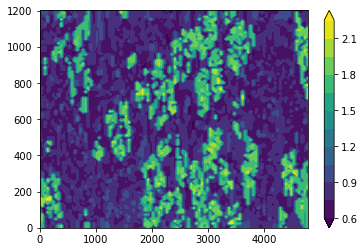

In [103]:
from scipy.interpolate import griddata
import math
import matplotlib.pyplot as plt
ngrid=100
xi, yi = np.linspace(nodes.geometry.x.min(), nodes.geometry.x.max(), ngrid), np.linspace(nodes.geometry.y.min(), nodes.geometry.y.max(), ngrid)
zi = griddata((nodes.geometry.x, nodes.geometry.y), (beliefs[:,0]-beliefs[:,1]+0.5), (xi[None, :], yi[:, None]), method='nearest')
#cs = plt.contourf(xi, yi, zi, norm=matplotlib.colors.Normalize(vmin=zi.min(), vmax=zi.max()),levels=20)
levs = math.floor((zi.max()-zi.min())/0.1)
print(levs)
cs = plt.contourf(xi, yi, zi, levels=levs-1, extend='both')
plt.colorbar()

In [28]:
initial.groupby('label').count()

0     1     2     3     4     5     6     7     8     9  ...    48  \
label                                                              ...         
1       182   182   182   182   182   182   182   182   182   182  ...   182   
2       637   637   637   637   637   637   637   637   637   637  ...   637   
3        14    14    14    14    14    14    14    14    14    14  ...    14   
4       273   273   273   273   273   273   273   273   273   273  ...   273   
5       112   112   112   112   112   112   112   112   112   112  ...   112   
6        82    82    82    82    82    82    82    82    82    82  ...    82   
7         7     7     7     7     7     7     7     7     7     7  ...     7   
8       796   796   796   796   796   796   796   796   796   796  ...   796   
9      4514  4514  4514  4514  4514  4514  4514  4514  4514  4514  ...  4514   
10      926   926   926   926   926   926   926   926   926   926  ...   926   
11      687   687   687   687   687   687   687   687   687   687  ...   687   
12       27    27    27    27    27    27    27    27    27    27  ...    27   
13      871   871   871   871   871   871   871   871   871   871  ...   871   
14      228   228   228   228   228   228   228   228   228   228  ...   228   
15      116   116   116   116   116   116   116   116   116   116  ...   116   
16      234   234   234   234   234   234   234   234   234   234  ...   234   
17        2     2     2     2     2     2     2     2     2     2  ...     2   
18      143   143   143   143   143   143   143   143   143   143  ...   143   
19      109   109   109   109   109   109   109   109   109   109  ...   109   
20      135   135   135   135   135   135   135   135   135   135  ...   135   

         49  phase     R     G     B   cl0   cl1   cl2  geometry  
label                                                             
1       182    182   182   182   182   182   182   182       182  
2       637    637   637   637   637   637   637   637       637  
3        14     14    14    14    14    14    14    14        14  
4       273    273   273   273   273   273   273   273       273  
5       112    112   112   112   112   112   112   112       112  
6        82     82    82    82    82    82    82    82        82  
7         7      7     7     7     7     7     7     7         7  
8       796    796   796   796   796   796   796   796       796  
9      4514   4514  4514  4514  4514  4514  4514  4514      4514  
10      926    926   926   926   926   926   926   926       926  
11      687    687   687   687   687   687   687   687       687  
12       27     27    27    27    27    27    27    27        27  
13      871    871   871   871   871   871   871   871       871  
14      228    228   228   228   228   228   228   228       228  
15      116    116   116   116   116   116   116   116       116  
16      234    234   234   234   234   234   234   234       234  
17        2      2     2     2     2     2     2     2         2  
18      143    143   143   143   143   143   143   143       143  
19      109    109   109   109   109   109   109   109       109  
20      135    135   135   135   135   135   135   135       135  

[20 rows x 58 columns]

In [26]:
len(pred_clf)

606

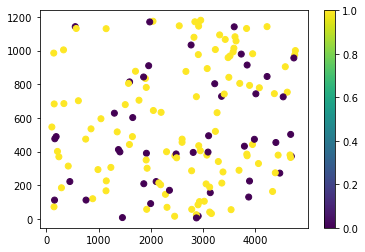

In [41]:

plt.colorbar()


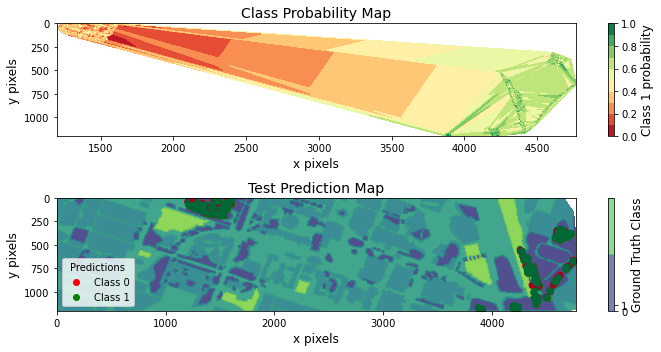

In [11]:
conv = labelsp.reset_index(level=['x', 'y'])
conv['class']=hf.group_classes(labelsp['class'], classesUsed)
fig, [ax1,ax2] = pl.create_subplots(2,1,[10,5])
normalized = (beliefs[:,1]-min(beliefs[:,1]))/(max(beliefs[:,1])-min(beliefs[:,1]))
res = ax1.tricontourf(nodes.geometry.x,nodes.geometry.y,normalized,cmap='RdYlGn',levels=10)
cb1 = fig.colorbar(res,ax=ax1)
cb1.set_label('Class 1 probability',fontsize=12), ax1.set_title('Class Probability Map',size=14)
ax1.invert_yaxis()
ax1.set_xlabel('x pixels', fontsize=12), ax1.set_ylabel('y pixels',fontsize=12)
ax2.set_xlabel('x pixels', fontsize=12), ax2.set_ylabel('y pixels',fontsize=12)
# ax1.axes.get_xaxis().set_visible(False)
# ax1.axes.get_yaxis().set_visible(False)
ax2.invert_yaxis()
alt =conv['class'].values
# for i, val in enumerate(alt): 
#     print(val)
#     if val == 1: alt[i]=val-0.001
a = ax2.tricontourf(conv.dropna().x,conv.dropna().y, alt,alpha=0.7,levels=1)
a2 = ax2.tricontourf(conv.dropna().x,conv.dropna().y, alt,alpha=0.7,levels=2)

ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c='r',label='Class 0')
ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c='g',label='Class 1')
ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c=pred_clf[::10],cmap='RdYlGn')
cb2 = fig.colorbar(a, ax=ax2, ticks=[0,1])
cb2.set_label('Ground Truth Class',fontsize=12), ax2.set_title('Test Prediction Map',size=14)
ax2.legend(title='Predictions',loc='lower left')
fig.tight_layout()

In [135]:
fig.savefig('results/plotDemo.png')

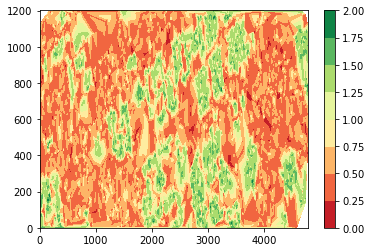

In [99]:
plt.tricontourf(nodes.geometry.x,nodes.geometry.y,beliefs[:,0],cmap='RdYlGn')
plt.colorbar()

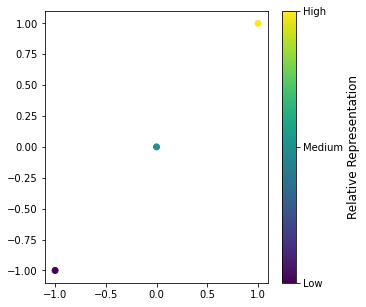

In [194]:
import matplotlib.pyplot as plt
a, ax = plt.subplots(1,1,figsize=[5,5])
b = ax.scatter([-1,0,1],[-1,0,1],c=[-1,0,1])
cbar = plt.colorbar(b,ticks=[-1, 0, 1])
cbar.set_label('Relative Representation',fontsize=12)
cbar.set_ticklabels(['Low', 'Medium', 'High'])
plt.show()
a.savefig('results/confusionColorbar.png')

# 